In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import sys
sys.path.extend(["..", "../backbone","../.."])
from backbones import DenseNet201, ResNet152d
from dataloader import create_dataloader
from metric import Metric
from focal import FocalLoss
from ctran_ie import IECTe
from tabulate import tabulate
torch.cuda.empty_cache()
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
in_channels = 3
num_workers = 8
num_labels = 21
num_layers = 6
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 21
data_dir = '../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = IECTe(num_classes=num_classes, in_channels= in_channels, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                      mlp_dim=mlp_dim, backbone1=backbone1, backbone2=backbone2)
model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but se

266563573


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        loss.backward()
        optimizer.step()

        with torch.no_grad(): metric.update(outputs, labels)
    
     # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels)

        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
     # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/iecte-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()      
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 125/125 [00:40<00:00,  3.06it/s]


Epoch [1/200], Loss: 0.1582, ML mAP: 0.2245, ML F1: 0.6364, ML AUC: 0.7562, ML Score: 0.4904, Bin AUC: 0.6053, Model Score: 0.5478, Bin F1: 0.1667
[0.46 0.32 0.29 0.77 0.85 0.27 0.63 0.43 0.59 0.69 0.43 0.34 0.75 0.66
 0.37 0.29 0.75 0.3  0.68 0.77 0.55]
Accuracy list: [0.8434217108554277, 0.8929464732366184, 0.8349174587293647, 0.8934467233616809, 0.9029514757378689, 0.8204102051025512, 0.9224612306153076, 0.9084542271135568, 0.9354677338669335, 0.9344672336168084, 0.9119559779889945, 0.8774387193596799, 0.9524762381190596, 0.9474737368684342, 0.8989494747373686, 0.8659329664832416, 0.9369684842421211, 0.8629314657328664, 0.9399699849924963, 0.9004502251125562, 0.9639819909954978]
Specificity list: [0.9306698002350177, 0.9207507820646507, 0.8804168952276468, 0.9994404029099049, 0.9994462901439646, 0.8539325842696629, 0.9994579945799458, 0.9592493297587131, 0.9994655264564404, 0.9994649545211343, 0.9553666312433581, 0.9013333333333333, 0.9994750656167979, 0.9994722955145119, 0.93797195

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [1/200], Loss: 5.8356, ML mAP: 0.3793, ML F1: 0.6913, ML AUC: 0.8363, ML Score: 0.6078, Bin AUC: 1.0000, Model Score: 0.8039, Bin F1: 0.6667
[0.58 0.17 0.48 0.51 0.66 0.51 0.5  0.6  0.28 0.33 0.26 0.54 0.6  0.58
 0.88 0.76 0.54 0.74 0.59 0.19 0.44]
Accuracy list: [0.9043280182232346, 0.8314350797266514, 0.9271070615034168, 0.8906605922551253, 0.856492027334852, 0.9567198177676538, 0.9384965831435079, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9635535307517085, 0.9749430523917996, 0.9817767653758542, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.856492027334852, 0.9977220956719818]
Specificity list: [0.9273743016759777, 0.8470948012232415, 0.9705882352941176, 0.9292929292929293, 0.8704156479217604, 0.9951690821256038, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9789227166276346, 0.9929906542056075, 0.

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [1/200], Loss: 5.9840, ML mAP: 0.3258, ML F1: 0.5874, ML AUC: 0.8501, ML Score: 0.5880, Bin AUC: 1.0000, Model Score: 0.7940, Bin F1: 0.6667
[0.58 0.17 0.48 0.51 0.66 0.51 0.5  0.6  0.28 0.33 0.26 0.54 0.6  0.58
 0.88 0.76 0.54 0.74 0.59 0.19 0.44]
Accuracy list: [0.8933649289099526, 0.8080568720379147, 0.9360189573459715, 0.8341232227488151, 0.8270142180094787, 0.9289099526066351, 0.9454976303317536, 0.95260663507109, 0.966824644549763, 0.9597156398104265, 0.9881516587677726, 0.9739336492890995, 0.9739336492890995, 0.9644549763033176, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9644549763033176, 0.8530805687203792, 0.990521327014218]
Specificity list: [0.9248554913294798, 0.8116883116883117, 0.9667519181585678, 0.8631578947368421, 0.8257575757575758, 0.9797979797979798, 0.9975, 0.9925558312655087, 0.9975490196078431, 0.9878048780487805, 0.9903846153846154, 0.9854721549636803, 0.9951219512195122, 0.9757869249394673, 0.9856115107913669, 0.

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [2/200], Loss: 0.1896, ML mAP: 0.5424, ML F1: 0.6131, ML AUC: 0.9010, ML Score: 0.7217, Bin AUC: 0.2500, Model Score: 0.4859, Bin F1: 0.0000
[0.31 0.26 0.33 0.31 0.33 0.34 0.6  0.31 0.18 0.6  0.37 0.34 0.19 0.25
 0.39 0.18 0.33 0.26 0.3  0.23 0.4 ]
Accuracy list: [0.8999499749874937, 0.961480740370185, 0.9229614807403702, 0.8834417208604303, 0.9069534767383692, 0.9094547273636818, 0.9399699849924963, 0.9409704852426213, 0.9099549774887443, 0.935967983991996, 0.961480740370185, 0.9604802401200601, 0.9484742371185593, 0.9529764882441221, 0.9569784892446224, 0.9334667333666833, 0.9399699849924963, 0.9324662331165583, 0.9464732366183092, 0.863431715857929, 0.9974987493746873]
Specificity list: [0.9369266055045872, 0.9863157894736843, 0.9625962596259626, 0.9286118980169972, 0.942888522789676, 0.9544159544159544, 0.999468085106383, 0.9657794676806084, 0.9463336875664187, 0.999465811965812, 0.9829151094500801, 0.9710920770877944, 0.9706652697747512, 0.9715969989281886, 0.979754928076718

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [2/200], Loss: 5.1275, ML mAP: 0.4421, ML F1: 0.7729, ML AUC: 0.8948, ML Score: 0.6685, Bin AUC: 1.0000, Model Score: 0.8342, Bin F1: 0.5000
[0.35 0.32 0.52 0.78 0.78 0.39 0.77 0.79 0.13 0.36 0.86 0.52 0.65 0.93
 0.74 0.81 0.95 0.36 0.62 0.05 0.99]
Accuracy list: [0.9157175398633257, 0.8724373576309795, 0.9384965831435079, 0.908883826879271, 0.929384965831435, 0.9407744874715261, 0.9384965831435079, 0.9703872437357631, 0.9772209567198178, 0.9749430523917996, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9703872437357631, 0.9726651480637813, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8724373576309795, 0.9977220956719818]
Specificity list: [0.9245810055865922, 0.8899082568807339, 0.9730392156862745, 0.9419191919191919, 0.9975550122249389, 0.9565217391304348, 0.9975786924939467, 0.9857482185273159, 0.9859154929577465, 0.9953488372093023, 0.9953596287703016, 0.9907192575406032, 0.9976744186046511, 0.9976580796252927, 0.97897

100%|██████████| 27/27 [00:06<00:00,  4.13it/s]


Test - Epoch [2/200], Loss: 5.0712, ML mAP: 0.3946, ML F1: 0.5052, ML AUC: 0.8822, ML Score: 0.6384, Bin AUC: 0.9500, Model Score: 0.7942, Bin F1: 0.5000
[0.35 0.32 0.52 0.78 0.78 0.39 0.77 0.79 0.13 0.36 0.86 0.52 0.65 0.93
 0.74 0.81 0.95 0.36 0.62 0.05 0.99]
Accuracy list: [0.8909952606635071, 0.8625592417061612, 0.9360189573459715, 0.8720379146919431, 0.9383886255924171, 0.9075829383886256, 0.9454976303317536, 0.9644549763033176, 0.95260663507109, 0.9691943127962085, 0.990521327014218, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.966824644549763, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8767772511848341, 0.985781990521327]
Specificity list: [0.9075144508670521, 0.8766233766233766, 0.9565217391304348, 0.9131578947368421, 1.0, 0.9343434343434344, 0.9975, 0.9900744416873449, 0.9779411764705882, 0.9975609756097561, 0.9927884615384616, 0.9878934624697336, 1.0, 0.9975786924939467, 0.973621103117506, 0.9927710843373494, 0.9952267303102

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [3/200], Loss: 0.1315, ML mAP: 0.7010, ML F1: 0.6775, ML AUC: 0.9445, ML Score: 0.8228, Bin AUC: 0.8684, Model Score: 0.8456, Bin F1: 0.0000
[0.35 0.45 0.25 0.34 0.29 0.43 0.24 0.3  0.29 0.18 0.41 0.46 0.44 0.44
 0.44 0.33 0.35 0.26 0.31 0.23 0.34]
Accuracy list: [0.9349674837418709, 0.9749874937468734, 0.9294647323661831, 0.9169584792396198, 0.9264632316158079, 0.9329664832416208, 0.9264632316158079, 0.950975487743872, 0.9484742371185593, 0.8994497248624312, 0.9699849924962481, 0.9729864932466233, 0.9769884942471235, 0.9814907453726863, 0.9799899949974987, 0.9704852426213106, 0.9639819909954978, 0.9439719859929965, 0.9634817408704353, 0.8849424712356178, 0.9954977488744372]
Specificity list: [0.9636048526863085, 0.9952978056426333, 0.9518398268398268, 0.954215522054718, 0.9476295479603087, 0.9668989547038328, 0.9594017094017094, 0.9689034369885434, 0.9775401069518717, 0.9298715203426124, 0.9877005347593583, 0.9874454148471615, 0.9973849372384938, 0.9931107578166402, 0.9919398173

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [3/200], Loss: 3.7989, ML mAP: 0.4519, ML F1: 0.7299, ML AUC: 0.9053, ML Score: 0.6786, Bin AUC: 1.0000, Model Score: 0.8393, Bin F1: 0.6667
[0.39 0.24 0.36 0.71 0.11 0.98 0.15 0.98 0.16 0.32 0.79 0.95 0.29 0.68
 0.36 0.77 0.92 0.73 0.67 0.1  0.71]
Accuracy list: [0.929384965831435, 0.8451025056947609, 0.9225512528473804, 0.9316628701594533, 0.9157175398633257, 0.9407744874715261, 0.8883826879271071, 0.9567198177676538, 0.9726651480637813, 0.9772209567198178, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.9441340782122905, 0.9051987767584098, 0.9485294117647058, 0.9772727272727273, 0.9388753056234719, 0.9975845410628019, 0.9055690072639225, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [3/200], Loss: 3.5983, ML mAP: 0.4826, ML F1: 0.4629, ML AUC: 0.9086, ML Score: 0.6956, Bin AUC: 1.0000, Model Score: 0.8478, Bin F1: 1.0000
[0.39 0.24 0.36 0.71 0.11 0.98 0.15 0.98 0.16 0.32 0.79 0.95 0.29 0.68
 0.36 0.77 0.92 0.73 0.67 0.1  0.71]
Accuracy list: [0.919431279620853, 0.8530805687203792, 0.9123222748815166, 0.919431279620853, 0.9146919431279621, 0.9407582938388626, 0.8862559241706162, 0.9549763033175356, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.922077922077922, 0.9335038363171355, 0.9657894736842105, 0.9267676767676768, 1.0, 0.9075, 1.0, 0.9950980392156863, 1.0, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 0.9951807228915662, 0.9976133651551312, 0.992822

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [4/200], Loss: 0.0697, ML mAP: 0.8004, ML F1: 0.7590, ML AUC: 0.9619, ML Score: 0.8811, Bin AUC: 0.9211, Model Score: 0.9011, Bin F1: 0.5000
[0.48 0.32 0.38 0.32 0.97 0.43 0.34 0.35 0.31 0.25 0.39 0.42 0.3  0.4
 0.43 0.4  0.36 0.39 0.5  0.34 0.32]
Accuracy list: [0.9489744872436218, 0.9659829914957478, 0.9454727363681841, 0.9319659829914958, 0.9084542271135568, 0.9464732366183092, 0.950975487743872, 0.9694847423711856, 0.9569784892446224, 0.9414707353676839, 0.9804902451225613, 0.9789894947473737, 0.9744872436218109, 0.9854927463731866, 0.9809904952476238, 0.9844922461230615, 0.9709854927463731, 0.9704852426213106, 0.9809904952476238, 0.9269634817408704, 0.9949974987493747]
Specificity list: [0.9782608695652174, 0.986744432661718, 0.9738134206219312, 0.9591611479028698, 0.9994496422674739, 0.9755542922114838, 0.9813034188034188, 0.9800431499460626, 0.9822485207100592, 0.9652963160704752, 0.9893446989877464, 0.9887096774193549, 0.9878435517970402, 0.994198312236287, 0.992469069392

100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [4/200], Loss: 3.6042, ML mAP: 0.5403, ML F1: 0.7020, ML AUC: 0.9098, ML Score: 0.7250, Bin AUC: 1.0000, Model Score: 0.8625, Bin F1: 1.0000
[0.47 0.33 0.25 0.81 0.25 0.89 0.23 0.76 0.13 0.7  0.48 0.72 0.67 0.49
 0.44 0.7  0.86 0.73 0.3  0.13 0.26]
Accuracy list: [0.9339407744874715, 0.8861047835990888, 0.9498861047835991, 0.929384965831435, 0.9384965831435079, 0.9703872437357631, 0.9020501138952164, 0.9635535307517085, 0.9772209567198178, 0.9772209567198178, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8633257403189066, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9852941176470589, 0.9747474747474747, 0.9706601466992665, 0.9951690821256038, 0.9200968523002422, 0.9762470308788599, 0.9859154929577465, 0.9976744186046511, 0.9930394431554525, 0.9907192575406032, 0.9976744186046511, 0.9929742388758782, 0.997

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [4/200], Loss: 3.7073, ML mAP: 0.5004, ML F1: 0.5328, ML AUC: 0.9038, ML Score: 0.7021, Bin AUC: 1.0000, Model Score: 0.8511, Bin F1: 0.6667
[0.47 0.33 0.25 0.81 0.25 0.89 0.23 0.76 0.13 0.7  0.48 0.72 0.67 0.49
 0.44 0.7  0.86 0.73 0.3  0.13 0.26]
Accuracy list: [0.9241706161137441, 0.8767772511848341, 0.9360189573459715, 0.9004739336492891, 0.9312796208530806, 0.943127962085308, 0.909952606635071, 0.957345971563981, 0.957345971563981, 0.9715639810426541, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8554502369668247, 0.9834123222748815]
Specificity list: [0.9595375722543352, 0.8961038961038961, 0.979539641943734, 0.9657894736842105, 0.9595959595959596, 0.9949494949494949, 0.9275, 0.9776674937965261, 0.9779411764705882, 1.0, 0.9879807692307693, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9903614457831326

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [5/200], Loss: 0.0697, ML mAP: 0.8628, ML F1: 0.8016, ML AUC: 0.9766, ML Score: 0.9197, Bin AUC: 1.0000, Model Score: 0.9598, Bin F1: 1.0000
[0.54 0.41 0.34 0.27 0.25 0.35 0.27 0.42 0.53 0.38 0.28 0.4  0.39 0.36
 0.4  0.32 0.55 0.49 0.37 0.31 0.33]
Accuracy list: [0.9654827413706853, 0.9674837418709354, 0.9514757378689345, 0.9379689844922461, 0.9409704852426213, 0.9494747373686844, 0.9429714857428715, 0.9754877438719359, 0.9739869934967483, 0.9674837418709354, 0.9834917458729364, 0.9854927463731866, 0.9854927463731866, 0.9879939969984992, 0.9859929964982491, 0.9879939969984992, 0.9869934967483742, 0.9864932466233116, 0.9844922461230615, 0.9289644822411206, 0.9979989994997499]
Specificity list: [0.9913544668587896, 0.9894347596407819, 0.9738562091503268, 0.9577308120133482, 0.9513274336283186, 0.9665706051873199, 0.9645196506550219, 0.9874591057797165, 0.995764955002647, 0.9893105291288081, 0.9898558462359851, 0.9908405172413793, 0.9958180867746994, 0.9936842105263158, 0.991452991

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [5/200], Loss: 4.1597, ML mAP: 0.5588, ML F1: 0.6888, ML AUC: 0.9155, ML Score: 0.7372, Bin AUC: 1.0000, Model Score: 0.8686, Bin F1: 1.0000
[0.1  0.07 0.13 0.86 0.08 0.18 0.19 0.84 0.41 0.85 0.78 0.43 0.9  0.46
 0.38 0.71 0.87 0.9  0.46 0.08 0.78]
Accuracy list: [0.9271070615034168, 0.8929384965831435, 0.9225512528473804, 0.9020501138952164, 0.9248291571753986, 0.9681093394077449, 0.9498861047835991, 0.9749430523917996, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.8952164009111617, 1.0]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9485294117647058, 0.9217171717171717, 0.9364303178484108, 0.9830917874396136, 0.9709443099273608, 0.995249406175772, 0.9906103286384976, 0.9976744186046511, 0.988399071925754, 0.9953596287703016, 1.0, 0.9859484777517564, 1.0, 0.9976851851851852, 0.997690531177

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [5/200], Loss: 4.1134, ML mAP: 0.5446, ML F1: 0.5280, ML AUC: 0.9089, ML Score: 0.7268, Bin AUC: 1.0000, Model Score: 0.8634, Bin F1: 1.0000
[0.1  0.07 0.13 0.86 0.08 0.18 0.19 0.84 0.41 0.85 0.78 0.43 0.9  0.46
 0.38 0.71 0.87 0.9  0.46 0.08 0.78]
Accuracy list: [0.9146919431279621, 0.8886255924170616, 0.9383886255924171, 0.9028436018957346, 0.8909952606635071, 0.9502369668246445, 0.9289099526066351, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.9393063583815029, 0.9253246753246753, 0.9565217391304348, 0.9210526315789473, 0.9015151515151515, 0.9823232323232324, 0.9575, 0.9975186104218362, 1.0, 1.0, 0.9735576923076923, 0.9830508474576272, 1.0, 0.9927360774818402, 0.9976019184652278, 0.9927710843373494, 0.9976133651551312, 0

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [6/200], Loss: 0.0592, ML mAP: 0.9036, ML F1: 0.8412, ML AUC: 0.9834, ML Score: 0.9435, Bin AUC: 0.9737, Model Score: 0.9586, Bin F1: 0.8000
[0.45 0.34 0.36 0.41 0.38 0.43 0.36 0.36 0.27 0.37 0.39 0.54 0.41 0.42
 0.49 0.42 0.45 0.55 0.35 0.38 0.31]
Accuracy list: [0.9559779889944973, 0.9704852426213106, 0.9564782391195598, 0.9544772386193097, 0.9544772386193097, 0.9639819909954978, 0.9554777388694348, 0.984992496248124, 0.9784892446223111, 0.9729864932466233, 0.9894947473736868, 0.9904952476238119, 0.9909954977488744, 0.9899949974987494, 0.9904952476238119, 0.9929964982491246, 0.9884942471235618, 0.9879939969984992, 0.984992496248124, 0.9409704852426213, 0.9984992496248124]
Specificity list: [0.9815028901734104, 0.9852863899106674, 0.97736057426836, 0.9767054908485857, 0.9708520179372198, 0.9814814814814815, 0.9800431499460626, 0.9904306220095693, 0.986709197235513, 0.9877071084981294, 0.9978506179473401, 0.996262680192205, 0.9978969505783386, 0.9952203929899097, 0.99629237288135

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [6/200], Loss: 4.2223, ML mAP: 0.5746, ML F1: 0.7654, ML AUC: 0.9182, ML Score: 0.7464, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 1.0000
[0.54 0.11 0.18 0.96 0.57 0.27 0.3  0.9  0.08 0.96 0.71 0.21 0.68 0.55
 0.21 0.94 0.97 0.95 0.41 0.05 0.56]
Accuracy list: [0.9407744874715261, 0.8861047835990888, 0.9407744874715261, 0.9430523917995444, 0.9453302961275627, 0.9635535307517085, 0.9453302961275627, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8929384965831435, 1.0]
Specificity list: [0.952513966480447, 0.9051987767584098, 0.9705882352941176, 0.9772727272727273, 0.980440097799511, 0.9782608695652174, 0.9782082324455206, 1.0, 0.9882629107981221, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 0.9953488372093023, 0.9882903981264637, 0.9976635514018691, 0.997685185185185

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [6/200], Loss: 4.2180, ML mAP: 0.5575, ML F1: 0.6133, ML AUC: 0.9134, ML Score: 0.7354, Bin AUC: 1.0000, Model Score: 0.8677, Bin F1: 1.0000
[0.54 0.11 0.18 0.96 0.57 0.27 0.3  0.9  0.08 0.96 0.71 0.21 0.68 0.55
 0.21 0.94 0.97 0.95 0.41 0.05 0.56]
Accuracy list: [0.9241706161137441, 0.8815165876777251, 0.9454976303317536, 0.9123222748815166, 0.9265402843601895, 0.95260663507109, 0.9407582938388626, 0.9644549763033176, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.9025974025974026, 0.9718670076726342, 0.9552631578947368, 0.9570707070707071, 0.9797979797979798, 0.9725, 0.9975186104218362, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9830508474576272, 0.9951219512195122, 0.9951573849878934, 0.9904076738609112, 0

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [7/200], Loss: 0.0777, ML mAP: 0.9311, ML F1: 0.8759, ML AUC: 0.9878, ML Score: 0.9594, Bin AUC: 1.0000, Model Score: 0.9797, Bin F1: 1.0000
[0.45 0.33 0.37 0.45 0.38 0.46 0.44 0.43 0.37 0.46 0.29 0.4  0.36 0.45
 0.38 0.34 0.51 0.48 0.31 0.3  0.18]
Accuracy list: [0.9674837418709354, 0.9719859929964982, 0.9644822411205602, 0.9529764882441221, 0.9674837418709354, 0.9729864932466233, 0.968984492246123, 0.9869934967483742, 0.9859929964982491, 0.9784892446223111, 0.9934967483741871, 0.9904952476238119, 0.9949974987493747, 0.9934967483741871, 0.9929964982491246, 0.9944972486243121, 0.9959979989994997, 0.9929964982491246, 0.9884942471235618, 0.9489744872436218, 0.9994997498749375]
Specificity list: [0.9856897538637664, 0.9889064976228209, 0.9820652173913044, 0.980192416525184, 0.9790979097909791, 0.9867358708189158, 0.99140708915145, 0.9940314704286489, 0.9973361747469366, 0.9936102236421726, 0.9957559681697613, 0.99511665762344, 0.9984284965950759, 0.9984126984126984, 0.99682707562136

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Val - Epoch [7/200], Loss: 3.9092, ML mAP: 0.5732, ML F1: 0.7372, ML AUC: 0.9226, ML Score: 0.7479, Bin AUC: 1.0000, Model Score: 0.8739, Bin F1: 1.0000
[0.56 0.06 0.25 0.89 0.5  0.23 0.29 0.61 0.29 0.87 0.98 0.47 0.97 0.13
 0.15 0.77 0.84 0.76 0.74 0.08 0.36]
Accuracy list: [0.9476082004555809, 0.8883826879271071, 0.9430523917995444, 0.9384965831435079, 0.9453302961275627, 0.9544419134396356, 0.9521640091116174, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9692737430167597, 0.908256880733945, 0.9754901960784313, 0.9722222222222222, 0.9853300733496333, 0.9710144927536232, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 1.0, 1.0, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [7/200], Loss: 3.9779, ML mAP: 0.5546, ML F1: 0.6175, ML AUC: 0.9175, ML Score: 0.7361, Bin AUC: 1.0000, Model Score: 0.8680, Bin F1: 1.0000
[0.56 0.06 0.25 0.89 0.5  0.23 0.29 0.61 0.29 0.87 0.98 0.47 0.97 0.13
 0.15 0.77 0.84 0.76 0.74 0.08 0.36]
Accuracy list: [0.9289099526066351, 0.8720379146919431, 0.933649289099526, 0.909952606635071, 0.9407582938388626, 0.9454976303317536, 0.9289099526066351, 0.9739336492890995, 0.9834123222748815, 0.9644549763033176, 0.9928909952606635, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9052132701421801, 0.990521327014218]
Specificity list: [0.9595375722543352, 0.8928571428571429, 0.9616368286445013, 0.9473684210526315, 0.9747474747474747, 0.9747474747474747, 0.96, 0.9851116625310173, 1.0, 0.9926829268292683, 0.9951923076923077, 0.9854721549636803, 0.9975609756097561, 0.9903147699757869, 0.9952038369304557, 0.995180722891566

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [8/200], Loss: 0.0676, ML mAP: 0.9473, ML F1: 0.8969, ML AUC: 0.9918, ML Score: 0.9696, Bin AUC: 1.0000, Model Score: 0.9848, Bin F1: 1.0000
[0.51 0.33 0.27 0.28 0.4  0.47 0.38 0.29 0.36 0.31 0.5  0.44 0.4  0.4
 0.29 0.43 0.31 0.56 0.39 0.36 0.29]
Accuracy list: [0.9749874937468734, 0.976488244122061, 0.9709854927463731, 0.9624812406203102, 0.9704852426213106, 0.9749874937468734, 0.9644822411205602, 0.9809904952476238, 0.9899949974987494, 0.9834917458729364, 0.9949974987493747, 0.991495747873937, 0.9979989994997499, 0.9979989994997499, 0.9944972486243121, 0.9939969984992496, 0.9939969984992496, 0.9949974987493747, 0.9934967483741871, 0.9569784892446224, 1.0]
Specificity list: [0.9942889777270132, 0.9873484449130205, 0.979291553133515, 0.9732142857142857, 0.9823204419889503, 0.9908204245553643, 0.9832793959007551, 0.9854604200323102, 0.9952127659574468, 0.9904153354632588, 0.9983991462113126, 0.9956663055254604, 0.9994700582935877, 0.9984168865435357, 0.9968287526427061, 0.9967914

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [8/200], Loss: 4.1621, ML mAP: 0.5894, ML F1: 0.7530, ML AUC: 0.9245, ML Score: 0.7569, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 1.0000
[0.65 0.24 0.14 0.99 0.26 0.26 0.3  0.7  0.16 0.81 0.97 0.43 0.95 0.27
 0.34 0.36 0.92 0.75 0.78 0.12 0.32]
Accuracy list: [0.9476082004555809, 0.8997722095671982, 0.9339407744874715, 0.9271070615034168, 0.9430523917995444, 0.9612756264236902, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9664804469273743, 0.9755351681957186, 0.9534313725490197, 0.9696969696969697, 0.9633251833740831, 0.9806763285024155, 0.9709443099273608, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 0.9953703703703703, 0.9976905311778291, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [8/200], Loss: 4.3625, ML mAP: 0.5610, ML F1: 0.5639, ML AUC: 0.9150, ML Score: 0.7380, Bin AUC: 1.0000, Model Score: 0.8690, Bin F1: 1.0000
[0.65 0.24 0.14 0.99 0.26 0.26 0.3  0.7  0.16 0.81 0.97 0.43 0.95 0.27
 0.34 0.36 0.92 0.75 0.78 0.12 0.32]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9289099526066351, 0.9123222748815166, 0.9052132701421801, 0.9454976303317536, 0.9383886255924171, 0.9739336492890995, 0.9834123222748815, 0.966824644549763, 0.9928909952606635, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9146919431279621, 0.990521327014218]
Specificity list: [0.9566473988439307, 0.9545454545454546, 0.948849104859335, 0.9526315789473684, 0.9141414141414141, 0.9848484848484849, 0.97, 0.9900744416873449, 1.0, 0.9926829268292683, 0.9951923076923077, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 0.9879518072289156,

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [9/200], Loss: 0.0544, ML mAP: 0.9512, ML F1: 0.9020, ML AUC: 0.9913, ML Score: 0.9712, Bin AUC: 1.0000, Model Score: 0.9856, Bin F1: 1.0000
[0.49 0.36 0.36 0.4  0.4  0.4  0.32 0.4  0.47 0.34 0.46 0.59 0.44 0.4
 0.39 0.49 0.3  0.5  0.31 0.42 0.22]
Accuracy list: [0.967983991995998, 0.9784892446223111, 0.9694847423711856, 0.9619809904952477, 0.976488244122061, 0.9774887443721861, 0.9604802401200601, 0.991495747873937, 0.9869934967483742, 0.9869934967483742, 0.9949974987493747, 0.9954977488744372, 0.9959979989994997, 0.9964982491245623, 0.9904952476238119, 0.9939969984992496, 0.9964982491245623, 0.9939969984992496, 0.9934967483741871, 0.9619809904952477, 1.0]
Specificity list: [0.9918319719953326, 0.9920802534318902, 0.9819474835886215, 0.9797979797979798, 0.9872222222222222, 0.9874643874643875, 0.9739413680781759, 0.9945828819068255, 0.995764955002647, 0.9935100054083288, 0.9984126984126984, 0.9994620763851533, 0.9984268484530676, 0.9973614775725593, 0.9930444087747459, 0.99738219

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [9/200], Loss: 4.1077, ML mAP: 0.5822, ML F1: 0.7521, ML AUC: 0.9275, ML Score: 0.7549, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.6  0.14 0.16 0.98 0.23 0.19 0.39 0.87 0.29 0.89 0.94 0.55 0.81 0.16
 0.19 0.55 0.95 0.78 0.78 0.05 0.3 ]
Accuracy list: [0.9453302961275627, 0.9043280182232346, 0.9316628701594533, 0.9362186788154897, 0.9271070615034168, 0.9521640091116174, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9692737430167597, 0.963302752293578, 0.9632352941176471, 0.9747474747474747, 0.9437652811735942, 0.9589371980676329, 0.9685230024213075, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9859484777517564, 1.0, 0.99768518518518

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [9/200], Loss: 4.1853, ML mAP: 0.5696, ML F1: 0.6079, ML AUC: 0.9162, ML Score: 0.7429, Bin AUC: 1.0000, Model Score: 0.8715, Bin F1: 1.0000
[0.6  0.14 0.16 0.98 0.23 0.19 0.39 0.87 0.29 0.89 0.94 0.55 0.81 0.16
 0.19 0.55 0.95 0.78 0.78 0.05 0.3 ]
Accuracy list: [0.9265402843601895, 0.909952606635071, 0.9383886255924171, 0.9146919431279621, 0.8791469194312796, 0.9383886255924171, 0.9289099526066351, 0.9715639810426541, 0.9834123222748815, 0.9691943127962085, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8815165876777251, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9545454545454546, 0.9616368286445013, 0.9605263157894737, 0.8863636363636364, 0.952020202020202, 0.96, 0.9975186104218362, 1.0, 0.9951219512195122, 0.9951923076923077, 0.9878934624697336, 0.9975609756097561, 0.9854721549636803, 0.9976019184652278, 0.9903614457831326

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [10/200], Loss: 0.0516, ML mAP: 0.9659, ML F1: 0.9176, ML AUC: 0.9935, ML Score: 0.9797, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
[0.42 0.42 0.43 0.49 0.4  0.37 0.39 0.5  0.33 0.35 0.45 0.46 0.53 0.32
 0.31 0.5  0.41 0.61 0.31 0.4  0.16]
Accuracy list: [0.9729864932466233, 0.9769884942471235, 0.9739869934967483, 0.967983991995998, 0.984992496248124, 0.9809904952476238, 0.9724862431215607, 0.992496248124062, 0.9884942471235618, 0.991495747873937, 0.9964982491245623, 0.9944972486243121, 0.9979989994997499, 0.9979989994997499, 0.9939969984992496, 0.9964982491245623, 0.9969984992496248, 0.9949974987493747, 0.9969984992496248, 0.9619809904952477, 1.0]
Specificity list: [0.9849624060150376, 0.9931542917324908, 0.986863711001642, 0.9838619922092376, 0.9901800327332242, 0.9859154929577465, 0.9907255864702673, 0.9973375931842385, 0.9968102073365231, 0.9930107526881721, 0.9983870967741936, 0.9962864721485412, 1.0, 0.9989423585404548, 0.9962506695232994, 0.9984260230849947, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [10/200], Loss: 4.0715, ML mAP: 0.5846, ML F1: 0.7467, ML AUC: 0.9261, ML Score: 0.7553, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 1.0000
[0.64 0.13 0.22 0.98 0.26 0.21 0.37 0.46 0.15 0.87 0.94 0.5  0.88 0.18
 0.14 0.28 0.88 0.84 0.77 0.08 0.2 ]
Accuracy list: [0.9453302961275627, 0.8952164009111617, 0.9384965831435079, 0.929384965831435, 0.9248291571753986, 0.9544419134396356, 0.9498861047835991, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9388379204892966, 0.9730392156862745, 0.9671717171717171, 0.9388753056234719, 0.961352657004831, 0.9782082324455206, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [10/200], Loss: 4.1836, ML mAP: 0.5654, ML F1: 0.5897, ML AUC: 0.9157, ML Score: 0.7405, Bin AUC: 1.0000, Model Score: 0.8703, Bin F1: 1.0000
[0.64 0.13 0.22 0.98 0.26 0.21 0.37 0.46 0.15 0.87 0.94 0.5  0.88 0.18
 0.14 0.28 0.88 0.84 0.77 0.08 0.2 ]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9312796208530806, 0.9170616113744076, 0.8815165876777251, 0.9383886255924171, 0.9383886255924171, 0.966824644549763, 0.985781990521327, 0.9715639810426541, 0.9928909952606635, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.9285714285714286, 0.959079283887468, 0.9631578947368421, 0.8914141414141414, 0.9595959595959596, 0.97, 0.9702233250620348, 1.0, 0.9975609756097561, 0.9951923076923077, 0.9854721549636803, 1.0, 0.9854721549636803, 0.9952038369304557, 0.9855421686746988, 0.9952267303

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [11/200], Loss: 0.0690, ML mAP: 0.9173, ML F1: 0.8586, ML AUC: 0.9863, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.38 0.34 0.33 0.43 0.47 0.55 0.32 0.47 0.5  0.37 0.62 0.47 0.39 0.57
 0.44 0.28 0.38 0.45 0.29 0.38 0.19]
Accuracy list: [0.9524762381190596, 0.968984492246123, 0.9644822411205602, 0.9584792396198099, 0.9609804902451226, 0.9714857428714357, 0.9479739869934968, 0.9809904952476238, 0.9809904952476238, 0.9774887443721861, 0.9934967483741871, 0.9934967483741871, 0.9959979989994997, 0.9939969984992496, 0.9919959979989995, 0.9904952476238119, 0.992496248124062, 0.9904952476238119, 0.9894947473736868, 0.9384692346173087, 0.9994997498749375]
Specificity list: [0.9737302977232924, 0.9857142857142858, 0.9776931447225244, 0.9787828029034059, 0.9817073170731707, 0.9909348441926346, 0.971600218459858, 0.9924650161463939, 0.9951948745328351, 0.987220447284345, 0.9989412387506618, 0.9973219068023568, 0.9984193888303478, 0.9979035639412998, 0.99733759318

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [11/200], Loss: 3.9586, ML mAP: 0.5584, ML F1: 0.6879, ML AUC: 0.9142, ML Score: 0.7363, Bin AUC: 1.0000, Model Score: 0.8682, Bin F1: 1.0000
[0.23 0.21 0.53 0.78 0.91 0.72 0.82 0.75 0.09 0.98 0.87 0.9  0.34 0.45
 0.28 0.98 0.64 0.86 0.7  0.37 0.46]
Accuracy list: [0.9384965831435079, 0.8997722095671982, 0.929384965831435, 0.9316628701594533, 0.929384965831435, 0.9476082004555809, 0.9362186788154897, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9840546697038725, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9703872437357631, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9583333333333334, 0.9772727272727273, 0.9975550122249389, 0.9685990338164251, 0.9564164648910412, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [11/200], Loss: 4.2397, ML mAP: 0.5227, ML F1: 0.4974, ML AUC: 0.9024, ML Score: 0.7125, Bin AUC: 1.0000, Model Score: 0.8563, Bin F1: 1.0000
[0.23 0.21 0.53 0.78 0.91 0.72 0.82 0.75 0.09 0.98 0.87 0.9  0.34 0.45
 0.28 0.98 0.64 0.86 0.7  0.37 0.46]
Accuracy list: [0.9123222748815166, 0.9052132701421801, 0.9289099526066351, 0.9028436018957346, 0.943127962085308, 0.9312796208530806, 0.9170616113744076, 0.9691943127962085, 0.9834123222748815, 0.9715639810426541, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9478672985781991, 0.8815165876777251, 0.995260663507109]
Specificity list: [0.9393063583815029, 0.9383116883116883, 0.948849104859335, 0.95, 1.0, 0.9671717171717171, 0.935, 0.9776674937965261, 0.9950980392156863, 1.0, 0.9807692307692307, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 0.9856801909307876, 0.9928229

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [12/200], Loss: 0.0622, ML mAP: 0.9178, ML F1: 0.8596, ML AUC: 0.9872, ML Score: 0.9525, Bin AUC: 1.0000, Model Score: 0.9763, Bin F1: 1.0000
[0.4  0.24 0.26 0.34 0.4  0.38 0.35 0.35 0.39 0.42 0.37 0.42 0.32 0.61
 0.44 0.31 0.28 0.63 0.3  0.35 0.24]
Accuracy list: [0.9739869934967483, 0.9769884942471235, 0.9584792396198099, 0.9529764882441221, 0.9504752376188094, 0.9644822411205602, 0.9559779889944973, 0.9814907453726863, 0.9784892446223111, 0.976488244122061, 0.9889944972486243, 0.9884942471235618, 0.9939969984992496, 0.9899949974987494, 0.9894947473736868, 0.9889944972486243, 0.9909954977488744, 0.9909954977488744, 0.9879939969984992, 0.9499749874937469, 0.9989994997498749]
Specificity list: [0.9867587795048935, 0.9863945578231292, 0.9684267827980403, 0.9698005698005698, 0.9708356702187325, 0.9786497403346798, 0.9760739532354541, 0.9891950297136682, 0.9883720930232558, 0.9892530897367007, 0.9930887825624668, 0.9923705722070845, 0.9968879668049793, 0.9962586851950829, 0.99355531

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Val - Epoch [12/200], Loss: 4.6778, ML mAP: 0.5759, ML F1: 0.6567, ML AUC: 0.9101, ML Score: 0.7430, Bin AUC: 1.0000, Model Score: 0.8715, Bin F1: 1.0000
[0.26 0.14 0.98 0.92 0.28 0.11 0.39 0.42 0.43 0.95 0.74 0.95 0.43 0.23
 0.05 0.91 0.94 0.95 0.07 0.07 0.31]
Accuracy list: [0.9271070615034168, 0.876993166287016, 0.9407744874715261, 0.9225512528473804, 0.9316628701594533, 0.9521640091116174, 0.9339407744874715, 0.9612756264236902, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9635535307517085, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9840546697038725, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.946927374301676, 0.9388379204892966, 0.9803921568627451, 0.9595959595959596, 0.960880195599022, 0.966183574879227, 0.9539951573849879, 0.9714964370546318, 0.9976525821596244, 0.9930232558139535, 1.0, 1.0, 0.9953488372093023, 0.9672131147540983, 0.9976635514018691, 0.9976851851851852, 0.9930715935

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [12/200], Loss: 4.5288, ML mAP: 0.5894, ML F1: 0.5159, ML AUC: 0.9137, ML Score: 0.7515, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 1.0000
[0.26 0.14 0.98 0.92 0.28 0.11 0.39 0.42 0.43 0.95 0.74 0.95 0.43 0.23
 0.05 0.91 0.94 0.95 0.07 0.07 0.31]
Accuracy list: [0.9123222748815166, 0.8886255924170616, 0.9597156398104265, 0.8909952606635071, 0.9265402843601895, 0.943127962085308, 0.9146919431279621, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9620853080568721, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.9318181818181818, 0.9820971867007673, 0.9289473684210526, 0.9419191919191919, 0.9722222222222222, 0.9425, 0.9801488833746899, 1.0, 1.0, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9806295399515739, 0.9928057553956835, 1.0, 0.9928400954653938, 0.98

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [13/200], Loss: 0.0675, ML mAP: 0.9335, ML F1: 0.8738, ML AUC: 0.9901, ML Score: 0.9618, Bin AUC: 0.8421, Model Score: 0.9020, Bin F1: 0.6667
[0.56 0.4  0.49 0.4  0.42 0.48 0.42 0.44 0.21 0.34 0.4  0.44 0.5  0.4
 0.5  0.48 0.47 0.46 0.43 0.38 0.33]
Accuracy list: [0.9699849924962481, 0.9779889944972486, 0.9734867433716858, 0.9674837418709354, 0.9714857428714357, 0.9719859929964982, 0.9699849924962481, 0.9819909954977488, 0.9809904952476238, 0.9804902451225613, 0.9864932466233116, 0.9934967483741871, 0.9919959979989995, 0.9929964982491246, 0.991495747873937, 0.9939969984992496, 0.9904952476238119, 0.9889944972486243, 0.9919959979989995, 0.9554777388694348, 0.9994997498749375]
Specificity list: [0.9874928936895964, 0.9942196531791907, 0.9897629310344828, 0.9813186813186813, 0.9839779005524862, 0.9879171461449943, 0.9871106337271751, 0.9913746630727763, 0.987254381306426, 0.9871175523349437, 0.9930777422790202, 0.9972943722943723, 0.996875, 0.9962904080551139, 0.9962825278810409, 0.

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [13/200], Loss: 4.6385, ML mAP: 0.5974, ML F1: 0.7163, ML AUC: 0.9126, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 1.0000
[0.06 0.64 0.06 0.99 0.09 0.07 0.22 0.46 0.03 0.29 0.34 0.19 0.09 0.98
 0.05 0.62 0.95 0.92 0.43 0.03 0.04]
Accuracy list: [0.9271070615034168, 0.9043280182232346, 0.9157175398633257, 0.9157175398633257, 0.9453302961275627, 0.9521640091116174, 0.9407744874715261, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9817767653758542, 0.9703872437357631, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.8656036446469249, 1.0]
Specificity list: [0.9441340782122905, 0.9418960244648318, 0.946078431372549, 0.9393939393939394, 0.9779951100244498, 0.961352657004831, 0.9636803874092009, 1.0, 0.9882629107981221, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9837209302325581, 0.9976580796252927, 0.9906542056074766, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [13/200], Loss: 4.8607, ML mAP: 0.5691, ML F1: 0.5260, ML AUC: 0.9050, ML Score: 0.7370, Bin AUC: 1.0000, Model Score: 0.8685, Bin F1: 1.0000
[0.06 0.64 0.06 0.99 0.09 0.07 0.22 0.46 0.03 0.29 0.34 0.19 0.09 0.98
 0.05 0.62 0.95 0.92 0.43 0.03 0.04]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9004739336492891, 0.8981042654028436, 0.9289099526066351, 0.95260663507109, 0.9265402843601895, 0.9691943127962085, 0.976303317535545, 0.9597156398104265, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.8578199052132701, 0.990521327014218]
Specificity list: [0.9566473988439307, 0.935064935064935, 0.9207161125319693, 0.9289473684210526, 0.946969696969697, 0.9747474747474747, 0.9575, 0.9925558312655087, 0.9877450980392157, 0.9853658536585366, 0.9711538461538461, 0.9878934624697336, 0.9804878048780488, 0.9975786924939467, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [14/200], Loss: 0.0402, ML mAP: 0.9515, ML F1: 0.8956, ML AUC: 0.9933, ML Score: 0.9724, Bin AUC: 1.0000, Model Score: 0.9862, Bin F1: 1.0000
[0.41 0.27 0.5  0.48 0.46 0.56 0.59 0.54 0.58 0.42 0.53 0.48 0.39 0.31
 0.38 0.43 0.33 0.51 0.4  0.41 0.28]
Accuracy list: [0.9729864932466233, 0.9664832416208105, 0.9729864932466233, 0.9619809904952477, 0.9789894947473737, 0.9809904952476238, 0.9774887443721861, 0.9859929964982491, 0.9889944972486243, 0.9844922461230615, 0.9944972486243121, 0.9949974987493747, 0.9959979989994997, 0.9939969984992496, 0.9964982491245623, 0.992496248124062, 0.9954977488744372, 0.9939969984992496, 0.9874937468734367, 0.9549774887443722, 0.9989994997498749]
Specificity list: [0.9886685552407932, 0.9793213149522799, 0.9891540130151844, 0.9816360601001669, 0.988404196576477, 0.9930555555555556, 0.9957035445757251, 0.995124593716143, 0.9973628691983122, 0.9925133689839573, 0.9983974358974359, 0.9967338051170387, 0.9989545216936748, 0.9957671957671957, 0.9984008528

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [14/200], Loss: 5.9770, ML mAP: 0.5575, ML F1: 0.6700, ML AUC: 0.8911, ML Score: 0.7243, Bin AUC: 1.0000, Model Score: 0.8621, Bin F1: 1.0000
[0.17 0.18 0.01 0.99 0.05 0.03 0.03 0.34 0.34 0.72 0.07 0.34 0.51 0.38
 0.56 0.03 0.31 0.84 0.01 0.83 0.1 ]
Accuracy list: [0.9316628701594533, 0.9020501138952164, 0.8724373576309795, 0.9020501138952164, 0.9407744874715261, 0.958997722095672, 0.9521640091116174, 0.9703872437357631, 0.9681093394077449, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9726651480637813, 0.8883826879271071, 1.0]
Specificity list: [0.9441340782122905, 0.9602446483180428, 0.9093137254901961, 0.9217171717171717, 0.9828850855745721, 0.9782608695652174, 0.9854721549636803, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9860788863109049, 1.0, 0.9906976744186047, 0.9953161592505855, 0.9953271028037384, 0.997685185185

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [14/200], Loss: 6.0418, ML mAP: 0.4995, ML F1: 0.4530, ML AUC: 0.8842, ML Score: 0.6919, Bin AUC: 0.9500, Model Score: 0.8209, Bin F1: 1.0000
[0.17 0.18 0.01 0.99 0.05 0.03 0.03 0.34 0.34 0.72 0.07 0.34 0.51 0.38
 0.56 0.03 0.31 0.84 0.01 0.83 0.1 ]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.8933649289099526, 0.8767772511848341, 0.9312796208530806, 0.9454976303317536, 0.9478672985781991, 0.9644549763033176, 0.966824644549763, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.976303317535545, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.990521327014218, 0.9644549763033176, 0.9170616113744076, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.9318181818181818, 0.9207161125319693, 0.8947368421052632, 0.9621212121212122, 0.9772727272727273, 0.9825, 0.9801488833746899, 1.0, 0.9975609756097561, 0.9735576923076923, 0.9830508474576272, 0.9878048780487805, 0.9903147699757869, 0.9928057553956835, 0.9927710843373

100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


Epoch [15/200], Loss: 0.0254, ML mAP: 0.9605, ML F1: 0.9156, ML AUC: 0.9936, ML Score: 0.9770, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000
[0.46 0.35 0.36 0.43 0.42 0.42 0.43 0.53 0.41 0.38 0.34 0.46 0.31 0.3
 0.34 0.39 0.44 0.4  0.41 0.49 0.23]
Accuracy list: [0.976488244122061, 0.9799899949974987, 0.968984492246123, 0.9674837418709354, 0.9779889944972486, 0.9769884942471235, 0.9759879939969985, 0.9919959979989995, 0.9894947473736868, 0.9944972486243121, 0.9944972486243121, 0.9909954977488744, 0.9974987493746873, 0.9964982491245623, 0.9959979989994997, 0.9959979989994997, 0.9969984992496248, 0.9954977488744372, 0.9974987493746873, 0.9609804902451226, 1.0]
Specificity list: [0.9903573454339194, 0.9911041339612768, 0.9797703663203936, 0.9852941176470589, 0.990027700831025, 0.9853107344632769, 0.9903381642512077, 0.9972781709308656, 0.996288441145281, 0.9967845659163987, 0.9957035445757251, 0.994092373791622, 0.9984160506863781, 0.9973628691983122, 0.9967948717948718, 0.99736008

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [15/200], Loss: 4.0244, ML mAP: 0.5647, ML F1: 0.7424, ML AUC: 0.9094, ML Score: 0.7371, Bin AUC: 1.0000, Model Score: 0.8685, Bin F1: 1.0000
[0.49 0.23 0.14 0.96 0.31 0.13 0.07 0.36 0.06 0.55 0.49 0.17 0.37 0.6
 0.8  0.29 0.76 0.71 0.96 0.02 0.73]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9407744874715261, 0.9339407744874715, 0.9476082004555809, 0.9544419134396356, 0.9225512528473804, 0.9749430523917996, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8678815489749431, 1.0]
Specificity list: [0.946927374301676, 0.9235474006116208, 0.9754901960784313, 0.9696969696969697, 0.9877750611246944, 0.9758454106280193, 0.937046004842615, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 0.9837587006960556, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [15/200], Loss: 4.1805, ML mAP: 0.5520, ML F1: 0.5260, ML AUC: 0.8973, ML Score: 0.7247, Bin AUC: 0.9500, Model Score: 0.8373, Bin F1: 0.6667
[0.49 0.23 0.14 0.96 0.31 0.13 0.07 0.36 0.06 0.55 0.49 0.17 0.37 0.6
 0.8  0.29 0.76 0.71 0.96 0.02 0.73]
Accuracy list: [0.919431279620853, 0.8933649289099526, 0.9383886255924171, 0.909952606635071, 0.9407582938388626, 0.943127962085308, 0.8886255924170616, 0.9644549763033176, 0.976303317535545, 0.9620853080568721, 0.9715639810426541, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8720379146919431, 0.9928909952606635]
Specificity list: [0.9393063583815029, 0.922077922077922, 0.9641943734015346, 0.9605263157894737, 0.9722222222222222, 0.9772727272727273, 0.91, 0.9751861042183623, 0.9926470588235294, 0.9878048780487805, 0.9711538461538461, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9927710843373494,

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [16/200], Loss: 0.0522, ML mAP: 0.9692, ML F1: 0.9233, ML AUC: 0.9959, ML Score: 0.9825, Bin AUC: 1.0000, Model Score: 0.9913, Bin F1: 1.0000
[0.52 0.44 0.26 0.55 0.42 0.46 0.38 0.49 0.38 0.39 0.31 0.37 0.37 0.34
 0.34 0.38 0.53 0.46 0.45 0.46 0.21]
Accuracy list: [0.9719859929964982, 0.9804902451225613, 0.9794897448724362, 0.9769884942471235, 0.9784892446223111, 0.9834917458729364, 0.9754877438719359, 0.991495747873937, 0.9894947473736868, 0.9949974987493747, 0.9959979989994997, 0.9969984992496248, 0.9949974987493747, 0.9959979989994997, 0.9909954977488744, 0.9964982491245623, 0.9949974987493747, 0.9929964982491246, 0.9974987493746873, 0.9729864932466233, 0.9994997498749375]
Specificity list: [0.9890489913544669, 0.9937007874015747, 0.9842988630211154, 0.9932998324958124, 0.9867109634551495, 0.9902578796561604, 0.9848893685914732, 0.9967602591792657, 0.9946638207043756, 0.9983862291554599, 0.9968203497615262, 0.9978331527627302, 0.9968253968253968, 0.9968569931901519, 0.99305555

100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [16/200], Loss: 4.3068, ML mAP: 0.5952, ML F1: 0.6508, ML AUC: 0.9243, ML Score: 0.7597, Bin AUC: 1.0000, Model Score: 0.8799, Bin F1: 1.0000
[0.23 0.18 0.01 0.85 0.12 0.24 0.42 0.97 0.17 0.99 0.99 0.36 0.4  0.41
 0.48 0.42 0.19 0.22 0.34 0.44 0.32]
Accuracy list: [0.9316628701594533, 0.9111617312072893, 0.9248291571753986, 0.9248291571753986, 0.9453302961275627, 0.9521640091116174, 0.9567198177676538, 0.9772209567198178, 0.9840546697038725, 0.9703872437357631, 0.9886104783599089, 0.9977220956719818, 0.9840546697038725, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9453302961275627, 0.9703872437357631, 0.9134396355353075, 1.0]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9509803921568627, 0.946969696969697, 0.980440097799511, 0.966183574879227, 0.9903147699757869, 0.9881235154394299, 0.9953051643192489, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 1.0, 0.9976851851851852, 1.0, 0.94688

100%|██████████| 27/27 [00:07<00:00,  3.83it/s]


Test - Epoch [16/200], Loss: 4.5197, ML mAP: 0.5484, ML F1: 0.5287, ML AUC: 0.8997, ML Score: 0.7240, Bin AUC: 0.9500, Model Score: 0.8370, Bin F1: 0.6667
[0.23 0.18 0.01 0.85 0.12 0.24 0.42 0.97 0.17 0.99 0.99 0.36 0.4  0.41
 0.48 0.42 0.19 0.22 0.34 0.44 0.32]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.909952606635071, 0.8957345971563981, 0.943127962085308, 0.9265402843601895, 0.95260663507109, 0.9691943127962085, 0.985781990521327, 0.966824644549763, 0.9881516587677726, 0.9715639810426541, 0.976303317535545, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.9928909952606635, 0.943127962085308, 0.9620853080568721, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.922077922077922, 0.928388746803069, 0.9236842105263158, 0.9722222222222222, 0.9545454545454546, 0.9825, 0.9900744416873449, 0.9975490196078431, 0.9926829268292683, 0.9903846153846154, 0.9782082324455206, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 0.9

100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


Epoch [17/200], Loss: 0.0239, ML mAP: 0.9714, ML F1: 0.9266, ML AUC: 0.9958, ML Score: 0.9836, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
[0.6  0.26 0.6  0.43 0.54 0.4  0.35 0.42 0.54 0.35 0.45 0.37 0.31 0.39
 0.41 0.37 0.7  0.45 0.37 0.38 0.42]
Accuracy list: [0.9794897448724362, 0.9794897448724362, 0.9739869934967483, 0.976488244122061, 0.9784892446223111, 0.9844922461230615, 0.9804902451225613, 0.9904952476238119, 0.9889944972486243, 0.991495747873937, 0.9974987493746873, 0.9969984992496248, 0.9964982491245623, 0.9959979989994997, 0.9969984992496248, 0.9959979989994997, 0.9949974987493747, 0.9959979989994997, 0.9979989994997499, 0.967983991995998, 0.9994997498749375]
Specificity list: [0.9943246311010215, 0.9889415481832543, 0.9918122270742358, 0.9869466515323496, 0.9905555555555555, 0.9931934203062961, 0.9902755267423015, 0.994579945799458, 0.995710455764075, 0.9941144997324772, 0.9994635193133047, 0.9967462039045553, 0.9973656480505796, 0.9973767051416579, 0.997892518440

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [17/200], Loss: 3.5815, ML mAP: 0.6278, ML F1: 0.6910, ML AUC: 0.9241, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.53 0.31 0.25 0.94 0.32 0.28 0.06 0.93 0.48 0.91 0.97 0.07 0.49 0.13
 0.06 0.76 0.37 0.86 0.14 0.13 0.07]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9271070615034168, 0.9362186788154897, 0.89749430523918, 0.9681093394077449, 0.929384965831435, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 1.0]
Specificity list: [0.9692737430167597, 0.9663608562691132, 0.9583333333333334, 0.9621212121212122, 0.9242053789731052, 0.9806763285024155, 0.9515738498789347, 0.995249406175772, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9929906542056075, 0.9976851851851852, 0.99769053117

100%|██████████| 27/27 [00:06<00:00,  4.33it/s]


Test - Epoch [17/200], Loss: 4.0738, ML mAP: 0.5731, ML F1: 0.5609, ML AUC: 0.9063, ML Score: 0.7397, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 0.0000
[0.53 0.31 0.25 0.94 0.32 0.28 0.06 0.93 0.48 0.91 0.97 0.07 0.49 0.13
 0.06 0.76 0.37 0.86 0.14 0.13 0.07]
Accuracy list: [0.943127962085308, 0.8791469194312796, 0.9383886255924171, 0.8815165876777251, 0.9241706161137441, 0.9360189573459715, 0.9146919431279621, 0.9739336492890995, 0.985781990521327, 0.966824644549763, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.9644549763033176, 0.8791469194312796, 0.9928909952606635]
Specificity list: [0.9797687861271677, 0.9318181818181818, 0.9616368286445013, 0.9263157894736842, 0.9393939393939394, 0.9722222222222222, 0.935, 0.9950372208436724, 0.9950980392156863, 0.9926829268292683, 0.9879807692307693, 0.9878934624697336, 0.9951219512195122, 0.9975786924939467, 0.988009592326139, 0.

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [18/200], Loss: 0.0394, ML mAP: 0.9778, ML F1: 0.9401, ML AUC: 0.9970, ML Score: 0.9874, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 1.0000
[0.47 0.33 0.26 0.37 0.56 0.42 0.27 0.51 0.3  0.39 0.54 0.26 0.23 0.4
 0.39 0.25 0.51 0.36 0.17 0.43 0.17]
Accuracy list: [0.9819909954977488, 0.9789894947473737, 0.9779889944972486, 0.9794897448724362, 0.9844922461230615, 0.983991995997999, 0.9774887443721861, 0.9984992496248124, 0.9939969984992496, 0.9944972486243121, 0.9974987493746873, 0.9974987493746873, 0.9984992496248124, 0.9964982491245623, 0.9954977488744372, 0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9709854927463731, 1.0]
Specificity list: [0.9908045977011494, 0.9889123548046462, 0.9830601092896175, 0.9894795127353266, 0.9961432506887052, 0.9902522935779816, 0.9817400644468314, 0.9994603345925526, 0.9962506695232994, 0.9967931587386424, 0.9994678020223523, 0.9978401727861771, 0.9984334203655353, 0.9973711882229233, 0.9967689822294022, 0.9963

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [18/200], Loss: 4.6434, ML mAP: 0.6114, ML F1: 0.7217, ML AUC: 0.9213, ML Score: 0.7663, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000
[0.56 0.11 0.47 0.99 0.88 0.74 0.18 0.93 0.26 0.31 0.38 0.66 0.56 0.12
 0.23 0.22 0.21 0.47 0.59 0.11 0.37]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9225512528473804, 0.9362186788154897, 0.9225512528473804, 0.9703872437357631, 0.9544419134396356, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9916201117318436, 0.9480122324159022, 0.9558823529411765, 0.9696969696969697, 0.9511002444987775, 0.9855072463768116, 0.9878934624697336, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 0.99768518518

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [18/200], Loss: 4.9371, ML mAP: 0.5844, ML F1: 0.5358, ML AUC: 0.9098, ML Score: 0.7471, Bin AUC: 0.9500, Model Score: 0.8485, Bin F1: 1.0000
[0.56 0.11 0.47 0.99 0.88 0.74 0.18 0.93 0.26 0.31 0.38 0.66 0.56 0.12
 0.23 0.22 0.21 0.47 0.59 0.11 0.37]
Accuracy list: [0.9265402843601895, 0.8767772511848341, 0.9312796208530806, 0.9075829383886256, 0.9075829383886256, 0.9620853080568721, 0.9502369668246445, 0.981042654028436, 0.985781990521327, 0.9644549763033176, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.966824644549763, 0.9715639810426541, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9188311688311688, 0.9539641943734015, 0.9473684210526315, 0.9292929292929293, 0.98989898989899, 0.98, 0.9900744416873449, 0.9975490196078431, 0.9902439024390244, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9927710843373494, 0.

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [19/200], Loss: 0.0078, ML mAP: 0.9843, ML F1: 0.9471, ML AUC: 0.9979, ML Score: 0.9911, Bin AUC: 1.0000, Model Score: 0.9955, Bin F1: 1.0000
[0.36 0.23 0.39 0.47 0.59 0.36 0.55 0.31 0.4  0.29 0.29 0.43 0.41 0.4
 0.59 0.33 0.32 0.45 0.32 0.35 0.14]
Accuracy list: [0.9759879939969985, 0.976488244122061, 0.984992496248124, 0.9799899949974987, 0.9879939969984992, 0.9934967483741871, 0.9834917458729364, 0.9944972486243121, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9964982491245623, 0.9979989994997499, 0.9984992496248124, 0.9969984992496248, 0.9974987493746873, 0.9744872436218109, 0.9994997498749375]
Specificity list: [0.9854651162790697, 0.9832109129066107, 0.991393222162453, 0.98989898989899, 0.9950027762354248, 0.9954049396898335, 0.9946695095948828, 0.9967654986522911, 0.998422712933754, 0.9967741935483871, 0.9984034060670569, 0.9989159891598915, 0.9994728518713759, 0.9994722955145119, 0.99839743589743

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [19/200], Loss: 3.4561, ML mAP: 0.6138, ML F1: 0.7076, ML AUC: 0.9269, ML Score: 0.7703, Bin AUC: 1.0000, Model Score: 0.8852, Bin F1: 1.0000
[0.48 0.26 0.34 0.87 0.04 0.21 0.12 0.82 0.43 0.5  0.77 0.14 0.68 0.65
 0.26 0.22 0.25 0.84 0.99 0.11 0.2 ]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9111617312072893, 0.9339407744874715, 0.9020501138952164, 0.9726651480637813, 0.958997722095672, 0.9772209567198178, 0.9886104783599089, 0.9749430523917996, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9664804469273743, 0.9051987767584098, 0.9436274509803921, 0.9671717171717171, 0.9193154034229829, 0.9806763285024155, 0.9903147699757869, 0.9881235154394299, 0.9976525821596244, 0.9883720930232558, 1.0, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9976905311778291, 

100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


Test - Epoch [19/200], Loss: 3.7029, ML mAP: 0.5961, ML F1: 0.6025, ML AUC: 0.9100, ML Score: 0.7530, Bin AUC: 1.0000, Model Score: 0.8765, Bin F1: 1.0000
[0.48 0.26 0.34 0.87 0.04 0.21 0.12 0.82 0.43 0.5  0.77 0.14 0.68 0.65
 0.26 0.22 0.25 0.84 0.99 0.11 0.2 ]
Accuracy list: [0.9454976303317536, 0.8862559241706162, 0.933649289099526, 0.9265402843601895, 0.8838862559241706, 0.9478672985781991, 0.9620853080568721, 0.976303317535545, 0.985781990521327, 0.9597156398104265, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.8831168831168831, 0.9514066496163683, 0.9605263157894737, 0.8939393939393939, 0.9722222222222222, 0.9875, 0.9925558312655087, 0.9975490196078431, 0.9829268292682927, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [20/200], Loss: 0.0163, ML mAP: 0.9868, ML F1: 0.9579, ML AUC: 0.9982, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
[0.52 0.55 0.17 0.43 0.51 0.6  0.48 0.6  0.29 0.35 0.21 0.35 0.51 0.75
 0.51 0.46 0.49 0.3  0.51 0.49 0.22]
Accuracy list: [0.9784892446223111, 0.9854927463731866, 0.9814907453726863, 0.9854927463731866, 0.9904952476238119, 0.9889944972486243, 0.9884942471235618, 0.9964982491245623, 0.9984992496248124, 0.9949974987493747, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9959979989994997, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9804902451225613, 1.0]
Specificity list: [0.9913194444444444, 0.9963138493944181, 0.983032293377121, 0.9914627205463858, 0.9955555555555555, 0.9971574758385446, 0.9946062567421791, 0.9989276139410188, 0.9994734070563455, 0.9973333333333333, 0.9983991462113126, 0.9983766233766234, 0.9994802494802495, 0.9994728518713759, 0.9983965793693212, 1.0, 

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [20/200], Loss: 3.7832, ML mAP: 0.6244, ML F1: 0.7457, ML AUC: 0.9273, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000
[0.2  0.07 0.43 0.99 0.16 0.15 0.52 0.55 0.14 0.95 0.37 0.11 0.4  0.1
 0.09 0.65 0.28 0.82 0.92 0.05 0.07]
Accuracy list: [0.929384965831435, 0.9066059225512528, 0.9384965831435079, 0.9384965831435079, 0.9476082004555809, 0.9567198177676538, 0.958997722095672, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9703872437357631, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9413407821229051, 0.9388379204892966, 0.9828431372549019, 0.9722222222222222, 0.9828850855745721, 0.9637681159420289, 0.9903147699757869, 0.9904988123515439, 0.9882629107981221, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9789227166276346, 0.9929906542056075, 0.99768518518518

100%|██████████| 27/27 [00:06<00:00,  3.93it/s]


Test - Epoch [20/200], Loss: 4.0410, ML mAP: 0.5991, ML F1: 0.5717, ML AUC: 0.9162, ML Score: 0.7577, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.6667
[0.2  0.07 0.43 0.99 0.16 0.15 0.52 0.55 0.14 0.95 0.37 0.11 0.4  0.1
 0.09 0.65 0.28 0.82 0.92 0.05 0.07]
Accuracy list: [0.95260663507109, 0.8957345971563981, 0.9502369668246445, 0.9312796208530806, 0.943127962085308, 0.9218009478672986, 0.957345971563981, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9253246753246753, 0.979539641943734, 0.968421052631579, 0.9646464646464646, 0.9444444444444444, 0.98, 0.9925558312655087, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9878934624697336, 1.0, 0.9903147699757869, 0.9832134292565947, 0.9927710843373494, 0.

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [21/200], Loss: 0.0099, ML mAP: 0.9895, ML F1: 0.9631, ML AUC: 0.9987, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
[0.42 0.48 0.45 0.51 0.49 0.47 0.43 0.24 0.33 0.54 0.59 0.29 0.12 0.16
 0.48 0.19 0.35 0.3  0.43 0.42 0.08]
Accuracy list: [0.9909954977488744, 0.9819909954977488, 0.9919959979989995, 0.9799899949974987, 0.9879939969984992, 0.9949974987493747, 0.9904952476238119, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9854927463731866, 1.0]
Specificity list: [0.9965297860034702, 0.9941613588110403, 0.9967373572593801, 0.9894385769872152, 0.995114006514658, 0.996011396011396, 0.9951871657754011, 0.9967550027041644, 0.9989445910290238, 1.0, 1.0, 0.9983748645720477, 0.9989423585404548, 0.9994708994708995, 0.999465811965812, 0.9978969505783386, 0.999460625674217

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [21/200], Loss: 3.8836, ML mAP: 0.6146, ML F1: 0.7448, ML AUC: 0.9205, ML Score: 0.7675, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 1.0000
[0.6  0.04 0.4  0.92 0.1  0.9  0.11 0.99 0.93 0.95 0.55 0.39 0.46 0.1
 0.48 0.2  0.03 0.74 0.9  0.22 0.4 ]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9544419134396356, 0.9225512528473804, 0.9430523917995444, 0.9681093394077449, 0.9407744874715261, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9664804469273743, 0.9051987767584098, 0.9926470588235294, 0.9444444444444444, 0.9877750611246944, 0.9951690821256038, 0.9612590799031477, 0.997624703087886, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 0.9953703703703703, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [21/200], Loss: 4.0958, ML mAP: 0.5946, ML F1: 0.5734, ML AUC: 0.9072, ML Score: 0.7509, Bin AUC: 0.9000, Model Score: 0.8255, Bin F1: 0.6667
[0.6  0.04 0.4  0.92 0.1  0.9  0.11 0.99 0.93 0.95 0.55 0.39 0.46 0.1
 0.48 0.2  0.03 0.74 0.9  0.22 0.4 ]
Accuracy list: [0.9454976303317536, 0.8957345971563981, 0.957345971563981, 0.909952606635071, 0.9360189573459715, 0.9549763033175356, 0.9360189573459715, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9058441558441559, 0.989769820971867, 0.9447368421052632, 0.9696969696969697, 0.9949494949494949, 0.9525, 0.9925558312655087, 1.0, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9879518072289156, 0.99284009546

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [22/200], Loss: 0.0270, ML mAP: 0.9910, ML F1: 0.9647, ML AUC: 0.9988, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
[0.47 0.43 0.38 0.37 0.34 0.38 0.32 0.38 0.72 0.45 0.26 0.39 0.35 0.53
 0.39 0.18 0.25 0.29 0.25 0.35 0.12]
Accuracy list: [0.9899949974987494, 0.9859929964982491, 0.9919959979989995, 0.9859929964982491, 0.9929964982491246, 0.9954977488744372, 0.9869934967483742, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9834917458729364, 1.0]
Specificity list: [0.9960204661739624, 0.9931972789115646, 0.9956919763058697, 0.9901207464324918, 0.9945622620989668, 0.9959931310818546, 0.9918478260869565, 0.9989229940764675, 0.9994706193753309, 0.9989258861439313, 0.9989293361884368, 0.9978425026968716, 0.9994706193753309, 0.9989270386266095, 0.9989350372736954, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [22/200], Loss: 4.3899, ML mAP: 0.6178, ML F1: 0.7427, ML AUC: 0.9238, ML Score: 0.7708, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 0.6667
[0.08 0.04 0.77 0.99 0.4  0.25 0.12 0.89 0.09 0.73 0.3  0.21 0.09 0.34
 0.04 0.07 0.05 0.72 0.96 0.04 0.21]
Accuracy list: [0.9248291571753986, 0.908883826879271, 0.9498861047835991, 0.9339407744874715, 0.9202733485193622, 0.9567198177676538, 0.9635535307517085, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9329608938547486, 0.9113149847094801, 0.9852941176470589, 0.9595959595959596, 0.960880195599022, 0.961352657004831, 0.9927360774818402, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [22/200], Loss: 4.6579, ML mAP: 0.6049, ML F1: 0.5840, ML AUC: 0.9143, ML Score: 0.7596, Bin AUC: 0.9500, Model Score: 0.8548, Bin F1: 0.6667
[0.08 0.04 0.77 0.99 0.4  0.25 0.12 0.89 0.09 0.73 0.3  0.21 0.09 0.34
 0.04 0.07 0.05 0.72 0.96 0.04 0.21]
Accuracy list: [0.933649289099526, 0.8909952606635071, 0.95260663507109, 0.9146919431279621, 0.9360189573459715, 0.9265402843601895, 0.9502369668246445, 0.9691943127962085, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9715639810426541, 0.9715639810426541, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9025974025974026, 0.9820971867007673, 0.9473684210526315, 0.9595959595959596, 0.946969696969697, 0.9725, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9831730769230769, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9832134292565947, 0.992771084337349

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [23/200], Loss: 0.0246, ML mAP: 0.9942, ML F1: 0.9692, ML AUC: 0.9992, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.51 0.52 0.48 0.44 0.39 0.48 0.33 0.52 0.28 0.3  0.27 0.22 0.26 0.67
 0.49 0.52 0.57 0.4  0.22 0.35 0.15]
Accuracy list: [0.9864932466233116, 0.9844922461230615, 0.9909954977488744, 0.9889944972486243, 0.9929964982491246, 0.9954977488744372, 0.9884942471235618, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9864932466233116, 1.0]
Specificity list: [0.9953134153485648, 0.9957828149710068, 0.9972737186477645, 0.9943977591036415, 0.996661101836394, 1.0, 0.991332611050921, 0.9989224137931034, 0.99893219434063, 0.9994632313472893, 0.9994694960212201, 0.9989159891598915, 0.9994756161510225, 0.9994772608468374, 0.9973161567364466, 1.0, 1.0, 0.997874601487779, 0.9994731

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [23/200], Loss: 3.9573, ML mAP: 0.6234, ML F1: 0.7559, ML AUC: 0.9244, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 0.6667
[0.13 0.17 0.57 0.88 0.07 0.5  0.09 0.69 0.21 0.94 0.27 0.15 0.05 0.1
 0.01 0.21 0.01 0.86 0.89 0.04 0.36]
Accuracy list: [0.9248291571753986, 0.9271070615034168, 0.9521640091116174, 0.9339407744874715, 0.9271070615034168, 0.9635535307517085, 0.9567198177676538, 0.9772209567198178, 0.9886104783599089, 0.9749430523917996, 0.9817767653758542, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.946927374301676, 0.9785932721712538, 0.9852941176470589, 0.9570707070707071, 0.9511002444987775, 0.9734299516908212, 0.9830508474576272, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 0.988399071925754, 1.0, 0.9930232558139535, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.995381062

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [23/200], Loss: 4.1528, ML mAP: 0.6008, ML F1: 0.5767, ML AUC: 0.9117, ML Score: 0.7562, Bin AUC: 0.9000, Model Score: 0.8281, Bin F1: 1.0000
[0.13 0.17 0.57 0.88 0.07 0.5  0.09 0.69 0.21 0.94 0.27 0.15 0.05 0.1
 0.01 0.21 0.01 0.86 0.89 0.04 0.36]
Accuracy list: [0.9502369668246445, 0.9004739336492891, 0.95260663507109, 0.9170616113744076, 0.9170616113744076, 0.943127962085308, 0.9478672985781991, 0.976303317535545, 0.9881516587677726, 0.966824644549763, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.9715639810426541, 0.8720379146919431, 0.990521327014218]
Specificity list: [0.9653179190751445, 0.9545454545454546, 0.979539641943734, 0.9473684210526315, 0.9368686868686869, 0.9671717171717171, 0.9675, 0.9851116625310173, 0.9975490196078431, 0.9902439024390244, 0.9783653846153846, 0.9903147699757869, 1.0, 0.9951573849878934, 0.988009592326139, 0.9927710843373494, 

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [24/200], Loss: 0.0346, ML mAP: 0.9953, ML F1: 0.9740, ML AUC: 0.9992, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.36 0.47 0.38 0.48 0.44 0.64 0.63 0.25 0.24 0.7  0.12 0.45 0.46 0.19
 0.33 0.24 0.76 0.3  0.21 0.41 0.21]
Accuracy list: [0.9934967483741871, 0.9834917458729364, 0.9919959979989995, 0.9869934967483742, 0.9949974987493747, 0.992496248124062, 0.9944972486243121, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.991495747873937, 1.0]
Specificity list: [0.9976971790443293, 0.9947534102833159, 0.9950083194675541, 0.9954980303882949, 0.9972191323692993, 0.997709049255441, 0.9994600431965442, 0.9983775013520823, 0.9994700582935877, 0.998936735778841, 0.9994706193753309, 1.0, 0.9994747899159664, 0.999474513925381, 1.0, 0.9994739610731194, 1.0, 0.9994655264564404, 1.0, 0.9961453744493393,

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [24/200], Loss: 4.2935, ML mAP: 0.6043, ML F1: 0.7319, ML AUC: 0.9147, ML Score: 0.7595, Bin AUC: 1.0000, Model Score: 0.8797, Bin F1: 1.0000
[0.21 0.04 0.17 0.98 0.07 0.38 0.26 0.94 0.09 0.81 0.51 0.18 0.33 0.12
 0.19 0.46 0.05 0.63 0.94 0.07 0.55]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9384965831435079, 0.9362186788154897, 0.908883826879271, 0.958997722095672, 0.9612756264236902, 0.9772209567198178, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9681372549019608, 0.9646464646464646, 0.941320293398533, 0.9734299516908212, 0.9878934624697336, 0.9904988123515439, 0.9929577464788732, 0.9953488372093023, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9976635514018691, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [24/200], Loss: 4.4586, ML mAP: 0.5911, ML F1: 0.5662, ML AUC: 0.9090, ML Score: 0.7501, Bin AUC: 0.9000, Model Score: 0.8250, Bin F1: 0.6667
[0.21 0.04 0.17 0.98 0.07 0.38 0.26 0.94 0.09 0.81 0.51 0.18 0.33 0.12
 0.19 0.46 0.05 0.63 0.94 0.07 0.55]
Accuracy list: [0.9478672985781991, 0.8981042654028436, 0.95260663507109, 0.919431279620853, 0.8815165876777251, 0.9360189573459715, 0.9454976303317536, 0.9786729857819905, 0.9834123222748815, 0.966824644549763, 0.976303317535545, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9253246753246753, 0.9744245524296675, 0.9526315789473684, 0.898989898989899, 0.9621212121212122, 0.97, 0.9900744416873449, 0.9926470588235294, 0.9902439024390244, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9854721549636803, 0.9904076738609112, 0.9951807228915662, 

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [25/200], Loss: 0.0096, ML mAP: 0.9939, ML F1: 0.9751, ML AUC: 0.9993, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.59 0.43 0.49 0.45 0.53 0.55 0.57 0.23 0.44 0.35 0.64 0.54 0.36 0.29
 0.47 0.26 0.29 0.57 0.54 0.35 0.2 ]
Accuracy list: [0.9874937468734367, 0.9889944972486243, 0.9909954977488744, 0.9929964982491246, 0.9954977488744372, 0.9939969984992496, 0.9904952476238119, 0.9984992496248124, 0.9964982491245623, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9929964982491246, 1.0]
Specificity list: [0.9959977129788451, 0.9973572938689218, 0.9950980392156863, 0.9961111111111111, 0.9972222222222222, 0.9994269340974212, 0.9967759269210102, 0.9989112683723462, 0.9973333333333333, 0.9989327641408752, 1.0, 0.9989212513484358, 1.0, 1.0, 0.9994708994708995, 1.0, 0.998936735778841, 0.999465811965812, 0.9994728518713759, 0

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [25/200], Loss: 3.7919, ML mAP: 0.6182, ML F1: 0.7470, ML AUC: 0.9214, ML Score: 0.7698, Bin AUC: 1.0000, Model Score: 0.8849, Bin F1: 0.6667
[0.28 0.11 0.1  0.95 0.2  0.4  0.05 0.98 0.1  0.94 0.66 0.06 0.03 0.26
 0.09 0.48 0.09 0.87 0.71 0.22 0.3 ]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9384965831435079, 0.9453302961275627, 0.9179954441913439, 0.9635535307517085, 0.9498861047835991, 0.979498861047836, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9413407821229051, 0.9541284403669725, 0.9607843137254902, 0.9772727272727273, 0.9559902200488998, 0.9782608695652174, 0.9685230024213075, 0.995249406175772, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 1.0, 0.9930232558139535, 0.9859484777517564, 0.9976635514018691, 0.9976851851851852, 0.997690531

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [25/200], Loss: 4.0521, ML mAP: 0.5985, ML F1: 0.5818, ML AUC: 0.9103, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 1.0000
[0.28 0.11 0.1  0.95 0.2  0.4  0.05 0.98 0.1  0.94 0.66 0.06 0.03 0.26
 0.09 0.48 0.09 0.87 0.71 0.22 0.3 ]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.933649289099526, 0.9241706161137441, 0.9123222748815166, 0.9478672985781991, 0.933649289099526, 0.9715639810426541, 0.985781990521327, 0.966824644549763, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9786729857819905, 0.9834123222748815, 0.9976303317535545, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9565217391304348, 0.9605263157894737, 0.9393939393939394, 0.9747474747474747, 0.9575, 0.9950372208436724, 0.9950980392156863, 0.9902439024390244, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 1.0, 0.9928400

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [26/200], Loss: 0.0056, ML mAP: 0.9959, ML F1: 0.9762, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.34 0.47 0.63 0.39 0.48 0.39 0.53 0.48 0.27 0.51 0.21 0.39 0.31 0.32
 0.36 0.64 0.38 0.8  0.21 0.32 0.12]
Accuracy list: [0.9874937468734367, 0.9859929964982491, 0.991495747873937, 0.992496248124062, 0.9929964982491246, 0.9969984992496248, 0.9944972486243121, 0.9974987493746873, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9934967483741871, 1.0]
Specificity list: [0.9941451990632318, 0.9947089947089947, 0.997827267789245, 0.9949664429530202, 0.9972375690607734, 0.9976918638199653, 0.9978413383702105, 0.9973132724341752, 0.9989356040447046, 0.9989258861439313, 0.9989417989417989, 1.0, 1.0, 0.9984177215189873, 1.0, 1.0, 0.9984, 1.0, 1.0, 0.9966795794133924, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [26/200], Loss: 3.8993, ML mAP: 0.6220, ML F1: 0.7565, ML AUC: 0.9225, ML Score: 0.7723, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 0.6667
[0.3  0.07 0.29 0.98 0.23 0.8  0.1  0.73 0.28 0.88 0.77 0.06 0.3  0.07
 0.05 0.12 0.05 0.63 0.66 0.17 0.39]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9544419134396356, 0.9362186788154897, 0.9407744874715261, 0.9703872437357631, 0.9521640091116174, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9413407821229051, 0.9510703363914373, 0.9828431372549019, 0.9696969696969697, 0.9779951100244498, 0.9927536231884058, 0.9782082324455206, 0.9809976247030879, 1.0, 0.9953488372093023, 0.9976798143851509, 1.0, 1.0, 0.9789227166276346, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9976905311778291, 0.997674418604

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [26/200], Loss: 4.1435, ML mAP: 0.6025, ML F1: 0.5929, ML AUC: 0.9143, ML Score: 0.7584, Bin AUC: 0.9000, Model Score: 0.8292, Bin F1: 1.0000
[0.3  0.07 0.29 0.98 0.23 0.8  0.1  0.73 0.28 0.88 0.77 0.06 0.3  0.07
 0.05 0.12 0.05 0.63 0.66 0.17 0.39]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.95260663507109, 0.919431279620853, 0.9360189573459715, 0.957345971563981, 0.9360189573459715, 0.9786729857819905, 0.985781990521327, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9976303317535545, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9769820971867008, 0.9605263157894737, 0.9621212121212122, 0.9924242424242424, 0.96, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 0.9

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [27/200], Loss: 0.0082, ML mAP: 0.9972, ML F1: 0.9814, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.54 0.24 0.48 0.33 0.44 0.5  0.68 0.2  0.26 0.36 0.28 0.23 0.41 0.15
 0.39 0.1  0.16 0.37 0.68 0.38 0.56]
Accuracy list: [0.991495747873937, 0.9879939969984992, 0.9974987493746873, 0.9904952476238119, 0.9989994997498749, 0.9979989994997499, 0.9949974987493747, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9889944972486243, 1.0]
Specificity list: [0.9971574758385446, 0.99105733824303, 0.9989106753812637, 0.9916060436485731, 0.9994416527079844, 0.9988616960728515, 0.9994632313472893, 0.9989276139410188, 0.9994629430719656, 1.0, 0.9989344698987747, 0.9994603345925526, 1.0, 1.0, 0.9989316239316239, 0.9994734070563455, 0.9994652406417113, 1.0, 1.0, 0.9944071588366891, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [27/200], Loss: 3.9136, ML mAP: 0.6217, ML F1: 0.7526, ML AUC: 0.9203, ML Score: 0.7710, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 1.0000
[0.58 0.08 0.3  0.97 0.23 0.42 0.11 0.83 0.08 0.97 0.43 0.06 0.07 0.06
 0.02 0.32 0.04 0.67 0.58 0.12 0.48]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9498861047835991, 0.9384965831435079, 0.9179954441913439, 0.958997722095672, 0.9567198177676538, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9664804469273743, 0.9571865443425076, 0.9779411764705882, 0.9696969696969697, 0.9511002444987775, 0.9734299516908212, 0.9854721549636803, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9953488372093023, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [27/200], Loss: 4.1842, ML mAP: 0.6033, ML F1: 0.6049, ML AUC: 0.9114, ML Score: 0.7574, Bin AUC: 0.9000, Model Score: 0.8287, Bin F1: 1.0000
[0.58 0.08 0.3  0.97 0.23 0.42 0.11 0.83 0.08 0.97 0.43 0.06 0.07 0.06
 0.02 0.32 0.04 0.67 0.58 0.12 0.48]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.9407582938388626, 0.919431279620853, 0.9146919431279621, 0.9383886255924171, 0.943127962085308, 0.9786729857819905, 0.985781990521327, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9976303317535545, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.8886255924170616, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9383116883116883, 0.9616368286445013, 0.9552631578947368, 0.9368686868686869, 0.9671717171717171, 0.97, 0.9875930521091811, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9903147699757869, 0.988009592326139, 0.9975903614457832, 0.9928400954653

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [28/200], Loss: 0.0165, ML mAP: 0.9981, ML F1: 0.9832, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.74 0.28 0.64 0.51 0.38 0.17 0.5  0.21 0.37 0.34 0.49 0.27 0.17 0.11
 0.37 0.14 0.44 0.32 0.64 0.37 0.11]
Accuracy list: [0.992496248124062, 0.9869934967483742, 0.9979989994997499, 0.9934967483741871, 0.9984992496248124, 0.9974987493746873, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 1.0, 0.992496248124062, 1.0]
Specificity list: [0.9994196169471852, 0.9931107578166402, 0.9989077007099946, 0.997223764575236, 0.9994505494505495, 0.997155858930603, 0.9978563772775991, 0.9983775013520823, 0.9994714587737844, 0.9994643813604713, 1.0, 1.0, 1.0, 0.9984218832193582, 0.9983982915109451, 1.0, 1.0, 1.0, 1.0, 0.9955629506378258, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [28/200], Loss: 3.9911, ML mAP: 0.6203, ML F1: 0.7485, ML AUC: 0.9201, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000
[0.38 0.09 0.26 0.98 0.3  0.35 0.05 0.91 0.11 0.97 0.48 0.04 0.68 0.07
 0.01 0.69 0.07 0.72 0.7  0.12 0.35]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9476082004555809, 0.9430523917995444, 0.9316628701594533, 0.9567198177676538, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9636871508379888, 0.963302752293578, 0.9754901960784313, 0.9797979797979798, 0.9706601466992665, 0.9734299516908212, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9859484777517564, 0.9906542056074766, 1.0, 1.0, 0.9976905311778291, 0.997674418604

100%|██████████| 27/27 [00:06<00:00,  4.05it/s]


Test - Epoch [28/200], Loss: 4.2202, ML mAP: 0.6014, ML F1: 0.6022, ML AUC: 0.9116, ML Score: 0.7565, Bin AUC: 0.9000, Model Score: 0.8283, Bin F1: 1.0000
[0.38 0.09 0.26 0.98 0.3  0.35 0.05 0.91 0.11 0.97 0.48 0.04 0.68 0.07
 0.01 0.69 0.07 0.72 0.7  0.12 0.35]
Accuracy list: [0.9478672985781991, 0.9004739336492891, 0.943127962085308, 0.9265402843601895, 0.9383886255924171, 0.9407582938388626, 0.9241706161137441, 0.981042654028436, 0.990521327014218, 0.9739336492890995, 0.9881516587677726, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 1.0, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9616368286445013, 0.9631578947368421, 0.9646464646464646, 0.9671717171717171, 0.945, 0.9900744416873449, 0.9975490196078431, 1.0, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9856115107913669, 1.0, 0.9928400954653938, 0.9880382775119617, 0

100%|██████████| 125/125 [01:12<00:00,  1.71it/s]


Epoch [29/200], Loss: 0.0072, ML mAP: 0.9973, ML F1: 0.9824, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 0.9500, Model Score: 0.9742, Bin F1: 1.0000
[0.44 0.47 0.4  0.36 0.3  0.54 0.59 0.39 0.51 0.61 0.57 0.3  0.17 0.16
 0.15 0.33 0.56 0.33 0.25 0.27 0.09]
Accuracy list: [0.992496248124062, 0.9909954977488744, 0.9964982491245623, 0.9929964982491246, 0.9949974987493747, 0.9939969984992496, 0.9939969984992496, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.992496248124062, 1.0]
Specificity list: [0.9965317919075144, 0.996309963099631, 0.9978494623655914, 0.9949608062709966, 0.9955406911928651, 0.9982876712328768, 0.9994612068965517, 1.0, 0.9978779840848806, 1.0, 1.0, 0.9994603345925526, 0.9994747899159664, 1.0, 0.999462654486835, 1.0, 1.0, 1.0, 1.0, 0.9938990571270105, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [29/200], Loss: 3.8473, ML mAP: 0.6145, ML F1: 0.7456, ML AUC: 0.9211, ML Score: 0.7678, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 0.6667
[0.16 0.12 0.41 0.94 0.28 0.77 0.06 0.58 0.11 0.94 0.49 0.06 0.04 0.09
 0.02 0.36 0.02 0.7  0.74 0.06 0.32]
Accuracy list: [0.9316628701594533, 0.929384965831435, 0.9476082004555809, 0.9384965831435079, 0.929384965831435, 0.9635535307517085, 0.9407744874715261, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9441340782122905, 0.9602446483180428, 0.9779411764705882, 0.9696969696969697, 0.9682151589242054, 0.9855072463768116, 0.9564164648910412, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9930232558139535, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [29/200], Loss: 4.0702, ML mAP: 0.6002, ML F1: 0.6006, ML AUC: 0.9107, ML Score: 0.7554, Bin AUC: 0.9000, Model Score: 0.8277, Bin F1: 1.0000
[0.16 0.12 0.41 0.94 0.28 0.77 0.06 0.58 0.11 0.94 0.49 0.06 0.04 0.09
 0.02 0.36 0.02 0.7  0.74 0.06 0.32]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9454976303317536, 0.9170616113744076, 0.9407582938388626, 0.9502369668246445, 0.9218009478672986, 0.9739336492890995, 0.990521327014218, 0.9715639810426541, 0.990521327014218, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.948051948051948, 0.9718670076726342, 0.95, 0.9646464646464646, 0.9848484848484849, 0.9375, 0.9801488833746899, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9951573849878934, 0.988009592326139, 0.9951807228915662, 0.992840095

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [30/200], Loss: 0.0057, ML mAP: 0.9972, ML F1: 0.9842, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.65 0.4  0.27 0.32 0.36 0.17 0.39 0.44 0.65 0.18 0.46 0.22 0.58 0.72
 0.26 0.8  0.32 0.16 0.27 0.42 0.25]
Accuracy list: [0.9889944972486243, 0.991495747873937, 0.9949974987493747, 0.9944972486243121, 0.9974987493746873, 0.9939969984992496, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9982608695652174, 0.9968586387434555, 0.9961283185840708, 0.9960652051714446, 0.9983127109111362, 0.9942528735632183, 0.9972914409534128, 0.9978343259339469, 0.9994655264564404, 1.0, 0.9994655264564404, 1.0, 0.9994778067885117, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 1.0, 0.9983155530600786, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [30/200], Loss: 3.8832, ML mAP: 0.6260, ML F1: 0.7543, ML AUC: 0.9210, ML Score: 0.7735, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 0.6667
[0.3  0.14 0.4  0.98 0.13 0.09 0.08 0.88 0.06 0.97 0.64 0.08 0.48 0.11
 0.03 0.31 0.02 0.84 0.8  0.19 0.33]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9498861047835991, 0.9430523917995444, 0.9271070615034168, 0.9498861047835991, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.946927374301676, 0.9602446483180428, 0.9803921568627451, 0.9797979797979798, 0.9633251833740831, 0.9492753623188406, 0.9830508474576272, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 0.9953810623556582, 0.9976905311778291,

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [30/200], Loss: 4.1329, ML mAP: 0.6028, ML F1: 0.5861, ML AUC: 0.9132, ML Score: 0.7580, Bin AUC: 0.9000, Model Score: 0.8290, Bin F1: 1.0000
[0.3  0.14 0.4  0.98 0.13 0.09 0.08 0.88 0.06 0.97 0.64 0.08 0.48 0.11
 0.03 0.31 0.02 0.84 0.8  0.19 0.33]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9478672985781991, 0.9218009478672986, 0.9241706161137441, 0.919431279620853, 0.943127962085308, 0.976303317535545, 0.985781990521327, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.948051948051948, 0.9769820971867008, 0.9657894736842105, 0.946969696969697, 0.9393939393939394, 0.9675, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9927360774818402, 0.988009592326139, 0.9951807228915662, 0.99284009546539

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [31/200], Loss: 0.0108, ML mAP: 0.9801, ML F1: 0.9443, ML AUC: 0.9977, ML Score: 0.9889, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000
[0.46 0.38 0.39 0.49 0.23 0.52 0.27 0.49 0.43 0.31 0.4  0.66 0.6  0.31
 0.72 0.2  0.69 0.45 0.36 0.44 0.21]
Accuracy list: [0.9779889944972486, 0.9854927463731866, 0.9884942471235618, 0.9774887443721861, 0.9704852426213106, 0.9879939969984992, 0.9864932466233116, 0.9899949974987494, 0.9964982491245623, 0.9944972486243121, 0.9974987493746873, 0.9954977488744372, 0.9984992496248124, 0.9974987493746873, 0.9959979989994997, 0.9989994997498749, 0.9974987493746873, 0.9969984992496248, 0.9964982491245623, 0.9779889944972486, 1.0]
Specificity list: [0.9882422104644327, 0.9905163329820864, 0.9924446842957366, 0.98834628190899, 0.9757575757575757, 0.994815668202765, 0.9888238424693986, 0.9962018448182312, 0.9973502914679385, 0.9957035445757251, 0.9989304812834224, 0.9989183342347214, 0.9994720168954594, 0.9978847170809095, 0.9994672349493873, 0.99894

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [31/200], Loss: 4.9125, ML mAP: 0.5839, ML F1: 0.6446, ML AUC: 0.8930, ML Score: 0.7384, Bin AUC: 1.0000, Model Score: 0.8692, Bin F1: 1.0000
[0.18 0.21 0.79 0.92 0.08 0.56 0.78 0.9  0.68 0.66 0.9  0.5  0.98 0.41
 0.1  0.74 0.46 0.97 0.97 0.01 0.39]
Accuracy list: [0.929384965831435, 0.8815489749430524, 0.9476082004555809, 0.9179954441913439, 0.908883826879271, 0.9658314350797267, 0.9339407744874715, 0.979498861047836, 0.9886104783599089, 0.9681093394077449, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9681093394077449, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9581005586592178, 0.9051987767584098, 0.9901960784313726, 0.952020202020202, 0.921760391198044, 0.9758454106280193, 0.9612590799031477, 0.995249406175772, 0.9976525821596244, 0.9837209302325581, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9742388758782201, 0.9976635514018691, 0.9976851851851852,

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [31/200], Loss: 5.0161, ML mAP: 0.5393, ML F1: 0.5450, ML AUC: 0.8869, ML Score: 0.7131, Bin AUC: 0.9000, Model Score: 0.8065, Bin F1: 0.0000
[0.18 0.21 0.79 0.92 0.08 0.56 0.78 0.9  0.68 0.66 0.9  0.5  0.98 0.41
 0.1  0.74 0.46 0.97 0.97 0.01 0.39]
Accuracy list: [0.9360189573459715, 0.8767772511848341, 0.943127962085308, 0.8981042654028436, 0.8720379146919431, 0.9454976303317536, 0.9123222748815166, 0.9739336492890995, 0.9834123222748815, 0.9620853080568721, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9090909090909091, 0.9872122762148338, 0.9368421052631579, 0.8838383838383839, 0.9722222222222222, 0.94, 0.9925558312655087, 0.9975490196078431, 0.9878048780487805, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9878934624697336, 0.9928057553956835, 0.9951807228915

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [32/200], Loss: 0.0226, ML mAP: 0.9683, ML F1: 0.9189, ML AUC: 0.9959, ML Score: 0.9821, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000
[0.37 0.44 0.43 0.42 0.45 0.25 0.41 0.51 0.25 0.46 0.55 0.33 0.3  0.8
 0.5  0.58 0.45 0.46 0.4  0.4  0.46]
Accuracy list: [0.9794897448724362, 0.9734867433716858, 0.9754877438719359, 0.9724862431215607, 0.9779889944972486, 0.9834917458729364, 0.9779889944972486, 0.991495747873937, 0.9919959979989995, 0.9869934967483742, 0.9939969984992496, 0.9964982491245623, 0.9979989994997499, 0.9964982491245623, 0.9904952476238119, 0.9969984992496248, 0.9944972486243121, 0.991495747873937, 0.9954977488744372, 0.9734867433716858, 0.9984992496248124]
Specificity list: [0.9856486796785304, 0.9888059701492538, 0.9875203472599023, 0.9860879243183083, 0.9871794871794872, 0.9855741488747836, 0.9886670264436049, 0.996230479267636, 0.9946893255443441, 0.994073275862069, 0.9978632478632479, 0.9978471474703983, 0.9989561586638831, 0.9994742376445847, 0.995205114544

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [32/200], Loss: 4.6289, ML mAP: 0.5953, ML F1: 0.6586, ML AUC: 0.9078, ML Score: 0.7516, Bin AUC: 0.9500, Model Score: 0.8508, Bin F1: 0.6667
[0.59 0.07 0.79 0.98 0.84 0.87 0.9  0.04 0.89 0.71 0.23 0.81 0.4  0.94
 0.36 0.62 0.03 0.86 0.9  0.12 0.67]
Accuracy list: [0.9202733485193622, 0.8997722095671982, 0.9498861047835991, 0.9271070615034168, 0.9476082004555809, 0.9703872437357631, 0.9544419134396356, 0.9749430523917996, 0.9840546697038725, 0.9817767653758542, 0.9749430523917996, 0.9977220956719818, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.8701594533029613, 0.9954441913439636]
Specificity list: [0.9497206703910615, 0.9418960244648318, 0.9828431372549019, 0.9747474747474747, 0.9682151589242054, 0.9951690821256038, 0.9854721549636803, 0.9809976247030879, 0.9906103286384976, 1.0, 0.9814385150812065, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 0.99537037037

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [32/200], Loss: 4.9859, ML mAP: 0.5693, ML F1: 0.5941, ML AUC: 0.8993, ML Score: 0.7343, Bin AUC: 0.7500, Model Score: 0.7422, Bin F1: 1.0000
[0.59 0.07 0.79 0.98 0.84 0.87 0.9  0.04 0.89 0.71 0.23 0.81 0.4  0.94
 0.36 0.62 0.03 0.86 0.9  0.12 0.67]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.943127962085308, 0.919431279620853, 0.9218009478672986, 0.9478672985781991, 0.9549763033175356, 0.9597156398104265, 0.9834123222748815, 0.966824644549763, 0.976303317535545, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.9691943127962085, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9667519181585678, 0.9657894736842105, 0.9393939393939394, 0.9873737373737373, 0.9825, 0.9727047146401985, 0.9926470588235294, 0.9926829268292683, 0.9759615384615384, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [33/200], Loss: 0.0137, ML mAP: 0.9819, ML F1: 0.9447, ML AUC: 0.9974, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000
[0.51 0.45 0.65 0.58 0.4  0.46 0.61 0.36 0.33 0.61 0.4  0.24 0.4  0.36
 0.32 0.49 0.53 0.54 0.5  0.29 0.31]
Accuracy list: [0.9854927463731866, 0.9819909954977488, 0.9869934967483742, 0.9814907453726863, 0.9829914957478739, 0.9874937468734367, 0.984992496248124, 0.9929964982491246, 0.9934967483741871, 0.9884942471235618, 0.9989994997498749, 0.9964982491245623, 0.9994997498749375, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9714857428714357, 1.0]
Specificity list: [0.9930755914598961, 0.9920802534318902, 0.9967550027041644, 0.9949523275378576, 0.9893736017897091, 0.9914724275156339, 0.9952051145444859, 0.995682676740421, 0.9957310565635006, 0.9978343259339469, 0.9989361702127659, 0.9978689397975493, 1.0, 0.9989528795811519, 0.9978540772532188, 0.9994706193753309, 1

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [33/200], Loss: 5.2512, ML mAP: 0.6247, ML F1: 0.6744, ML AUC: 0.9209, ML Score: 0.7728, Bin AUC: 1.0000, Model Score: 0.8864, Bin F1: 1.0000
[0.15 0.16 0.01 0.98 0.93 0.83 0.12 0.74 0.14 0.99 0.74 0.75 0.34 0.81
 0.84 0.2  0.05 0.36 0.59 0.1  0.22]
Accuracy list: [0.9362186788154897, 0.8997722095671982, 0.9134396355353075, 0.9157175398633257, 0.9157175398633257, 0.9703872437357631, 0.9362186788154897, 0.9726651480637813, 0.9863325740318907, 0.9726651480637813, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9636871508379888, 0.9785932721712538, 0.9338235294117647, 0.946969696969697, 0.9437652811735942, 0.9830917874396136, 0.9685230024213075, 0.9809976247030879, 0.9906103286384976, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 1.0, 0.9976635514018691, 0.9930555555555

100%|██████████| 27/27 [00:07<00:00,  3.85it/s]


Test - Epoch [33/200], Loss: 5.6227, ML mAP: 0.5815, ML F1: 0.5658, ML AUC: 0.9098, ML Score: 0.7456, Bin AUC: 0.9000, Model Score: 0.8228, Bin F1: 1.0000
[0.15 0.16 0.01 0.98 0.93 0.83 0.12 0.74 0.14 0.99 0.74 0.75 0.34 0.81
 0.84 0.2  0.05 0.36 0.59 0.1  0.22]
Accuracy list: [0.9360189573459715, 0.8744075829383886, 0.909952606635071, 0.9075829383886256, 0.9123222748815166, 0.957345971563981, 0.9478672985781991, 0.966824644549763, 0.985781990521327, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.9715639810426541, 0.8933649289099526, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9675324675324676, 0.9258312020460358, 0.9368421052631579, 0.9318181818181818, 0.9848484848484849, 0.97, 0.9826302729528535, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 0.9926829268292683, 1.0, 0.9928057553956835, 0.9927710843373494

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [34/200], Loss: 0.0415, ML mAP: 0.9808, ML F1: 0.9431, ML AUC: 0.9976, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 0.0000
[0.37 0.52 0.23 0.49 0.59 0.47 0.44 0.44 0.36 0.4  0.26 0.22 0.61 0.42
 0.38 0.48 0.47 0.33 0.27 0.43 0.45]
Accuracy list: [0.9814907453726863, 0.9814907453726863, 0.9789894947473737, 0.9809904952476238, 0.9854927463731866, 0.983991995997999, 0.9899949974987494, 0.9959979989994997, 0.9944972486243121, 0.9929964982491246, 0.9984992496248124, 0.9944972486243121, 0.9969984992496248, 0.9974987493746873, 0.9954977488744372, 0.9979989994997499, 0.992496248124062, 0.9994997498749375, 0.9959979989994997, 0.9709854927463731, 0.9994997498749375]
Specificity list: [0.9896133871898442, 0.9931071049840933, 0.9831978319783198, 0.9898591549295774, 0.9932584269662922, 0.9920045688178184, 0.9956709956709957, 0.997867803837953, 0.9962466487935657, 0.9967724583109199, 0.9989412387506618, 0.9951534733441034, 1.0, 0.9989462592202318, 0.9978632478632479, 0.99895

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [34/200], Loss: 4.2561, ML mAP: 0.5905, ML F1: 0.6532, ML AUC: 0.9046, ML Score: 0.7476, Bin AUC: 1.0000, Model Score: 0.8738, Bin F1: 1.0000
[0.47 0.35 0.23 0.83 0.4  0.28 0.53 0.17 0.31 0.97 0.54 0.08 0.93 0.67
 0.06 0.19 0.46 0.62 0.65 0.13 0.05]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9544419134396356, 0.9202733485193622, 0.9453302961275627, 0.9749430523917996, 0.958997722095672, 0.979498861047836, 0.9886104783599089, 0.9498861047835991, 0.9817767653758542, 0.9977220956719818, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9681093394077449, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9926470588235294, 0.9570707070707071, 0.9706601466992665, 0.9903381642512077, 0.9975786924939467, 0.9928741092636579, 0.9929577464788732, 0.9651162790697675, 0.988399071925754, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9883177570093458, 0.

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [34/200], Loss: 4.2596, ML mAP: 0.5783, ML F1: 0.5268, ML AUC: 0.9020, ML Score: 0.7402, Bin AUC: 1.0000, Model Score: 0.8701, Bin F1: 1.0000
[0.47 0.35 0.23 0.83 0.4  0.28 0.53 0.17 0.31 0.97 0.54 0.08 0.93 0.67
 0.06 0.19 0.46 0.62 0.65 0.13 0.05]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9549763033175356, 0.9075829383886256, 0.9312796208530806, 0.9478672985781991, 0.9597156398104265, 0.9739336492890995, 0.981042654028436, 0.9620853080568721, 0.9786729857819905, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.966824644549763, 0.985781990521327, 0.9715639810426541, 0.9715639810426541, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.948051948051948, 0.9820971867007673, 0.9473684210526315, 0.9494949494949495, 0.9873737373737373, 0.99, 0.9826302729528535, 0.9901960784313726, 0.9878048780487805, 0.9807692307692307, 0.9854721549636803, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9662650602409638,

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [35/200], Loss: 0.0309, ML mAP: 0.9885, ML F1: 0.9580, ML AUC: 0.9984, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
[0.59 0.24 0.37 0.5  0.39 0.44 0.56 0.41 0.61 0.52 0.33 0.49 0.59 0.61
 0.37 0.39 0.56 0.53 0.52 0.55 0.52]
Accuracy list: [0.9749874937468734, 0.9819909954977488, 0.9939969984992496, 0.9854927463731866, 0.9899949974987494, 0.9934967483741871, 0.9884942471235618, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9964982491245623, 0.9944972486243121, 0.9984992496248124, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.984992496248124, 0.9994997498749375]
Specificity list: [0.9924286546301689, 0.9856306546035125, 0.9967248908296943, 0.9949720670391061, 0.9933738266151297, 0.9977103606182026, 0.996272630457934, 0.9983792544570502, 0.9989304812834224, 0.9989401165871754, 0.99893219434063, 1.0, 1.0, 0.998422712933754, 0.9962345346960731, 0.9989451476793249, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [35/200], Loss: 4.2528, ML mAP: 0.6052, ML F1: 0.6818, ML AUC: 0.9215, ML Score: 0.7633, Bin AUC: 1.0000, Model Score: 0.8817, Bin F1: 0.6667
[0.72 0.17 0.58 0.97 0.31 0.17 0.07 0.85 0.15 0.93 0.6  0.36 0.55 0.92
 0.12 0.88 0.63 0.78 0.96 0.02 0.11]
Accuracy list: [0.9476082004555809, 0.9225512528473804, 0.958997722095672, 0.929384965831435, 0.9384965831435079, 0.9703872437357631, 0.9476082004555809, 0.9772209567198178, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9954441913439636, 0.9772209567198178, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.8997722095671982, 1.0]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9950980392156863, 0.9621212121212122, 0.9706601466992665, 0.9782608695652174, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.9790697674418605, 0.9953161592505855, 0.9906542056074766, 0

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [35/200], Loss: 4.3920, ML mAP: 0.5817, ML F1: 0.5348, ML AUC: 0.9155, ML Score: 0.7486, Bin AUC: 0.9500, Model Score: 0.8493, Bin F1: 0.6667
[0.72 0.17 0.58 0.97 0.31 0.17 0.07 0.85 0.15 0.93 0.6  0.36 0.55 0.92
 0.12 0.88 0.63 0.78 0.96 0.02 0.11]
Accuracy list: [0.9454976303317536, 0.8838862559241706, 0.9478672985781991, 0.9170616113744076, 0.9241706161137441, 0.95260663507109, 0.9383886255924171, 0.976303317535545, 0.981042654028436, 0.9620853080568721, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.8838862559241706, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9090909090909091, 0.979539641943734, 0.9526315789473684, 0.946969696969697, 0.9747474747474747, 0.9575, 0.9851116625310173, 0.9877450980392157, 0.9878048780487805, 0.9879807692307693, 0.9854721549636803, 0.9951219512195122, 0.9975786924939467, 0.9904076738609112, 0.997

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [36/200], Loss: 0.0077, ML mAP: 0.9881, ML F1: 0.9536, ML AUC: 0.9984, ML Score: 0.9932, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000
[0.35 0.45 0.48 0.49 0.46 0.57 0.33 0.58 0.29 0.35 0.55 0.52 0.6  0.52
 0.4  0.23 0.58 0.33 0.54 0.53 0.3 ]
Accuracy list: [0.9874937468734367, 0.9819909954977488, 0.9894947473736868, 0.976488244122061, 0.9884942471235618, 0.9919959979989995, 0.9794897448724362, 0.9979989994997499, 0.9969984992496248, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9979989994997499, 0.9954977488744372, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9979989994997499, 0.9834917458729364, 0.9989994997498749]
Specificity list: [0.9925671812464265, 0.9920424403183024, 0.9933811362382791, 0.9892836999435984, 0.9944506104328524, 0.9971231300345225, 0.9874522640480087, 0.9989212513484358, 0.9978991596638656, 0.9984101748807631, 0.9994717379820391, 0.9989195029713668, 0.9989451476793249, 0.9989406779661016, 0.99734888

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [36/200], Loss: 5.4175, ML mAP: 0.6022, ML F1: 0.6855, ML AUC: 0.9056, ML Score: 0.7539, Bin AUC: 1.0000, Model Score: 0.8770, Bin F1: 1.0000
[0.4  0.14 0.15 0.99 0.2  0.63 0.08 0.57 0.91 0.97 0.29 0.54 0.13 0.43
 0.08 0.86 0.75 0.66 0.14 0.01 0.29]
Accuracy list: [0.9476082004555809, 0.929384965831435, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9726651480637813, 0.9430523917995444, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9975490196078431, 0.9444444444444444, 0.980440097799511, 0.9879227053140096, 0.9709443099273608, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9837209302325581, 0.9976580796252927, 0.9906542056074766, 0.9976851851851852, 1.0, 0.9953

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [36/200], Loss: 5.2503, ML mAP: 0.5732, ML F1: 0.5164, ML AUC: 0.9143, ML Score: 0.7437, Bin AUC: 1.0000, Model Score: 0.8719, Bin F1: 1.0000
[0.4  0.14 0.15 0.99 0.2  0.63 0.08 0.57 0.91 0.97 0.29 0.54 0.13 0.43
 0.08 0.86 0.75 0.66 0.14 0.01 0.29]
Accuracy list: [0.943127962085308, 0.8933649289099526, 0.9454976303317536, 0.9289099526066351, 0.9549763033175356, 0.9502369668246445, 0.933649289099526, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.990521327014218, 0.9786729857819905, 0.9597156398104265, 0.981042654028436, 0.976303317535545, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9846547314578005, 0.9526315789473684, 0.9722222222222222, 0.9823232323232324, 0.9575, 0.9975186104218362, 0.9975490196078431, 0.9926829268292683, 0.9927884615384616, 0.9927360774818402, 0.9707317073170731, 0.9975786924939467, 0.9808153477218226, 1.0, 0

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [37/200], Loss: 0.0141, ML mAP: 0.9873, ML F1: 0.9535, ML AUC: 0.9983, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000
[0.48 0.42 0.36 0.38 0.45 0.59 0.36 0.36 0.46 0.3  0.47 0.45 0.42 0.19
 0.29 0.44 0.47 0.4  0.22 0.27 0.53]
Accuracy list: [0.9819909954977488, 0.9854927463731866, 0.9864932466233116, 0.9809904952476238, 0.9889944972486243, 0.9889944972486243, 0.9854927463731866, 0.9934967483741871, 0.9939969984992496, 0.9939969984992496, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9784892446223111, 1.0]
Specificity list: [0.9931074095347502, 0.9942348008385744, 0.9917309812568909, 0.988182329769274, 0.9955922865013774, 0.9954802259887006, 0.9901960784313726, 0.9956686518678939, 0.9978506179473401, 0.9962345346960731, 0.9994728518713759, 0.99892530897367, 0.9994711792702274, 0.9968652037617555, 0.997872340425532, 0.998937

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [37/200], Loss: 4.7730, ML mAP: 0.6021, ML F1: 0.6932, ML AUC: 0.9203, ML Score: 0.7612, Bin AUC: 0.9000, Model Score: 0.8306, Bin F1: 1.0000
[0.5  0.06 0.27 0.89 0.09 0.31 0.17 0.96 0.91 0.95 0.49 0.09 0.52 0.67
 0.04 0.97 0.36 0.99 0.83 0.01 0.45]
Accuracy list: [0.9453302961275627, 0.9248291571753986, 0.9476082004555809, 0.9316628701594533, 0.9498861047835991, 0.9635535307517085, 0.9362186788154897, 0.9817767653758542, 0.9908883826879271, 0.9362186788154897, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.9441340782122905, 0.9296636085626911, 0.9632352941176471, 0.9797979797979798, 0.980440097799511, 0.9782608695652174, 0.9612590799031477, 0.997624703087886, 0.9976525821596244, 0.9465116279069767, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9906542056074766, 

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [37/200], Loss: 4.5456, ML mAP: 0.5888, ML F1: 0.6071, ML AUC: 0.9183, ML Score: 0.7535, Bin AUC: 0.8500, Model Score: 0.8018, Bin F1: 1.0000
[0.5  0.06 0.27 0.89 0.09 0.31 0.17 0.96 0.91 0.95 0.49 0.09 0.52 0.67
 0.04 0.97 0.36 0.99 0.83 0.01 0.45]
Accuracy list: [0.9241706161137441, 0.8815165876777251, 0.943127962085308, 0.9289099526066351, 0.919431279620853, 0.9597156398104265, 0.9312796208530806, 0.9715639810426541, 0.985781990521327, 0.9312796208530806, 0.9834123222748815, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9691943127962085, 0.8838862559241706, 0.9928909952606635]
Specificity list: [0.9364161849710982, 0.9090909090909091, 0.9616368286445013, 0.9815789473684211, 0.9393939393939394, 0.9848484848484849, 0.9525, 0.9975186104218362, 0.9975490196078431, 0.9512195121951219, 0.9855769230769231, 0.9806295399515739, 1.0, 0.9975786924939467, 0.988009592326139, 0.997590361445

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [38/200], Loss: 0.0105, ML mAP: 0.9894, ML F1: 0.9633, ML AUC: 0.9986, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
[0.61 0.48 0.34 0.35 0.36 0.38 0.32 0.46 0.46 0.58 0.3  0.58 0.39 0.29
 0.52 0.22 0.48 0.61 0.55 0.63 0.12]
Accuracy list: [0.9864932466233116, 0.9889944972486243, 0.9859929964982491, 0.984992496248124, 0.9944972486243121, 0.9944972486243121, 0.9874937468734367, 0.9964982491245623, 0.9969984992496248, 0.9959979989994997, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9789894947473737, 1.0]
Specificity list: [0.9948066935949221, 0.9963196635120926, 0.9906798245614035, 0.9892897406989853, 0.9966648137854364, 0.9965576592082617, 0.9908454496499731, 0.9983801295896328, 0.9983888292158969, 0.9978632478632479, 0.9994655264564404, 0.9989235737351991, 0.9989479221462388, 0.9973432518597237, 0.9989384288747346, 0.999

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [38/200], Loss: 3.9653, ML mAP: 0.6257, ML F1: 0.7028, ML AUC: 0.9192, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000
[0.36 0.25 0.91 0.54 0.29 0.22 0.75 0.52 0.37 0.99 0.3  0.74 0.83 0.9
 0.67 0.81 0.05 0.45 0.99 0.14 0.14]
Accuracy list: [0.9339407744874715, 0.9384965831435079, 0.9498861047835991, 0.9248291571753986, 0.9521640091116174, 0.9521640091116174, 0.9544419134396356, 0.9772209567198178, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9950980392156863, 0.946969696969697, 0.9755501222493888, 0.961352657004831, 0.9951573849878934, 0.995249406175772, 0.9953051643192489, 0.9930232558139535, 1.0, 1.0, 0.9906976744186047, 1.0, 1.0, 1.0, 0.9861431870669746, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:06<00:00,  3.95it/s]


Test - Epoch [38/200], Loss: 3.9422, ML mAP: 0.5981, ML F1: 0.5289, ML AUC: 0.9225, ML Score: 0.7603, Bin AUC: 1.0000, Model Score: 0.8801, Bin F1: 1.0000
[0.36 0.25 0.91 0.54 0.29 0.22 0.75 0.52 0.37 0.99 0.3  0.74 0.83 0.9
 0.67 0.81 0.05 0.45 0.99 0.14 0.14]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.943127962085308, 0.9146919431279621, 0.9383886255924171, 0.9383886255924171, 0.9691943127962085, 0.9786729857819905, 0.981042654028436, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.985781990521327, 0.995260663507109, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.9170616113744076, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9318181818181818, 0.9872122762148338, 0.9447368421052632, 0.9595959595959596, 0.9570707070707071, 1.0, 0.9950372208436724, 0.9926470588235294, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 0.9951219512195122, 0.9975786924939467, 0.9928057553956835, 1.0, 

100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


Epoch [39/200], Loss: 0.0138, ML mAP: 0.9906, ML F1: 0.9669, ML AUC: 0.9987, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000
[0.59 0.34 0.5  0.38 0.53 0.37 0.59 0.27 0.64 0.36 0.11 0.4  0.43 0.35
 0.34 0.24 0.26 0.39 0.3  0.54 0.15]
Accuracy list: [0.983991995997999, 0.9894947473736868, 0.9899949974987494, 0.9859929964982491, 0.9909954977488744, 0.9944972486243121, 0.9894947473736868, 0.9944972486243121, 0.9979989994997499, 0.9964982491245623, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 0.984992496248124, 1.0]
Specificity list: [0.994833524684271, 0.993704092339979, 0.9945325314379442, 0.9894150417827298, 0.9972602739726028, 0.9960384833050367, 0.9967637540453075, 0.9946149703823371, 0.9994706193753309, 0.997872340425532, 0.9967931587386424, 0.999457111834962, 1.0, 1.0, 0.9984059511158342, 0.9989344698987747, 0.9989293361884368, 1.0, 0.9989389920424403, 0.995

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Val - Epoch [39/200], Loss: 4.6357, ML mAP: 0.5978, ML F1: 0.6999, ML AUC: 0.9245, ML Score: 0.7612, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 0.6667
[0.21 0.15 0.49 0.69 0.55 0.99 0.34 0.92 0.08 0.99 0.05 0.96 0.11 0.61
 0.21 0.52 0.67 0.57 0.46 0.01 0.01]
Accuracy list: [0.9521640091116174, 0.9316628701594533, 0.9544419134396356, 0.9225512528473804, 0.9384965831435079, 0.9658314350797267, 0.9476082004555809, 0.9749430523917996, 0.9863325740318907, 0.9726651480637813, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9720670391061452, 0.9755351681957186, 0.9975490196078431, 0.9570707070707071, 0.960880195599022, 0.9806763285024155, 0.9733656174334141, 0.997624703087886, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 1

100%|██████████| 27/27 [00:06<00:00,  4.26it/s]


Test - Epoch [39/200], Loss: 4.6490, ML mAP: 0.5879, ML F1: 0.5916, ML AUC: 0.9131, ML Score: 0.7505, Bin AUC: 1.0000, Model Score: 0.8753, Bin F1: 1.0000
[0.21 0.15 0.49 0.69 0.55 0.99 0.34 0.92 0.08 0.99 0.05 0.96 0.11 0.61
 0.21 0.52 0.67 0.57 0.46 0.01 0.01]
Accuracy list: [0.95260663507109, 0.9052132701421801, 0.9502369668246445, 0.933649289099526, 0.9170616113744076, 0.9549763033175356, 0.9478672985781991, 0.9644549763033176, 0.9881516587677726, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.8933649289099526, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9974424552429667, 0.9710526315789474, 0.9318181818181818, 0.98989898989899, 0.965, 0.9950372208436724, 0.9975490196078431, 1.0, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9928057553956835, 1.0, 0.9928400954653938, 0.98086124

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [40/200], Loss: 0.0174, ML mAP: 0.9945, ML F1: 0.9758, ML AUC: 0.9992, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.5  0.59 0.19 0.46 0.34 0.58 0.47 0.55 0.19 0.24 0.29 0.41 0.13 0.24
 0.37 0.57 0.38 0.3  0.5  0.48 0.14]
Accuracy list: [0.9899949974987494, 0.9904952476238119, 0.9909954977488744, 0.9884942471235618, 0.9909954977488744, 0.9954977488744372, 0.9954977488744372, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9884942471235618, 1.0]
Specificity list: [0.9960022844089091, 0.9978791092258749, 0.9912232583653319, 0.9938271604938271, 0.9921875, 0.9994324631101021, 0.9983905579399142, 0.9983722192078134, 0.997872340425532, 0.9994638069705094, 0.9978632478632479, 0.999462654486835, 0.9989429175475687, 0.9989517819706499, 0.9984008528784648, 1.0, 1.0, 0.9994672349493873, 1.0, 0.99720514

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [40/200], Loss: 4.4889, ML mAP: 0.5925, ML F1: 0.7224, ML AUC: 0.9124, ML Score: 0.7524, Bin AUC: 1.0000, Model Score: 0.8762, Bin F1: 1.0000
[0.02 0.05 0.29 0.62 0.99 0.83 0.64 0.46 0.16 0.99 0.17 0.94 0.8  0.99
 0.94 0.38 0.3  0.31 0.96 0.09 0.05]
Accuracy list: [0.9225512528473804, 0.9202733485193622, 0.9544419134396356, 0.9225512528473804, 0.929384965831435, 0.9612756264236902, 0.9362186788154897, 0.9726651480637813, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9273743016759777, 0.9204892966360856, 0.9975490196078431, 0.9494949494949495, 0.9975550122249389, 0.9734299516908212, 0.9588377723970944, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9861111111111112, 0.9953810623556582, 0.9907621247113164,

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [40/200], Loss: 4.3573, ML mAP: 0.5966, ML F1: 0.5628, ML AUC: 0.9094, ML Score: 0.7530, Bin AUC: 1.0000, Model Score: 0.8765, Bin F1: 0.6667
[0.02 0.05 0.29 0.62 0.99 0.83 0.64 0.46 0.16 0.99 0.17 0.94 0.8  0.99
 0.94 0.38 0.3  0.31 0.96 0.09 0.05]
Accuracy list: [0.943127962085308, 0.8649289099526066, 0.95260663507109, 0.9218009478672986, 0.9478672985781991, 0.9597156398104265, 0.943127962085308, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.981042654028436, 0.976303317535545, 0.990521327014218, 0.976303317535545, 0.9928909952606635, 0.995260663507109, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.8909952606635071, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.8831168831168831, 0.9923273657289002, 0.9552631578947368, 1.0, 0.9797979797979798, 0.955, 0.9875930521091811, 0.9975490196078431, 1.0, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9951573849878934, 1.0, 0.9951807228915662, 0.9904534606205251, 0.9856459330143541, 1.0, 0

100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


Epoch [41/200], Loss: 0.0062, ML mAP: 0.9947, ML F1: 0.9730, ML AUC: 0.9992, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.53 0.25 0.43 0.49 0.36 0.4  0.51 0.42 0.49 0.61 0.63 0.52 0.53 0.28
 0.25 0.31 0.41 0.41 0.5  0.57 0.52]
Accuracy list: [0.984992496248124, 0.9899949974987494, 0.9939969984992496, 0.9919959979989995, 0.9939969984992496, 0.9929964982491246, 0.9939969984992496, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9859929964982491, 1.0]
Specificity list: [0.9942229924898902, 0.9936775553213909, 0.9961601755348327, 0.99609375, 0.9956116291826659, 0.9954102122776821, 0.9967982924226254, 0.9989287627209427, 0.9994669509594882, 1.0, 0.9989373007438895, 0.9994606256742179, 1.0, 0.9973711882229233, 0.9984101748807631, 0.9994672349493873, 1.0, 0.998389694041868, 1.0, 0.9950110

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Val - Epoch [41/200], Loss: 4.0742, ML mAP: 0.5962, ML F1: 0.6989, ML AUC: 0.9126, ML Score: 0.7544, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 1.0000
[0.15 0.17 0.19 0.81 0.63 0.42 0.4  0.2  0.14 0.99 0.09 0.89 0.94 0.78
 0.14 0.27 0.19 0.62 0.88 0.09 0.09]
Accuracy list: [0.9225512528473804, 0.929384965831435, 0.929384965831435, 0.9407744874715261, 0.9476082004555809, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9817767653758542, 0.9772209567198178, 0.9840546697038725, 1.0, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.9413407821229051, 0.9327217125382263, 0.9705882352941176, 0.9797979797979798, 0.9828850855745721, 0.9830917874396136, 0.9854721549636803, 0.995249406175772, 0.9906103286384976, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 0.9907407407407407, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [41/200], Loss: 4.2029, ML mAP: 0.5895, ML F1: 0.5854, ML AUC: 0.9137, ML Score: 0.7516, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 0.6667
[0.15 0.17 0.19 0.81 0.63 0.42 0.4  0.2  0.14 0.99 0.09 0.89 0.94 0.78
 0.14 0.27 0.19 0.62 0.88 0.09 0.09]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.933649289099526, 0.9360189573459715, 0.9383886255924171, 0.9549763033175356, 0.95260663507109, 0.9739336492890995, 0.985781990521327, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.9786729857819905, 0.9739336492890995, 0.8933649289099526, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.9188311688311688, 0.9616368286445013, 0.9868421052631579, 0.952020202020202, 0.9924242424242424, 0.975, 0.9900744416873449, 0.9926470588235294, 0.9926829268292683, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9951573849878934, 0.988009592326139, 1.0, 0.9928400954653

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [42/200], Loss: 0.0174, ML mAP: 0.9938, ML F1: 0.9700, ML AUC: 0.9990, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.25 0.45 0.71 0.37 0.6  0.55 0.28 0.49 0.43 0.3  0.24 0.2  0.55 0.39
 0.14 0.27 0.12 0.18 0.43 0.39 0.22]
Accuracy list: [0.9889944972486243, 0.983991995997999, 0.992496248124062, 0.9889944972486243, 0.9959979989994997, 0.9934967483741871, 0.9904952476238119, 0.9984992496248124, 0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9894947473736868, 1.0]
Specificity list: [0.9925373134328358, 0.9926082365364308, 0.9978094194961665, 0.993322203672788, 0.9978201634877384, 0.9977285633162976, 0.9923871669385536, 0.9994623655913979, 0.9989339019189766, 0.9973361747469366, 0.9989304812834224, 0.9994582881906826, 1.0, 0.9994731296101159, 0.9984135378106822, 0.9994753410283316, 0.998380129589632

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [42/200], Loss: 4.3389, ML mAP: 0.5764, ML F1: 0.6964, ML AUC: 0.9143, ML Score: 0.7454, Bin AUC: 0.9500, Model Score: 0.8477, Bin F1: 0.6667
[0.7  0.07 0.46 0.95 0.13 0.51 0.05 0.44 0.02 0.99 0.95 0.05 0.17 0.86
 0.77 0.04 0.81 0.4  0.94 0.09 0.01]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9384965831435079, 0.9316628701594533, 0.9271070615034168, 0.9726651480637813, 0.9134396355353075, 0.9772209567198178, 0.9681093394077449, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9581005586592178, 0.9480122324159022, 0.9705882352941176, 0.9671717171717171, 0.9535452322738386, 0.9951690821256038, 0.9418886198547215, 0.9904988123515439, 0.9765258215962441, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9791666666666666, 0.9976905

100%|██████████| 27/27 [00:06<00:00,  3.94it/s]


Test - Epoch [42/200], Loss: 4.2487, ML mAP: 0.5943, ML F1: 0.5632, ML AUC: 0.9160, ML Score: 0.7551, Bin AUC: 0.9500, Model Score: 0.8526, Bin F1: 1.0000
[0.7  0.07 0.46 0.95 0.13 0.51 0.05 0.44 0.02 0.99 0.95 0.05 0.17 0.86
 0.77 0.04 0.81 0.4  0.94 0.09 0.01]
Accuracy list: [0.943127962085308, 0.9028436018957346, 0.9312796208530806, 0.9241706161137441, 0.9170616113744076, 0.95260663507109, 0.9241706161137441, 0.985781990521327, 0.9691943127962085, 0.9644549763033176, 0.9928909952606635, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.9739336492890995, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.9539641943734015, 0.9605263157894737, 0.9292929292929293, 0.9949494949494949, 0.9375, 0.9900744416873449, 0.9803921568627451, 0.9902439024390244, 0.9927884615384616, 0.9830508474576272, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


Epoch [43/200], Loss: 0.0056, ML mAP: 0.9961, ML F1: 0.9756, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.37 0.42 0.32 0.3  0.33 0.37 0.58 0.3  0.38 0.57 0.26 0.62 0.33 0.27
 0.22 0.19 0.35 0.41 0.53 0.39 0.19]
Accuracy list: [0.9929964982491246, 0.984992496248124, 0.9934967483741871, 0.9864932466233116, 0.9944972486243121, 0.9949974987493747, 0.9934967483741871, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9919959979989995, 1.0]
Specificity list: [0.9954233409610984, 0.9921011058451816, 0.9956164383561644, 0.9905712701053799, 0.9961685823754789, 0.9965811965811966, 0.9983766233766234, 0.9989235737351991, 0.9989339019189766, 1.0, 1.0, 1.0, 1.0, 0.9994703389830508, 0.999465811965812, 1.0, 0.9989189189189189, 0.9983940042826552, 0.9994722955145119, 0.9950603732162459, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [43/200], Loss: 4.6637, ML mAP: 0.5927, ML F1: 0.6542, ML AUC: 0.9161, ML Score: 0.7544, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 0.6667
[0.1  0.03 0.08 0.91 0.7  0.74 0.03 0.63 0.67 0.97 0.06 0.18 0.36 0.78
 0.03 0.84 0.15 0.18 0.82 0.2  0.36]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9248291571753986, 0.9271070615034168, 0.9384965831435079, 0.9681093394077449, 0.908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9476082004555809, 0.9749430523917996, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9772209567198178, 0.8997722095671982, 1.0]
Specificity list: [0.9413407821229051, 0.9204892966360856, 0.9632352941176471, 0.9722222222222222, 0.9657701711491442, 0.9903381642512077, 0.927360774818402, 0.995249406175772, 0.9976525821596244, 0.9604651162790697, 0.9814385150812065, 0.9953596287703016, 0.9953488372093023, 0.990632318501171, 0.9906542056074766, 1.

100%|██████████| 27/27 [00:06<00:00,  4.06it/s]


Test - Epoch [43/200], Loss: 4.4414, ML mAP: 0.6095, ML F1: 0.5436, ML AUC: 0.9138, ML Score: 0.7616, Bin AUC: 0.9500, Model Score: 0.8558, Bin F1: 0.6667
[0.1  0.03 0.08 0.91 0.7  0.74 0.03 0.63 0.67 0.97 0.06 0.18 0.36 0.78
 0.03 0.84 0.15 0.18 0.82 0.2  0.36]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.9312796208530806, 0.9241706161137441, 0.933649289099526, 0.9549763033175356, 0.9075829383886256, 0.976303317535545, 0.981042654028436, 0.9478672985781991, 0.966824644549763, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9976303317535545, 0.9881516587677726, 0.976303317535545, 0.9739336492890995, 0.8933649289099526, 0.990521327014218]
Specificity list: [0.9479768786127167, 0.9090909090909091, 0.9539641943734015, 0.9710526315789474, 0.9545454545454546, 0.9949494949494949, 0.92, 0.9925558312655087, 0.9975490196078431, 0.9658536585365853, 0.9663461538461539, 0.9854721549636803, 0.9951219512195122, 0.9927360774818402, 0.988009592326139, 1.0, 

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [44/200], Loss: 0.0037, ML mAP: 0.9961, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.51 0.37 0.5  0.23 0.33 0.41 0.46 0.44 0.28 0.51 0.14 0.46 0.09 0.79
 0.48 0.64 0.44 0.25 0.27 0.5  0.59]
Accuracy list: [0.9934967483741871, 0.992496248124062, 0.9934967483741871, 0.9899949974987494, 0.9949974987493747, 0.9949974987493747, 0.9919959979989995, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9934967483741871, 1.0]
Specificity list: [0.9976865240023135, 0.9968404423380727, 0.997275204359673, 0.9905921416712784, 0.9966461710452766, 0.996596710153148, 0.9962365591397849, 0.9994597514856834, 1.0, 1.0, 0.9994655264564404, 1.0, 0.998949027850762, 1.0, 1.0, 0.9994722955145119, 0.9994678020223523, 0.9989287627209427, 1.0, 0.9983452840595698, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Val - Epoch [44/200], Loss: 4.0431, ML mAP: 0.6107, ML F1: 0.6821, ML AUC: 0.9263, ML Score: 0.7685, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000
[0.5  0.12 0.02 0.94 0.25 0.69 0.19 0.74 0.3  0.86 0.55 0.45 0.74 0.55
 0.56 0.77 0.94 0.97 0.72 0.16 0.05]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9339407744874715, 0.9339407744874715, 0.9453302961275627, 0.9726651480637813, 0.9362186788154897, 0.9681093394077449, 0.9840546697038725, 0.9339407744874715, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.8952164009111617, 1.0]
Specificity list: [0.952513966480447, 0.9480122324159022, 0.9632352941176471, 0.9696969696969697, 0.9779951100244498, 0.9951690821256038, 0.9612590799031477, 0.9833729216152018, 0.9882629107981221, 0.9441860465116279, 1.0, 0.9953596287703016, 1.0, 0.9859484777517564, 0.9929906542056075, 1.0, 0.9976905311778291, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.81it/s]


Test - Epoch [44/200], Loss: 4.1139, ML mAP: 0.5991, ML F1: 0.6051, ML AUC: 0.9134, ML Score: 0.7562, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 1.0000
[0.5  0.12 0.02 0.94 0.25 0.69 0.19 0.74 0.3  0.86 0.55 0.45 0.74 0.55
 0.56 0.77 0.94 0.97 0.72 0.16 0.05]
Accuracy list: [0.95260663507109, 0.8981042654028436, 0.9265402843601895, 0.919431279620853, 0.9265402843601895, 0.9549763033175356, 0.943127962085308, 0.985781990521327, 0.981042654028436, 0.9478672985781991, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9976303317535545, 0.995260663507109, 0.9786729857819905, 0.9739336492890995, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.935064935064935, 0.9437340153452686, 0.968421052631579, 0.9393939393939394, 0.9924242424242424, 0.96, 0.9875930521091811, 0.9926470588235294, 0.9682926829268292, 0.9879807692307693, 0.9878934624697336, 0.9975609756097561, 0.9806295399515739, 0.9952038369304557, 1.0, 1.0

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [45/200], Loss: 0.0269, ML mAP: 0.9962, ML F1: 0.9785, ML AUC: 0.9994, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.4  0.48 0.36 0.34 0.46 0.5  0.38 0.32 0.29 0.34 0.52 0.52 0.24 0.42
 0.19 0.75 0.35 0.49 0.19 0.52 0.08]
Accuracy list: [0.9879939969984992, 0.9869934967483742, 0.9949974987493747, 0.9904952476238119, 0.9964982491245623, 0.9959979989994997, 0.9939969984992496, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9924768518518519, 0.994198312236287, 0.9961664841182913, 0.9938888888888889, 0.9983397897066962, 0.998304126625212, 0.9973074851911685, 0.9989154013015185, 1.0, 0.9994666666666666, 0.9994666666666666, 0.999462654486835, 1.0, 1.0, 0.9994672349493873, 0.9994783515910276, 0.9994629430719656, 1.0, 0.9989457037427517, 0.

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [45/200], Loss: 3.5702, ML mAP: 0.6365, ML F1: 0.6913, ML AUC: 0.9157, ML Score: 0.7761, Bin AUC: 0.9500, Model Score: 0.8631, Bin F1: 1.0000
[0.52 0.61 0.38 0.29 0.07 0.93 0.36 0.94 0.71 0.74 0.44 0.89 0.53 0.72
 0.49 0.53 0.07 0.58 0.24 0.78 0.42]
Accuracy list: [0.9316628701594533, 0.929384965831435, 0.9407744874715261, 0.9271070615034168, 0.9316628701594533, 0.9703872437357631, 0.9476082004555809, 0.9772209567198178, 0.9863325740318907, 0.9521640091116174, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.9785932721712538, 0.9779411764705882, 0.952020202020202, 0.9437652811735942, 0.9951690821256038, 0.9782082324455206, 0.9928741092636579, 0.9976525821596244, 0.9627906976744186, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 0.9953271028037384, 0.9976851851851852, 0.995381062

100%|██████████| 27/27 [00:07<00:00,  3.77it/s]


Test - Epoch [45/200], Loss: 3.8012, ML mAP: 0.6018, ML F1: 0.5663, ML AUC: 0.9143, ML Score: 0.7580, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 1.0000
[0.52 0.61 0.38 0.29 0.07 0.93 0.36 0.94 0.71 0.74 0.44 0.89 0.53 0.72
 0.49 0.53 0.07 0.58 0.24 0.78 0.42]
Accuracy list: [0.9478672985781991, 0.909952606635071, 0.9407582938388626, 0.909952606635071, 0.9004739336492891, 0.95260663507109, 0.95260663507109, 0.9691943127962085, 0.981042654028436, 0.943127962085308, 0.976303317535545, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9976303317535545, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9123222748815166, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.974025974025974, 0.9718670076726342, 0.9394736842105263, 0.9065656565656566, 0.9949494949494949, 0.9725, 0.9875930521091811, 0.9975490196078431, 0.9634146341463414, 0.9759615384615384, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9975903

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [46/200], Loss: 0.0305, ML mAP: 0.9964, ML F1: 0.9808, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.72 0.57 0.43 0.44 0.65 0.37 0.48 0.43 0.19 0.32 0.21 0.45 0.22 0.18
 0.26 0.46 0.44 0.4  0.09 0.24 0.06]
Accuracy list: [0.9909954977488744, 0.9934967483741871, 0.9949974987493747, 0.9919959979989995, 0.9929964982491246, 0.9979989994997499, 0.9929964982491246, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.992496248124062, 1.0]
Specificity list: [0.9994212962962963, 0.9989429175475687, 0.9978082191780822, 0.9949352841868317, 0.9983452840595698, 0.9988545246277205, 0.996244635193133, 0.9989112683723462, 0.997867803837953, 0.9989276139410188, 1.0, 0.999457111834962, 0.9994769874476988, 0.998953427524856, 0.9994720168954594, 1.0, 1.0, 0.9994655264564404, 0.9989412387506618, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [46/200], Loss: 3.7351, ML mAP: 0.6375, ML F1: 0.7330, ML AUC: 0.9213, ML Score: 0.7794, Bin AUC: 0.8500, Model Score: 0.8147, Bin F1: 0.0000
[0.85 0.11 0.05 0.61 0.58 0.9  0.65 0.28 0.11 0.99 0.68 0.36 0.26 0.9
 0.11 0.88 0.07 0.15 0.22 0.32 0.04]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9225512528473804, 0.9271070615034168, 0.9362186788154897, 0.9681093394077449, 0.9567198177676538, 0.9817767653758542, 0.9863325740318907, 0.9772209567198178, 0.9840546697038725, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9776536312849162, 0.944954128440367, 0.9509803921568627, 0.9671717171717171, 0.960880195599022, 0.9903381642512077, 0.9951573849878934, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 0.99766

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [46/200], Loss: 3.6659, ML mAP: 0.6175, ML F1: 0.6135, ML AUC: 0.9247, ML Score: 0.7711, Bin AUC: 1.0000, Model Score: 0.8855, Bin F1: 1.0000
[0.85 0.11 0.05 0.61 0.58 0.9  0.65 0.28 0.11 0.99 0.68 0.36 0.26 0.9
 0.11 0.88 0.07 0.15 0.22 0.32 0.04]
Accuracy list: [0.943127962085308, 0.8838862559241706, 0.933649289099526, 0.9407582938388626, 0.9312796208530806, 0.957345971563981, 0.9620853080568721, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9253246753246753, 0.9514066496163683, 0.9710526315789474, 0.9393939393939394, 0.9924242424242424, 0.985, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9831730769230769, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.99

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [47/200], Loss: 0.0034, ML mAP: 0.9977, ML F1: 0.9815, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 0.9737, Model Score: 0.9862, Bin F1: 0.8000
[0.38 0.37 0.39 0.29 0.61 0.58 0.33 0.43 0.56 0.32 0.21 0.64 0.29 0.43
 0.29 0.07 0.2  0.21 0.36 0.25 0.13]
Accuracy list: [0.9929964982491246, 0.9869934967483742, 0.9954977488744372, 0.9889944972486243, 0.9959979989994997, 0.9949974987493747, 0.9939969984992496, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9929964982491246, 1.0]
Specificity list: [0.9947916666666666, 0.9936775553213909, 0.9972512369433755, 0.9916247906197655, 0.9988950276243094, 0.9977181973759269, 0.9956545355784899, 1.0, 1.0, 0.9989406779661016, 1.0, 1.0, 1.0, 1.0, 0.9994731296101159, 1.0, 0.9994646680942184, 1.0, 0.9994689325544344, 0.9928057553956835, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [47/200], Loss: 3.9410, ML mAP: 0.6172, ML F1: 0.6745, ML AUC: 0.9163, ML Score: 0.7668, Bin AUC: 0.9500, Model Score: 0.8584, Bin F1: 1.0000
[0.54 0.21 0.23 0.75 0.12 0.87 0.01 0.26 0.28 0.42 0.64 0.63 0.83 0.53
 0.33 0.94 0.13 0.96 0.98 0.45 0.04]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9362186788154897, 0.9271070615034168, 0.9134396355353075, 0.9703872437357631, 0.9316628701594533, 0.9749430523917996, 0.9931662870159453, 0.9498861047835991, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9681372549019608, 0.9570707070707071, 0.9266503667481663, 0.9855072463768116, 0.9564164648910412, 0.9904988123515439, 1.0, 0.958139534883721, 0.9907192575406032, 0.9930394431554525, 0.9953488372093023, 0.9882903981264637, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [47/200], Loss: 4.0121, ML mAP: 0.5987, ML F1: 0.5871, ML AUC: 0.9041, ML Score: 0.7514, Bin AUC: 1.0000, Model Score: 0.8757, Bin F1: 1.0000
[0.54 0.21 0.23 0.75 0.12 0.87 0.01 0.26 0.28 0.42 0.64 0.63 0.83 0.53
 0.33 0.94 0.13 0.96 0.98 0.45 0.04]
Accuracy list: [0.9502369668246445, 0.909952606635071, 0.9360189573459715, 0.919431279620853, 0.8791469194312796, 0.9549763033175356, 0.9289099526066351, 0.9620853080568721, 0.981042654028436, 0.9478672985781991, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9976303317535545, 0.985781990521327, 0.9715639810426541, 0.9739336492890995, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9797687861271677, 0.948051948051948, 0.959079283887468, 0.95, 0.8838383838383839, 0.98989898989899, 0.9425, 0.9751861042183623, 0.9950980392156863, 0.9707317073170731, 0.9759615384615384, 0.9854721549636803, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 1.0, 0.990453460620

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [48/200], Loss: 0.0030, ML mAP: 0.9973, ML F1: 0.9828, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.45 0.56 0.55 0.36 0.64 0.18 0.35 0.27 0.61 0.53 0.55 0.12 0.35 0.44
 0.42 0.12 0.35 0.68 0.22 0.38 0.17]
Accuracy list: [0.9949974987493747, 0.9889944972486243, 0.9974987493746873, 0.9894947473736868, 0.9884942471235618, 0.9959979989994997, 0.9949974987493747, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9971671388101983, 0.9957492029755579, 0.9989088925259137, 0.9938340807174888, 0.9966666666666667, 0.9954337899543378, 0.9973045822102425, 0.9994588744588745, 1.0, 0.9994652406417113, 1.0, 0.9989177489177489, 1.0, 1.0, 1.0, 1.0, 0.9994655264564404, 1.0, 1.0, 0.9966887417218543, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Val - Epoch [48/200], Loss: 4.3575, ML mAP: 0.6124, ML F1: 0.7150, ML AUC: 0.9203, ML Score: 0.7664, Bin AUC: 0.9500, Model Score: 0.8582, Bin F1: 0.0000
[0.17 0.08 0.08 0.96 0.71 0.98 0.02 0.27 0.47 0.95 0.52 0.66 0.97 0.63
 0.17 0.73 0.02 0.9  0.65 0.11 0.04]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9362186788154897, 0.9316628701594533, 0.9407744874715261, 0.9726651480637813, 0.9453302961275627, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.963302752293578, 0.9705882352941176, 0.9671717171717171, 0.960880195599022, 0.9951690821256038, 0.9782082324455206, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 1.0, 0.9929742388758782, 1.0, 0.99768518518518

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [48/200], Loss: 4.4547, ML mAP: 0.6152, ML F1: 0.6004, ML AUC: 0.9177, ML Score: 0.7664, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 0.6667
[0.17 0.08 0.08 0.96 0.71 0.98 0.02 0.27 0.47 0.95 0.52 0.66 0.97 0.63
 0.17 0.73 0.02 0.9  0.65 0.11 0.04]
Accuracy list: [0.9549763033175356, 0.9004739336492891, 0.943127962085308, 0.9218009478672986, 0.9289099526066351, 0.9549763033175356, 0.9383886255924171, 0.976303317535545, 0.976303317535545, 0.9597156398104265, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 1.0, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.8720379146919431, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.9616368286445013, 0.9631578947368421, 0.9368686868686869, 0.9924242424242424, 0.955, 0.9875930521091811, 0.9950980392156863, 0.9853658536585366, 0.9807692307692307, 0.9854721549636803, 1.0, 0.9951573849878934, 0.9928057553956835, 1.0, 0.9880668257756563, 0.9808

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [49/200], Loss: 0.0142, ML mAP: 0.9985, ML F1: 0.9881, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.27 0.5  0.47 0.39 0.43 0.29 0.31 0.64 0.18 0.34 0.59 0.61 0.16 0.28
 0.26 0.35 0.18 0.11 0.19 0.28 0.03]
Accuracy list: [0.9949974987493747, 0.9934967483741871, 0.9984992496248124, 0.9939969984992496, 0.9974987493746873, 0.9964982491245623, 0.9949974987493747, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375]
Specificity list: [0.9965556831228473, 0.9984143763213531, 1.0, 0.9955530850472485, 0.9977912755383765, 0.9971297359357061, 0.9962080173347779, 1.0, 0.9983836206896551, 0.9994632313472893, 1.0, 1.0, 0.9994731296101159, 1.0, 0.999465811965812, 1.0, 0.9994663820704376, 1.0, 0.9994669509594882, 0.9977863862755949, 0.9994711792702274]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [49/200], Loss: 3.8858, ML mAP: 0.6287, ML F1: 0.7164, ML AUC: 0.9257, ML Score: 0.7772, Bin AUC: 0.9500, Model Score: 0.8636, Bin F1: 0.0000
[0.5  0.2  0.14 0.8  0.53 0.97 0.05 0.07 0.28 0.84 0.43 0.67 0.68 0.61
 0.14 0.94 0.01 0.93 0.85 0.29 0.81]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9430523917995444, 0.9316628701594533, 0.9453302961275627, 0.9681093394077449, 0.9453302961275627, 0.9817767653758542, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9749430523917996, 0.9225512528473804, 1.0]
Specificity list: [0.9636871508379888, 0.9602446483180428, 0.9877450980392157, 0.952020202020202, 0.9633251833740831, 0.9879227053140096, 0.9757869249394673, 0.9928741092636579, 0.9929577464788732, 1.0, 0.9976798143851509, 0.9953596287703016, 0.9930232558139535, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9930715

100%|██████████| 27/27 [00:07<00:00,  3.76it/s]


Test - Epoch [49/200], Loss: 4.0538, ML mAP: 0.6082, ML F1: 0.6105, ML AUC: 0.9159, ML Score: 0.7621, Bin AUC: 0.9000, Model Score: 0.8310, Bin F1: 0.0000
[0.5  0.2  0.14 0.8  0.53 0.97 0.05 0.07 0.28 0.84 0.43 0.67 0.68 0.61
 0.14 0.94 0.01 0.93 0.85 0.29 0.81]
Accuracy list: [0.95260663507109, 0.9004739336492891, 0.9383886255924171, 0.9146919431279621, 0.9383886255924171, 0.95260663507109, 0.943127962085308, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9976303317535545, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.9075829383886256, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9769820971867008, 0.9447368421052632, 0.9419191919191919, 0.9848484848484849, 0.9575, 0.9801488833746899, 0.9852941176470589, 0.9951219512195122, 0.9879807692307693, 0.9806295399515739, 1.0, 0.9951573849878934, 0.9928057553956835, 1.0, 0.99522673031

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [50/200], Loss: 0.0061, ML mAP: 0.9990, ML F1: 0.9896, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.18 0.5  0.18 0.65 0.27 0.45 0.67 0.43 0.44 0.26 0.49 0.22 0.24 0.17
 0.39 0.15 0.64 0.1  0.16 0.45 0.23]
Accuracy list: [0.9944972486243121, 0.9929964982491246, 0.9964982491245623, 0.9984992496248124, 0.9944972486243121, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9948453608247423, 0.9978869519281564, 0.9972677595628415, 1.0, 0.9950110864745011, 0.9988577955454027, 1.0, 1.0, 1.0, 0.9994591671173607, 1.0, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977502812148481, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [50/200], Loss: 3.6490, ML mAP: 0.6205, ML F1: 0.7245, ML AUC: 0.9221, ML Score: 0.7713, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000
[0.38 0.27 0.11 0.17 0.32 0.94 0.07 0.27 0.82 0.82 0.9  0.71 0.9  0.29
 0.46 0.87 0.06 0.76 0.99 0.2  0.37]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9202733485193622, 0.9179954441913439, 0.9498861047835991, 0.9703872437357631, 0.9476082004555809, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9534313725490197, 0.9318181818181818, 0.9755501222493888, 0.9927536231884058, 0.9782082324455206, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9836065573770492, 1.0, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [50/200], Loss: 3.8603, ML mAP: 0.5769, ML F1: 0.5961, ML AUC: 0.9143, ML Score: 0.7456, Bin AUC: 0.9500, Model Score: 0.8478, Bin F1: 0.6667
[0.38 0.27 0.11 0.17 0.32 0.94 0.07 0.27 0.82 0.82 0.9  0.71 0.9  0.29
 0.46 0.87 0.06 0.76 0.99 0.2  0.37]
Accuracy list: [0.943127962085308, 0.9052132701421801, 0.9170616113744076, 0.9004739336492891, 0.9407582938388626, 0.95260663507109, 0.943127962085308, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9691943127962085, 0.990521327014218, 0.976303317535545, 0.990521327014218, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.9739336492890995, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.9285714285714286, 0.9411764705882353, 0.9236842105263158, 0.9570707070707071, 0.98989898989899, 0.96, 0.9875930521091811, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9782082324455206, 1.0, 0.9854721549636803, 0.9952038369304557, 1.0, 0.9904534606205251

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [51/200], Loss: 0.0028, ML mAP: 0.9981, ML F1: 0.9857, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.45 0.33 0.51 0.22 0.45 0.2  0.57 0.22 0.62 0.25 0.39 0.63 0.34 0.28
 0.41 0.62 0.51 0.44 0.12 0.67 0.04]
Accuracy list: [0.9959979989994997, 0.991495747873937, 0.9969984992496248, 0.9944972486243121, 0.9979989994997499, 0.9949974987493747, 0.9959979989994997, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.991495747873937, 1.0]
Specificity list: [0.9988564894225271, 0.9952153110047847, 0.997827267789245, 0.9950193691200886, 0.9994487320837927, 0.9953863898500577, 0.9989258861439313, 0.9983722192078134, 0.9994728518713759, 1.0, 1.0, 0.9994582881906826, 0.9994750656167979, 0.9994700582935877, 1.0, 1.0, 1.0, 1.0, 0.9994725738396625, 0.9983471074380166, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [51/200], Loss: 4.2821, ML mAP: 0.6129, ML F1: 0.7340, ML AUC: 0.9230, ML Score: 0.7679, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000
[0.16 0.1  0.3  0.9  0.77 0.97 0.03 0.03 0.22 0.92 0.28 0.82 0.63 0.99
 0.6  0.84 0.01 0.97 0.87 0.26 0.33]
Accuracy list: [0.9225512528473804, 0.9271070615034168, 0.9407744874715261, 0.9316628701594533, 0.9316628701594533, 0.9703872437357631, 0.9339407744874715, 0.9817767653758542, 0.9863325740318907, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9271070615034168, 1.0]
Specificity list: [0.9329608938547486, 0.9480122324159022, 0.9803921568627451, 0.9570707070707071, 0.9559902200488998, 0.9927536231884058, 0.9564164648910412, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9930715

100%|██████████| 27/27 [00:06<00:00,  4.15it/s]


Test - Epoch [51/200], Loss: 4.6849, ML mAP: 0.5729, ML F1: 0.5697, ML AUC: 0.9117, ML Score: 0.7423, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 0.6667
[0.16 0.1  0.3  0.9  0.77 0.97 0.03 0.03 0.22 0.92 0.28 0.82 0.63 0.99
 0.6  0.84 0.01 0.97 0.87 0.26 0.33]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.933649289099526, 0.9170616113744076, 0.9028436018957346, 0.95260663507109, 0.9265402843601895, 0.966824644549763, 0.9786729857819905, 0.966824644549763, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.976303317535545, 0.9691943127962085, 0.9241706161137441, 0.9928909952606635]
Specificity list: [0.9335260115606936, 0.9318181818181818, 0.9616368286445013, 0.9447368421052632, 0.9166666666666666, 0.98989898989899, 0.94, 0.9776674937965261, 0.9926470588235294, 0.9902439024390244, 0.9855769230769231, 0.9854721549636803, 1.0, 0.9975786924939467, 0.9976019184652278, 1.0, 0.9904534606205251

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [52/200], Loss: 0.0115, ML mAP: 0.9984, ML F1: 0.9870, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.54 0.34 0.48 0.56 0.32 0.6  0.25 0.43 0.33 0.3  0.34 0.04 0.13 0.29
 0.25 0.46 0.16 0.31 0.18 0.28 0.14]
Accuracy list: [0.9969984992496248, 0.9929964982491246, 0.9959979989994997, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.9988603988603989, 0.9963254593175853, 0.9988931931377975, 0.9977703455964325, 0.9983296213808464, 0.9994165694282381, 0.9978448275862069, 1.0, 0.997867803837953, 0.9984, 0.9994725738396625, 1.0, 0.999475890985325, 1.0, 1.0, 1.0, 1.0, 0.9994649545211343, 0.9994700582935877, 0.9977997799779978, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [52/200], Loss: 4.1170, ML mAP: 0.6152, ML F1: 0.7112, ML AUC: 0.9266, ML Score: 0.7709, Bin AUC: 0.9000, Model Score: 0.8355, Bin F1: 0.0000
[0.31 0.33 0.03 0.72 0.81 0.93 0.83 0.08 0.2  0.98 0.77 0.83 0.38 0.98
 0.29 0.92 0.01 0.53 0.81 0.59 0.03]
Accuracy list: [0.9179954441913439, 0.9202733485193622, 0.9316628701594533, 0.9316628701594533, 0.9521640091116174, 0.9681093394077449, 0.958997722095672, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9772209567198178, 0.9248291571753986, 0.9977220956719818]
Specificity list: [0.9301675977653632, 0.9571865443425076, 0.9705882352941176, 0.9570707070707071, 0.9755501222493888, 0.9855072463768116, 0.9951573849878934, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.995

100%|██████████| 27/27 [00:06<00:00,  3.86it/s]


Test - Epoch [52/200], Loss: 4.5074, ML mAP: 0.6081, ML F1: 0.5885, ML AUC: 0.9149, ML Score: 0.7615, Bin AUC: 0.9500, Model Score: 0.8557, Bin F1: 1.0000
[0.31 0.33 0.03 0.72 0.81 0.93 0.83 0.08 0.2  0.98 0.77 0.83 0.38 0.98
 0.29 0.92 0.01 0.53 0.81 0.59 0.03]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.9383886255924171, 0.9146919431279621, 0.9360189573459715, 0.95260663507109, 0.957345971563981, 0.9715639810426541, 0.9881516587677726, 0.966824644549763, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9976303317535545, 0.9834123222748815, 0.966824644549763, 0.9715639810426541, 0.9218009478672986, 0.995260663507109]
Specificity list: [0.953757225433526, 0.948051948051948, 0.9718670076726342, 0.9447368421052632, 0.9494949494949495, 0.9848484848484849, 0.99, 0.9801488833746899, 0.9950980392156863, 0.9926829268292683, 0.9759615384615384, 0.9854721549636803, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 1.0, 0

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [53/200], Loss: 0.0036, ML mAP: 0.9989, ML F1: 0.9904, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.36 0.64 0.62 0.37 0.57 0.26 0.32 0.21 0.34 0.75 0.58 0.1  0.11 0.28
 0.42 0.15 0.09 0.36 0.15 0.37 0.06]
Accuracy list: [0.9934967483741871, 0.9949974987493747, 0.9979989994997499, 0.9954977488744372, 0.9979989994997499, 0.9989994997498749, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9965217391304347, 0.9994761655316919, 0.9989017023613399, 0.9977452085682075, 0.99945085118067, 0.9994305239179955, 0.9978249048395867, 0.9994603345925526, 0.9994767137624281, 1.0, 0.9994692144373672, 0.9994591671173607, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972268441486412, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [53/200], Loss: 4.3090, ML mAP: 0.6184, ML F1: 0.7581, ML AUC: 0.9311, ML Score: 0.7748, Bin AUC: 0.9000, Model Score: 0.8374, Bin F1: 0.0000
[0.42 0.21 0.02 0.49 0.81 0.94 0.54 0.02 0.08 0.92 0.44 0.97 0.29 0.88
 0.3  0.93 0.01 0.99 0.89 0.07 0.77]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9339407744874715, 0.9339407744874715, 0.9453302961275627, 0.9703872437357631, 0.9567198177676538, 0.9772209567198178, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.952513966480447, 0.9418960244648318, 0.9681372549019608, 0.952020202020202, 0.9633251833740831, 0.9830917874396136, 0.9927360774818402, 0.9881235154394299, 0.9835680751173709, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 1.0, 0.997685185185185

100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


Test - Epoch [53/200], Loss: 4.4467, ML mAP: 0.6004, ML F1: 0.5932, ML AUC: 0.9188, ML Score: 0.7596, Bin AUC: 0.9000, Model Score: 0.8298, Bin F1: 1.0000
[0.42 0.21 0.02 0.49 0.81 0.94 0.54 0.02 0.08 0.92 0.44 0.97 0.29 0.88
 0.3  0.93 0.01 0.99 0.89 0.07 0.77]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9075829383886256, 0.909952606635071, 0.9289099526066351, 0.95260663507109, 0.957345971563981, 0.9597156398104265, 0.9834123222748815, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.981042654028436, 0.9715639810426541, 0.909952606635071, 0.990521327014218]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9335038363171355, 0.9368421052631579, 0.9419191919191919, 0.9772727272727273, 0.9825, 0.9727047146401985, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9928057553956835, 1.0, 0.988066825775656

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [54/200], Loss: 0.0053, ML mAP: 0.9981, ML F1: 0.9877, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.33 0.31 0.7  0.52 0.55 0.31 0.43 0.25 0.35 0.51 0.41 0.52 0.16 0.75
 0.49 0.32 0.05 0.28 0.35 0.7  0.03]
Accuracy list: [0.9919959979989995, 0.9949974987493747, 0.9964982491245623, 0.9919959979989995, 1.0, 0.9994997498749375, 0.9959979989994997, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9942196531791907, 0.9963331587218439, 0.9994550408719346, 0.9971846846846847, 1.0, 0.9994192799070848, 0.9978331527627302, 0.998389694041868, 1.0, 1.0, 1.0, 0.9994541484716157, 1.0, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 1.0, 0.9988938053097345, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [54/200], Loss: 4.5226, ML mAP: 0.6023, ML F1: 0.7351, ML AUC: 0.9247, ML Score: 0.7635, Bin AUC: 1.0000, Model Score: 0.8817, Bin F1: 1.0000
[0.54 0.26 0.11 0.58 0.83 0.94 0.41 0.14 0.32 0.97 0.1  0.98 0.09 0.69
 0.23 0.88 0.02 0.94 0.53 0.03 0.44]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9316628701594533, 0.9225512528473804, 0.9498861047835991, 0.9726651480637813, 0.9521640091116174, 0.9772209567198178, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9749430523917996, 0.9111617312072893, 1.0]
Specificity list: [0.9553072625698324, 0.9418960244648318, 0.9754901960784313, 0.9393939393939394, 0.9682151589242054, 0.9903381642512077, 0.9927360774818402, 0.995249406175772, 0.9906103286384976, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:06<00:00,  4.10it/s]


Test - Epoch [54/200], Loss: 4.5383, ML mAP: 0.5888, ML F1: 0.5682, ML AUC: 0.9177, ML Score: 0.7533, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.6667
[0.54 0.26 0.11 0.58 0.83 0.94 0.41 0.14 0.32 0.97 0.1  0.98 0.09 0.69
 0.23 0.88 0.02 0.94 0.53 0.03 0.44]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9502369668246445, 0.909952606635071, 0.9241706161137441, 0.9549763033175356, 0.9620853080568721, 0.9715639810426541, 0.985781990521327, 0.9691943127962085, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.995260663507109, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.9744245524296675, 0.9394736842105263, 0.9368686868686869, 0.98989898989899, 0.99, 0.9925558312655087, 0.9975490196078431, 0.9951219512195122, 0.9831730769230769, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9976019184652278, 1.

100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


Epoch [55/200], Loss: 0.0007, ML mAP: 0.9991, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.35 0.22 0.51 0.16 0.68 0.33 0.26 0.35 0.13 0.52 0.23 0.16 0.21
 0.4  0.26 0.22 0.4  0.07 0.34 0.03]
Accuracy list: [0.9939969984992496, 0.9949974987493747, 0.9994997498749375, 0.9959979989994997, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.9965095986038395, 0.9958027282266527, 0.9994487320837927, 0.9971941638608305, 0.9972283813747228, 0.9994369369369369, 0.9989088925259137, 1.0, 0.9994708994708995, 0.9994683678894205, 1.0, 1.0, 1.0, 1.0, 0.9994717379820391, 1.0, 0.9994588744588745, 1.0, 0.9994703389830508, 0.9978009895547004, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [55/200], Loss: 3.9577, ML mAP: 0.6145, ML F1: 0.6748, ML AUC: 0.9319, ML Score: 0.7732, Bin AUC: 0.9500, Model Score: 0.8616, Bin F1: 1.0000
[0.54 0.13 0.14 0.43 0.51 0.76 0.47 0.05 0.53 0.93 0.17 0.54 0.21 0.95
 0.06 0.9  0.05 0.65 0.97 0.01 0.03]
Accuracy list: [0.9407744874715261, 0.9066059225512528, 0.9384965831435079, 0.9384965831435079, 0.9476082004555809, 0.9703872437357631, 0.9544419134396356, 0.979498861047836, 0.9908883826879271, 0.979498861047836, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9113149847094801, 0.9754901960784313, 0.9671717171717171, 0.9633251833740831, 0.9806763285024155, 0.9927360774818402, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.988399071925754, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9953

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [55/200], Loss: 4.0274, ML mAP: 0.6120, ML F1: 0.5958, ML AUC: 0.9212, ML Score: 0.7666, Bin AUC: 0.9500, Model Score: 0.8583, Bin F1: 1.0000
[0.54 0.13 0.14 0.43 0.51 0.76 0.47 0.05 0.53 0.93 0.17 0.54 0.21 0.95
 0.06 0.9  0.05 0.65 0.97 0.01 0.03]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.9383886255924171, 0.9218009478672986, 0.9218009478672986, 0.95260663507109, 0.9644549763033176, 0.9691943127962085, 0.981042654028436, 0.966824644549763, 0.966824644549763, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.8791469194312796, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9641943734015346, 0.9605263157894737, 0.9318181818181818, 0.9747474747474747, 0.99, 0.9826302729528535, 0.9926470588235294, 0.9926829268292683, 0.9663461538461539, 0.9782082324455206, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832, 0

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [56/200], Loss: 0.0061, ML mAP: 0.9991, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.62 0.49 0.24 0.46 0.78 0.5  0.16 0.19 0.27 0.78 0.25 0.19 0.19
 0.2  0.12 0.2  0.36 0.6  0.55 0.05]
Accuracy list: [0.9964982491245623, 0.991495747873937, 0.9984992496248124, 0.9944972486243121, 0.9979989994997499, 0.9984992496248124, 0.9964982491245623, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9971526195899773, 0.9978757302177377, 0.9994487320837927, 0.996080627099664, 0.9994453688297282, 1.0, 0.9978506179473401, 1.0, 1.0, 0.9989344698987747, 1.0, 1.0, 1.0, 1.0, 0.9994663820704376, 0.9989457037427517, 1.0, 1.0, 1.0, 0.9994517543859649, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [56/200], Loss: 4.0371, ML mAP: 0.6164, ML F1: 0.7442, ML AUC: 0.9309, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000
[0.77 0.45 0.21 0.87 0.66 0.64 0.03 0.05 0.1  0.87 0.47 0.48 0.46 0.99
 0.33 0.8  0.41 0.99 0.96 0.06 0.08]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9271070615034168, 0.9316628701594533, 0.9521640091116174, 0.9681093394077449, 0.9362186788154897, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9656862745098039, 0.9621212121212122, 0.9731051344743277, 0.9806763285024155, 0.9564164648910412, 0.995249406175772, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9976580796252927, 0.9953

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [56/200], Loss: 4.1734, ML mAP: 0.6066, ML F1: 0.6072, ML AUC: 0.9187, ML Score: 0.7627, Bin AUC: 0.9500, Model Score: 0.8563, Bin F1: 1.0000
[0.77 0.45 0.21 0.87 0.66 0.64 0.03 0.05 0.1  0.87 0.47 0.48 0.46 0.99
 0.33 0.8  0.41 0.99 0.96 0.06 0.08]
Accuracy list: [0.9478672985781991, 0.9075829383886256, 0.943127962085308, 0.919431279620853, 0.9265402843601895, 0.957345971563981, 0.9360189573459715, 0.9739336492890995, 0.981042654028436, 0.9691943127962085, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.9881516587677726, 0.981042654028436, 0.9739336492890995, 0.919431279620853, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9616368286445013, 0.9578947368421052, 0.9368686868686869, 0.9797979797979798, 0.9475, 0.9875930521091811, 0.9901960784313726, 0.9951219512195122, 0.9855769230769231, 0.9806295399515739, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9975

100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Epoch [57/200], Loss: 0.0023, ML mAP: 0.9996, ML F1: 0.9926, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.66 0.39 0.31 0.14 0.21 0.34 0.49 0.35 0.11 0.09 0.18 0.32 0.59 0.18
 0.32 0.72 0.08 0.2  0.07 0.52 0.09]
Accuracy list: [0.9964982491245623, 0.9929964982491246, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988584474885844, 0.9973530968766543, 0.9994532531437944, 0.9977641140301845, 0.9983525535420099, 0.9994269340974212, 0.9994577006507592, 0.9994638069705094, 1.0, 0.9994640943193998, 1.0, 0.9994556341861731, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989035087719298, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [57/200], Loss: 4.0407, ML mAP: 0.6250, ML F1: 0.7217, ML AUC: 0.9260, ML Score: 0.7755, Bin AUC: 1.0000, Model Score: 0.8878, Bin F1: 1.0000
[0.66 0.18 0.07 0.73 0.66 0.96 0.3  0.06 0.11 0.93 0.81 0.79 0.39 0.96
 0.32 0.5  0.06 0.63 0.8  0.1  0.68]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9202733485193622, 0.9316628701594533, 0.9407744874715261, 0.9749430523917996, 0.958997722095672, 0.979498861047836, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9553072625698324, 0.9296636085626911, 0.9534313725490197, 0.9696969696969697, 0.960880195599022, 0.9927536231884058, 0.9951573849878934, 0.995249406175772, 0.9929577464788732, 0.9953488372093023, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9929906542056075, 0.997685185185185

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [57/200], Loss: 4.1811, ML mAP: 0.6010, ML F1: 0.6067, ML AUC: 0.9197, ML Score: 0.7603, Bin AUC: 0.9500, Model Score: 0.8552, Bin F1: 1.0000
[0.66 0.18 0.07 0.73 0.66 0.96 0.3  0.06 0.11 0.93 0.81 0.79 0.39 0.96
 0.32 0.5  0.06 0.63 0.8  0.1  0.68]
Accuracy list: [0.9478672985781991, 0.9075829383886256, 0.9312796208530806, 0.9289099526066351, 0.9218009478672986, 0.957345971563981, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.9644549763033176, 0.990521327014218, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.966824644549763, 0.9739336492890995, 0.9218009478672986, 0.9928909952606635]
Specificity list: [0.9682080924855492, 0.9285714285714286, 0.9411764705882353, 0.968421052631579, 0.9318181818181818, 0.9848484848484849, 0.995, 0.9826302729528535, 0.9926470588235294, 0.9902439024390244, 0.9903846153846154, 0.9830508474576272, 0.9951219512195122, 0.9975786924939467, 0.988009592326139, 0.992

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [58/200], Loss: 0.0015, ML mAP: 0.9992, ML F1: 0.9928, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.58 0.45 0.39 0.34 0.33 0.47 0.58 0.43 0.35 0.27 0.35 0.8  0.25 0.09
 0.12 0.11 0.09 0.8  0.04 0.42 0.05]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994192799070848, 0.9978958442924777, 0.9989130434782608, 0.9983296213808464, 0.9983240223463687, 0.9988505747126437, 0.9994638069705094, 1.0, 1.0, 1.0, 1.0, 0.9994562262098967, 1.0, 1.0, 1.0, 0.9994739610731194, 1.0, 1.0, 1.0, 0.9994428969359331, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [58/200], Loss: 4.0946, ML mAP: 0.6243, ML F1: 0.7520, ML AUC: 0.9243, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000
[0.84 0.33 0.28 0.58 0.76 0.93 0.27 0.05 0.16 0.97 0.8  0.96 0.37 0.96
 0.61 0.39 0.11 0.99 0.82 0.09 0.14]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9476082004555809, 0.929384965831435, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9950980392156863, 0.952020202020202, 0.9779951100244498, 0.9903381642512077, 0.9903147699757869, 0.9928741092636579, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9929906542056075, 

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [58/200], Loss: 4.1208, ML mAP: 0.6065, ML F1: 0.6016, ML AUC: 0.9223, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 0.0000
[0.84 0.33 0.28 0.58 0.76 0.93 0.27 0.05 0.16 0.97 0.8  0.96 0.37 0.96
 0.61 0.39 0.11 0.99 0.82 0.09 0.14]
Accuracy list: [0.9502369668246445, 0.9170616113744076, 0.943127962085308, 0.9218009478672986, 0.9383886255924171, 0.9597156398104265, 0.9597156398104265, 0.9691943127962085, 0.9834123222748815, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9383116883116883, 0.9872122762148338, 0.9552631578947368, 0.952020202020202, 0.9848484848484849, 0.9825, 0.9776674937965261, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 0

100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch [59/200], Loss: 0.0052, ML mAP: 0.9998, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.19 0.28 0.4  0.47 0.51 0.23 0.21 0.32 0.28 0.36 0.08 0.4  0.14 0.07
 0.2  0.07 0.42 0.1  0.24 0.2  0.02]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.997698504027618, 0.9963041182682154, 0.9994623655913979, 0.9994347088750707, 0.9989077007099946, 1.0, 0.9989212513484358, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989361702127659, 1.0, 1.0, 1.0, 1.0, 0.9994366197183099, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [59/200], Loss: 4.1305, ML mAP: 0.6183, ML F1: 0.7506, ML AUC: 0.9232, ML Score: 0.7707, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 1.0000
[0.89 0.29 0.18 0.81 0.97 0.92 0.06 0.06 0.14 0.86 0.12 0.7  0.26 0.94
 0.72 0.99 0.24 0.98 0.96 0.09 0.19]
Accuracy list: [0.9453302961275627, 0.9316628701594533, 0.9453302961275627, 0.9316628701594533, 0.9498861047835991, 0.9749430523917996, 0.9339407744874715, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9772209567198178, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9480122324159022, 0.9877450980392157, 0.9671717171717171, 0.9877750611246944, 0.9903381642512077, 0.9515738498789347, 0.9928741092636579, 0.9882629107981221, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [59/200], Loss: 4.1612, ML mAP: 0.6079, ML F1: 0.5975, ML AUC: 0.9221, ML Score: 0.7650, Bin AUC: 0.9500, Model Score: 0.8575, Bin F1: 1.0000
[0.89 0.29 0.18 0.81 0.97 0.92 0.06 0.06 0.14 0.86 0.12 0.7  0.26 0.94
 0.72 0.99 0.24 0.98 0.96 0.09 0.19]
Accuracy list: [0.9478672985781991, 0.9170616113744076, 0.943127962085308, 0.933649289099526, 0.9597156398104265, 0.957345971563981, 0.9383886255924171, 0.9739336492890995, 0.981042654028436, 0.9620853080568721, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.995260663507109, 0.9881516587677726, 0.981042654028436, 0.9739336492890995, 0.909952606635071, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9383116883116883, 0.979539641943734, 0.9710526315789474, 0.9848484848484849, 0.9848484848484849, 0.95, 0.9826302729528535, 0.9877450980392157, 0.9878048780487805, 0.9807692307692307, 0.9903147699757869, 0.9926829268292683, 0.9975786924939467, 0.9952038369304557, 1.0, 0.9

100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


Epoch [60/200], Loss: 0.0009, ML mAP: 0.9993, ML F1: 0.9921, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.33 0.51 0.62 0.18 0.17 0.23 0.22 0.16 0.17 0.08 0.73 0.07 0.08 0.1
 0.12 0.02 0.05 0.56 0.34 0.53 0.12]
Accuracy list: [0.9959979989994997, 0.9919959979989995, 0.9969984992496248, 0.9959979989994997, 0.9984992496248124, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9982618771726536, 0.9973530968766543, 0.9983660130718954, 0.9966442953020134, 0.9983498349834984, 1.0, 0.9967654986522911, 0.9994517543859649, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [60/200], Loss: 4.0855, ML mAP: 0.6132, ML F1: 0.7433, ML AUC: 0.9250, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000
[0.89 0.38 0.2  0.88 0.9  0.79 0.07 0.24 0.2  0.97 0.84 0.78 0.14 0.93
 0.67 0.99 0.06 0.92 0.97 0.09 0.19]
Accuracy list: [0.9407744874715261, 0.929384965831435, 0.9384965831435079, 0.9316628701594533, 0.9498861047835991, 0.9726651480637813, 0.9362186788154897, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9225512528473804, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9828431372549019, 0.9696969696969697, 0.9853300733496333, 0.9879227053140096, 0.9564164648910412, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 1

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [60/200], Loss: 4.1158, ML mAP: 0.6064, ML F1: 0.5939, ML AUC: 0.9219, ML Score: 0.7641, Bin AUC: 0.9500, Model Score: 0.8571, Bin F1: 1.0000
[0.89 0.38 0.2  0.88 0.9  0.79 0.07 0.24 0.2  0.97 0.84 0.78 0.14 0.93
 0.67 0.99 0.06 0.92 0.97 0.09 0.19]
Accuracy list: [0.9454976303317536, 0.9123222748815166, 0.9454976303317536, 0.9265402843601895, 0.9597156398104265, 0.9549763033175356, 0.9383886255924171, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.995260663507109, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9170616113744076, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9820971867007673, 0.9710526315789474, 0.9823232323232324, 0.9797979797979798, 0.95, 0.9875930521091811, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 0.9926829268292683, 0.9975786924939467, 0.9952038369304557,

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Epoch [61/200], Loss: 0.0105, ML mAP: 0.9994, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.6  0.56 0.31 0.6  0.26 0.29 0.36 0.37 0.06 0.18 0.73 0.03 0.04 0.14
 0.04 0.03 0.36 0.05 0.66 0.35 0.01]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9994997498749375, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9976865240023135, 0.9984202211690363, 0.9994493392070485, 0.9988795518207283, 0.9983370288248337, 0.9982964224872232, 0.9989171629669734, 1.0, 0.9994663820704376, 1.0, 1.0, 0.999457111834962, 1.0, 1.0, 0.9994672349493873, 0.9994769874476988, 1.0, 1.0, 1.0, 0.9983397897066962, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [61/200], Loss: 3.9741, ML mAP: 0.6200, ML F1: 0.7223, ML AUC: 0.9293, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000
[0.74 0.35 0.32 0.73 0.53 0.83 0.47 0.04 0.49 0.94 0.64 0.77 0.32 0.9
 0.51 0.93 0.28 0.6  0.95 0.05 0.17]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9407744874715261, 0.9339407744874715, 0.9384965831435079, 0.9726651480637813, 0.958997722095672, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9248291571753986, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9602446483180428, 0.9852941176470589, 0.9696969696969697, 0.9535452322738386, 0.9879227053140096, 0.9951573849878934, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [61/200], Loss: 4.1271, ML mAP: 0.6095, ML F1: 0.6081, ML AUC: 0.9223, ML Score: 0.7659, Bin AUC: 0.9500, Model Score: 0.8579, Bin F1: 1.0000
[0.74 0.35 0.32 0.73 0.53 0.83 0.47 0.04 0.49 0.94 0.64 0.77 0.32 0.9
 0.51 0.93 0.28 0.6  0.95 0.05 0.17]
Accuracy list: [0.9454976303317536, 0.909952606635071, 0.9478672985781991, 0.9312796208530806, 0.9123222748815166, 0.9597156398104265, 0.9715639810426541, 0.9691943127962085, 0.981042654028436, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.995260663507109, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.919431279620853, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.979539641943734, 0.9736842105263158, 0.9166666666666666, 0.9848484848484849, 0.9925, 0.9801488833746899, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 0.9

100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Epoch [62/200], Loss: 0.0063, ML mAP: 0.9996, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.58 0.45 0.35 0.32 0.18 0.68 0.51 0.36 0.71 0.05 0.78 0.06 0.1
 0.41 0.18 0.17 0.04 0.1  0.14 0.03]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9994216310005783, 1.0, 0.9983827493261456, 0.9983258928571429, 0.9994416527079844, 0.9988590986879635, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994617868675996, 0.9989264626945786, 0.9994739610731194, 0.997805814591333, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [62/200], Loss: 3.9603, ML mAP: 0.6257, ML F1: 0.7498, ML AUC: 0.9326, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000
[0.76 0.35 0.47 0.72 0.61 0.97 0.03 0.05 0.57 0.88 0.11 0.99 0.17 0.96
 0.32 0.76 0.1  0.99 0.88 0.08 0.03]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9453302961275627, 0.9430523917995444, 0.9498861047835991, 0.9726651480637813, 0.9384965831435079, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9225512528473804, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9571865443425076, 0.9901960784313726, 0.9797979797979798, 0.9706601466992665, 0.9879227053140096, 0.9588377723970944, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [62/200], Loss: 4.1537, ML mAP: 0.6122, ML F1: 0.5948, ML AUC: 0.9204, ML Score: 0.7663, Bin AUC: 0.9500, Model Score: 0.8582, Bin F1: 1.0000
[0.76 0.35 0.47 0.72 0.61 0.97 0.03 0.05 0.57 0.88 0.11 0.99 0.17 0.96
 0.32 0.76 0.1  0.99 0.88 0.08 0.03]
Accuracy list: [0.943127962085308, 0.919431279620853, 0.9454976303317536, 0.9289099526066351, 0.9312796208530806, 0.9549763033175356, 0.943127962085308, 0.9715639810426541, 0.9786729857819905, 0.966824644549763, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9218009478672986, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.9512987012987013, 0.9769820971867008, 0.9736842105263158, 0.9393939393939394, 0.9848484848484849, 0.955, 0.9875930521091811, 0.9950980392156863, 0.9926829268292683, 0.9807692307692307, 0.9927360774818402, 0.9902439024390244, 0.9951573849878934, 0.9952038369304557, 0.99

100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch [63/200], Loss: 0.0018, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.45 0.53 0.28 0.27 0.28 0.17 0.33 0.49 0.27 0.22 0.46 0.12 0.09 0.03
 0.13 0.93 0.03 0.19 0.16 0.42 0.04]
Accuracy list: [0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994295493439818, 1.0, 0.9989053092501369, 0.9994462901439646, 0.9988919667590028, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988901220865705, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [63/200], Loss: 3.8655, ML mAP: 0.6214, ML F1: 0.7424, ML AUC: 0.9327, ML Score: 0.7771, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000
[0.69 0.38 0.28 0.88 0.47 0.86 0.05 0.05 0.31 0.83 0.72 0.89 0.32 0.89
 0.62 0.79 0.12 0.99 0.96 0.06 0.1 ]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9384965831435079, 0.9384965831435079, 0.9407744874715261, 0.9726651480637813, 0.9430523917995444, 0.9772209567198178, 0.9840546697038725, 0.9749430523917996, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9779411764705882, 0.9797979797979798, 0.9559902200488998, 0.9855072463768116, 0.9685230024213075, 0.9928741092636579, 0.9882629107981221, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [63/200], Loss: 4.1001, ML mAP: 0.6107, ML F1: 0.6165, ML AUC: 0.9225, ML Score: 0.7666, Bin AUC: 0.9500, Model Score: 0.8583, Bin F1: 1.0000
[0.69 0.38 0.28 0.88 0.47 0.86 0.05 0.05 0.31 0.83 0.72 0.89 0.32 0.89
 0.62 0.79 0.12 0.99 0.96 0.06 0.1 ]
Accuracy list: [0.9454976303317536, 0.9123222748815166, 0.9454976303317536, 0.9289099526066351, 0.9075829383886256, 0.957345971563981, 0.9454976303317536, 0.9715639810426541, 0.981042654028436, 0.9644549763033176, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9976303317535545, 0.9881516587677726, 0.985781990521327, 0.9739336492890995, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.948051948051948, 0.9616368286445013, 0.9736842105263158, 0.9116161616161617, 0.9823232323232324, 0.9575, 0.9826302729528535, 0.9901960784313726, 0.9902439024390244, 0.9831730769230769, 0.9903147699757869, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 1

100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


Epoch [64/200], Loss: 0.0010, ML mAP: 0.9998, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.23 0.42 0.31 0.4  0.18 0.68 0.34 0.09 0.65 0.14 0.04 0.28 0.09 0.16
 0.93 0.17 0.3  0.19 0.29 0.31 0.09]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988269794721407, 0.9984185556141276, 0.9994591671173607, 0.9994385176866929, 0.9994422755158952, 1.0, 0.9983888292158969, 1.0, 1.0, 1.0, 0.9994706193753309, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [64/200], Loss: 3.9170, ML mAP: 0.6352, ML F1: 0.7228, ML AUC: 0.9317, ML Score: 0.7835, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000
[0.87 0.42 0.41 0.81 0.59 0.94 0.05 0.28 0.28 0.94 0.21 0.84 0.59 0.81
 0.53 0.81 0.34 0.38 0.87 0.02 0.11]
Accuracy list: [0.9453302961275627, 0.9316628701594533, 0.9453302961275627, 0.9316628701594533, 0.9453302961275627, 0.9749430523917996, 0.9407744874715261, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9772209567198178, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9694189602446484, 0.9877450980392157, 0.9671717171717171, 0.9633251833740831, 0.9879227053140096, 0.9661016949152542, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [64/200], Loss: 4.0716, ML mAP: 0.6155, ML F1: 0.6186, ML AUC: 0.9219, ML Score: 0.7687, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 1.0000
[0.87 0.42 0.41 0.81 0.59 0.94 0.05 0.28 0.28 0.94 0.21 0.84 0.59 0.81
 0.53 0.81 0.34 0.38 0.87 0.02 0.11]
Accuracy list: [0.9454976303317536, 0.9123222748815166, 0.9407582938388626, 0.9265402843601895, 0.933649289099526, 0.957345971563981, 0.9502369668246445, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9976303317535545, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.961038961038961, 0.9718670076726342, 0.9657894736842105, 0.9393939393939394, 0.9873737373737373, 0.9625, 0.9950372208436724, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 1.

100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch [65/200], Loss: 0.0011, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.15 0.21 0.17 0.44 0.16 0.34 0.5  0.26 0.22 0.21 0.28 0.03 0.18
 0.23 0.26 0.09 0.1  0.09 0.33 0.04]
Accuracy list: [0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.998272884283247, 0.9973530968766543, 0.999457111834962, 0.9961218836565097, 0.9994499449944995, 0.9994269340974212, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994459833795014, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [65/200], Loss: 3.9003, ML mAP: 0.6373, ML F1: 0.7323, ML AUC: 0.9313, ML Score: 0.7843, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000
[0.75 0.42 0.37 0.85 0.58 0.93 0.04 0.28 0.28 0.85 0.5  0.77 0.44 0.82
 0.37 0.82 0.3  0.86 0.93 0.06 0.14]
Accuracy list: [0.9407744874715261, 0.929384965831435, 0.9453302961275627, 0.9339407744874715, 0.9498861047835991, 0.9726651480637813, 0.9362186788154897, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.963302752293578, 0.9877450980392157, 0.9696969696969697, 0.9657701711491442, 0.9855072463768116, 0.9564164648910412, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [65/200], Loss: 4.0767, ML mAP: 0.6125, ML F1: 0.6098, ML AUC: 0.9217, ML Score: 0.7671, Bin AUC: 0.9500, Model Score: 0.8586, Bin F1: 1.0000
[0.75 0.42 0.37 0.85 0.58 0.93 0.04 0.28 0.28 0.85 0.5  0.77 0.44 0.82
 0.37 0.82 0.3  0.86 0.93 0.06 0.14]
Accuracy list: [0.9454976303317536, 0.9123222748815166, 0.943127962085308, 0.9289099526066351, 0.9241706161137441, 0.9549763033175356, 0.9407582938388626, 0.9715639810426541, 0.9834123222748815, 0.9644549763033176, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9976303317535545, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.969309462915601, 0.968421052631579, 0.9318181818181818, 0.9848484848484849, 0.9525, 0.9925558312655087, 0.9950980392156863, 0.9902439024390244, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 1.0

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [66/200], Loss: 0.0003, ML mAP: 0.9998, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.58 0.47 0.5  0.28 0.1  0.1  0.13 0.5  0.19 0.44 0.03 0.12 0.25 0.59
 0.21 0.13 0.6  0.18 0.12 0.32 0.08]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 1.0, 0.9969984992496248, 0.9979989994997499, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.999421965317919, 0.9984284965950759, 1.0, 0.9977973568281938, 0.9983342587451416, 1.0, 0.9983792544570502, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 0.9983471074380166, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [66/200], Loss: 3.9694, ML mAP: 0.6193, ML F1: 0.7478, ML AUC: 0.9313, ML Score: 0.7753, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000
[0.71 0.25 0.27 0.77 0.73 0.96 0.06 0.04 0.65 0.94 0.64 0.97 0.15 0.82
 0.37 0.92 0.04 0.98 0.92 0.35 0.04]
Accuracy list: [0.9407744874715261, 0.9316628701594533, 0.9384965831435079, 0.929384965831435, 0.9521640091116174, 0.9772209567198178, 0.9453302961275627, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9480122324159022, 0.9779411764705882, 0.9646464646464646, 0.9731051344743277, 0.9903381642512077, 0.9709443099273608, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [66/200], Loss: 4.1274, ML mAP: 0.6173, ML F1: 0.6122, ML AUC: 0.9217, ML Score: 0.7695, Bin AUC: 0.9500, Model Score: 0.8598, Bin F1: 1.0000
[0.71 0.25 0.27 0.77 0.73 0.96 0.06 0.04 0.65 0.94 0.64 0.97 0.15 0.82
 0.37 0.92 0.04 0.98 0.92 0.35 0.04]
Accuracy list: [0.9502369668246445, 0.9146919431279621, 0.9478672985781991, 0.9218009478672986, 0.9360189573459715, 0.957345971563981, 0.95260663507109, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9928909952606635, 0.9976303317535545, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9170616113744076, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9383116883116883, 0.9667519181585678, 0.9631578947368421, 0.946969696969697, 0.9873737373737373, 0.9675, 0.9900744416873449, 0.9950980392156863, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9976019184652278, 1.

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [67/200], Loss: 0.0052, ML mAP: 0.9998, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.63 0.67 0.32 0.41 0.49 0.27 0.24 0.11 0.14 0.13 0.14 0.06 0.03 0.19
 0.45 0.03 0.17 0.13 0.12 0.4  0.02]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994216310005783, 0.9994731296101159, 1.0, 0.998868778280543, 1.0, 0.9994324631101021, 0.9983766233766234, 1.0, 0.9994678020223523, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988876529477196, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [67/200], Loss: 3.9171, ML mAP: 0.6306, ML F1: 0.7326, ML AUC: 0.9322, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000
[0.67 0.33 0.42 0.83 0.66 0.97 0.06 0.06 0.59 0.87 0.37 0.88 0.42 0.8
 0.29 0.96 0.15 0.91 0.97 0.15 0.15]
Accuracy list: [0.9430523917995444, 0.9362186788154897, 0.9384965831435079, 0.9362186788154897, 0.9521640091116174, 0.9749430523917996, 0.9430523917995444, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9602446483180428, 0.9779411764705882, 0.9722222222222222, 0.9706601466992665, 0.9879227053140096, 0.9685230024213075, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [67/200], Loss: 4.0830, ML mAP: 0.6251, ML F1: 0.6170, ML AUC: 0.9224, ML Score: 0.7737, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 1.0000
[0.67 0.33 0.42 0.83 0.66 0.97 0.06 0.06 0.59 0.87 0.37 0.88 0.42 0.8
 0.29 0.96 0.15 0.91 0.97 0.15 0.15]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9454976303317536, 0.9289099526066351, 0.933649289099526, 0.957345971563981, 0.9502369668246445, 0.9691943127962085, 0.981042654028436, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9976303317535545, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.919431279620853, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.9448051948051948, 0.9718670076726342, 0.9710526315789474, 0.9419191919191919, 0.9873737373737373, 0.965, 0.9801488833746899, 0.9950980392156863, 0.9926829268292683, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 1.0,

100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Epoch [68/200], Loss: 0.0004, ML mAP: 0.9997, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.35 0.48 0.16 0.41 0.47 0.65 0.36 0.06 0.14 0.29 0.13 0.61 0.22 0.31
 0.54 0.23 0.11 0.11 0.09 0.37 0.02]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0]
Specificity list: [0.9988365328679465, 0.999475890985325, 1.0, 0.9977207977207977, 1.0, 1.0, 0.9989224137931034, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [68/200], Loss: 4.0457, ML mAP: 0.6227, ML F1: 0.7288, ML AUC: 0.9307, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000
[0.52 0.21 0.51 0.95 0.68 0.96 0.03 0.05 0.54 0.91 0.25 0.98 0.4  0.86
 0.31 0.97 0.15 0.53 0.94 0.05 0.08]
Accuracy list: [0.9407744874715261, 0.9362186788154897, 0.9407744874715261, 0.9339407744874715, 0.9453302961275627, 0.9726651480637813, 0.9362186788154897, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9803921568627451, 0.9722222222222222, 0.9633251833740831, 0.9855072463768116, 0.9564164648910412, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test - Epoch [68/200], Loss: 4.1273, ML mAP: 0.6220, ML F1: 0.6134, ML AUC: 0.9221, ML Score: 0.7721, Bin AUC: 0.9500, Model Score: 0.8610, Bin F1: 1.0000
[0.52 0.21 0.51 0.95 0.68 0.96 0.03 0.05 0.54 0.91 0.25 0.98 0.4  0.86
 0.31 0.97 0.15 0.53 0.94 0.05 0.08]
Accuracy list: [0.9478672985781991, 0.9004739336492891, 0.9454976303317536, 0.9265402843601895, 0.9312796208530806, 0.957345971563981, 0.9454976303317536, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9976303317535545, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9146919431279621, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9667519181585678, 0.9710526315789474, 0.9393939393939394, 0.9873737373737373, 0.9575, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 0.9926829268292683, 0.9951573849878934, 0.997601918465227

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [69/200], Loss: 0.0005, ML mAP: 0.9998, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.26 0.72 0.21 0.33 0.55 0.22 0.62 0.1  0.26 0.03 0.07 0.13 0.06 0.07
 0.21 0.4  0.33 0.39 0.1  0.33 0.11]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9976811594202899, 0.9989327641408752, 0.9994556341861731, 0.9983268265476855, 0.9994456762749445, 1.0, 0.9994597514856834, 0.9994520547945206, 1.0, 1.0, 1.0, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 0.9994663820704376, 1.0, 1.0, 0.999438202247191, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [69/200], Loss: 3.9671, ML mAP: 0.6317, ML F1: 0.7239, ML AUC: 0.9313, ML Score: 0.7815, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 1.0000
[0.73 0.27 0.41 0.84 0.4  0.97 0.03 0.1  0.66 0.92 0.15 0.88 0.41 0.89
 0.44 0.96 0.15 0.77 0.91 0.08 0.13]
Accuracy list: [0.9407744874715261, 0.9316628701594533, 0.9384965831435079, 0.9362186788154897, 0.9453302961275627, 0.9749430523917996, 0.9339407744874715, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9225512528473804, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9779411764705882, 0.9747474747474747, 0.9584352078239609, 0.9879227053140096, 0.9539951573849879, 0.995249406175772, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [69/200], Loss: 4.0563, ML mAP: 0.6218, ML F1: 0.6058, ML AUC: 0.9235, ML Score: 0.7727, Bin AUC: 0.9500, Model Score: 0.8613, Bin F1: 1.0000
[0.73 0.27 0.41 0.84 0.4  0.97 0.03 0.1  0.66 0.92 0.15 0.88 0.41 0.89
 0.44 0.96 0.15 0.77 0.91 0.08 0.13]
Accuracy list: [0.9502369668246445, 0.9075829383886256, 0.9502369668246445, 0.9289099526066351, 0.9123222748815166, 0.9549763033175356, 0.943127962085308, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9976303317535545, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.9718670076726342, 0.9710526315789474, 0.9141414141414141, 0.9848484848484849, 0.955, 0.9900744416873449, 0.9950980392156863, 0.9951219512195122, 0.9807692307692307, 0.9878934624697336, 0.9926829268292683, 0.9951573849878934, 0.9952038369304557, 1.0

100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Epoch [70/200], Loss: 0.0013, ML mAP: 0.9998, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.19 0.29 0.35 0.13 0.49 0.36 0.21 0.36 0.35 0.16 0.69 0.11 0.06 0.06
 0.05 0.09 0.34 0.18 0.07 0.14 0.01]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988518943742825, 0.9979013641133263, 1.0, 0.9971799210377891, 0.9994505494505495, 1.0, 0.9994683678894205, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994652406417113, 1.0, 1.0, 1.0, 1.0, 0.9994465965688988, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [70/200], Loss: 4.0072, ML mAP: 0.6318, ML F1: 0.7264, ML AUC: 0.9292, ML Score: 0.7805, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 1.0000
[0.63 0.24 0.44 0.91 0.77 0.98 0.04 0.04 0.52 0.92 0.61 0.83 0.27 0.9
 0.42 0.84 0.04 0.74 0.89 0.05 0.08]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9407744874715261, 0.9362186788154897, 0.9521640091116174, 0.9749430523917996, 0.9407744874715261, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9828431372549019, 0.9747474747474747, 0.9779951100244498, 0.9927536231884058, 0.9636803874092009, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [70/200], Loss: 4.1397, ML mAP: 0.6186, ML F1: 0.6142, ML AUC: 0.9214, ML Score: 0.7700, Bin AUC: 0.9500, Model Score: 0.8600, Bin F1: 1.0000
[0.63 0.24 0.44 0.91 0.77 0.98 0.04 0.04 0.52 0.92 0.61 0.83 0.27 0.9
 0.42 0.84 0.04 0.74 0.89 0.05 0.08]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.95260663507109, 0.9265402843601895, 0.943127962085308, 0.957345971563981, 0.9478672985781991, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9976303317535545, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9744245524296675, 0.9710526315789474, 0.9570707070707071, 0.9873737373737373, 0.96, 0.9826302729528535, 0.9950980392156863, 0.9926829268292683, 0.9879807692307693, 0.9878934624697336, 0.9926829268292683, 0.9951573849878934, 0.9976019184652278, 1.0, 

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [71/200], Loss: 0.0088, ML mAP: 0.9918, ML F1: 0.9629, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
[0.44 0.45 0.36 0.68 0.61 0.57 0.31 0.36 0.75 0.29 0.18 0.12 0.47 0.11
 0.36 0.68 0.27 0.36 0.53 0.58 0.08]
Accuracy list: [0.9884942471235618, 0.9884942471235618, 0.9869934967483742, 0.9909954977488744, 0.9909954977488744, 0.984992496248124, 0.9899949974987494, 0.9979989994997499, 0.9954977488744372, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9969984992496248, 0.9949974987493747, 0.9949974987493747, 0.9964982491245623, 1.0, 0.9984992496248124, 0.9919959979989995, 1.0]
Specificity list: [0.9953379953379954, 0.9947698744769874, 0.9907407407407407, 0.998324958123953, 0.9977924944812362, 0.9937142857142857, 0.994073275862069, 0.9989148128052089, 0.9994655264564404, 0.9994612068965517, 0.9994678020223523, 0.9978343259339469, 0.9994728518713759, 0.9968404423380727, 0.9967602591792657, 0.9984276729559748, 0.

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [71/200], Loss: 7.7206, ML mAP: 0.5180, ML F1: 0.5452, ML AUC: 0.9011, ML Score: 0.7096, Bin AUC: 1.0000, Model Score: 0.8548, Bin F1: 1.0000
[0.78 0.33 0.06 0.44 0.61 0.99 0.88 0.8  0.07 0.95 0.89 0.19 0.01 0.01
 0.04 0.06 0.63 0.91 0.02 0.04 0.01]
Accuracy list: [0.9179954441913439, 0.9202733485193622, 0.9544419134396356, 0.9111617312072893, 0.9111617312072893, 0.9567198177676538, 0.9316628701594533, 0.9612756264236902, 0.9772209567198178, 0.9681093394077449, 0.9476082004555809, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.8997722095671982, 0.9931662870159453]
Specificity list: [0.9748603351955307, 0.9418960244648318, 0.9975490196078431, 0.946969696969697, 0.941320293398533, 0.9710144927536232, 0.9612590799031477, 0.9762470308788599, 0.9929577464788732, 0.9837209302325581, 0.9559164733178654, 0.9953596287703016, 1.0, 1.0, 0.9953271028037384, 1.0, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [71/200], Loss: 7.2920, ML mAP: 0.5113, ML F1: 0.5621, ML AUC: 0.8984, ML Score: 0.7048, Bin AUC: 0.9000, Model Score: 0.8024, Bin F1: 0.0000
[0.78 0.33 0.06 0.44 0.61 0.99 0.88 0.8  0.07 0.95 0.89 0.19 0.01 0.01
 0.04 0.06 0.63 0.91 0.02 0.04 0.01]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9478672985781991, 0.919431279620853, 0.9052132701421801, 0.9478672985781991, 0.95260663507109, 0.9549763033175356, 0.9786729857819905, 0.957345971563981, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.9739336492890995, 0.976303317535545, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9146919431279621, 0.985781990521327]
Specificity list: [0.9855491329479769, 0.9090909090909091, 0.9872122762148338, 0.9552631578947368, 0.9343434343434344, 0.9696969696969697, 0.9675, 0.9627791563275434, 0.9950980392156863, 0.9804878048780488, 0.9783653846153846, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0

100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch [72/200], Loss: 0.0128, ML mAP: 0.9751, ML F1: 0.9332, ML AUC: 0.9961, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000
[0.47 0.39 0.36 0.4  0.66 0.56 0.44 0.66 0.23 0.33 0.34 0.35 0.86 0.41
 0.49 0.38 0.67 0.51 0.45 0.4  0.52]
Accuracy list: [0.9774887443721861, 0.983991995997999, 0.9799899949974987, 0.9809904952476238, 0.9829914957478739, 0.9844922461230615, 0.9834917458729364, 0.9899949974987494, 0.9864932466233116, 0.9894947473736868, 0.9954977488744372, 0.9934967483741871, 0.9979989994997499, 0.9974987493746873, 0.9944972486243121, 0.9969984992496248, 0.9964982491245623, 0.9989994997498749, 0.9954977488744372, 0.9704852426213106, 0.9984992496248124]
Specificity list: [0.9883177570093458, 0.9926393270241851, 0.9879518072289156, 0.9858677218767665, 0.9955406911928651, 0.9937888198757764, 0.989148128052089, 0.9962018448182312, 0.9914301017675415, 0.9929501084598699, 0.9968270756213644, 0.9962746141564662, 1.0, 0.9984284965950759, 0.9984017048481619, 0.9984

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [72/200], Loss: 6.2837, ML mAP: 0.5463, ML F1: 0.6213, ML AUC: 0.8971, ML Score: 0.7217, Bin AUC: 1.0000, Model Score: 0.8609, Bin F1: 0.6667
[0.48 0.15 0.19 0.81 0.88 0.76 0.6  0.93 0.17 0.99 0.57 0.29 0.03 0.61
 0.95 0.04 0.26 0.76 0.99 0.66 0.81]
Accuracy list: [0.9225512528473804, 0.929384965831435, 0.9339407744874715, 0.929384965831435, 0.8906605922551253, 0.9635535307517085, 0.9567198177676538, 0.9681093394077449, 0.9840546697038725, 0.9271070615034168, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9749430523917996, 0.9817767653758542, 0.9863325740318907, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9541284403669725, 0.9485294117647058, 0.9646464646464646, 0.9266503667481663, 0.9806763285024155, 0.9830508474576272, 0.9809976247030879, 0.9953051643192489, 0.9348837209302325, 0.9976798143851509, 0.9907192575406032, 0.9930232558139535, 0.9929742388758782, 0.9836

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [72/200], Loss: 6.2169, ML mAP: 0.5565, ML F1: 0.6015, ML AUC: 0.9141, ML Score: 0.7353, Bin AUC: 0.9500, Model Score: 0.8426, Bin F1: 0.6667
[0.48 0.15 0.19 0.81 0.88 0.76 0.6  0.93 0.17 0.99 0.57 0.29 0.03 0.61
 0.95 0.04 0.26 0.76 0.99 0.66 0.81]
Accuracy list: [0.9265402843601895, 0.8838862559241706, 0.909952606635071, 0.9146919431279621, 0.9052132701421801, 0.943127962085308, 0.9620853080568721, 0.9597156398104265, 0.9739336492890995, 0.9218009478672986, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9181585677749361, 0.9578947368421052, 0.9217171717171717, 0.9823232323232324, 0.98, 0.9801488833746899, 0.9901960784313726, 0.9414634146341463, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9760191846522782, 0.9855421686746988

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [73/200], Loss: 0.0057, ML mAP: 0.9813, ML F1: 0.9445, ML AUC: 0.9974, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
[0.47 0.2  0.5  0.35 0.47 0.2  0.57 0.64 0.65 0.48 0.35 0.19 0.54 0.54
 0.56 0.61 0.41 0.43 0.29 0.47 0.52]
Accuracy list: [0.9824912456228114, 0.9804902451225613, 0.9874937468734367, 0.9784892446223111, 0.9859929964982491, 0.9894947473736868, 0.9899949974987494, 0.9909954977488744, 0.991495747873937, 0.9894947473736868, 0.992496248124062, 0.9979989994997499, 0.9964982491245623, 0.9969984992496248, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9959979989994997, 0.9949974987493747, 0.9799899949974987, 0.9989994997498749]
Specificity list: [0.9889148191365228, 0.9845415778251599, 0.9939393939393939, 0.9869835880022637, 0.9928057553956835, 0.9904761904761905, 0.997330485851575, 0.9967585089141004, 0.9984017048481619, 0.9951612903225806, 0.9951948745328351, 0.9978471474703983, 0.9989440337909187, 0.9984350547730829, 0.9994652406

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [73/200], Loss: 6.5725, ML mAP: 0.5482, ML F1: 0.6097, ML AUC: 0.8957, ML Score: 0.7220, Bin AUC: 0.9500, Model Score: 0.8360, Bin F1: 0.6667
[0.04 0.04 0.22 0.73 0.99 0.71 0.89 0.76 0.87 0.99 0.06 0.54 0.95 0.07
 0.57 0.9  0.07 0.97 0.47 0.19 0.14]
Accuracy list: [0.9157175398633257, 0.9134396355353075, 0.9179954441913439, 0.9111617312072893, 0.908883826879271, 0.9544419134396356, 0.9407744874715261, 0.9772209567198178, 0.9840546697038725, 0.9749430523917996, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9407744874715261, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9273743016759777, 0.963302752293578, 0.946078431372549, 0.9191919191919192, 0.9486552567237164, 0.9782608695652174, 0.9636803874092009, 0.9928741092636579, 0.9976525821596244, 0.9930232558139535, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 0.99537037037037

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [73/200], Loss: 6.4944, ML mAP: 0.5552, ML F1: 0.5615, ML AUC: 0.9097, ML Score: 0.7325, Bin AUC: 0.9500, Model Score: 0.8412, Bin F1: 1.0000
[0.04 0.04 0.22 0.73 0.99 0.71 0.89 0.76 0.87 0.99 0.06 0.54 0.95 0.07
 0.57 0.9  0.07 0.97 0.47 0.19 0.14]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.9146919431279621, 0.8909952606635071, 0.9265402843601895, 0.9502369668246445, 0.9549763033175356, 0.9715639810426541, 0.9691943127962085, 0.9502369668246445, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9478672985781991, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.9415584415584416, 0.928388746803069, 0.9105263157894737, 0.9545454545454546, 0.9848484848484849, 0.97, 0.9900744416873449, 0.9828431372549019, 0.975609756097561, 0.9759615384615384, 0.9903147699757869, 1.0, 0.9830508474576272, 0.9952038369304557, 0.997590361445783

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [74/200], Loss: 0.0192, ML mAP: 0.9913, ML F1: 0.9629, ML AUC: 0.9989, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.49 0.3  0.44 0.58 0.34 0.36 0.57 0.36 0.69 0.53 0.42 0.23 0.34 0.18
 0.24 0.16 0.41 0.6  0.33 0.29 0.1 ]
Accuracy list: [0.984992496248124, 0.9879939969984992, 0.9889944972486243, 0.9899949974987494, 0.9934967483741871, 0.9889944972486243, 0.9919959979989995, 0.9954977488744372, 0.9959979989994997, 0.9949974987493747, 0.9984992496248124, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9944972486243121, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9789894947473737, 0.9989994997498749]
Specificity list: [0.9929947460595446, 0.9925808161102279, 0.9944903581267218, 0.9955307262569832, 0.9961453744493393, 0.9932546374367622, 0.9972987574284171, 0.9973074851911685, 0.9994683678894205, 0.9978552278820375, 0.9989339019189766, 0.9962765957446809, 0.9994783515910276, 0.9978813559322034, 0.99626865

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [74/200], Loss: 5.6675, ML mAP: 0.6101, ML F1: 0.6174, ML AUC: 0.9149, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8813, Bin F1: 1.0000
[0.68 0.16 0.01 0.79 0.98 0.66 0.59 0.88 0.01 0.99 0.89 0.12 0.91 0.88
 0.96 0.15 0.52 0.81 0.78 0.15 0.01]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9407744874715261, 0.9066059225512528, 0.9248291571753986, 0.9567198177676538, 0.9362186788154897, 0.9772209567198178, 0.9908883826879271, 0.9544419134396356, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9663608562691132, 0.9779411764705882, 0.9292929292929293, 0.9511002444987775, 0.9830917874396136, 0.9515738498789347, 0.997624703087886, 0.9929577464788732, 0.9697674418604652, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9953

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [74/200], Loss: 5.7174, ML mAP: 0.6009, ML F1: 0.5877, ML AUC: 0.9160, ML Score: 0.7585, Bin AUC: 0.9500, Model Score: 0.8542, Bin F1: 0.6667
[0.68 0.16 0.01 0.79 0.98 0.66 0.59 0.88 0.01 0.99 0.89 0.12 0.91 0.88
 0.96 0.15 0.52 0.81 0.78 0.15 0.01]
Accuracy list: [0.9289099526066351, 0.8720379146919431, 0.9549763033175356, 0.9052132701421801, 0.9407582938388626, 0.9549763033175356, 0.9407582938388626, 0.9786729857819905, 0.976303317535545, 0.9478672985781991, 0.995260663507109, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.966824644549763, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.979539641943734, 0.9394736842105263, 0.9570707070707071, 0.9924242424242424, 0.9575, 1.0, 0.9852941176470589, 0.9707317073170731, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9879518072289156, 0.983293556

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [75/200], Loss: 0.0084, ML mAP: 0.9937, ML F1: 0.9685, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.44 0.43 0.46 0.38 0.49 0.46 0.5  0.24 0.18 0.4  0.49 0.23 0.38 0.33
 0.44 0.78 0.39 0.12 0.49 0.36 0.53]
Accuracy list: [0.9889944972486243, 0.9889944972486243, 0.9944972486243121, 0.9899949974987494, 0.9889944972486243, 0.9939969984992496, 0.991495747873937, 0.9974987493746873, 0.9969984992496248, 0.9939969984992496, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9879939969984992, 1.0]
Specificity list: [0.9935521688159438, 0.9937073938122706, 0.9967391304347826, 0.9938786867000556, 0.9949608062709966, 0.9982648930017352, 0.9967479674796748, 0.9978459881529348, 0.9973233404710921, 0.9967444384156267, 0.9989356040447046, 0.99836867862969, 0.9989429175475687, 0.9994778067885117, 0.9967914438502674, 0.99894

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [75/200], Loss: 5.2431, ML mAP: 0.6077, ML F1: 0.6343, ML AUC: 0.9332, ML Score: 0.7704, Bin AUC: 0.9500, Model Score: 0.8602, Bin F1: 0.6667
[0.92 0.05 0.03 0.99 0.43 0.19 0.1  0.49 0.98 0.99 0.9  0.09 0.3  0.98
 0.76 0.99 0.48 0.99 0.01 0.13 0.01]
Accuracy list: [0.9316628701594533, 0.89749430523918, 0.9521640091116174, 0.9407744874715261, 0.9179954441913439, 0.9567198177676538, 0.9362186788154897, 0.9703872437357631, 0.9863325740318907, 0.9681093394077449, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9316628701594533, 0.89749430523918, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9296636085626911, 0.9828431372549019, 0.9696969696969697, 0.9364303178484108, 0.9782608695652174, 0.9539951573849879, 0.9904988123515439, 1.0, 0.9837209302325581, 0.9976798143851509, 0.9976798143851509, 0.986046511627907, 0.9953161592505855, 1.0, 1.0, 0.99769053117

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [75/200], Loss: 5.1432, ML mAP: 0.5914, ML F1: 0.5564, ML AUC: 0.9171, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 1.0000
[0.92 0.05 0.03 0.99 0.43 0.19 0.1  0.49 0.98 0.99 0.9  0.09 0.3  0.98
 0.76 0.99 0.48 0.99 0.01 0.13 0.01]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.9597156398104265, 0.9289099526066351, 0.9123222748815166, 0.9597156398104265, 0.9146919431279621, 0.966824644549763, 0.981042654028436, 0.957345971563981, 0.995260663507109, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9383886255924171, 0.8933649289099526, 0.9928909952606635]
Specificity list: [0.9739884393063584, 0.922077922077922, 0.9769820971867008, 0.968421052631579, 0.9217171717171717, 0.9924242424242424, 0.925, 0.9900744416873449, 0.9975490196078431, 0.9804878048780488, 0.9951923076923077, 0.9878934624697336, 0.9902439024390244, 0.9975786924939467, 0.9976019184652278, 0.99759

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [76/200], Loss: 0.0145, ML mAP: 0.9934, ML F1: 0.9701, ML AUC: 0.9993, ML Score: 0.9963, Bin AUC: 0.9500, Model Score: 0.9732, Bin F1: 0.0000
[0.36 0.3  0.22 0.37 0.23 0.69 0.29 0.35 0.72 0.59 0.38 0.29 0.11 0.09
 0.7  0.78 0.5  0.41 0.26 0.55 0.02]
Accuracy list: [0.9909954977488744, 0.9894947473736868, 0.9899949974987494, 0.9889944972486243, 0.9909954977488744, 0.9919959979989995, 0.9889944972486243, 0.9979989994997499, 0.9959979989994997, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 0.9934967483741871, 1.0]
Specificity list: [0.994141769185706, 0.9942226890756303, 0.9923161361141603, 0.9917218543046358, 0.993421052631579, 0.997716894977169, 0.991393222162453, 0.9983905579399142, 0.9989373007438895, 0.9994663820704376, 1.0, 0.997836668469443, 0.9984160506863781, 1.0, 0.9994666666666666, 0.9994747899159664, 0.9989171629669734, 0.9994689325544344, 0.9984067

100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


Val - Epoch [76/200], Loss: 5.6586, ML mAP: 0.5709, ML F1: 0.6081, ML AUC: 0.9062, ML Score: 0.7386, Bin AUC: 0.9000, Model Score: 0.8193, Bin F1: 0.0000
[0.43 0.21 0.08 0.99 0.89 0.39 0.47 0.03 0.96 0.98 0.31 0.43 0.38 0.16
 0.04 0.76 0.38 0.62 0.09 0.66 0.44]
Accuracy list: [0.9111617312072893, 0.9020501138952164, 0.9430523917995444, 0.908883826879271, 0.9111617312072893, 0.9635535307517085, 0.9202733485193622, 0.9726651480637813, 0.9863325740318907, 0.979498861047836, 0.9840546697038725, 0.9954441913439636, 0.9863325740318907, 0.979498861047836, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9202733485193622, 0.9931662870159453]
Specificity list: [0.9301675977653632, 0.9602446483180428, 0.9803921568627451, 0.9419191919191919, 0.9388753056234719, 0.9879227053140096, 0.9418886198547215, 0.9857482185273159, 0.9976525821596244, 0.9930232558139535, 0.9930394431554525, 1.0, 0.9930232558139535, 0.990632318501171, 1.0, 0.988425925925925

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [76/200], Loss: 5.2887, ML mAP: 0.5680, ML F1: 0.5848, ML AUC: 0.9101, ML Score: 0.7390, Bin AUC: 0.9500, Model Score: 0.8445, Bin F1: 1.0000
[0.43 0.21 0.08 0.99 0.89 0.39 0.47 0.03 0.96 0.98 0.31 0.43 0.38 0.16
 0.04 0.76 0.38 0.62 0.09 0.66 0.44]
Accuracy list: [0.9170616113744076, 0.9052132701421801, 0.9360189573459715, 0.9218009478672986, 0.9123222748815166, 0.9597156398104265, 0.909952606635071, 0.9739336492890995, 0.981042654028436, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9739336492890995, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9364161849710982, 0.9707792207792207, 0.969309462915601, 0.9552631578947368, 0.9368686868686869, 0.9924242424242424, 0.93, 0.9851116625310173, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9878934624697336, 0.9976019184652278, 0.99277108433734

100%|██████████| 125/125 [01:02<00:00,  1.98it/s]


Epoch [77/200], Loss: 0.0365, ML mAP: 0.9957, ML F1: 0.9741, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.54 0.41 0.53 0.35 0.55 0.46 0.65 0.25 0.69 0.42 0.29 0.61 0.84 0.36
 0.3  0.25 0.35 0.53 0.31 0.47 0.14]
Accuracy list: [0.9909954977488744, 0.9884942471235618, 0.991495747873937, 0.9929964982491246, 0.9949974987493747, 0.9959979989994997, 0.9904952476238119, 0.9974987493746873, 0.9984992496248124, 0.9939969984992496, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9889944972486243, 1.0]
Specificity list: [0.9965277777777778, 0.9952631578947368, 0.9951113525258012, 0.9955307262569832, 0.9983461962513782, 0.9977116704805492, 0.9967759269210102, 0.9983775013520823, 1.0, 0.997289972899729, 0.9989434759640782, 1.0, 1.0, 1.0, 1.0, 0.9984152139461173, 0.9994649545211343, 0.9994672349493873, 0.9989423585404548, 0.9938513135830073, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [77/200], Loss: 4.4350, ML mAP: 0.6283, ML F1: 0.6980, ML AUC: 0.9220, ML Score: 0.7751, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 1.0000
[0.86 0.69 0.11 0.98 0.65 0.97 0.33 0.95 0.63 0.98 0.51 0.98 0.43 0.81
 0.21 0.64 0.54 0.92 0.13 0.09 0.02]
Accuracy list: [0.9362186788154897, 0.9339407744874715, 0.9362186788154897, 0.9407744874715261, 0.9020501138952164, 0.9658314350797267, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.9908256880733946, 0.9607843137254902, 0.9671717171717171, 0.9339853300733496, 0.9927536231884058, 0.9685230024213075, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9929742388758782, 1.0, 1.0, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [77/200], Loss: 4.5974, ML mAP: 0.5837, ML F1: 0.5843, ML AUC: 0.9111, ML Score: 0.7474, Bin AUC: 0.9500, Model Score: 0.8487, Bin F1: 1.0000
[0.86 0.69 0.11 0.98 0.65 0.97 0.33 0.95 0.63 0.98 0.51 0.98 0.43 0.81
 0.21 0.64 0.54 0.92 0.13 0.09 0.02]
Accuracy list: [0.933649289099526, 0.9123222748815166, 0.9265402843601895, 0.9241706161137441, 0.8909952606635071, 0.9620853080568721, 0.9502369668246445, 0.9597156398104265, 0.9691943127962085, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.966824644549763, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.9386189258312021, 0.9605263157894737, 0.9217171717171717, 0.9974747474747475, 0.9675, 0.9727047146401985, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9904076738609112, 0.995180722891566

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [78/200], Loss: 0.0052, ML mAP: 0.9959, ML F1: 0.9757, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.58 0.41 0.27 0.59 0.46 0.46 0.39 0.5  0.24 0.46 0.47 0.7  0.16 0.23
 0.31 0.23 0.69 0.57 0.06 0.51 0.39]
Accuracy list: [0.9879939969984992, 0.9899949974987494, 0.9944972486243121, 0.9884942471235618, 0.9934967483741871, 0.9969984992496248, 0.9954977488744372, 0.9984992496248124, 0.9984992496248124, 0.9939969984992496, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9934967483741871, 1.0]
Specificity list: [0.9948630136986302, 0.9947478991596639, 0.9950576606260296, 0.9961046188091264, 0.9972390944229708, 0.9977194982896237, 0.9978552278820375, 0.998911860718172, 0.9989333333333333, 0.9962426194310252, 0.9994689325544344, 1.0, 0.999474513925381, 0.9994736842105263, 0.9989339019189766, 0.9989417989417989, 1.0, 0.999466097

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [78/200], Loss: 4.6402, ML mAP: 0.6315, ML F1: 0.6548, ML AUC: 0.9171, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000
[0.19 0.11 0.35 0.99 0.95 0.93 0.89 0.98 0.53 0.86 0.33 0.82 0.99 0.97
 0.67 0.96 0.4  0.34 0.99 0.72 0.1 ]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9498861047835991, 0.9476082004555809, 0.9384965831435079, 0.9681093394077449, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9703872437357631, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9225512528473804, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9571865443425076, 0.9754901960784313, 0.9772727272727273, 0.980440097799511, 0.9927536231884058, 0.9903147699757869, 0.9928741092636579, 1.0, 0.9813953488372092, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 0.9861111111111112, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [78/200], Loss: 4.5965, ML mAP: 0.6042, ML F1: 0.5409, ML AUC: 0.9142, ML Score: 0.7592, Bin AUC: 0.9500, Model Score: 0.8546, Bin F1: 0.6667
[0.19 0.11 0.35 0.99 0.95 0.93 0.89 0.98 0.53 0.86 0.33 0.82 0.99 0.97
 0.67 0.96 0.4  0.34 0.99 0.72 0.1 ]
Accuracy list: [0.9383886255924171, 0.909952606635071, 0.9289099526066351, 0.9241706161137441, 0.95260663507109, 0.9597156398104265, 0.9620853080568721, 0.9691943127962085, 0.9786729857819905, 0.9478672985781991, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9715639810426541, 0.9170616113744076, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9514066496163683, 0.968421052631579, 0.9873737373737373, 0.9949494949494949, 0.9875, 0.9975186104218362, 0.9950980392156863, 0.973170731707317, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9903614457831326, 0

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [79/200], Loss: 0.0102, ML mAP: 0.9962, ML F1: 0.9763, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.37 0.7  0.38 0.52 0.46 0.46 0.52 0.28 0.56 0.33 0.57 0.19 0.14 0.21
 0.35 0.42 0.35 0.31 0.5  0.48 0.16]
Accuracy list: [0.9854927463731866, 0.9894947473736868, 0.9944972486243121, 0.992496248124062, 0.9964982491245623, 0.9954977488744372, 0.9929964982491246, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9909954977488744, 1.0]
Specificity list: [0.992022792022792, 0.9989445910290238, 0.9967355821545157, 0.9949579831932773, 0.9977912755383765, 0.9971164936562861, 0.9956709956709957, 0.9994541484716157, 0.999468085106383, 0.9973247726056714, 0.9994700582935877, 0.9994588744588745, 0.9989556135770234, 0.9984160506863781, 0.9989417989417989, 0.99947

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [79/200], Loss: 5.2394, ML mAP: 0.5921, ML F1: 0.6223, ML AUC: 0.9229, ML Score: 0.7575, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.6667
[0.49 0.37 0.93 0.89 0.99 0.83 0.53 0.36 0.89 0.84 0.43 0.33 0.98 0.99
 0.85 0.51 0.72 0.57 0.99 0.05 0.03]
Accuracy list: [0.929384965831435, 0.9157175398633257, 0.9521640091116174, 0.9384965831435079, 0.9134396355353075, 0.9544419134396356, 0.9453302961275627, 0.9703872437357631, 0.9863325740318907, 0.9612756264236902, 0.9863325740318907, 0.9977220956719818, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9497206703910615, 0.9541284403669725, 0.9852941176470589, 0.9722222222222222, 0.9364303178484108, 0.9782608695652174, 0.9806295399515739, 0.9904988123515439, 0.9976525821596244, 0.9720930232558139, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 1.0, 1.0, 0.9953703703703

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [79/200], Loss: 5.1467, ML mAP: 0.5963, ML F1: 0.5906, ML AUC: 0.9216, ML Score: 0.7589, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 1.0000
[0.49 0.37 0.93 0.89 0.99 0.83 0.53 0.36 0.89 0.84 0.43 0.33 0.98 0.99
 0.85 0.51 0.72 0.57 0.99 0.05 0.03]
Accuracy list: [0.9075829383886256, 0.9028436018957346, 0.9454976303317536, 0.933649289099526, 0.9218009478672986, 0.9549763033175356, 0.957345971563981, 0.9739336492890995, 0.981042654028436, 0.9597156398104265, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.9318181818181818, 0.969309462915601, 0.9815789473684211, 0.9343434343434344, 0.98989898989899, 0.98, 0.9925558312655087, 0.9975490196078431, 0.9804878048780488, 0.9855769230769231, 0.9854721549636803, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 1.0, 

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [80/200], Loss: 0.0027, ML mAP: 0.9962, ML F1: 0.9774, ML AUC: 0.9994, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.52 0.43 0.43 0.46 0.34 0.28 0.62 0.35 0.35 0.36 0.14 0.43 0.39 0.51
 0.29 0.35 0.35 0.24 0.08 0.33 0.05]
Accuracy list: [0.9904952476238119, 0.991495747873937, 0.9919959979989995, 0.9944972486243121, 0.9904952476238119, 0.9954977488744372, 0.9939969984992496, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 0.9904952476238119, 1.0]
Specificity list: [0.995920745920746, 0.995764955002647, 0.9950083194675541, 0.996600566572238, 0.9933957072096863, 0.996031746031746, 0.9989154013015185, 0.9989200863930886, 0.9984110169491526, 0.9983669025585193, 0.9994706193753309, 0.9994603345925526, 1.0, 0.9994756161510225, 0.9994663820704376, 0.998422712933754, 0.999

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [80/200], Loss: 4.1476, ML mAP: 0.6028, ML F1: 0.6782, ML AUC: 0.9073, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 1.0000
[0.45 0.53 0.38 0.91 0.77 0.68 0.79 0.98 0.26 0.87 0.89 0.38 0.93 0.75
 0.92 0.97 0.63 0.92 0.02 0.53 0.4 ]
Accuracy list: [0.9248291571753986, 0.929384965831435, 0.9407744874715261, 0.9339407744874715, 0.9407744874715261, 0.9612756264236902, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9407744874715261, 0.9020501138952164, 1.0]
Specificity list: [0.9497206703910615, 0.963302752293578, 0.9705882352941176, 0.9595959595959596, 0.9657701711491442, 0.9879227053140096, 0.9854721549636803, 1.0, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9930555555555556, 1.0, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [80/200], Loss: 4.2409, ML mAP: 0.5969, ML F1: 0.5854, ML AUC: 0.9146, ML Score: 0.7558, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 1.0000
[0.45 0.53 0.38 0.91 0.77 0.68 0.79 0.98 0.26 0.87 0.89 0.38 0.93 0.75
 0.92 0.97 0.63 0.92 0.02 0.53 0.4 ]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.9549763033175356, 0.9360189573459715, 0.9360189573459715, 0.9620853080568721, 0.9597156398104265, 0.9644549763033176, 0.976303317535545, 0.9691943127962085, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9502369668246445, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9545454545454546, 0.969309462915601, 0.9710526315789474, 0.9621212121212122, 0.9873737373737373, 0.9825, 1.0, 0.9926470588235294, 0.9926829268292683, 0.9783653846153846, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9903614457831326, 0.9952267

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [81/200], Loss: 0.0027, ML mAP: 0.9969, ML F1: 0.9805, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.57 0.45 0.47 0.42 0.52 0.39 0.58 0.54 0.16 0.68 0.6  0.28 0.11 0.62
 0.29 0.3  0.15 0.43 0.51 0.28 0.03]
Accuracy list: [0.9939969984992496, 0.9934967483741871, 0.9939969984992496, 0.9969984992496248, 0.9969984992496248, 0.9954977488744372, 0.991495747873937, 0.9989994997498749, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9894947473736868, 1.0]
Specificity list: [0.9988304093567252, 0.9958005249343832, 0.9978225367446925, 0.9977515458122541, 0.9994469026548672, 0.9977233921457029, 0.9972870320130223, 0.9994603345925526, 0.9973175965665236, 1.0, 1.0, 0.9983862291554599, 0.9989484752891693, 1.0, 1.0, 1.0, 0.9994711792702274, 0.9994646680942184, 1.0, 0.9921918572225321, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [81/200], Loss: 4.8645, ML mAP: 0.6112, ML F1: 0.6724, ML AUC: 0.9138, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 1.0000
[0.64 0.09 0.18 0.43 0.98 0.47 0.71 0.15 0.81 0.99 0.24 0.67 0.27 0.98
 0.84 0.94 0.58 0.5  0.1  0.21 0.2 ]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9384965831435079, 0.9430523917995444, 0.9316628701594533, 0.9476082004555809, 0.9407744874715261, 0.9703872437357631, 0.9908883826879271, 0.9749430523917996, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9726651480637813, 0.9043280182232346, 1.0]
Specificity list: [0.9748603351955307, 0.9235474006116208, 0.9656862745098039, 0.9646464646464646, 0.960880195599022, 0.9685990338164251, 0.9685230024213075, 0.9833729216152018, 1.0, 0.9906976744186047, 0.9907192575406032, 0.9953596287703016, 0.9953488372093023, 1.0, 1.0, 0.9953703703703703, 1.0, 0.9976905311778291,

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [81/200], Loss: 5.0608, ML mAP: 0.5790, ML F1: 0.5649, ML AUC: 0.9160, ML Score: 0.7475, Bin AUC: 0.9500, Model Score: 0.8488, Bin F1: 0.6667
[0.64 0.09 0.18 0.43 0.98 0.47 0.71 0.15 0.81 0.99 0.24 0.67 0.27 0.98
 0.84 0.94 0.58 0.5  0.1  0.21 0.2 ]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9360189573459715, 0.9312796208530806, 0.9478672985781991, 0.9454976303317536, 0.943127962085308, 0.9549763033175356, 0.9786729857819905, 0.9549763033175356, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9620853080568721, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9123376623376623, 0.9565217391304348, 0.968421052631579, 0.9696969696969697, 0.9772727272727273, 0.9575, 0.967741935483871, 0.9950980392156863, 0.9780487804878049, 0.9759615384615384, 0.9782082324455206, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [82/200], Loss: 0.0021, ML mAP: 0.9976, ML F1: 0.9797, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.46 0.51 0.51 0.35 0.64 0.51 0.57 0.26 0.47 0.34 0.15 0.51 0.14 0.04
 0.36 0.71 0.56 0.2  0.13 0.48 0.02]
Accuracy list: [0.9954977488744372, 0.9894947473736868, 0.9964982491245623, 0.9949974987493747, 0.9949974987493747, 0.9954977488744372, 0.9939969984992496, 0.9954977488744372, 0.9974987493746873, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9959979989994997, 0.9994997498749375]
Specificity list: [0.9976878612716763, 0.9973488865323435, 0.9978189749182116, 0.9966960352422908, 0.9983397897066962, 0.9982788296041308, 0.9978225367446925, 0.9962141698215251, 0.9994632313472893, 0.9983862291554599, 0.9978869519281564, 0.9994655264564404, 1.0, 0.9989429175475687, 1.0, 1.0, 0.9994603345925526, 1.0, 0.9984177215189873,

100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Val - Epoch [82/200], Loss: 5.0323, ML mAP: 0.5850, ML F1: 0.6238, ML AUC: 0.9199, ML Score: 0.7524, Bin AUC: 1.0000, Model Score: 0.8762, Bin F1: 1.0000
[0.09 0.18 0.03 0.92 0.98 0.26 0.54 0.33 0.26 0.97 0.26 0.52 0.5  0.97
 0.99 0.29 0.01 0.46 0.04 0.15 0.53]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9430523917995444, 0.929384965831435, 0.9407744874715261, 0.9544419134396356, 0.9635535307517085, 0.9635535307517085, 0.9772209567198178, 0.9703872437357631, 0.9817767653758542, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.952513966480447, 0.944954128440367, 0.9730392156862745, 0.946969696969697, 0.9755501222493888, 0.966183574879227, 0.9951573849878934, 0.9786223277909739, 0.9882629107981221, 0.986046511627907, 0.988399071925754, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9953810623556

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [82/200], Loss: 4.9830, ML mAP: 0.5794, ML F1: 0.5435, ML AUC: 0.9156, ML Score: 0.7475, Bin AUC: 0.9500, Model Score: 0.8487, Bin F1: 0.6667
[0.09 0.18 0.03 0.92 0.98 0.26 0.54 0.33 0.26 0.97 0.26 0.52 0.5  0.97
 0.99 0.29 0.01 0.46 0.04 0.15 0.53]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9454976303317536, 0.9218009478672986, 0.943127962085308, 0.9407582938388626, 0.9739336492890995, 0.957345971563981, 0.9691943127962085, 0.966824644549763, 0.9620853080568721, 0.9786729857819905, 0.9834123222748815, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9620853080568721, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9155844155844156, 0.969309462915601, 0.9526315789473684, 0.9747474747474747, 0.9696969696969697, 1.0, 0.9702233250620348, 0.9877450980392157, 0.9902439024390244, 0.9615384615384616, 0.9830508474576272, 1.0, 0.9854721549636803, 0.9976019184652278, 0.9975903614457832,

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [83/200], Loss: 0.0210, ML mAP: 0.9974, ML F1: 0.9819, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.62 0.54 0.73 0.22 0.44 0.32 0.26 0.42 0.23 0.66 0.17 0.18 0.26 0.24
 0.72 0.09 0.45 0.1  0.68 0.39 0.11]
Accuracy list: [0.9939969984992496, 0.9939969984992496, 0.9964982491245623, 0.992496248124062, 0.9939969984992496, 0.9964982491245623, 0.9964982491245623, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.991495747873937, 1.0]
Specificity list: [0.9988331388564761, 0.9973753280839895, 1.0, 0.992260917634052, 0.9961067853170189, 0.9971719457013575, 0.9967479674796748, 1.0, 0.9989451476793249, 0.9994629430719656, 0.9983974358974359, 0.9994620763851533, 1.0, 0.9994747899159664, 0.9989384288747346, 0.9989451476793249, 1.0, 0.9973103819257665, 1.0, 0.995555555555555

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [83/200], Loss: 4.1974, ML mAP: 0.6276, ML F1: 0.6556, ML AUC: 0.9229, ML Score: 0.7753, Bin AUC: 0.9500, Model Score: 0.8626, Bin F1: 1.0000
[0.2  0.4  0.1  0.86 0.61 0.77 0.93 0.71 0.77 0.96 0.82 0.85 0.41 0.99
 0.87 0.94 0.2  0.45 0.06 0.19 0.01]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9271070615034168, 0.9362186788154897, 0.9248291571753986, 0.9658314350797267, 0.9567198177676538, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9658314350797267, 0.9248291571753986, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9785932721712538, 0.9534313725490197, 0.9595959595959596, 0.9535452322738386, 0.9879227053140096, 0.9903147699757869, 0.9904988123515439, 0.9953051643192489, 0.986046511627907, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [83/200], Loss: 4.2247, ML mAP: 0.6019, ML F1: 0.5901, ML AUC: 0.9203, ML Score: 0.7611, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 1.0000
[0.2  0.4  0.1  0.86 0.61 0.77 0.93 0.71 0.77 0.96 0.82 0.85 0.41 0.99
 0.87 0.94 0.2  0.45 0.06 0.19 0.01]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.933649289099526, 0.933649289099526, 0.9312796208530806, 0.95260663507109, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.9644549763033176, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9597156398104265, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.948849104859335, 0.9578947368421052, 0.9444444444444444, 0.9873737373737373, 0.99, 0.9975186104218362, 0.9926470588235294, 0.9878048780487805, 0.9783653846153846, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662, 0.

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [84/200], Loss: 0.0017, ML mAP: 0.9977, ML F1: 0.9863, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.7  0.47 0.36 0.37 0.23 0.31 0.44 0.44 0.26 0.21 0.72 0.22 0.51 0.32
 0.53 0.39 0.37 0.28 0.6  0.41 0.46]
Accuracy list: [0.9939969984992496, 0.9929964982491246, 0.9974987493746873, 0.9919959979989995, 0.9939969984992496, 0.9984992496248124, 0.9964982491245623, 1.0, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9988662131519275, 0.9962845010615711, 0.9989088925259137, 0.9943725379853686, 0.9944659656889873, 0.9988432620011567, 0.9978529253891573, 1.0, 1.0, 0.998389694041868, 0.9994666666666666, 1.0, 1.0, 0.9994711792702274, 0.9994706193753309, 0.9994714587737844, 1.0, 1.0, 1.0, 0.9971988795518207, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [84/200], Loss: 4.4124, ML mAP: 0.6163, ML F1: 0.6774, ML AUC: 0.9142, ML Score: 0.7652, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000
[0.77 0.42 0.05 0.98 0.86 0.82 0.32 0.6  0.21 0.96 0.79 0.27 0.12 0.99
 0.5  0.8  0.27 0.39 0.28 0.48 0.01]
Accuracy list: [0.9248291571753986, 0.9179954441913439, 0.9476082004555809, 0.9453302961275627, 0.908883826879271, 0.9635535307517085, 0.9316628701594533, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9749430523917996, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9730392156862745, 0.9696969696969697, 0.9388753056234719, 0.9903381642512077, 0.9539951573849879, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:06<00:00,  4.32it/s]


Test - Epoch [84/200], Loss: 4.3478, ML mAP: 0.5982, ML F1: 0.6066, ML AUC: 0.9212, ML Score: 0.7597, Bin AUC: 0.9500, Model Score: 0.8549, Bin F1: 1.0000
[0.77 0.42 0.05 0.98 0.86 0.82 0.32 0.6  0.21 0.96 0.79 0.27 0.12 0.99
 0.5  0.8  0.27 0.39 0.28 0.48 0.01]
Accuracy list: [0.9383886255924171, 0.9170616113744076, 0.9454976303317536, 0.9265402843601895, 0.933649289099526, 0.9549763033175356, 0.9360189573459715, 0.981042654028436, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.966824644549763, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.959079283887468, 0.9605263157894737, 0.952020202020202, 0.98989898989899, 0.95, 0.9900744416873449, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9951807228915662, 0.99

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [85/200], Loss: 0.0041, ML mAP: 0.9989, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.4  0.69 0.69 0.57 0.33 0.83 0.59 0.12 0.25 0.24 0.35 0.1  0.23 0.58
 0.67 0.09 0.06 0.18 0.12 0.22 0.05]
Accuracy list: [0.9959979989994997, 0.9949974987493747, 0.9984992496248124, 0.9954977488744372, 0.9984992496248124, 0.9989994997498749, 0.9949974987493747, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9954977488744372, 1.0]
Specificity list: [0.9965889710062535, 0.9994742376445847, 1.0, 0.9983296213808464, 0.9983407079646017, 1.0, 0.9989154013015185, 0.9989258861439313, 0.9989293361884368, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 0.9989333333333333, 0.9994646680942184, 0.9961517317207257, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [85/200], Loss: 3.9595, ML mAP: 0.6267, ML F1: 0.6792, ML AUC: 0.9284, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000
[0.24 0.3  0.97 0.69 0.55 0.76 0.89 0.67 0.3  0.91 0.85 0.99 0.57 0.88
 0.51 0.71 0.56 0.61 0.04 0.74 0.02]
Accuracy list: [0.9316628701594533, 0.9271070615034168, 0.9271070615034168, 0.9339407744874715, 0.9362186788154897, 0.9726651480637813, 0.9567198177676538, 0.9681093394077449, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9658314350797267, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9975490196078431, 0.9494949494949495, 0.960880195599022, 0.9927536231884058, 0.9903147699757869, 0.9809976247030879, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [85/200], Loss: 4.2341, ML mAP: 0.6006, ML F1: 0.6163, ML AUC: 0.9235, ML Score: 0.7621, Bin AUC: 0.9500, Model Score: 0.8560, Bin F1: 0.6667
[0.24 0.3  0.97 0.69 0.55 0.76 0.89 0.67 0.3  0.91 0.85 0.99 0.57 0.88
 0.51 0.71 0.56 0.61 0.04 0.74 0.02]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9502369668246445, 0.9170616113744076, 0.9218009478672986, 0.9597156398104265, 0.9644549763033176, 0.9715639810426541, 0.9715639810426541, 0.9620853080568721, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.995260663507109, 0.9881516587677726, 0.966824644549763, 0.966824644549763, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.9948849104859335, 0.9368421052631579, 0.9318181818181818, 0.98989898989899, 0.985, 0.9826302729528535, 0.9877450980392157, 0.9853658536585366, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9976019184652278, 1.0, 0.992840095465

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [86/200], Loss: 0.0097, ML mAP: 0.9986, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.7  0.22 0.32 0.5  0.55 0.22 0.59 0.41 0.48 0.59 0.34 0.55 0.23 0.05
 0.42 0.62 0.13 0.28 0.08 0.48 0.23]
Accuracy list: [0.9954977488744372, 0.9964982491245623, 0.9949974987493747, 0.9959979989994997, 0.9939969984992496, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9994249568717654, 0.997907949790795, 0.9961325966850829, 0.9994318181818181, 0.9972206781545303, 0.9988610478359908, 0.9989195029713668, 0.9983704508419338, 1.0, 1.0, 1.0, 0.9994620763851533, 0.9994775339602926, 0.9989457037427517, 0.9994700582935877, 1.0, 0.9989171629669734, 1.0, 1.0, 0.9989017023613399, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [86/200], Loss: 4.5352, ML mAP: 0.5995, ML F1: 0.6956, ML AUC: 0.9252, ML Score: 0.7624, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 1.0000
[0.2  0.65 0.67 0.95 0.98 0.16 0.71 0.75 0.08 0.99 0.96 0.23 0.33 0.95
 0.45 0.77 0.12 0.84 0.01 0.49 0.08]
Accuracy list: [0.9248291571753986, 0.9271070615034168, 0.9430523917995444, 0.929384965831435, 0.929384965831435, 0.9703872437357631, 0.9498861047835991, 0.9726651480637813, 0.9840546697038725, 0.9726651480637813, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9681093394077449, 0.929384965831435, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.9785932721712538, 0.9779411764705882, 0.9444444444444444, 0.9731051344743277, 0.9830917874396136, 0.9661016949152542, 0.9809976247030879, 0.9882629107981221, 0.9930232558139535, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 1

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [86/200], Loss: 4.7989, ML mAP: 0.5913, ML F1: 0.5962, ML AUC: 0.9186, ML Score: 0.7549, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 1.0000
[0.2  0.65 0.67 0.95 0.98 0.16 0.71 0.75 0.08 0.99 0.96 0.23 0.33 0.95
 0.45 0.77 0.12 0.84 0.01 0.49 0.08]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9407582938388626, 0.9075829383886256, 0.9454976303317536, 0.9383886255924171, 0.943127962085308, 0.9786729857819905, 0.9597156398104265, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.9620853080568721, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.961038961038961, 0.9718670076726342, 0.9368421052631579, 0.9797979797979798, 0.9570707070707071, 0.9575, 0.9875930521091811, 0.9705882352941176, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.99759036144578

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [87/200], Loss: 0.0046, ML mAP: 0.9976, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.68 0.32 0.4  0.75 0.29 0.29 0.3  0.46 0.29 0.26 0.29 0.15 0.34 0.48
 0.29 0.36 0.62 0.19 0.1  0.32 0.68]
Accuracy list: [0.9939969984992496, 0.9939969984992496, 0.9954977488744372, 0.9909954977488744, 0.9929964982491246, 0.9979989994997499, 0.9939969984992496, 0.9964982491245623, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.992496248124062, 1.0]
Specificity list: [0.9988412514484357, 0.9952978056426333, 0.9978343259339469, 0.9983296213808464, 0.9944659656889873, 0.9982768523836876, 0.9956733369388859, 0.9978331527627302, 0.9994694960212201, 0.9989177489177489, 1.0, 0.9994614970382337, 1.0, 0.9994728518713759, 0.9989389920424403, 1.0, 0.9994686503719448, 1.0, 0.9989412387506618, 0.996147495872317, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Val - Epoch [87/200], Loss: 4.4306, ML mAP: 0.6313, ML F1: 0.6536, ML AUC: 0.9095, ML Score: 0.7704, Bin AUC: 1.0000, Model Score: 0.8852, Bin F1: 1.0000
[0.37 0.74 0.15 0.98 0.97 0.31 0.9  0.22 0.68 0.91 0.81 0.11 0.13 0.71
 0.59 0.26 0.13 0.42 0.77 0.74 0.06]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9362186788154897, 0.929384965831435, 0.9453302961275627, 0.9658314350797267, 0.9635535307517085, 0.9658314350797267, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9703872437357631, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9583333333333334, 0.9545454545454546, 0.9902200488997555, 0.9830917874396136, 0.9903147699757869, 0.9786223277909739, 1.0, 0.9883720930232558, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9976580796252927, 0.9929906542056075, 0.995370370370

100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


Test - Epoch [87/200], Loss: 4.7789, ML mAP: 0.5765, ML F1: 0.5760, ML AUC: 0.9088, ML Score: 0.7427, Bin AUC: 0.9500, Model Score: 0.8463, Bin F1: 1.0000
[0.37 0.74 0.15 0.98 0.97 0.31 0.9  0.22 0.68 0.91 0.81 0.11 0.13 0.71
 0.59 0.26 0.13 0.42 0.77 0.74 0.06]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.9289099526066351, 0.919431279620853, 0.95260663507109, 0.9454976303317536, 0.95260663507109, 0.9786729857819905, 0.976303317535545, 0.9597156398104265, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9549763033175356, 0.8767772511848341, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.9360613810741688, 0.9578947368421052, 0.9848484848484849, 0.9747474747474747, 0.9775, 0.9925558312655087, 0.9926470588235294, 0.9829268292682927, 0.9783653846153846, 0.9806295399515739, 0.9975609756097561, 0.9975786924939467, 0.9808153477218226, 0.

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [88/200], Loss: 0.0053, ML mAP: 0.9980, ML F1: 0.9850, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.49 0.34 0.18 0.59 0.49 0.65 0.57 0.26 0.14 0.35 0.13 0.51 0.32 0.13
 0.55 0.49 0.15 0.21 0.26 0.31 0.02]
Accuracy list: [0.9919959979989995, 0.9934967483741871, 0.9969984992496248, 0.9894947473736868, 0.9954977488744372, 0.9964982491245623, 0.9929964982491246, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9949974987493747, 1.0]
Specificity list: [0.9970913321698662, 0.9968470835522859, 0.9967373572593801, 0.9971751412429378, 0.9977985690698954, 0.9988738738738738, 0.9972987574284171, 0.9989130434782608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999466097170315, 0.9989310529128808, 0.9994703389830508, 0.996130458817026, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [88/200], Loss: 4.6664, ML mAP: 0.6288, ML F1: 0.6504, ML AUC: 0.9161, ML Score: 0.7724, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 0.0000
[0.46 0.6  0.41 0.95 0.33 0.87 0.78 0.93 0.56 0.99 0.93 0.11 0.15 0.43
 0.15 0.6  0.05 0.84 0.06 0.39 0.01]
Accuracy list: [0.9248291571753986, 0.9271070615034168, 0.9498861047835991, 0.9225512528473804, 0.9066059225512528, 0.9703872437357631, 0.958997722095672, 0.9658314350797267, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9658314350797267, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.981651376146789, 0.9779411764705882, 0.9368686868686869, 0.9462102689486552, 0.9927536231884058, 0.9878934624697336, 0.9762470308788599, 0.9953051643192489, 0.9930232558139535, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9976580796252927, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.79it/s]


Test - Epoch [88/200], Loss: 4.8106, ML mAP: 0.5812, ML F1: 0.5910, ML AUC: 0.9176, ML Score: 0.7494, Bin AUC: 0.9500, Model Score: 0.8497, Bin F1: 1.0000
[0.46 0.6  0.41 0.95 0.33 0.87 0.78 0.93 0.56 0.99 0.93 0.11 0.15 0.43
 0.15 0.6  0.05 0.84 0.06 0.39 0.01]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.9360189573459715, 0.909952606635071, 0.9123222748815166, 0.9454976303317536, 0.9502369668246445, 0.9739336492890995, 0.966824644549763, 0.9644549763033176, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.9928909952606635, 0.9881516587677726, 0.966824644549763, 0.9597156398104265, 0.8981042654028436, 0.9928909952606635]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.959079283887468, 0.9394736842105263, 0.9393939393939394, 0.9848484848484849, 0.9725, 0.9826302729528535, 0.9754901960784313, 0.9878048780487805, 0.9831730769230769, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9952038369304557, 0.997590361445783

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [89/200], Loss: 0.0045, ML mAP: 0.9965, ML F1: 0.9791, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.35 0.45 0.45 0.39 0.81 0.56 0.56 0.43 0.58 0.28 0.32 0.45 0.08 0.26
 0.33 0.08 0.21 0.14 0.17 0.23 0.03]
Accuracy list: [0.9929964982491246, 0.9934967483741871, 0.9919959979989995, 0.991495747873937, 0.9904952476238119, 0.992496248124062, 0.9934967483741871, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.9948036951501155, 0.9973684210526316, 0.996195652173913, 0.9955332216638749, 0.9983277591973244, 0.9977155910908052, 0.9967914438502674, 1.0, 0.9994649545211343, 0.9989350372736954, 1.0, 1.0, 1.0, 0.9984235417761429, 0.9994722955145119, 0.9994669509594882, 1.0, 0.9983844911147012, 0.9994697773064687, 0.9944994499449945, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [89/200], Loss: 5.0724, ML mAP: 0.6021, ML F1: 0.6249, ML AUC: 0.9137, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.6667
[0.19 0.17 0.62 0.94 0.19 0.9  0.9  0.99 0.96 0.96 0.92 0.1  0.09 0.77
 0.16 0.03 0.02 0.95 0.48 0.94 0.01]
Accuracy list: [0.9202733485193622, 0.929384965831435, 0.9407744874715261, 0.9339407744874715, 0.8678815489749431, 0.9681093394077449, 0.9612756264236902, 0.9658314350797267, 0.9886104783599089, 0.958997722095672, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9248291571753986, 1.0]
Specificity list: [0.9413407821229051, 0.9418960244648318, 0.9730392156862745, 0.9545454545454546, 0.9095354523227384, 0.9830917874396136, 0.9975786924939467, 0.9786223277909739, 0.9976525821596244, 0.9697674418604652, 1.0, 0.9930394431554525, 0.9930232558139535, 0.9976580796252927, 1.0, 0.9930555555555556, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [89/200], Loss: 5.3487, ML mAP: 0.5780, ML F1: 0.5797, ML AUC: 0.9098, ML Score: 0.7439, Bin AUC: 0.9500, Model Score: 0.8469, Bin F1: 1.0000
[0.19 0.17 0.62 0.94 0.19 0.9  0.9  0.99 0.96 0.96 0.92 0.1  0.09 0.77
 0.16 0.03 0.02 0.95 0.48 0.94 0.01]
Accuracy list: [0.909952606635071, 0.8933649289099526, 0.9241706161137441, 0.9241706161137441, 0.8696682464454977, 0.9502369668246445, 0.9549763033175356, 0.9739336492890995, 0.981042654028436, 0.95260663507109, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.995260663507109, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.909952606635071, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9253246753246753, 0.9514066496163683, 0.95, 0.8939393939393939, 0.9823232323232324, 0.98, 0.9875930521091811, 0.9975490196078431, 0.973170731707317, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 0.99

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [90/200], Loss: 0.0095, ML mAP: 0.9975, ML F1: 0.9846, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 0.6667
[0.57 0.43 0.45 0.42 0.18 0.5  0.21 0.35 0.78 0.18 0.24 0.12 0.1  0.05
 0.37 0.17 0.08 0.42 0.62 0.5  0.72]
Accuracy list: [0.9944972486243121, 0.9944972486243121, 0.9934967483741871, 0.9934967483741871, 0.9949974987493747, 0.9974987493746873, 0.9959979989994997, 0.9989994997498749, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.9982678983833718, 0.996832101372756, 0.9961769524849808, 0.996078431372549, 0.9950303699613473, 0.9988532110091743, 0.9973045822102425, 0.9989183342347214, 0.9994700582935877, 1.0, 0.9994612068965517, 0.9989159891598915, 1.0, 0.9989395546129375, 1.0, 1.0, 0.9994635193133047, 1.0, 1.0, 0.9994441356309061, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [90/200], Loss: 5.2701, ML mAP: 0.6021, ML F1: 0.6308, ML AUC: 0.9203, ML Score: 0.7612, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 0.6667
[0.66 0.12 0.84 0.98 0.51 0.96 0.96 0.96 0.59 0.9  0.51 0.11 0.16 0.52
 0.12 0.98 0.73 0.69 0.07 0.89 0.01]
Accuracy list: [0.929384965831435, 0.9339407744874715, 0.9498861047835991, 0.9339407744874715, 0.8929384965831435, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9498861047835991, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9567198177676538, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9785932721712538, 0.9901960784313726, 0.9595959595959596, 0.9242053789731052, 0.9951690821256038, 0.9806295399515739, 0.9928741092636579, 0.9976525821596244, 0.958139534883721, 1.0, 0.9791183294663574, 0.9906976744186047, 0.9929742388758782, 0.9976635514018691, 0

100%|██████████| 27/27 [00:07<00:00,  3.84it/s]


Test - Epoch [90/200], Loss: 5.2014, ML mAP: 0.6102, ML F1: 0.5617, ML AUC: 0.9177, ML Score: 0.7639, Bin AUC: 0.8500, Model Score: 0.8070, Bin F1: 1.0000
[0.66 0.12 0.84 0.98 0.51 0.96 0.96 0.96 0.59 0.9  0.51 0.11 0.16 0.52
 0.12 0.98 0.73 0.69 0.07 0.89 0.01]
Accuracy list: [0.95260663507109, 0.9123222748815166, 0.933649289099526, 0.943127962085308, 0.8933649289099526, 0.9502369668246445, 0.9549763033175356, 0.9834123222748815, 0.9834123222748815, 0.957345971563981, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.9881516587677726, 0.9928909952606635, 0.9739336492890995, 0.9549763033175356, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9805194805194806, 0.9718670076726342, 0.9710526315789474, 0.9065656565656566, 0.9924242424242424, 0.975, 1.0, 0.9950980392156863, 0.975609756097561, 0.9807692307692307, 0.9854721549636803, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9903614457831326, 0.9976133651551

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [91/200], Loss: 0.0040, ML mAP: 0.9988, ML F1: 0.9888, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.29 0.56 0.52 0.38 0.38 0.31 0.48 0.71 0.59 0.54 0.23 0.56 0.2  0.1
 0.31 0.29 0.04 0.28 0.07 0.26 0.05]
Accuracy list: [0.9949974987493747, 0.9964982491245623, 0.9959979989994997, 0.9964982491245623, 0.9959979989994997, 0.9974987493746873, 0.9954977488744372, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9971198156682027, 0.9994747899159664, 0.9988938053097345, 0.9983183856502242, 0.9977790116601888, 0.9982857142857143, 0.996264674493063, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 1.0, 0.9994736842105263, 0.99893219434063, 0.9989445910290238, 0.9994635193133047, 1.0, 1.0, 0.9943661971830986, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [91/200], Loss: 4.8694, ML mAP: 0.6049, ML F1: 0.6736, ML AUC: 0.9150, ML Score: 0.7599, Bin AUC: 1.0000, Model Score: 0.8800, Bin F1: 1.0000
[0.71 0.31 0.32 0.98 0.37 0.25 0.94 0.56 0.23 0.98 0.04 0.19 0.95 0.99
 0.42 0.3  0.31 0.76 0.33 0.88 0.06]
Accuracy list: [0.929384965831435, 0.9339407744874715, 0.9430523917995444, 0.9248291571753986, 0.9248291571753986, 0.9635535307517085, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9840546697038725, 0.9703872437357631, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9785932721712538, 0.9730392156862745, 0.946969696969697, 0.9657701711491442, 0.9710144927536232, 0.9903147699757869, 0.9857482185273159, 0.9953051643192489, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 

100%|██████████| 27/27 [00:06<00:00,  3.98it/s]


Test - Epoch [91/200], Loss: 4.8764, ML mAP: 0.5973, ML F1: 0.5883, ML AUC: 0.9200, ML Score: 0.7586, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 1.0000
[0.71 0.31 0.32 0.98 0.37 0.25 0.94 0.56 0.23 0.98 0.04 0.19 0.95 0.99
 0.42 0.3  0.31 0.76 0.33 0.88 0.06]
Accuracy list: [0.9502369668246445, 0.8933649289099526, 0.9407582938388626, 0.919431279620853, 0.9075829383886256, 0.943127962085308, 0.9502369668246445, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.9786729857819905, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9739336492890995, 0.966824644549763, 0.8886255924170616, 0.9928909952606635]
Specificity list: [0.9797687861271677, 0.948051948051948, 0.9641943734015346, 0.9578947368421052, 0.9343434343434344, 0.9696969696969697, 0.97, 0.9851116625310173, 0.9803921568627451, 0.9926829268292683, 0.9783653846153846, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9903614457831326

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [92/200], Loss: 0.0007, ML mAP: 0.9991, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.54 0.65 0.35 0.35 0.25 0.3  0.28 0.28 0.36 0.36 0.18 0.47 0.37 0.08
 0.38 0.12 0.17 0.25 0.25 0.32 0.12]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9969984992496248, 0.9954977488744372, 0.9969984992496248, 0.9984992496248124, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 1.0]
Specificity list: [0.9994246260069045, 0.9994772608468374, 0.9978009895547004, 0.9966703662597114, 0.9977888336097291, 0.9994292237442922, 0.998914223669924, 1.0, 0.9994646680942184, 0.9994612068965517, 0.999468085106383, 1.0, 1.0, 0.9994717379820391, 1.0, 0.9994728518713759, 0.9989304812834224, 0.9994643813604713, 0.9994700582935877, 0.9977924944812362, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [92/200], Loss: 5.3211, ML mAP: 0.6088, ML F1: 0.6400, ML AUC: 0.9188, ML Score: 0.7638, Bin AUC: 1.0000, Model Score: 0.8819, Bin F1: 1.0000
[0.99 0.03 0.48 0.8  0.87 0.49 0.52 0.3  0.67 0.98 0.55 0.05 0.09 0.97
 0.31 0.87 0.15 0.7  0.85 0.99 0.04]
Accuracy list: [0.9202733485193622, 0.9248291571753986, 0.9498861047835991, 0.9202733485193622, 0.9316628701594533, 0.958997722095672, 0.9521640091116174, 0.9749430523917996, 0.9908883826879271, 0.9681093394077449, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9111617312072893, 0.9931662870159453]
Specificity list: [0.9608938547486033, 0.9204892966360856, 0.9828431372549019, 0.9444444444444444, 0.9657701711491442, 0.9734299516908212, 0.9806295399515739, 0.9881235154394299, 0.9976525821596244, 0.9837209302325581, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:06<00:00,  3.93it/s]


Test - Epoch [92/200], Loss: 5.2760, ML mAP: 0.5990, ML F1: 0.5929, ML AUC: 0.9287, ML Score: 0.7638, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 1.0000
[0.99 0.03 0.48 0.8  0.87 0.49 0.52 0.3  0.67 0.98 0.55 0.05 0.09 0.97
 0.31 0.87 0.15 0.7  0.85 0.99 0.04]
Accuracy list: [0.943127962085308, 0.8909952606635071, 0.9383886255924171, 0.9289099526066351, 0.9312796208530806, 0.9407582938388626, 0.957345971563981, 0.981042654028436, 0.9715639810426541, 0.9644549763033176, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9691943127962085, 0.9691943127962085, 0.9715639810426541, 0.909952606635071, 0.9928909952606635]
Specificity list: [0.9797687861271677, 0.9058441558441559, 0.959079283887468, 0.9552631578947368, 0.9494949494949495, 0.9722222222222222, 0.9825, 0.9925558312655087, 0.9877450980392157, 0.9878048780487805, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [93/200], Loss: 0.0039, ML mAP: 0.9988, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.58 0.24 0.19 0.41 0.64 0.2  0.4  0.22 0.85 0.41 0.12 0.1  0.1  0.87
 0.66 0.09 0.21 0.16 0.28 0.53 0.02]
Accuracy list: [0.9954977488744372, 0.9969984992496248, 0.9969984992496248, 0.9949974987493747, 0.9979989994997499, 0.9979989994997499, 0.9939969984992496, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9977246871444824, 0.9979166666666667, 0.9967177242888403, 0.9960652051714446, 0.9994438264738599, 0.9982738780207134, 0.9972329828444937, 0.9989094874591058, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972345132743363, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [93/200], Loss: 4.6693, ML mAP: 0.6330, ML F1: 0.6522, ML AUC: 0.9302, ML Score: 0.7816, Bin AUC: 0.9500, Model Score: 0.8658, Bin F1: 0.6667
[0.73 0.09 0.34 0.99 0.22 0.84 0.79 0.25 0.27 0.99 0.66 0.36 0.13 0.82
 0.8  0.91 0.74 0.93 0.96 0.68 0.01]
Accuracy list: [0.9179954441913439, 0.9248291571753986, 0.9430523917995444, 0.929384965831435, 0.9157175398633257, 0.9658314350797267, 0.958997722095672, 0.9612756264236902, 0.9863325740318907, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.946927374301676, 0.9480122324159022, 0.9632352941176471, 0.9570707070707071, 0.9388753056234719, 0.9855072463768116, 0.9927360774818402, 0.9691211401425178, 0.9953051643192489, 0.9883720930232558, 0.9976798143851509, 0.9976798143851509, 0.9930232558139535, 0.9976580796252927, 0.9976635514018691, 0.

100%|██████████| 27/27 [00:06<00:00,  4.01it/s]


Test - Epoch [93/200], Loss: 4.5960, ML mAP: 0.6148, ML F1: 0.5995, ML AUC: 0.9347, ML Score: 0.7748, Bin AUC: 0.9500, Model Score: 0.8624, Bin F1: 1.0000
[0.73 0.09 0.34 0.99 0.22 0.84 0.79 0.25 0.27 0.99 0.66 0.36 0.13 0.82
 0.8  0.91 0.74 0.93 0.96 0.68 0.01]
Accuracy list: [0.9407582938388626, 0.9052132701421801, 0.9146919431279621, 0.9383886255924171, 0.9052132701421801, 0.9478672985781991, 0.9502369668246445, 0.9502369668246445, 0.9691943127962085, 0.9739336492890995, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.909952606635071, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9207161125319693, 0.9710526315789474, 0.9141414141414141, 0.9797979797979798, 0.9725, 0.9578163771712159, 0.9828431372549019, 0.9975609756097561, 0.9879807692307693, 0.9830508474576272, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [94/200], Loss: 0.0032, ML mAP: 0.9980, ML F1: 0.9856, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.33 0.68 0.39 0.46 0.4  0.84 0.25 0.15 0.2  0.12 0.04 0.48 0.08 0.24
 0.43 0.07 0.16 0.22 0.17 0.7  0.01]
Accuracy list: [0.9949974987493747, 0.9939969984992496, 0.9979989994997499, 0.9934967483741871, 0.9944972486243121, 0.9974987493746873, 0.9934967483741871, 0.9964982491245623, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9934967483741871, 0.9994997498749375]
Specificity list: [0.9959302325581395, 0.9984152139461173, 0.9978189749182116, 0.9966348850252383, 0.9966869133075649, 1.0, 0.994556341861731, 0.9967672413793104, 0.9994603345925526, 0.999462654486835, 0.9994689325544344, 0.9989293361884368, 1.0, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 0.9994717379820391, 0.9994432071269488, 0.9994767137624281]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [94/200], Loss: 4.2463, ML mAP: 0.6432, ML F1: 0.6616, ML AUC: 0.9296, ML Score: 0.7864, Bin AUC: 0.9500, Model Score: 0.8682, Bin F1: 1.0000
[0.52 0.46 0.77 0.91 0.69 0.66 0.85 0.96 0.91 0.96 0.04 0.33 0.48 0.84
 0.3  0.99 0.25 0.86 0.75 0.17 0.18]
Accuracy list: [0.929384965831435, 0.9271070615034168, 0.9544419134396356, 0.9271070615034168, 0.929384965831435, 0.9521640091116174, 0.958997722095672, 0.9772209567198178, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.8861047835990888, 0.9954441913439636]
Specificity list: [0.946927374301676, 0.963302752293578, 0.9901960784313726, 0.946969696969697, 0.960880195599022, 0.961352657004831, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9883720930232558, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 1.0, 1.0

100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


Test - Epoch [94/200], Loss: 4.2336, ML mAP: 0.6220, ML F1: 0.6072, ML AUC: 0.9254, ML Score: 0.7737, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 1.0000
[0.52 0.46 0.77 0.91 0.69 0.66 0.85 0.96 0.91 0.96 0.04 0.33 0.48 0.84
 0.3  0.99 0.25 0.86 0.75 0.17 0.18]
Accuracy list: [0.9454976303317536, 0.9075829383886256, 0.95260663507109, 0.9123222748815166, 0.9265402843601895, 0.943127962085308, 0.9620853080568721, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9691943127962085, 0.8625592417061612, 0.9928909952606635]
Specificity list: [0.9624277456647399, 0.9383116883116883, 0.9744245524296675, 0.9447368421052632, 0.9494949494949495, 0.9696969696969697, 0.99, 1.0, 0.9779411764705882, 0.9926829268292683, 0.9831730769230769, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [95/200], Loss: 0.0051, ML mAP: 0.9987, ML F1: 0.9901, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.41 0.49 0.24 0.37 0.29 0.31 0.56 0.29 0.14 0.13 0.15 0.55 0.28 0.47
 0.41 0.03 0.38 0.12 0.43 0.51 0.77]
Accuracy list: [0.9969984992496248, 0.9974987493746873, 0.9984992496248124, 0.9954977488744372, 0.9969984992496248, 0.9989994997498749, 0.9944972486243121, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9982537834691502, 0.9994786235662148, 0.9983660130718954, 0.9966777408637874, 0.9967087218869994, 0.9994236311239193, 0.997289972899729, 0.9994666666666666, 0.9978700745473909, 0.9994672349493873, 0.9989333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 0.9983212087297146, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [95/200], Loss: 5.6552, ML mAP: 0.6446, ML F1: 0.6650, ML AUC: 0.9265, ML Score: 0.7855, Bin AUC: 0.9000, Model Score: 0.8428, Bin F1: 0.6667
[0.75 0.03 0.15 0.99 0.98 0.99 0.14 0.83 0.33 0.92 0.3  0.56 0.63 0.74
 0.8  0.98 0.29 0.9  0.99 0.31 0.01]
Accuracy list: [0.929384965831435, 0.9066059225512528, 0.9339407744874715, 0.9339407744874715, 0.9384965831435079, 0.9635535307517085, 0.9430523917995444, 0.9772209567198178, 0.9908883826879271, 0.9453302961275627, 0.9908883826879271, 0.9954441913439636, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9043280182232346, 1.0]
Specificity list: [0.952513966480447, 0.9480122324159022, 0.9558823529411765, 0.9494949494949495, 0.9706601466992665, 0.9855072463768116, 0.9709443099273608, 0.995249406175772, 0.9976525821596244, 0.9558139534883721, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9976905311778291, 1.0, 0.99767441860465

100%|██████████| 27/27 [00:06<00:00,  4.23it/s]


Test - Epoch [95/200], Loss: 5.5984, ML mAP: 0.6086, ML F1: 0.6192, ML AUC: 0.9199, ML Score: 0.7642, Bin AUC: 0.9500, Model Score: 0.8571, Bin F1: 1.0000
[0.75 0.03 0.15 0.99 0.98 0.99 0.14 0.83 0.33 0.92 0.3  0.56 0.63 0.74
 0.8  0.98 0.29 0.9  0.99 0.31 0.01]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9265402843601895, 0.9289099526066351, 0.943127962085308, 0.95260663507109, 0.9454976303317536, 0.9691943127962085, 0.9715639810426541, 0.9454976303317536, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.9715639810426541, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9318181818181818, 0.9360613810741688, 0.9552631578947368, 0.9671717171717171, 0.9873737373737373, 0.9625, 0.9900744416873449, 0.9779411764705882, 0.9609756097560975, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.

100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


Epoch [96/200], Loss: 0.0052, ML mAP: 0.9986, ML F1: 0.9871, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.61 0.75 0.54 0.27 0.26 0.57 0.48 0.66 0.36 0.4  0.19 0.36 0.24 0.06
 0.68 0.5  0.2  0.26 0.29 0.52 0.02]
Accuracy list: [0.9944972486243121, 0.9939969984992496, 0.9964982491245623, 0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9982425307557118, 0.998422712933754, 0.998914223669924, 0.9966178128523112, 0.9972406181015453, 0.9983012457531144, 0.9994568169473113, 1.0, 1.0, 0.9994649545211343, 0.9989361702127659, 0.9983974358974359, 1.0, 0.9994778067885117, 1.0, 1.0, 0.9994609164420485, 1.0, 1.0, 0.9983379501385041, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [96/200], Loss: 3.8114, ML mAP: 0.6486, ML F1: 0.6603, ML AUC: 0.9412, ML Score: 0.7949, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000
[0.37 0.46 0.08 0.44 0.49 0.27 0.11 0.55 0.25 0.95 0.93 0.48 0.86 0.49
 0.08 0.59 0.49 0.9  0.94 0.76 0.07]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9316628701594533, 0.9225512528473804, 0.9430523917995444, 0.9635535307517085, 0.9521640091116174, 0.979498861047836, 0.9908883826879271, 0.9567198177676538, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9248291571753986, 1.0]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9632352941176471, 0.9368686868686869, 0.9755501222493888, 0.9734299516908212, 0.9757869249394673, 0.997624703087886, 0.9976525821596244, 0.9697674418604652, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9929906542056075, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:06<00:00,  3.93it/s]


Test - Epoch [96/200], Loss: 3.9312, ML mAP: 0.6096, ML F1: 0.6134, ML AUC: 0.9289, ML Score: 0.7693, Bin AUC: 0.9500, Model Score: 0.8596, Bin F1: 1.0000
[0.37 0.46 0.08 0.44 0.49 0.27 0.11 0.55 0.25 0.95 0.93 0.48 0.86 0.49
 0.08 0.59 0.49 0.9  0.94 0.76 0.07]
Accuracy list: [0.95260663507109, 0.9075829383886256, 0.933649289099526, 0.9289099526066351, 0.9383886255924171, 0.9502369668246445, 0.95260663507109, 0.9691943127962085, 0.966824644549763, 0.9549763033175356, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.948849104859335, 0.9473684210526315, 0.9494949494949495, 0.9747474747474747, 0.97, 0.9925558312655087, 0.9730392156862745, 0.973170731707317, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 0.98

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [97/200], Loss: 0.0011, ML mAP: 0.9991, ML F1: 0.9876, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.36 0.57 0.24 0.34 0.37 0.61 0.23 0.31 0.33 0.11 0.41 0.09 0.3
 0.09 0.14 0.31 0.02 0.49 0.38 0.05]
Accuracy list: [0.9934967483741871, 0.9934967483741871, 0.9929964982491246, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.9959908361970218, 0.9968586387434555, 0.9978106185002736, 0.9977490151941475, 0.9988801791713325, 0.9983098591549295, 0.9994635193133047, 1.0, 0.9989417989417989, 1.0, 0.9978734715576821, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989344698987747, 1.0, 0.9994413407821229, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [97/200], Loss: 4.7426, ML mAP: 0.6229, ML F1: 0.6696, ML AUC: 0.9217, ML Score: 0.7723, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000
[0.74 0.26 0.06 0.72 0.54 0.3  0.53 0.98 0.38 0.99 0.33 0.19 0.19 0.48
 0.47 0.99 0.32 0.9  0.59 0.09 0.04]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9453302961275627, 0.9339407744874715, 0.8792710706150342, 0.9612756264236902, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9658314350797267, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.876993166287016, 1.0]
Specificity list: [0.9553072625698324, 0.9296636085626911, 0.9803921568627451, 0.9595959595959596, 0.9095354523227384, 0.9734299516908212, 0.9854721549636803, 0.997624703087886, 1.0, 0.9813953488372092, 0.9953596287703016, 0.988399071925754, 0.9837209302325581, 0.9976580796252927, 0.9976635514018691, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [97/200], Loss: 4.3666, ML mAP: 0.6174, ML F1: 0.5915, ML AUC: 0.9218, ML Score: 0.7696, Bin AUC: 0.9500, Model Score: 0.8598, Bin F1: 0.6667
[0.74 0.26 0.06 0.72 0.54 0.3  0.53 0.98 0.38 0.99 0.33 0.19 0.19 0.48
 0.47 0.99 0.32 0.9  0.59 0.09 0.04]
Accuracy list: [0.943127962085308, 0.8767772511848341, 0.9360189573459715, 0.9241706161137441, 0.8981042654028436, 0.943127962085308, 0.966824644549763, 0.9644549763033176, 0.985781990521327, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9644549763033176, 0.8507109004739336, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.8928571428571429, 0.9565217391304348, 0.9578947368421052, 0.9090909090909091, 0.9722222222222222, 0.9875, 0.9950372208436724, 0.9950980392156863, 0.9926829268292683, 0.9807692307692307, 0.9903147699757869, 0.9853658536585366, 0.9951573849878934, 0.9952038369304557, 0.9

100%|██████████| 125/125 [01:03<00:00,  1.95it/s]


Epoch [98/200], Loss: 0.0008, ML mAP: 0.9989, ML F1: 0.9878, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.64 0.64 0.3  0.33 0.27 0.63 0.67 0.26 0.29 0.26 0.05 0.07 0.23 0.13
 0.21 0.29 0.54 0.16 0.14 0.37 0.06]
Accuracy list: [0.9974987493746873, 0.9939969984992496, 0.9959979989994997, 0.9934967483741871, 0.9979989994997499, 0.9979989994997499, 0.9959979989994997, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.998849252013809, 0.9984293193717277, 0.9972722313147845, 0.9943851768669287, 0.9983230855226384, 0.9994266055045872, 1.0, 1.0, 0.9994623655913979, 0.9989401165871754, 1.0, 1.0, 0.9994778067885117, 0.9994700582935877, 0.997330485851575, 1.0, 1.0, 0.9994646680942184, 1.0, 0.9972360420121614, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [98/200], Loss: 5.4568, ML mAP: 0.6166, ML F1: 0.6229, ML AUC: 0.9113, ML Score: 0.7639, Bin AUC: 0.9500, Model Score: 0.8570, Bin F1: 1.0000
[0.92 0.08 0.04 0.93 0.87 0.63 0.98 0.65 0.1  0.99 0.69 0.23 0.99 0.59
 0.84 0.96 0.03 0.98 0.86 0.15 0.01]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9362186788154897, 0.9384965831435079, 0.9407744874715261, 0.9635535307517085, 0.958997722095672, 0.9772209567198178, 0.9886104783599089, 0.9498861047835991, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.8815489749430524, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9705882352941176, 0.9797979797979798, 0.9828850855745721, 0.9879227053140096, 0.9927360774818402, 0.997624703087886, 0.9953051643192489, 0.9627906976744186, 0.9976798143851509, 0.9907192575406032, 0.9930232558139535, 0.9976580796252927, 1.0, 0.9953703703703

100%|██████████| 27/27 [00:07<00:00,  3.84it/s]


Test - Epoch [98/200], Loss: 4.9776, ML mAP: 0.6037, ML F1: 0.5636, ML AUC: 0.9122, ML Score: 0.7580, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 1.0000
[0.92 0.08 0.04 0.93 0.87 0.63 0.98 0.65 0.1  0.99 0.69 0.23 0.99 0.59
 0.84 0.96 0.03 0.98 0.86 0.15 0.01]
Accuracy list: [0.95260663507109, 0.8957345971563981, 0.9407582938388626, 0.9241706161137441, 0.9502369668246445, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.943127962085308, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.966824644549763, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9253246753246753, 0.9565217391304348, 0.968421052631579, 0.9797979797979798, 0.9823232323232324, 0.995, 0.9925558312655087, 0.9803921568627451, 0.9609756097560975, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9951807228915662, 

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [99/200], Loss: 0.0030, ML mAP: 0.9992, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.22 0.34 0.36 0.33 0.45 0.65 0.7  0.16 0.07 0.29 0.14 0.14 0.04 0.29
 0.46 0.09 0.14 0.61 0.13 0.44 0.04]
Accuracy list: [0.992496248124062, 0.9984992496248124, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9953596287703016, 1.0, 0.9983633387888707, 0.9983296213808464, 0.9994425863991081, 1.0, 0.9989235737351991, 0.9994499449944995, 0.9989423585404548, 0.9994614970382337, 0.9989356040447046, 1.0, 0.9994791666666667, 0.9994722955145119, 0.99892530897367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [99/200], Loss: 5.3813, ML mAP: 0.6272, ML F1: 0.6388, ML AUC: 0.9204, ML Score: 0.7738, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000
[0.91 0.17 0.01 0.72 0.51 0.73 0.54 0.26 0.55 0.98 0.53 0.61 0.99 0.27
 0.17 0.99 0.03 0.3  0.99 0.81 0.01]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9453302961275627, 0.9407744874715261, 0.9339407744874715, 0.9681093394077449, 0.9567198177676538, 0.9635535307517085, 0.9886104783599089, 0.9043280182232346, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9134396355353075, 1.0]
Specificity list: [0.9860335195530726, 0.9327217125382263, 0.9852941176470589, 0.9696969696969697, 0.9657701711491442, 0.9927536231884058, 0.9903147699757869, 0.9714964370546318, 0.9976525821596244, 0.9116279069767442, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9953271028037384, 0.99768518518

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [99/200], Loss: 5.2712, ML mAP: 0.6056, ML F1: 0.6288, ML AUC: 0.9070, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 0.6667
[0.91 0.17 0.01 0.72 0.51 0.73 0.54 0.26 0.55 0.98 0.53 0.61 0.99 0.27
 0.17 0.99 0.03 0.3  0.99 0.81 0.01]
Accuracy list: [0.933649289099526, 0.8791469194312796, 0.9454976303317536, 0.9360189573459715, 0.9360189573459715, 0.95260663507109, 0.95260663507109, 0.966824644549763, 0.9834123222748815, 0.9146919431279621, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.9644549763033176, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9058441558441559, 0.9667519181585678, 0.968421052631579, 0.9545454545454546, 0.9873737373737373, 0.9825, 0.9751861042183623, 0.9975490196078431, 0.9292682926829269, 0.9783653846153846, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 1.0, 0.985680190930

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [100/200], Loss: 0.0005, ML mAP: 0.9996, ML F1: 0.9924, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.46 0.44 0.61 0.5  0.56 0.5  0.27 0.46 0.36 0.24 0.23 0.3  0.44 0.17
 0.08 0.04 0.14 0.17 0.18 0.53 0.02]
Accuracy list: [0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9959979989994997, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [1.0, 0.9979057591623036, 0.9989065062875888, 0.9988895058300944, 0.9983277591973244, 0.9982798165137615, 0.9978343259339469, 0.9994594594594595, 0.9994692144373672, 1.0, 1.0, 0.9994582881906826, 0.999474513925381, 0.9994711792702274, 0.9994717379820391, 1.0, 0.9994663820704376, 1.0, 1.0, 0.9988820570150923, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [100/200], Loss: 5.4260, ML mAP: 0.6359, ML F1: 0.6533, ML AUC: 0.9273, ML Score: 0.7816, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 1.0000
[0.71 0.42 0.02 0.94 0.28 0.43 0.44 0.48 0.01 0.97 0.63 0.05 0.98 0.66
 0.22 0.98 0.01 0.95 0.07 0.33 0.01]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9384965831435079, 0.9407744874715261, 0.9362186788154897, 0.9703872437357631, 0.9567198177676538, 0.9749430523917996, 0.9817767653758542, 0.8861047835990888, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9749430523917996, 0.9020501138952164, 1.0]
Specificity list: [0.9581005586592178, 0.9480122324159022, 0.9754901960784313, 0.9747474747474747, 0.9706601466992665, 0.9879227053140096, 0.9878934624697336, 0.9904988123515439, 0.9882629107981221, 0.8930232558139535, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.997663551401869

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [100/200], Loss: 5.5026, ML mAP: 0.5867, ML F1: 0.5840, ML AUC: 0.9156, ML Score: 0.7511, Bin AUC: 0.9500, Model Score: 0.8506, Bin F1: 1.0000
[0.71 0.42 0.02 0.94 0.28 0.43 0.44 0.48 0.01 0.97 0.63 0.05 0.98 0.66
 0.22 0.98 0.01 0.95 0.07 0.33 0.01]
Accuracy list: [0.957345971563981, 0.8862559241706162, 0.9360189573459715, 0.9383886255924171, 0.9360189573459715, 0.9502369668246445, 0.9502369668246445, 0.9739336492890995, 0.9644549763033176, 0.8909952606635071, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.957345971563981, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9383116883116883, 0.9641943734015346, 0.9736842105263158, 0.9570707070707071, 0.9873737373737373, 0.975, 0.9851116625310173, 0.9779411764705882, 0.9097560975609756, 0.9783653846153846, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 1.0, 0.98806

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [101/200], Loss: 0.0023, ML mAP: 0.9993, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.64 0.36 0.27 0.48 0.52 0.42 0.71 0.08 0.15 0.41 0.2  0.22 0.52 0.59
 0.25 0.26 0.13 0.11 0.08 0.28 0.02]
Accuracy list: [0.9949974987493747, 0.9969984992496248, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9988399071925754, 0.9984218832193582, 0.9983731019522777, 0.9983127109111362, 1.0, 0.9983079526226735, 1.0, 0.9983879634605051, 0.9994700582935877, 0.9994697773064687, 0.9994675186368477, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988895058300944, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [101/200], Loss: 4.6457, ML mAP: 0.6484, ML F1: 0.7135, ML AUC: 0.9289, ML Score: 0.7887, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000
[0.98 0.18 0.33 0.86 0.93 0.12 0.5  0.51 0.65 0.99 0.85 0.34 0.79 0.56
 0.93 0.96 0.23 0.73 0.25 0.82 0.03]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9476082004555809, 0.9271070615034168, 0.9362186788154897, 0.9681093394077449, 0.9635535307517085, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9908883826879271, 0.958997722095672, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9860335195530726, 0.944954128440367, 0.9852941176470589, 0.9444444444444444, 0.9657701711491442, 0.9855072463768116, 0.9927360774818402, 0.995249406175772, 1.0, 0.9953488372093023, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9976905311778291, 1.0, 0.9651162790697

100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


Test - Epoch [101/200], Loss: 5.1054, ML mAP: 0.5964, ML F1: 0.6141, ML AUC: 0.9167, ML Score: 0.7566, Bin AUC: 0.9500, Model Score: 0.8533, Bin F1: 1.0000
[0.98 0.18 0.33 0.86 0.93 0.12 0.5  0.51 0.65 0.99 0.85 0.34 0.79 0.56
 0.93 0.96 0.23 0.73 0.25 0.82 0.03]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9383886255924171, 0.9218009478672986, 0.9383886255924171, 0.957345971563981, 0.9502369668246445, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.9786729857819905, 0.981042654028436, 0.95260663507109, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9884393063583815, 0.9383116883116883, 0.9744245524296675, 0.9421052631578948, 0.9595959595959596, 0.98989898989899, 0.97, 0.9900744416873449, 0.9975490196078431, 0.9951219512195122, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 1.0, 0.980906921241050

100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


Epoch [102/200], Loss: 0.0006, ML mAP: 0.9991, ML F1: 0.9920, ML AUC: 0.9998, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.56 0.3  0.55 0.38 0.38 0.13 0.35 0.36 0.28 0.15 0.7  0.41 0.08 0.11
 0.63 0.22 0.26 0.39 0.04 0.26 0.04]
Accuracy list: [0.9974987493746873, 0.9939969984992496, 0.9984992496248124, 0.9949974987493747, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9988358556461001, 0.9962765957446809, 0.9994535519125683, 0.996662958843159, 0.9977924944812362, 0.9988649262202043, 0.9989299090422686, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9994675186368477, 1.0, 1.0, 0.9972375690607734, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [102/200], Loss: 5.0241, ML mAP: 0.6399, ML F1: 0.6438, ML AUC: 0.9263, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.41 0.11 0.01 0.73 0.65 0.18 0.12 0.21 0.19 0.99 0.9  0.04 0.99 0.95
 0.03 0.52 0.03 0.16 0.6  0.1  0.06]
Accuracy list: [0.9362186788154897, 0.9043280182232346, 0.929384965831435, 0.9271070615034168, 0.9430523917995444, 0.9635535307517085, 0.9271070615034168, 0.9681093394077449, 0.9886104783599089, 0.9498861047835991, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9726651480637813, 0.876993166287016, 1.0]
Specificity list: [0.9441340782122905, 0.9051987767584098, 0.9632352941176471, 0.9570707070707071, 0.980440097799511, 0.9879227053140096, 0.9491525423728814, 0.9786223277909739, 0.9976525821596244, 0.9604651162790697, 1.0, 0.9930394431554525, 0.9930232558139535, 0.9976580796252927, 0.9789719626168224, 0.9953703703703

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [102/200], Loss: 5.0388, ML mAP: 0.5954, ML F1: 0.6034, ML AUC: 0.9157, ML Score: 0.7556, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 1.0000
[0.41 0.11 0.01 0.73 0.65 0.18 0.12 0.21 0.19 0.99 0.9  0.04 0.99 0.95
 0.03 0.52 0.03 0.16 0.6  0.1  0.06]
Accuracy list: [0.95260663507109, 0.8981042654028436, 0.9241706161137441, 0.9218009478672986, 0.9407582938388626, 0.95260663507109, 0.943127962085308, 0.9691943127962085, 0.981042654028436, 0.9478672985781991, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.976303317535545, 0.9691943127962085, 0.9597156398104265, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9090909090909091, 0.9437340153452686, 0.9473684210526315, 0.9646464646464646, 0.98989898989899, 0.96, 0.9801488833746899, 0.9950980392156863, 0.9682926829268292, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9975786924939467, 0.973621103117506, 0.9951807228915662, 0.97

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [103/200], Loss: 0.0091, ML mAP: 0.9991, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.58 0.44 0.48 0.61 0.32 0.15 0.23 0.29 0.36 0.15 0.12 0.22 0.45 0.58
 0.17 0.1  0.12 0.18 0.28 0.53 0.13]
Accuracy list: [0.9964982491245623, 0.9954977488744372, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9964982491245623, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.998844598497978, 0.9978969505783386, 0.9994520547945206, 1.0, 0.9983498349834984, 0.9988432620011567, 0.9973045822102425, 0.9989148128052089, 1.0, 1.0, 1.0, 0.9994553376906318, 0.9994711792702274, 1.0, 0.9989344698987747, 0.999474513925381, 0.9994600431965442, 1.0, 1.0, 0.9988876529477196, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [103/200], Loss: 5.5346, ML mAP: 0.6583, ML F1: 0.6738, ML AUC: 0.9269, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000
[0.55 0.1  0.01 0.88 0.29 0.59 0.33 0.73 0.06 0.99 0.7  0.18 0.99 0.97
 0.12 0.97 0.1  0.18 0.07 0.78 0.01]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9384965831435079, 0.9384965831435079, 0.9157175398633257, 0.9635535307517085, 0.9384965831435079, 0.9749430523917996, 0.9908883826879271, 0.9202733485193622, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9954441913439636, 0.9977220956719818, 0.9908883826879271, 0.9635535307517085, 0.9248291571753986, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9656862745098039, 0.9797979797979798, 0.9388753056234719, 0.9758454106280193, 0.9539951573849879, 0.9928741092636579, 0.9976525821596244, 0.9302325581395349, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9836448598130841, 1.0, 1.0, 1.

100%|██████████| 27/27 [00:07<00:00,  3.75it/s]


Test - Epoch [103/200], Loss: 5.4219, ML mAP: 0.6094, ML F1: 0.5904, ML AUC: 0.9271, ML Score: 0.7682, Bin AUC: 0.9500, Model Score: 0.8591, Bin F1: 0.6667
[0.55 0.1  0.01 0.88 0.29 0.59 0.33 0.73 0.06 0.99 0.7  0.18 0.99 0.97
 0.12 0.97 0.1  0.18 0.07 0.78 0.01]
Accuracy list: [0.943127962085308, 0.8933649289099526, 0.933649289099526, 0.9360189573459715, 0.9312796208530806, 0.9502369668246445, 0.9360189573459715, 0.9739336492890995, 0.9739336492890995, 0.9360189573459715, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.9691943127962085, 0.9834123222748815, 0.943127962085308, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.9514066496163683, 0.9736842105263158, 0.9419191919191919, 0.9848484848484849, 0.9525, 0.9875930521091811, 0.9877450980392157, 0.9512195121951219, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9832134292565947, 1.0, 0.973747

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [104/200], Loss: 0.0015, ML mAP: 0.9989, ML F1: 0.9896, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.43 0.24 0.35 0.61 0.55 0.63 0.22 0.26 0.59 0.56 0.67 0.65 0.04 0.08
 0.18 0.04 0.6  0.19 0.59 0.46 0.03]
Accuracy list: [0.9989994997498749, 0.9929964982491246, 0.9969984992496248, 0.9934967483741871, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9994347088750707, 0.9952431289640592, 0.9983507421660253, 0.9966555183946488, 1.0, 0.9994318181818181, 0.9973045822102425, 0.9994556341861731, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989389920424403, 1.0, 0.9989384288747346, 0.9994717379820391, 1.0, 1.0, 0.9988907376594565, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [104/200], Loss: 5.4775, ML mAP: 0.6103, ML F1: 0.6525, ML AUC: 0.9250, ML Score: 0.7676, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 1.0000
[0.31 0.05 0.14 0.86 0.94 0.46 0.54 0.12 0.02 0.98 0.75 0.79 0.73 0.91
 0.92 0.99 0.05 0.14 0.24 0.03 0.02]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9453302961275627, 0.9430523917995444, 0.9476082004555809, 0.958997722095672, 0.9384965831435079, 0.9703872437357631, 0.9908883826879271, 0.9453302961275627, 0.9863325740318907, 0.979498861047836, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9703872437357631, 0.8861047835990888, 1.0]
Specificity list: [0.9385474860335196, 0.9388379204892966, 0.9828431372549019, 0.9797979797979798, 0.980440097799511, 0.9782608695652174, 0.9588377723970944, 0.9833729216152018, 0.9976525821596244, 0.958139534883721, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 0.

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [104/200], Loss: 5.3421, ML mAP: 0.5835, ML F1: 0.5981, ML AUC: 0.9134, ML Score: 0.7485, Bin AUC: 0.9500, Model Score: 0.8492, Bin F1: 0.6667
[0.31 0.05 0.14 0.86 0.94 0.46 0.54 0.12 0.02 0.98 0.75 0.79 0.73 0.91
 0.92 0.99 0.05 0.14 0.24 0.03 0.02]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.943127962085308, 0.9218009478672986, 0.9502369668246445, 0.9502369668246445, 0.9312796208530806, 0.966824644549763, 0.976303317535545, 0.9360189573459715, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.95260663507109, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.9285714285714286, 0.969309462915601, 0.9710526315789474, 0.9671717171717171, 0.9797979797979798, 0.955, 0.9801488833746899, 0.9901960784313726, 0.9585365853658536, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662,

100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Epoch [105/200], Loss: 0.0079, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.36 0.37 0.41 0.65 0.36 0.37 0.37 0.14 0.24 0.22 0.43 0.18 0.21 0.06
 0.55 0.25 0.16 0.15 0.13 0.62 0.13]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.999421965317919, 0.9984067976633032, 0.9989017023613399, 0.9994378864530635, 0.9988962472406181, 0.9988674971687429, 0.9989270386266095, 0.9989171629669734, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [105/200], Loss: 5.4044, ML mAP: 0.6192, ML F1: 0.6422, ML AUC: 0.9252, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000
[0.13 0.1  0.02 0.77 0.66 0.53 0.44 0.09 0.11 0.99 0.9  0.42 0.86 0.99
 0.98 0.45 0.27 0.04 0.76 0.05 0.01]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.9407744874715261, 0.9407744874715261, 0.9271070615034168, 0.9635535307517085, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9339407744874715, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9726651480637813, 0.8997722095671982, 0.9954441913439636]
Specificity list: [0.9329608938547486, 0.9021406727828746, 0.9705882352941176, 0.9747474747474747, 0.9462102689486552, 0.9758454106280193, 0.9757869249394673, 0.9881235154394299, 0.9976525821596244, 0.9488372093023256, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9930555555555556, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [105/200], Loss: 5.1903, ML mAP: 0.6005, ML F1: 0.6150, ML AUC: 0.9266, ML Score: 0.7636, Bin AUC: 0.9500, Model Score: 0.8568, Bin F1: 0.6667
[0.13 0.1  0.02 0.77 0.66 0.53 0.44 0.09 0.11 0.99 0.9  0.42 0.86 0.99
 0.98 0.45 0.27 0.04 0.76 0.05 0.01]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.933649289099526, 0.9383886255924171, 0.9289099526066351, 0.9478672985781991, 0.957345971563981, 0.9739336492890995, 0.9834123222748815, 0.9360189573459715, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.9597156398104265, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.930635838150289, 0.8928571428571429, 0.9539641943734015, 0.968421052631579, 0.9267676767676768, 0.9722222222222222, 0.9825, 0.9851116625310173, 0.9975490196078431, 0.9585365853658536, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.99518072289156

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [106/200], Loss: 0.0083, ML mAP: 0.9996, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.43 0.48 0.42 0.36 0.74 0.41 0.5  0.55 0.23 0.12 0.05 0.29 0.46 0.2
 0.47 0.06 0.28 0.65 0.04 0.39 0.02]
Accuracy list: [0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9954977488744372, 0.9989994997498749, 1.0, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9982678983833718, 0.9989451476793249, 0.9994577006507592, 0.996045197740113, 1.0, 1.0, 0.9983792544570502, 1.0, 1.0, 0.9994646680942184, 1.0, 1.0, 1.0, 0.999474513925381, 1.0, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9983230855226384, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [106/200], Loss: 5.6498, ML mAP: 0.6183, ML F1: 0.6424, ML AUC: 0.9142, ML Score: 0.7663, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000
[0.39 0.08 0.32 0.93 0.83 0.99 0.8  0.1  0.4  0.99 0.93 0.99 0.98 0.4
 0.99 0.99 0.71 0.9  0.02 0.07 0.01]
Accuracy list: [0.929384965831435, 0.9157175398633257, 0.9476082004555809, 0.929384965831435, 0.9225512528473804, 0.9658314350797267, 0.9498861047835991, 0.9749430523917996, 0.9931662870159453, 0.9362186788154897, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9476082004555809, 0.8883826879271071, 1.0]
Specificity list: [0.9357541899441341, 0.9235474006116208, 0.9828431372549019, 0.9722222222222222, 0.9535452322738386, 0.9951690821256038, 0.9830508474576272, 0.9904988123515439, 1.0, 0.9465116279069767, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9953703703703703, 1.0, 0.9976

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [106/200], Loss: 5.4535, ML mAP: 0.5922, ML F1: 0.5996, ML AUC: 0.9165, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.6667
[0.39 0.08 0.32 0.93 0.83 0.99 0.8  0.1  0.4  0.99 0.93 0.99 0.98 0.4
 0.99 0.99 0.71 0.9  0.02 0.07 0.01]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.943127962085308, 0.9312796208530806, 0.9312796208530806, 0.9502369668246445, 0.9597156398104265, 0.9691943127962085, 0.981042654028436, 0.943127962085308, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.943127962085308, 0.8767772511848341, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.8961038961038961, 0.9667519181585678, 0.9815789473684211, 0.9419191919191919, 0.9949494949494949, 0.9875, 0.9801488833746899, 0.9950980392156863, 0.9585365853658536, 0.9759615384615384, 1.0, 1.0, 0.9903147699757869, 0.9976019184652278, 0.9975903614457832, 0.990453460620

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [107/200], Loss: 0.0040, ML mAP: 0.9993, ML F1: 0.9928, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.43 0.21 0.52 0.21 0.18 0.16 0.34 0.1  0.55 0.63 0.36 0.03 0.1
 0.13 0.23 0.37 0.35 0.05 0.48 0.01]
Accuracy list: [0.9959979989994997, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9971297359357061, 0.9994736842105263, 0.9989071038251366, 0.9994453688297282, 0.9983351831298557, 0.9988713318284425, 0.996232508073197, 0.9994652406417113, 0.9994675186368477, 1.0, 1.0, 1.0, 0.9994722955145119, 1.0, 0.9989406779661016, 1.0, 1.0, 1.0, 0.999474513925381, 0.9994400895856663, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [107/200], Loss: 6.2752, ML mAP: 0.6147, ML F1: 0.6324, ML AUC: 0.9067, ML Score: 0.7607, Bin AUC: 1.0000, Model Score: 0.8804, Bin F1: 1.0000
[0.71 0.34 0.01 0.98 0.92 0.28 0.86 0.05 0.19 0.99 0.29 0.11 0.49 0.85
 0.06 0.94 0.09 0.29 0.18 0.13 0.01]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9476082004555809, 0.9476082004555809, 0.9407744874715261, 0.9567198177676538, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9179954441913439, 0.9908883826879271, 0.9931662870159453, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9635535307517085, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9663608562691132, 0.9754901960784313, 0.9924242424242424, 0.980440097799511, 0.9734299516908212, 0.9830508474576272, 0.9833729216152018, 0.9929577464788732, 0.9255813953488372, 0.9976798143851509, 0.9953596287703016, 0.9837209302325581, 1.0, 0.9906542056074766

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [107/200], Loss: 5.6276, ML mAP: 0.6151, ML F1: 0.6085, ML AUC: 0.9128, ML Score: 0.7640, Bin AUC: 0.9500, Model Score: 0.8570, Bin F1: 0.6667
[0.71 0.34 0.01 0.98 0.92 0.28 0.86 0.05 0.19 0.99 0.29 0.11 0.49 0.85
 0.06 0.94 0.09 0.29 0.18 0.13 0.01]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9407582938388626, 0.9265402843601895, 0.95260663507109, 0.966824644549763, 0.9620853080568721, 0.9620853080568721, 0.9786729857819905, 0.9312796208530806, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.9597156398104265, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9577922077922078, 0.9539641943734015, 0.9842105263157894, 0.9797979797979798, 0.9848484848484849, 0.985, 0.9751861042183623, 0.9901960784313726, 0.9439024390243902, 0.9807692307692307, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.9

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [108/200], Loss: 0.0006, ML mAP: 0.9996, ML F1: 0.9950, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.68 0.52 0.17 0.69 0.61 0.06 0.42 0.31 0.14 0.28 0.12 0.3  0.12 0.35
 0.27 0.08 0.05 0.33 0.17 0.54 0.37]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9994246260069045, 0.9994728518713759, 0.9978378378378379, 0.9994481236203091, 1.0, 0.9971412235563178, 0.9989229940764675, 1.0, 0.9994706193753309, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988814317673378, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [108/200], Loss: 6.7375, ML mAP: 0.6129, ML F1: 0.6540, ML AUC: 0.9104, ML Score: 0.7616, Bin AUC: 0.9500, Model Score: 0.8558, Bin F1: 1.0000
[0.68 0.01 0.07 0.09 0.98 0.74 0.99 0.47 0.06 0.98 0.93 0.79 0.95 0.95
 0.76 0.95 0.98 0.23 0.4  0.1  0.01]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9567198177676538, 0.9202733485193622, 0.9476082004555809, 0.9567198177676538, 0.9567198177676538, 0.9749430523917996, 0.9977220956719818, 0.8610478359908884, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9703872437357631, 0.908883826879271, 0.9931662870159453]
Specificity list: [0.9553072625698324, 0.9113149847094801, 0.9926470588235294, 0.9343434343434344, 0.9877750611246944, 0.9806763285024155, 0.9878934624697336, 0.9857482185273159, 1.0, 0.8651162790697674, 1.0, 0.9976798143851509, 0.9930232558139535, 1.0, 0.9976635514018691, 0.9907407407407407, 1.0, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [108/200], Loss: 6.5284, ML mAP: 0.5889, ML F1: 0.6126, ML AUC: 0.9101, ML Score: 0.7495, Bin AUC: 0.9500, Model Score: 0.8497, Bin F1: 0.6667
[0.68 0.01 0.07 0.09 0.98 0.74 0.99 0.47 0.06 0.98 0.93 0.79 0.95 0.95
 0.76 0.95 0.98 0.23 0.4  0.1  0.01]
Accuracy list: [0.943127962085308, 0.8909952606635071, 0.943127962085308, 0.9075829383886256, 0.943127962085308, 0.957345971563981, 0.957345971563981, 0.976303317535545, 0.976303317535545, 0.8815165876777251, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.995260663507109, 0.995260663507109, 0.9881516587677726, 0.9715639810426541, 0.9549763033175356, 0.8981042654028436, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.8928571428571429, 0.9718670076726342, 0.9315789473684211, 0.9797979797979798, 0.9823232323232324, 0.98, 0.9900744416873449, 0.9901960784313726, 0.8926829268292683, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832, 0

100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Epoch [109/200], Loss: 0.0170, ML mAP: 0.9998, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.49 0.49 0.35 0.5  0.55 0.2  0.39 0.4  0.22 0.36 0.2  0.43 0.09 0.5
 0.07 0.45 0.39 0.14 0.54 0.29 0.01]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.9984118581259925, 0.9989065062875888, 0.9988770353733858, 1.0, 1.0, 0.9994646680942184, 0.9994577006507592, 0.9989293361884368, 0.9994632313472893, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [109/200], Loss: 5.8810, ML mAP: 0.6145, ML F1: 0.6455, ML AUC: 0.9129, ML Score: 0.7637, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 0.6667
[0.22 0.29 0.04 0.93 0.96 0.96 0.89 0.1  0.15 0.99 0.39 0.83 0.93 0.98
 0.99 0.99 0.98 0.08 0.96 0.12 0.01]
Accuracy list: [0.9225512528473804, 0.9271070615034168, 0.9430523917995444, 0.9384965831435079, 0.9430523917995444, 0.9658314350797267, 0.9407744874715261, 0.9726651480637813, 0.9931662870159453, 0.9179954441913439, 0.9931662870159453, 0.979498861047836, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.8883826879271071, 0.9931662870159453]
Specificity list: [0.9217877094972067, 0.963302752293578, 0.9803921568627451, 0.9848484848484849, 0.9731051344743277, 0.9927536231884058, 0.9661016949152542, 0.9786223277909739, 0.9976525821596244, 0.9279069767441861, 1.0, 0.9976798143851509, 0.9906976744186047, 1.0, 1.0, 1.0, 1.0, 0.9884526558891455,

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [109/200], Loss: 5.6049, ML mAP: 0.6072, ML F1: 0.6197, ML AUC: 0.9174, ML Score: 0.7623, Bin AUC: 0.9500, Model Score: 0.8561, Bin F1: 1.0000
[0.22 0.29 0.04 0.93 0.96 0.96 0.89 0.1  0.15 0.99 0.39 0.83 0.93 0.98
 0.99 0.99 0.98 0.08 0.96 0.12 0.01]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.95260663507109, 0.9312796208530806, 0.9265402843601895, 0.9454976303317536, 0.943127962085308, 0.966824644549763, 0.9786729857819905, 0.9383886255924171, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9881516587677726, 0.966824644549763, 0.9691943127962085, 0.8696682464454977, 0.990521327014218]
Specificity list: [0.9393063583815029, 0.948051948051948, 0.9769820971867008, 0.9815789473684211, 0.9494949494949495, 0.9924242424242424, 0.9625, 0.9776674937965261, 0.9901960784313726, 0.9560975609756097, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 1.0, 0.99284009546

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch [110/200], Loss: 0.0021, ML mAP: 0.9996, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.4  0.79 0.39 0.48 0.24 0.2  0.3  0.09 0.49 0.22 0.09 0.26 0.11 0.05
 0.45 0.06 0.05 0.16 0.11 0.12 0.02]
Accuracy list: [0.9954977488744372, 0.9969984992496248, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0]
Specificity list: [0.9971313826735514, 1.0, 0.99945085118067, 0.9994462901439646, 0.9994462901439646, 0.9994266055045872, 0.9989183342347214, 0.9994635193133047, 1.0, 1.0, 0.9983940042826552, 1.0, 0.9994722955145119, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994747899159664, 0.9977765425236242, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [110/200], Loss: 5.4931, ML mAP: 0.6141, ML F1: 0.6543, ML AUC: 0.9012, ML Score: 0.7576, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 0.6667
[0.12 0.21 0.01 0.97 0.52 0.96 0.86 0.63 0.37 0.94 0.94 0.74 0.94 0.98
 0.66 0.44 0.9  0.73 0.75 0.8  0.03]
Accuracy list: [0.908883826879271, 0.929384965831435, 0.9339407744874715, 0.9430523917995444, 0.9134396355353075, 0.9635535307517085, 0.9521640091116174, 0.979498861047836, 0.9908883826879271, 0.908883826879271, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9954441913439636, 0.9908883826879271, 0.9749430523917996, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9329608938547486, 0.9785932721712538, 0.9632352941176471, 0.9848484848484849, 0.9339853300733496, 0.9903381642512077, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9186046511627907, 1.0, 0.9976798143851509, 0.9953488372093023, 1.0, 0.9953271028037384, 0.9837962962962963, 1.0, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [110/200], Loss: 5.4316, ML mAP: 0.5905, ML F1: 0.6155, ML AUC: 0.9114, ML Score: 0.7509, Bin AUC: 0.9500, Model Score: 0.8505, Bin F1: 1.0000
[0.12 0.21 0.01 0.97 0.52 0.96 0.86 0.63 0.37 0.94 0.94 0.74 0.94 0.98
 0.66 0.44 0.9  0.73 0.75 0.8  0.03]
Accuracy list: [0.9265402843601895, 0.8886255924170616, 0.9123222748815166, 0.9265402843601895, 0.909952606635071, 0.95260663507109, 0.95260663507109, 0.966824644549763, 0.981042654028436, 0.9218009478672986, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9597156398104265, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9364161849710982, 0.9545454545454546, 0.9258312020460358, 0.9763157894736842, 0.9242424242424242, 0.9924242424242424, 0.97, 0.9851116625310173, 0.9950980392156863, 0.9341463414634147, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9927710843373494, 0.

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch [111/200], Loss: 0.0003, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.18 0.58 0.27 0.38 0.51 0.21 0.17 0.65 0.06 0.1  0.05 0.68 0.15 0.06
 0.07 0.02 0.24 0.13 0.68 0.6  0.02]
Accuracy list: [0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9970777323202805, 1.0, 0.9994475138121547, 0.9994416527079844, 0.9994472084024323, 0.9994288977727013, 0.9983879634605051, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 1.0, 1.0, 0.9994649545211343, 0.9994717379820391, 1.0, 0.999462654486835, 1.0, 0.9994441356309061, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [111/200], Loss: 5.8837, ML mAP: 0.6113, ML F1: 0.6509, ML AUC: 0.9108, ML Score: 0.7610, Bin AUC: 0.9500, Model Score: 0.8555, Bin F1: 0.6667
[0.21 0.11 0.03 0.8  0.95 0.99 0.88 0.8  0.07 0.99 0.83 0.92 0.83 0.9
 0.9  0.8  0.71 0.82 0.97 0.19 0.02]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9476082004555809, 0.9453302961275627, 0.9407744874715261, 0.9658314350797267, 0.9521640091116174, 0.9840546697038725, 0.9863325740318907, 0.908883826879271, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9043280182232346, 0.9931662870159453]
Specificity list: [0.946927374301676, 0.9541284403669725, 0.9828431372549019, 0.9797979797979798, 0.9755501222493888, 0.9927536231884058, 0.9830508474576272, 0.9928741092636579, 0.9882629107981221, 0.9186046511627907, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9976580796252927, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [111/200], Loss: 5.7718, ML mAP: 0.5940, ML F1: 0.6279, ML AUC: 0.9077, ML Score: 0.7509, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 1.0000
[0.21 0.11 0.03 0.8  0.95 0.99 0.88 0.8  0.07 0.99 0.83 0.92 0.83 0.9
 0.9  0.8  0.71 0.82 0.97 0.19 0.02]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9407582938388626, 0.9218009478672986, 0.9241706161137441, 0.9502369668246445, 0.9597156398104265, 0.9715639810426541, 0.9739336492890995, 0.9312796208530806, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.966824644549763, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.9545454545454546, 0.959079283887468, 0.9605263157894737, 0.9570707070707071, 0.9949494949494949, 0.9825, 0.9875930521091811, 0.9803921568627451, 0.9463414634146341, 0.9783653846153846, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9975903614

100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Epoch [112/200], Loss: 0.0028, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.24 0.5  0.32 0.28 0.43 0.27 0.12 0.08 0.15 0.1  0.45 0.1  0.86 0.81
 0.42 0.43 0.28 0.17 0.15 0.65 0.01]
Accuracy list: [0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9982497082847142, 0.9984202211690363, 0.9978046103183315, 0.9982973893303064, 0.9994505494505495, 0.9988629903354178, 0.9994623655913979, 1.0, 1.0, 0.9994692144373672, 1.0, 0.9989241527703067, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994453688297282, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [112/200], Loss: 5.9550, ML mAP: 0.6238, ML F1: 0.6496, ML AUC: 0.9102, ML Score: 0.7670, Bin AUC: 0.9500, Model Score: 0.8585, Bin F1: 0.6667
[0.4  0.06 0.08 0.99 0.82 0.98 0.76 0.89 0.63 0.98 0.69 0.07 0.86 0.08
 0.74 0.99 0.64 0.4  0.98 0.02 0.19]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9453302961275627, 0.9453302961275627, 0.9316628701594533, 0.9681093394077449, 0.9453302961275627, 0.9817767653758542, 0.9931662870159453, 0.9202733485193622, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.876993166287016, 0.9954441913439636]
Specificity list: [0.9329608938547486, 0.9694189602446484, 0.9852941176470589, 0.9848484848484849, 0.9657701711491442, 0.9927536231884058, 0.9685230024213075, 0.9904988123515439, 0.9976525821596244, 0.9302325581395349, 1.0, 0.9930394431554525, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [112/200], Loss: 5.7440, ML mAP: 0.5886, ML F1: 0.6362, ML AUC: 0.9082, ML Score: 0.7484, Bin AUC: 0.9500, Model Score: 0.8492, Bin F1: 1.0000
[0.4  0.06 0.08 0.99 0.82 0.98 0.76 0.89 0.63 0.98 0.69 0.07 0.86 0.08
 0.74 0.99 0.64 0.4  0.98 0.02 0.19]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.95260663507109, 0.9289099526066351, 0.9218009478672986, 0.9478672985781991, 0.9478672985781991, 0.9691943127962085, 0.9786729857819905, 0.9383886255924171, 0.9786729857819905, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9644549763033176, 0.966824644549763, 0.8744075829383886, 0.990521327014218]
Specificity list: [0.9508670520231214, 0.961038961038961, 0.969309462915601, 0.9736842105263158, 0.9444444444444444, 0.9924242424242424, 0.9675, 0.9851116625310173, 0.9950980392156863, 0.9512195121951219, 0.9783653846153846, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 1.0, 0.988066825

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch [113/200], Loss: 0.0006, ML mAP: 0.9998, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.28 0.53 0.15 0.14 0.19 0.24 0.26 0.07 0.38 0.38 0.83 0.08 0.05 0.81
 0.21 0.22 0.77 0.11 0.17 0.36 0.02]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9969984992496248, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0]
Specificity list: [0.9994236311239193, 0.999475890985325, 0.9989112683723462, 0.996662958843159, 0.9983452840595698, 0.9994275901545506, 0.9983792544570502, 1.0, 1.0, 1.0, 1.0, 0.9989200863930886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994686503719448, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [113/200], Loss: 4.8410, ML mAP: 0.6353, ML F1: 0.6445, ML AUC: 0.9137, ML Score: 0.7745, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000
[0.44 0.09 0.09 0.85 0.81 0.9  0.2  0.97 0.19 0.9  0.68 0.06 0.97 0.63
 0.51 0.99 0.8  0.76 0.98 0.08 0.17]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9407744874715261, 0.929384965831435, 0.929384965831435, 0.958997722095672, 0.9498861047835991, 0.9840546697038725, 0.9908883826879271, 0.929384965831435, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.8997722095671982, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9730392156862745, 0.9646464646464646, 0.9706601466992665, 0.9830917874396136, 0.9709443099273608, 0.995249406175772, 0.9953051643192489, 0.9395348837209302, 1.0, 0.9907192575406032, 1.0, 1.0, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0, 0.

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [113/200], Loss: 4.7878, ML mAP: 0.6086, ML F1: 0.6274, ML AUC: 0.9117, ML Score: 0.7602, Bin AUC: 0.9500, Model Score: 0.8551, Bin F1: 1.0000
[0.44 0.09 0.09 0.85 0.81 0.9  0.2  0.97 0.19 0.9  0.68 0.06 0.97 0.63
 0.51 0.99 0.8  0.76 0.98 0.08 0.17]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.943127962085308, 0.933649289099526, 0.9289099526066351, 0.9549763033175356, 0.9289099526066351, 0.9691943127962085, 0.976303317535545, 0.933649289099526, 0.9715639810426541, 0.976303317535545, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.966824644549763, 0.9028436018957346, 0.990521327014218]
Specificity list: [0.9682080924855492, 0.935064935064935, 0.9565217391304348, 0.9736842105263158, 0.952020202020202, 0.9873737373737373, 0.9475, 0.9875930521091811, 0.9852941176470589, 0.948780487804878, 0.9711538461538461, 0.9830508474576272, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832, 0.

100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Epoch [114/200], Loss: 0.0050, ML mAP: 0.9998, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.17 0.38 0.29 0.47 0.36 0.46 0.31 0.14 0.23 0.17 0.13 0.19 0.15 0.14
 0.13 0.33 0.06 0.12 0.54 0.33 0.01]
Accuracy list: [0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9988372093023256, 0.9978980557015239, 0.997836668469443, 0.9994324631101021, 0.9994465965688988, 0.9988700564971752, 0.9978563772775991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983379501385041, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [114/200], Loss: 4.2321, ML mAP: 0.6432, ML F1: 0.6643, ML AUC: 0.9218, ML Score: 0.7825, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000
[0.39 0.26 0.16 0.93 0.91 0.96 0.4  0.9  0.27 0.8  0.65 0.7  0.96 0.81
 0.55 0.73 0.86 0.85 0.79 0.76 0.05]
Accuracy list: [0.9316628701594533, 0.929384965831435, 0.9453302961275627, 0.9453302961275627, 0.9384965831435079, 0.958997722095672, 0.9476082004555809, 0.9817767653758542, 0.9931662870159453, 0.9271070615034168, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9497206703910615, 0.9541284403669725, 0.9803921568627451, 0.9873737373737373, 0.9779951100244498, 0.9782608695652174, 0.9685230024213075, 0.9928741092636579, 0.9976525821596244, 0.9372093023255814, 1.0, 0.9976798143851509, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9641943734015346, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [114/200], Loss: 4.4160, ML mAP: 0.6083, ML F1: 0.6346, ML AUC: 0.9208, ML Score: 0.7645, Bin AUC: 0.9000, Model Score: 0.8323, Bin F1: 1.0000
[0.39 0.26 0.16 0.93 0.91 0.96 0.4  0.9  0.27 0.8  0.65 0.7  0.96 0.81
 0.55 0.73 0.86 0.85 0.79 0.76 0.05]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9502369668246445, 0.9383886255924171, 0.9407582938388626, 0.957345971563981, 0.9454976303317536, 0.966824644549763, 0.9786729857819905, 0.9407582938388626, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.966824644549763, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.9667519181585678, 0.9815789473684211, 0.9696969696969697, 0.9823232323232324, 0.96, 0.9851116625310173, 0.9950980392156863, 0.9609756097560975, 0.9735576923076923, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9952038369304557, 0.997590361445783

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [115/200], Loss: 0.0215, ML mAP: 0.9999, ML F1: 0.9959, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.28 0.42 0.26 0.45 0.39 0.6  0.09 0.22 0.05 0.08 0.03 0.02 0.34 0.04
 0.02 0.1  0.02 0.04 0.23 0.23 0.01]
Accuracy list: [0.9994997498749375, 0.9974987493746873, 1.0, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9994226327944573, 0.9984218832193582, 1.0, 0.9983370288248337, 0.9994369369369369, 1.0, 0.9994629430719656, 1.0, 1.0, 1.0, 1.0, 0.9994666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989299090422686, 0.9994717379820391, 0.9988795518207283, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [115/200], Loss: 5.1800, ML mAP: 0.6288, ML F1: 0.6460, ML AUC: 0.9203, ML Score: 0.7745, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000
[0.6  0.18 0.44 0.46 0.89 0.7  0.98 0.61 0.48 0.99 0.45 0.44 0.86 0.76
 0.99 0.91 0.85 0.64 0.94 0.51 0.13]
Accuracy list: [0.929384965831435, 0.9248291571753986, 0.9521640091116174, 0.9362186788154897, 0.9225512528473804, 0.9521640091116174, 0.9498861047835991, 0.9840546697038725, 0.9931662870159453, 0.9362186788154897, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9901960784313726, 0.9595959595959596, 0.9535452322738386, 0.9685990338164251, 0.9782082324455206, 0.995249406175772, 1.0, 0.9488372093023256, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9976580796252927, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9795396

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [115/200], Loss: 5.0897, ML mAP: 0.6077, ML F1: 0.6492, ML AUC: 0.9211, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.6  0.18 0.44 0.46 0.89 0.7  0.98 0.61 0.48 0.99 0.45 0.44 0.86 0.76
 0.99 0.91 0.85 0.64 0.94 0.51 0.13]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.95260663507109, 0.9360189573459715, 0.9265402843601895, 0.943127962085308, 0.9549763033175356, 0.9739336492890995, 0.9786729857819905, 0.9549763033175356, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9146919431279621, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.969309462915601, 0.9578947368421052, 0.9545454545454546, 0.9646464646464646, 0.9675, 0.9875930521091811, 0.9950980392156863, 0.975609756097561, 0.9783653846153846, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.997590361445783

100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Epoch [116/200], Loss: 0.0017, ML mAP: 0.9999, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.35 0.26 0.25 0.43 0.28 0.13 0.32 0.27 0.04 0.25 0.17 0.02 0.02 0.25
 0.06 0.02 0.25 0.23 0.04 0.36 0.11]
Accuracy list: [1.0, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9973767051416579, 0.999450247388675, 0.9994378864530635, 0.9994462901439646, 0.9994292237442922, 0.9989247311827957, 1.0, 1.0, 0.9994652406417113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [116/200], Loss: 5.3173, ML mAP: 0.6301, ML F1: 0.6384, ML AUC: 0.9211, ML Score: 0.7756, Bin AUC: 1.0000, Model Score: 0.8878, Bin F1: 1.0000
[0.58 0.54 0.48 0.39 0.92 0.96 0.48 0.51 0.25 0.99 0.32 0.44 0.93 0.97
 0.78 0.82 0.95 0.76 0.72 0.04 0.09]
Accuracy list: [0.929384965831435, 0.9179954441913439, 0.9544419134396356, 0.9339407744874715, 0.9225512528473804, 0.9635535307517085, 0.9316628701594533, 0.9817767653758542, 0.9908883826879271, 0.9134396355353075, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.8815489749430524, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9510703363914373, 0.9926470588235294, 0.9722222222222222, 0.9511002444987775, 0.9879227053140096, 0.9491525423728814, 0.995249406175772, 0.9976525821596244, 0.9255813953488372, 0.9976798143851509, 0.9953596287703016, 0.9837209302325581, 1.0, 0.9976635514018691, 1

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [116/200], Loss: 5.1773, ML mAP: 0.6072, ML F1: 0.6365, ML AUC: 0.9214, ML Score: 0.7643, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.58 0.54 0.48 0.39 0.92 0.96 0.48 0.51 0.25 0.99 0.32 0.44 0.93 0.97
 0.78 0.82 0.95 0.76 0.72 0.04 0.09]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.943127962085308, 0.9265402843601895, 0.9360189573459715, 0.957345971563981, 0.9265402843601895, 0.976303317535545, 0.976303317535545, 0.9360189573459715, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.8744075829383886, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.9616368286445013, 0.9605263157894737, 0.952020202020202, 0.98989898989899, 0.9375, 0.9875930521091811, 0.9901960784313726, 0.9536585365853658, 0.9735576923076923, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 0.997

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [117/200], Loss: 0.0004, ML mAP: 0.9997, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.85 0.56 0.27 0.41 0.21 0.26 0.12 0.45 0.21 0.54 0.27 0.13 0.02 0.04
 0.18 0.51 0.26 0.22 0.04 0.29 0.04]
Accuracy list: [0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.9994711792702274, 0.9994541484716157, 0.9988907376594565, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989434759640782, 1.0, 0.9994579945799458, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994478188845941, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [117/200], Loss: 4.8499, ML mAP: 0.6362, ML F1: 0.6463, ML AUC: 0.9220, ML Score: 0.7791, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.66 0.44 0.56 0.24 0.98 0.79 0.96 0.66 0.67 0.96 0.83 0.29 0.97 0.99
 0.68 0.93 0.81 0.94 0.9  0.14 0.07]
Accuracy list: [0.9248291571753986, 0.9248291571753986, 0.9521640091116174, 0.929384965831435, 0.9476082004555809, 0.958997722095672, 0.9544419134396356, 0.9817767653758542, 0.9908883826879271, 0.9225512528473804, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9020501138952164, 0.9977220956719818]
Specificity list: [0.9357541899441341, 0.963302752293578, 0.9901960784313726, 0.9494949494949495, 0.980440097799511, 0.9782608695652174, 0.9878934624697336, 0.995249406175772, 1.0, 0.9348837209302325, 1.0, 0.9953596287703016, 0.986046511627907, 1.0, 0.9976635514018691, 1.0, 1.0, 1.0, 0.9976744186046511

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [117/200], Loss: 4.8926, ML mAP: 0.6155, ML F1: 0.6533, ML AUC: 0.9231, ML Score: 0.7693, Bin AUC: 0.9000, Model Score: 0.8346, Bin F1: 1.0000
[0.66 0.44 0.56 0.24 0.98 0.79 0.96 0.66 0.67 0.96 0.83 0.29 0.97 0.99
 0.68 0.93 0.81 0.94 0.9  0.14 0.07]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.9502369668246445, 0.9289099526066351, 0.9502369668246445, 0.95260663507109, 0.9597156398104265, 0.9834123222748815, 0.9786729857819905, 0.9383886255924171, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.9691943127962085, 0.8957345971563981, 0.9928909952606635]
Specificity list: [0.9421965317919075, 0.9512987012987013, 0.969309462915601, 0.9552631578947368, 0.9747474747474747, 0.9848484848484849, 0.9825, 0.9975186104218362, 0.9950980392156863, 0.9560975609756097, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835,

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [118/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.35 0.48 0.32 0.2  0.2  0.47 0.78 0.26 0.37 0.26 0.01 0.08 0.16 0.33
 0.08 0.02 0.13 0.01 0.53 0.48 0.01]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994199535962877, 0.9984118581259925, 1.0, 0.9977540707467715, 0.9994453688297282, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988956377691883, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [118/200], Loss: 4.8718, ML mAP: 0.6256, ML F1: 0.6406, ML AUC: 0.9237, ML Score: 0.7747, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000
[0.29 0.35 0.33 0.95 0.95 0.81 0.85 0.42 0.25 0.99 0.73 0.15 0.98 0.69
 0.49 0.84 0.13 0.41 0.17 0.11 0.11]
Accuracy list: [0.9316628701594533, 0.929384965831435, 0.9430523917995444, 0.9430523917995444, 0.9521640091116174, 0.958997722095672, 0.9521640091116174, 0.9772209567198178, 0.9908883826879271, 0.9362186788154897, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9703872437357631, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9441340782122905, 0.9571865443425076, 0.9754901960784313, 0.9772727272727273, 0.9828850855745721, 0.9782608695652174, 0.9854721549636803, 0.9881235154394299, 0.9976525821596244, 0.9488372093023256, 1.0, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9930715

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [118/200], Loss: 4.8848, ML mAP: 0.6182, ML F1: 0.5629, ML AUC: 0.9300, ML Score: 0.7741, Bin AUC: 0.9500, Model Score: 0.8620, Bin F1: 1.0000
[0.29 0.35 0.33 0.95 0.95 0.81 0.85 0.42 0.25 0.99 0.73 0.15 0.98 0.69
 0.49 0.84 0.13 0.41 0.17 0.11 0.11]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.9454976303317536, 0.9360189573459715, 0.9478672985781991, 0.957345971563981, 0.95260663507109, 0.9715639810426541, 0.9739336492890995, 0.9502369668246445, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.966824644549763, 0.9691943127962085, 0.8862559241706162, 0.9928909952606635]
Specificity list: [0.9450867052023122, 0.9545454545454546, 0.9616368286445013, 0.9763157894736842, 0.9696969696969697, 0.9823232323232324, 0.9725, 0.9851116625310173, 0.9901960784313726, 0.9707317073170731, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9928057553956835, 0.99759036144578

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [119/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.18 0.47 0.1  0.46 0.14 0.67 0.35 0.17 0.05 0.4  0.09 0.17 0.42 0.01
 0.09 0.06 0.63 0.1  0.1  0.39 0.04]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9976865240023135, 0.9989556135770234, 1.0, 0.9994413407821229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [119/200], Loss: 4.6450, ML mAP: 0.6312, ML F1: 0.6431, ML AUC: 0.9281, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000
[0.55 0.55 0.86 0.53 0.87 0.82 0.94 0.91 0.17 0.98 0.86 0.15 0.98 0.89
 0.63 0.83 0.12 0.64 0.02 0.04 0.39]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9567198177676538, 0.9407744874715261, 0.9453302961275627, 0.9567198177676538, 0.9453302961275627, 0.9840546697038725, 0.9931662870159453, 0.9362186788154897, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9453302961275627, 0.89749430523918, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9950980392156863, 0.9671717171717171, 0.9731051344743277, 0.9734299516908212, 0.9782082324455206, 0.997624703087886, 0.9976525821596244, 0.9488372093023256, 1.0, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.99538106

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [119/200], Loss: 4.7493, ML mAP: 0.6071, ML F1: 0.6143, ML AUC: 0.9240, ML Score: 0.7656, Bin AUC: 0.9500, Model Score: 0.8578, Bin F1: 1.0000
[0.55 0.55 0.86 0.53 0.87 0.82 0.94 0.91 0.17 0.98 0.86 0.15 0.98 0.89
 0.63 0.83 0.12 0.64 0.02 0.04 0.39]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9478672985781991, 0.9312796208530806, 0.9383886255924171, 0.9502369668246445, 0.9549763033175356, 0.976303317535545, 0.976303317535545, 0.9549763033175356, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.976303317535545, 0.981042654028436, 0.9502369668246445, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.9415584415584416, 0.9744245524296675, 0.968421052631579, 0.9545454545454546, 0.9823232323232324, 0.975, 0.9950372208436724, 0.9877450980392157, 0.973170731707317, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9975786924939467, 0.988009592326139, 1.0, 0.98090692124

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [120/200], Loss: 0.0004, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.47 0.34 0.04 0.16 0.2  0.8  0.32 0.19 0.61 0.22 0.13 0.36 0.14 0.21
 0.39 0.01 0.01 0.06 0.03 0.62 0.01]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982300884955753, 0.9984293193717277, 0.9983561643835617, 0.9988907376594565, 0.9989053092501369, 1.0, 0.9989241527703067, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984084880636604, 1.0, 1.0, 0.9994496422674739, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [120/200], Loss: 4.7301, ML mAP: 0.6234, ML F1: 0.6417, ML AUC: 0.9235, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 1.0000
[0.38 0.84 0.46 0.55 0.69 0.7  0.81 0.78 0.22 0.99 0.84 0.61 0.96 0.86
 0.71 0.44 0.76 0.58 0.01 0.18 0.33]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9476082004555809, 0.9476082004555809, 0.9271070615034168, 0.9658314350797267, 0.9407744874715261, 0.9817767653758542, 0.9931662870159453, 0.9271070615034168, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9384965831435079, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9602446483180428, 0.9754901960784313, 0.9797979797979798, 0.9511002444987775, 0.9830917874396136, 0.9661016949152542, 0.9904988123515439, 0.9976525821596244, 0.9395348837209302, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [120/200], Loss: 4.8569, ML mAP: 0.6102, ML F1: 0.6041, ML AUC: 0.9262, ML Score: 0.7682, Bin AUC: 0.9500, Model Score: 0.8591, Bin F1: 1.0000
[0.38 0.84 0.46 0.55 0.69 0.7  0.81 0.78 0.22 0.99 0.84 0.61 0.96 0.86
 0.71 0.44 0.76 0.58 0.01 0.18 0.33]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9360189573459715, 0.9360189573459715, 0.9289099526066351, 0.9549763033175356, 0.95260663507109, 0.9739336492890995, 0.9834123222748815, 0.9549763033175356, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.9383886255924171, 0.8933649289099526, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.9512987012987013, 0.959079283887468, 0.9710526315789474, 0.9494949494949495, 0.98989898989899, 0.97, 0.9851116625310173, 0.9926470588235294, 0.975609756097561, 0.9759615384615384, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0

100%|██████████| 125/125 [00:59<00:00,  2.08it/s]


Epoch [121/200], Loss: 0.0005, ML mAP: 0.9997, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.51 0.61 0.24 0.16 0.24 0.33 0.48 0.29 0.45 0.88 0.11 0.03 0.06
 0.84 0.04 0.18 0.52 0.03 0.13 0.08]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988419224088014, 0.9994764397905759, 1.0, 1.0, 0.9988956377691883, 0.9988597491448119, 0.9994609164420485, 1.0, 0.9994692144373672, 1.0, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988888888888889, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [121/200], Loss: 5.0177, ML mAP: 0.6225, ML F1: 0.6491, ML AUC: 0.9225, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 0.6667
[0.06 0.5  0.3  0.58 0.86 0.92 0.54 0.98 0.04 0.98 0.23 0.32 0.41 0.93
 0.83 0.58 0.11 0.42 0.3  0.87 0.07]
Accuracy list: [0.9225512528473804, 0.9316628701594533, 0.9453302961275627, 0.9362186788154897, 0.9362186788154897, 0.9635535307517085, 0.9339407744874715, 0.9840546697038725, 0.9908883826879271, 0.908883826879271, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9703872437357631, 0.9225512528473804, 1.0]
Specificity list: [0.9217877094972067, 0.963302752293578, 0.9779411764705882, 0.9595959595959596, 0.9706601466992665, 0.9855072463768116, 0.9588377723970944, 0.997624703087886, 0.9953051643192489, 0.9209302325581395, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9976851851851852, 0.98614318

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [121/200], Loss: 5.1218, ML mAP: 0.6100, ML F1: 0.6032, ML AUC: 0.9281, ML Score: 0.7691, Bin AUC: 0.9500, Model Score: 0.8595, Bin F1: 1.0000
[0.06 0.5  0.3  0.58 0.86 0.92 0.54 0.98 0.04 0.98 0.23 0.32 0.41 0.93
 0.83 0.58 0.11 0.42 0.3  0.87 0.07]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9407582938388626, 0.9383886255924171, 0.9146919431279621, 0.9502369668246445, 0.9478672985781991, 0.9715639810426541, 0.9715639810426541, 0.9265402843601895, 0.976303317535545, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.995260663507109, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9277456647398844, 0.961038961038961, 0.9641943734015346, 0.9657894736842105, 0.9444444444444444, 0.9823232323232324, 0.965, 0.9925558312655087, 0.9828431372549019, 0.9439024390243902, 0.9759615384615384, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [122/200], Loss: 0.0006, ML mAP: 1.0000, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.15 0.41 0.27 0.43 0.81 0.26 0.08 0.15 0.05 0.64 0.25 0.11 0.04
 0.74 0.24 0.1  0.03 0.14 0.39 0.02]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994202898550725, 0.9984202211690363, 1.0, 0.998330550918197, 0.9994511525795828, 1.0, 0.9994603345925526, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [122/200], Loss: 4.7181, ML mAP: 0.6206, ML F1: 0.6869, ML AUC: 0.9250, ML Score: 0.7728, Bin AUC: 1.0000, Model Score: 0.8864, Bin F1: 1.0000
[0.22 0.42 0.5  0.49 0.71 0.34 0.47 0.62 0.05 0.94 0.29 0.99 0.73 0.96
 0.91 0.29 0.1  0.87 0.34 0.81 0.04]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9567198177676538, 0.9453302961275627, 0.9225512528473804, 0.9521640091116174, 0.9316628701594533, 0.979498861047836, 0.9908883826879271, 0.9020501138952164, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9726651480637813, 0.9225512528473804, 1.0]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9926470588235294, 0.9696969696969697, 0.9486552567237164, 0.9685990338164251, 0.9539951573849879, 0.9881235154394299, 0.9953051643192489, 0.9116279069767442, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9884526558891455, 0.997

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [122/200], Loss: 4.9458, ML mAP: 0.6022, ML F1: 0.5874, ML AUC: 0.9261, ML Score: 0.7642, Bin AUC: 0.9500, Model Score: 0.8571, Bin F1: 1.0000
[0.22 0.42 0.5  0.49 0.71 0.34 0.47 0.62 0.05 0.94 0.29 0.99 0.73 0.96
 0.91 0.29 0.1  0.87 0.34 0.81 0.04]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9454976303317536, 0.9383886255924171, 0.919431279620853, 0.943127962085308, 0.943127962085308, 0.976303317535545, 0.9739336492890995, 0.919431279620853, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.981042654028436, 0.9597156398104265, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9277456647398844, 0.9383116883116883, 0.9718670076726342, 0.9710526315789474, 0.9393939393939394, 0.9671717171717171, 0.96, 0.9875930521091811, 0.9852941176470589, 0.9365853658536586, 0.9735576923076923, 1.0, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 0.978520286396

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Epoch [123/200], Loss: 0.0041, ML mAP: 0.9998, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.77 0.49 0.1  0.53 0.79 0.13 0.34 0.5  0.33 0.24 0.05 0.27 0.02 0.01
 0.2  0.12 0.04 0.34 0.08 0.39 0.08]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0]
Specificity list: [0.9994256174612292, 0.999475890985325, 1.0, 1.0, 1.0, 0.9994229659549914, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994802494802495, 0.9994722955145119, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [123/200], Loss: 4.4540, ML mAP: 0.6230, ML F1: 0.6778, ML AUC: 0.9291, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.31 0.56 0.52 0.86 0.83 0.88 0.83 0.3  0.48 0.93 0.63 0.26 0.82 0.91
 0.87 0.74 0.06 0.61 0.1  0.55 0.04]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9476082004555809, 0.9430523917995444, 0.9430523917995444, 0.9635535307517085, 0.9521640091116174, 0.979498861047836, 0.9931662870159453, 0.9248291571753986, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9726651480637813, 0.9225512528473804, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9803921568627451, 0.9747474747474747, 0.9731051344743277, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 1.0, 0.9372093023255814, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9838337182448037, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [123/200], Loss: 4.5796, ML mAP: 0.6199, ML F1: 0.6024, ML AUC: 0.9286, ML Score: 0.7743, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 1.0000
[0.31 0.56 0.52 0.86 0.83 0.88 0.83 0.3  0.48 0.93 0.63 0.26 0.82 0.91
 0.87 0.74 0.06 0.61 0.1  0.55 0.04]
Accuracy list: [0.9360189573459715, 0.909952606635071, 0.9454976303317536, 0.933649289099526, 0.9360189573459715, 0.95260663507109, 0.95260663507109, 0.9786729857819905, 0.9834123222748815, 0.9407582938388626, 0.976303317535545, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.966824644549763, 0.9786729857819905, 0.95260663507109, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9545454545454546, 0.969309462915601, 0.9763157894736842, 0.9545454545454546, 0.98989898989899, 0.97, 0.9900744416873449, 0.9975490196078431, 0.9609756097560975, 0.9759615384615384, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 0.97136

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch [124/200], Loss: 0.0006, ML mAP: 0.9998, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.37 0.4  0.43 0.61 0.19 0.21 0.08 0.08 0.03 0.47 0.94 0.03 0.01
 0.05 0.31 0.47 0.26 0.07 0.26 0.02]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988465974625144, 0.9989479221462388, 1.0, 1.0, 1.0, 0.9976905311778291, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994444444444445, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [124/200], Loss: 4.3984, ML mAP: 0.6246, ML F1: 0.7167, ML AUC: 0.9249, ML Score: 0.7747, Bin AUC: 1.0000, Model Score: 0.8874, Bin F1: 1.0000
[0.38 0.35 0.16 0.29 0.79 0.56 0.63 0.24 0.56 0.99 0.79 0.35 0.75 0.86
 0.98 0.54 0.28 0.51 0.18 0.51 0.02]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.929384965831435, 0.9362186788154897, 0.9384965831435079, 0.9567198177676538, 0.9476082004555809, 0.9749430523917996, 0.9954441913439636, 0.9567198177676538, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.9179954441913439, 1.0]
Specificity list: [0.9608938547486033, 0.9480122324159022, 0.9485294117647058, 0.952020202020202, 0.9657701711491442, 0.9685990338164251, 0.9757869249394673, 0.9833729216152018, 1.0, 0.9767441860465116, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9930715935334873, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [124/200], Loss: 4.5777, ML mAP: 0.6091, ML F1: 0.6202, ML AUC: 0.9245, ML Score: 0.7668, Bin AUC: 0.9500, Model Score: 0.8584, Bin F1: 1.0000
[0.38 0.35 0.16 0.29 0.79 0.56 0.63 0.24 0.56 0.99 0.79 0.35 0.75 0.86
 0.98 0.54 0.28 0.51 0.18 0.51 0.02]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9241706161137441, 0.9265402843601895, 0.9312796208530806, 0.9478672985781991, 0.95260663507109, 0.9786729857819905, 0.9786729857819905, 0.9644549763033176, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.995260663507109, 0.981042654028436, 0.981042654028436, 0.957345971563981, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.9360613810741688, 0.9526315789473684, 0.9545454545454546, 0.9696969696969697, 0.97, 0.9875930521091811, 0.9926470588235294, 0.9878048780487805, 0.9807692307692307, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [125/200], Loss: 0.0001, ML mAP: 0.9999, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.24 0.44 0.3  0.52 0.37 0.18 0.08 0.06 0.35 0.26 0.02 0.21 0.13 0.18
 0.26 0.29 0.4  0.05 0.02 0.21 0.01]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.9989350372736954, 0.9994588744588745, 0.9994425863991081, 0.9994538503549972, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994614970382337, 1.0, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [125/200], Loss: 4.4339, ML mAP: 0.6218, ML F1: 0.6496, ML AUC: 0.9257, ML Score: 0.7737, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000
[0.3  0.26 0.19 0.39 0.79 0.95 0.53 0.94 0.61 0.99 0.66 0.27 0.93 0.76
 0.8  0.28 0.08 0.58 0.08 0.58 0.03]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9362186788154897, 0.9384965831435079, 0.9430523917995444, 0.9635535307517085, 0.9453302961275627, 0.9817767653758542, 0.9931662870159453, 0.9567198177676538, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9681093394077449, 0.9271070615034168, 1.0]
Specificity list: [0.9636871508379888, 0.9327217125382263, 0.9607843137254902, 0.952020202020202, 0.9657701711491442, 0.9879227053140096, 0.9733656174334141, 0.997624703087886, 1.0, 0.9720930232558139, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9930555555555556, 0.9930715935334873, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [125/200], Loss: 4.6425, ML mAP: 0.6115, ML F1: 0.6151, ML AUC: 0.9238, ML Score: 0.7677, Bin AUC: 0.9500, Model Score: 0.8588, Bin F1: 1.0000
[0.3  0.26 0.19 0.39 0.79 0.95 0.53 0.94 0.61 0.99 0.66 0.27 0.93 0.76
 0.8  0.28 0.08 0.58 0.08 0.58 0.03]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.9360189573459715, 0.933649289099526, 0.9289099526066351, 0.9502369668246445, 0.9478672985781991, 0.9739336492890995, 0.9834123222748815, 0.966824644549763, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.9549763033175356, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9383116883116883, 0.9539641943734015, 0.9605263157894737, 0.952020202020202, 0.9873737373737373, 0.9625, 0.9950372208436724, 0.9975490196078431, 0.9902439024390244, 0.9783653846153846, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.995180722891

100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


Epoch [126/200], Loss: 0.0001, ML mAP: 0.9998, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.65 0.08 0.08 0.59 0.24 0.54 0.29 0.42 0.16 0.37 0.05 0.02 0.05 0.06
 0.04 0.02 0.08 0.07 0.41 0.27 0.01]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.998422712933754, 1.0, 0.9994407158836689, 1.0, 1.0, 0.9989200863930886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994469026548672, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [126/200], Loss: 5.0544, ML mAP: 0.6294, ML F1: 0.6463, ML AUC: 0.9271, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 0.6667
[0.08 0.29 0.36 0.16 0.92 0.67 0.62 0.96 0.09 0.99 0.88 0.38 0.82 0.9
 0.98 0.55 0.42 0.6  0.07 0.6  0.11]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.9407744874715261, 0.9453302961275627, 0.9407744874715261, 0.9544419134396356, 0.9384965831435079, 0.9817767653758542, 0.9908883826879271, 0.9225512528473804, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9635535307517085, 0.9134396355353075, 1.0]
Specificity list: [0.946927374301676, 0.9510703363914373, 0.9681372549019608, 0.9570707070707071, 0.9657701711491442, 0.9734299516908212, 0.9636803874092009, 0.997624703087886, 0.9953051643192489, 0.9372093023255814, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.9953703703703

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [126/200], Loss: 5.2202, ML mAP: 0.6116, ML F1: 0.5957, ML AUC: 0.9223, ML Score: 0.7669, Bin AUC: 0.9500, Model Score: 0.8585, Bin F1: 1.0000
[0.08 0.29 0.36 0.16 0.92 0.67 0.62 0.96 0.09 0.99 0.88 0.38 0.82 0.9
 0.98 0.55 0.42 0.6  0.07 0.6  0.11]
Accuracy list: [0.9218009478672986, 0.8886255924170616, 0.9289099526066351, 0.9312796208530806, 0.9241706161137441, 0.95260663507109, 0.9549763033175356, 0.9715639810426541, 0.976303317535545, 0.95260663507109, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.957345971563981, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9277456647398844, 0.9383116883116883, 0.9411764705882353, 0.9578947368421052, 0.946969696969697, 0.9797979797979798, 0.9725, 0.9950372208436724, 0.9852941176470589, 0.9707317073170731, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [127/200], Loss: 0.0004, ML mAP: 0.9999, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.23 0.37 0.26 0.14 0.18 0.08 0.24 0.24 0.35 0.16 0.09 0.05 0.32 0.7
 0.04 0.02 0.1  0.24 0.02 0.55 0.07]
Accuracy list: [0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9989473684210526, 0.9994553376906318, 0.9988851727982163, 0.9983361064891847, 0.9994222992489891, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [127/200], Loss: 4.8701, ML mAP: 0.6257, ML F1: 0.6477, ML AUC: 0.9290, ML Score: 0.7773, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000
[0.43 0.56 0.68 0.31 0.8  0.68 0.69 0.83 0.58 0.89 0.81 0.49 0.66 0.96
 0.96 0.15 0.95 0.7  0.02 0.47 0.27]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9453302961275627, 0.9430523917995444, 0.9498861047835991, 0.958997722095672, 0.9498861047835991, 0.9817767653758542, 0.9931662870159453, 0.8883826879271071, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9407744874715261, 0.9225512528473804, 1.0]
Specificity list: [0.9664804469273743, 0.9847094801223242, 0.9754901960784313, 0.9545454545454546, 0.9755501222493888, 0.9685990338164251, 0.9806295399515739, 0.995249406175772, 1.0, 0.8953488372093024, 0.9976798143851509, 0.9930394431554525, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9930555555555556, 1.0, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [127/200], Loss: 4.9935, ML mAP: 0.6116, ML F1: 0.6033, ML AUC: 0.9251, ML Score: 0.7684, Bin AUC: 0.9500, Model Score: 0.8592, Bin F1: 1.0000
[0.43 0.56 0.68 0.31 0.8  0.68 0.69 0.83 0.58 0.89 0.81 0.49 0.66 0.96
 0.96 0.15 0.95 0.7  0.02 0.47 0.27]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9478672985781991, 0.9312796208530806, 0.9360189573459715, 0.95260663507109, 0.957345971563981, 0.9739336492890995, 0.9786729857819905, 0.9075829383886256, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.9454976303317536, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9772727272727273, 0.9667519181585678, 0.9578947368421052, 0.9545454545454546, 0.9747474747474747, 0.975, 0.9950372208436724, 0.9950980392156863, 0.9243902439024391, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.995180722891566

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [128/200], Loss: 0.0146, ML mAP: 1.0000, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.5  0.41 0.76 0.86 0.24 0.43 0.12 0.17 0.25 0.92 0.03 0.18 0.09 0.05
 0.93 0.27 0.15 0.41 0.06 0.45 0.01]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994259471871412, 0.9994711792702274, 1.0, 1.0, 0.9994505494505495, 0.9994272623138603, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998314606741573, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [128/200], Loss: 4.4318, ML mAP: 0.6377, ML F1: 0.6574, ML AUC: 0.9312, ML Score: 0.7845, Bin AUC: 1.0000, Model Score: 0.8922, Bin F1: 1.0000
[0.27 0.67 0.45 0.14 0.75 0.72 0.53 0.77 0.56 0.99 0.88 0.87 0.84 0.99
 0.99 0.18 0.61 0.28 0.07 0.3  0.64]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9384965831435079, 0.9430523917995444, 0.9476082004555809, 0.9567198177676538, 0.9430523917995444, 0.9817767653758542, 0.9931662870159453, 0.9544419134396356, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9658314350797267, 0.908883826879271, 1.0]
Specificity list: [0.9692737430167597, 0.9755351681957186, 0.9705882352941176, 0.952020202020202, 0.9731051344743277, 0.9710144927536232, 0.9685230024213075, 0.995249406175772, 1.0, 0.9697674418604652, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9976905311778291, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [128/200], Loss: 4.7038, ML mAP: 0.6077, ML F1: 0.5890, ML AUC: 0.9274, ML Score: 0.7675, Bin AUC: 0.9500, Model Score: 0.8588, Bin F1: 1.0000
[0.27 0.67 0.45 0.14 0.75 0.72 0.53 0.77 0.56 0.99 0.88 0.87 0.84 0.99
 0.99 0.18 0.61 0.28 0.07 0.3  0.64]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9407582938388626, 0.9241706161137441, 0.9265402843601895, 0.9454976303317536, 0.9549763033175356, 0.966824644549763, 0.9786729857819905, 0.957345971563981, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9739336492890995, 0.95260663507109, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9675324675324676, 0.9616368286445013, 0.9473684210526315, 0.952020202020202, 0.9722222222222222, 0.9725, 0.9875930521091811, 0.9950980392156863, 0.9804878048780488, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [129/200], Loss: 0.0051, ML mAP: 0.9997, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.84 0.33 0.3  0.41 0.18 0.44 0.34 0.14 0.32 0.02 0.03 0.07 0.37 0.05
 0.3  0.01 0.54 0.05 0.07 0.15 0.06]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9988789237668162, 0.9994499449944995, 1.0, 1.0, 1.0, 1.0, 0.9994632313472893, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [129/200], Loss: 4.5664, ML mAP: 0.6191, ML F1: 0.6448, ML AUC: 0.9256, ML Score: 0.7724, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 0.6667
[0.1  0.55 0.37 0.48 0.7  0.29 0.87 0.33 0.73 0.99 0.99 0.27 0.44 0.96
 0.99 0.14 0.08 0.83 0.08 0.59 0.13]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9407744874715261, 0.9407744874715261, 0.9362186788154897, 0.9521640091116174, 0.9521640091116174, 0.979498861047836, 0.9931662870159453, 0.9521640091116174, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9658314350797267, 0.9157175398633257, 1.0]
Specificity list: [0.9413407821229051, 0.9663608562691132, 0.9656862745098039, 0.952020202020202, 0.9584352078239609, 0.961352657004831, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9674418604651163, 1.0, 0.9907192575406032, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9907621247113164, 0.995

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [129/200], Loss: 4.8552, ML mAP: 0.5989, ML F1: 0.6033, ML AUC: 0.9249, ML Score: 0.7619, Bin AUC: 0.9500, Model Score: 0.8560, Bin F1: 1.0000
[0.1  0.55 0.37 0.48 0.7  0.29 0.87 0.33 0.73 0.99 0.99 0.27 0.44 0.96
 0.99 0.14 0.08 0.83 0.08 0.59 0.13]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9383886255924171, 0.9170616113744076, 0.9218009478672986, 0.9454976303317536, 0.9644549763033176, 0.976303317535545, 0.981042654028436, 0.957345971563981, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.95260663507109, 0.909952606635071, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.974025974025974, 0.9514066496163683, 0.9421052631578948, 0.9444444444444444, 0.9646464646464646, 0.9825, 0.9851116625310173, 0.9975490196078431, 0.9829268292682927, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832, 0

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [130/200], Loss: 0.0001, ML mAP: 0.9997, ML F1: 0.9983, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.57 0.83 0.08 0.72 0.68 0.59 0.3  0.35 0.14 0.06 0.07 0.08 0.21 0.02
 0.03 0.01 0.34 0.04 0.02 0.11 0.15]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994582881906826, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994435169727324, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [130/200], Loss: 4.3736, ML mAP: 0.6220, ML F1: 0.6423, ML AUC: 0.9301, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.62 0.49 0.86 0.75 0.93 0.38 0.68 0.88 0.35 0.96 0.79 0.84 0.97 0.95
 0.97 0.33 0.03 0.31 0.05 0.75 0.02]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9498861047835991, 0.9476082004555809, 0.9567198177676538, 0.9567198177676538, 0.9453302961275627, 0.9817767653758542, 0.9931662870159453, 0.9476082004555809, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9612756264236902, 0.9157175398633257, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9877450980392157, 0.9772727272727273, 0.9877750611246944, 0.966183574879227, 0.9733656174334141, 0.997624703087886, 1.0, 0.9627906976744186, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9930715935334873, 0.98

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [130/200], Loss: 4.6297, ML mAP: 0.6091, ML F1: 0.5963, ML AUC: 0.9231, ML Score: 0.7661, Bin AUC: 0.9500, Model Score: 0.8581, Bin F1: 1.0000
[0.62 0.49 0.86 0.75 0.93 0.38 0.68 0.88 0.35 0.96 0.79 0.84 0.97 0.95
 0.97 0.33 0.03 0.31 0.05 0.75 0.02]
Accuracy list: [0.943127962085308, 0.9028436018957346, 0.95260663507109, 0.9383886255924171, 0.943127962085308, 0.9502369668246445, 0.9502369668246445, 0.9739336492890995, 0.981042654028436, 0.957345971563981, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9928909952606635, 0.976303317535545, 0.9644549763033176, 0.9549763033175356, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.961038961038961, 0.9744245524296675, 0.9710526315789474, 0.9747474747474747, 0.9772727272727273, 0.9675, 0.9950372208436724, 0.9975490196078431, 0.9780487804878049, 0.9783653846153846, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832,

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [131/200], Loss: 0.0005, ML mAP: 0.9997, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.19 0.29 0.19 0.23 0.15 0.53 0.74 0.85 0.5  0.05 0.03 0.15 0.03 0.02
 0.07 0.03 0.01 0.39 0.09 0.31 0.01]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9982886480319453, 1.0, 0.9994544462629569, 0.9988745075970737, 0.9994472084024323, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 0.9994404029099049, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [131/200], Loss: 4.5123, ML mAP: 0.6167, ML F1: 0.6424, ML AUC: 0.9279, ML Score: 0.7723, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000
[0.35 0.38 0.34 0.54 0.86 0.36 0.91 0.19 0.09 0.98 0.97 0.55 0.95 0.98
 0.98 0.21 0.05 0.15 0.18 0.34 0.19]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9316628701594533, 0.9453302961275627, 0.9453302961275627, 0.9521640091116174, 0.9498861047835991, 0.9772209567198178, 0.9931662870159453, 0.9498861047835991, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9703872437357631, 0.9066059225512528, 1.0]
Specificity list: [0.9581005586592178, 0.9357798165137615, 0.9558823529411765, 0.9671717171717171, 0.9731051344743277, 0.9637681159420289, 0.9830508474576272, 0.9857482185273159, 0.9976525821596244, 0.9651162790697675, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9930715935334873, 0.9

100%|██████████| 27/27 [00:06<00:00,  3.96it/s]


Test - Epoch [131/200], Loss: 4.8325, ML mAP: 0.6052, ML F1: 0.6146, ML AUC: 0.9191, ML Score: 0.7622, Bin AUC: 0.9500, Model Score: 0.8561, Bin F1: 1.0000
[0.35 0.38 0.34 0.54 0.86 0.36 0.91 0.19 0.09 0.98 0.97 0.55 0.95 0.98
 0.98 0.21 0.05 0.15 0.18 0.34 0.19]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.933649289099526, 0.9289099526066351, 0.9454976303317536, 0.9478672985781991, 0.9549763033175356, 0.976303317535545, 0.976303317535545, 0.957345971563981, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9644549763033176, 0.957345971563981, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9383116883116883, 0.9462915601023018, 0.9605263157894737, 0.9696969696969697, 0.9747474747474747, 0.98, 0.9851116625310173, 0.9852941176470589, 0.9780487804878049, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832,

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [132/200], Loss: 0.0004, ML mAP: 0.9998, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.18 0.31 0.38 0.47 0.09 0.12 0.16 0.28 0.09 0.04 0.05 0.08 0.15 0.1
 0.02 0.3  0.35 0.32 0.03 0.63 0.01]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994252873563219, 0.9994722955145119, 1.0, 1.0, 0.9994453688297282, 1.0, 0.9989189189189189, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [132/200], Loss: 4.4828, ML mAP: 0.6204, ML F1: 0.6537, ML AUC: 0.9274, ML Score: 0.7739, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000
[0.5  0.13 0.6  0.5  0.94 0.38 0.81 0.89 0.11 0.99 0.79 0.1  0.99 0.99
 0.65 0.28 0.02 0.14 0.14 0.56 0.11]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9453302961275627, 0.9430523917995444, 0.9476082004555809, 0.9544419134396356, 0.9521640091116174, 0.9817767653758542, 0.9931662870159453, 0.9635535307517085, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.9608938547486033, 0.9113149847094801, 0.9779411764705882, 0.9646464646464646, 0.9779951100244498, 0.9637681159420289, 0.9830508474576272, 0.997624703087886, 0.9976525821596244, 0.9790697674418605, 0.9976798143851509, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9953271028037384, 0.99537037037

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [132/200], Loss: 4.6844, ML mAP: 0.6121, ML F1: 0.5993, ML AUC: 0.9188, ML Score: 0.7655, Bin AUC: 0.9500, Model Score: 0.8577, Bin F1: 1.0000
[0.5  0.13 0.6  0.5  0.94 0.38 0.81 0.89 0.11 0.99 0.79 0.1  0.99 0.99
 0.65 0.28 0.02 0.14 0.14 0.56 0.11]
Accuracy list: [0.9502369668246445, 0.9028436018957346, 0.9502369668246445, 0.9289099526066351, 0.9383886255924171, 0.95260663507109, 0.9620853080568721, 0.9715639810426541, 0.9786729857819905, 0.966824644549763, 0.9739336492890995, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.9549763033175356, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.969309462915601, 0.9605263157894737, 0.9646464646464646, 0.9772727272727273, 0.9875, 0.9950372208436724, 0.9877450980392157, 0.9902439024390244, 0.9735576923076923, 0.9854721549636803, 1.0, 0.9975786924939467, 0.9928057553956835, 0.99518072289156

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [133/200], Loss: 0.0041, ML mAP: 0.9999, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.37 0.28 0.23 0.39 0.26 0.2  0.18 0.08 0.09 0.03 0.93 0.03 0.04 0.02
 0.05 0.08 0.04 0.09 0.03 0.24 0.02]
Accuracy list: [1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.999475890985325, 1.0, 1.0, 1.0, 0.9994252873563219, 1.0, 1.0, 1.0, 0.9994620763851533, 1.0, 0.9994612068965517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994514536478333, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [133/200], Loss: 4.4528, ML mAP: 0.6195, ML F1: 0.6441, ML AUC: 0.9258, ML Score: 0.7727, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 1.0000
[0.1  0.52 0.55 0.86 0.96 0.38 0.6  0.75 0.24 0.99 0.89 0.41 0.99 0.94
 0.6  0.08 0.07 0.14 0.08 0.33 0.19]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9498861047835991, 0.9476082004555809, 0.9544419134396356, 0.9544419134396356, 0.9476082004555809, 0.9817767653758542, 0.9931662870159453, 0.9635535307517085, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9840546697038725, 0.9635535307517085, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9385474860335196, 0.9602446483180428, 0.9877450980392157, 0.9696969696969697, 0.9877750611246944, 0.966183574879227, 0.9782082324455206, 0.997624703087886, 0.9976525821596244, 0.9790697674418605, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9953271028037384, 0.993055555555

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [133/200], Loss: 4.6267, ML mAP: 0.6162, ML F1: 0.6157, ML AUC: 0.9204, ML Score: 0.7683, Bin AUC: 0.9500, Model Score: 0.8591, Bin F1: 1.0000
[0.1  0.52 0.55 0.86 0.96 0.38 0.6  0.75 0.24 0.99 0.89 0.41 0.99 0.94
 0.6  0.08 0.07 0.14 0.08 0.33 0.19]
Accuracy list: [0.9265402843601895, 0.8886255924170616, 0.9478672985781991, 0.9265402843601895, 0.9454976303317536, 0.957345971563981, 0.9620853080568721, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9715639810426541, 0.9549763033175356, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9335260115606936, 0.9448051948051948, 0.9718670076726342, 0.9578947368421052, 0.9747474747474747, 0.9772727272727273, 0.9825, 0.9950372208436724, 0.9877450980392157, 0.9902439024390244, 0.9831730769230769, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9927710843

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [134/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.11 0.15 0.57 0.71 0.23 0.22 0.36 0.05 0.24 0.07 0.1  0.03 0.25 0.02
 0.07 0.05 0.11 0.65 0.05 0.17 0.02]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9982547993019197, 0.999475890985325, 1.0, 1.0, 1.0, 0.9994301994301994, 0.9994585814834868, 0.998914223669924, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [134/200], Loss: 4.3772, ML mAP: 0.6245, ML F1: 0.6546, ML AUC: 0.9275, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.28 0.62 0.2  0.34 0.94 0.41 0.53 0.22 0.18 0.99 0.86 0.5  0.04 0.98
 0.99 0.25 0.09 0.19 0.19 0.16 0.2 ]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9339407744874715, 0.9430523917995444, 0.9544419134396356, 0.9567198177676538, 0.9498861047835991, 0.9817767653758542, 0.9931662870159453, 0.958997722095672, 0.9908883826879271, 0.9954441913439636, 0.979498861047836, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.963302752293578, 0.9607843137254902, 0.9595959595959596, 0.9853300733496333, 0.9685990338164251, 0.9782082324455206, 0.9904988123515439, 0.9976525821596244, 0.9744186046511628, 1.0, 0.9976798143851509, 0.9837209302325581, 0.9976580796252927, 1.0, 0.99537037037037

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [134/200], Loss: 4.5415, ML mAP: 0.6122, ML F1: 0.6131, ML AUC: 0.9218, ML Score: 0.7670, Bin AUC: 0.9500, Model Score: 0.8585, Bin F1: 1.0000
[0.28 0.62 0.2  0.34 0.94 0.41 0.53 0.22 0.18 0.99 0.86 0.5  0.04 0.98
 0.99 0.25 0.09 0.19 0.19 0.16 0.2 ]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.9289099526066351, 0.919431279620853, 0.943127962085308, 0.9549763033175356, 0.9597156398104265, 0.9739336492890995, 0.9786729857819905, 0.9644549763033176, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.9597156398104265, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9642857142857143, 0.9411764705882353, 0.95, 0.9747474747474747, 0.9772727272727273, 0.9775, 0.9851116625310173, 0.9877450980392157, 0.9853658536585366, 0.9831730769230769, 0.9903147699757869, 0.9975609756097561, 0.9975786924939467, 0.9976019184652278, 0.9975903614

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [135/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.37 0.39 0.93 0.19 0.21 0.33 0.09 0.1  0.14 0.39 0.89 0.13 0.02 0.02
 0.4  0.33 0.11 0.12 0.11 0.5  0.02]
Accuracy list: [0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9988870339454646, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [135/200], Loss: 4.6939, ML mAP: 0.6176, ML F1: 0.6470, ML AUC: 0.9254, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000
[0.53 0.49 0.27 0.33 0.91 0.56 0.76 0.68 0.12 0.99 0.63 0.34 0.97 0.97
 0.98 0.14 0.49 0.38 0.12 0.47 0.43]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9453302961275627, 0.9407744874715261, 0.9544419134396356, 0.9544419134396356, 0.9567198177676538, 0.9817767653758542, 0.9931662870159453, 0.9453302961275627, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9658314350797267, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9779411764705882, 0.9595959595959596, 0.9853300733496333, 0.9685990338164251, 0.9854721549636803, 0.995249406175772, 0.9976525821596244, 0.9604651162790697, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.99305555555

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [135/200], Loss: 4.6791, ML mAP: 0.6098, ML F1: 0.6063, ML AUC: 0.9231, ML Score: 0.7664, Bin AUC: 0.9500, Model Score: 0.8582, Bin F1: 1.0000
[0.53 0.49 0.27 0.33 0.91 0.56 0.76 0.68 0.12 0.99 0.63 0.34 0.97 0.97
 0.98 0.14 0.49 0.38 0.12 0.47 0.43]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9478672985781991, 0.9218009478672986, 0.943127962085308, 0.95260663507109, 0.9644549763033176, 0.976303317535545, 0.981042654028436, 0.9597156398104265, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.9549763033175356, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.961038961038961, 0.9667519181585678, 0.9526315789473684, 0.9671717171717171, 0.9823232323232324, 0.985, 0.9950372208436724, 0.9901960784313726, 0.9804878048780488, 0.9759615384615384, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9927710843373494,

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [136/200], Loss: 0.0019, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.29 0.34 0.44 0.5  0.49 0.35 0.47 0.03 0.2  0.44 0.02 0.28 0.21 0.01
 0.14 0.03 0.02 0.96 0.03 0.76 0.04]
Accuracy list: [0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994226327944573, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [136/200], Loss: 4.5132, ML mAP: 0.6194, ML F1: 0.6477, ML AUC: 0.9269, ML Score: 0.7731, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000
[0.2  0.62 0.55 0.35 0.95 0.6  0.62 0.64 0.17 0.99 0.81 0.45 0.07 0.97
 0.95 0.19 0.08 0.04 0.09 0.54 0.52]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.9498861047835991, 0.9453302961275627, 0.9498861047835991, 0.9612756264236902, 0.9498861047835991, 0.9817767653758542, 0.9908883826879271, 0.9612756264236902, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9658314350797267, 0.908883826879271, 1.0]
Specificity list: [0.946927374301676, 0.9571865443425076, 0.9901960784313726, 0.9646464646464646, 0.9853300733496333, 0.9782608695652174, 0.9782082324455206, 0.995249406175772, 0.9953051643192489, 0.9767441860465116, 0.9976798143851509, 0.9976798143851509, 0.986046511627907, 0.9976580796252927, 1.0, 0.995370370370370

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [136/200], Loss: 4.6672, ML mAP: 0.6075, ML F1: 0.6028, ML AUC: 0.9211, ML Score: 0.7643, Bin AUC: 0.9500, Model Score: 0.8571, Bin F1: 1.0000
[0.2  0.62 0.55 0.35 0.95 0.6  0.62 0.64 0.17 0.99 0.81 0.45 0.07 0.97
 0.95 0.19 0.08 0.04 0.09 0.54 0.52]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9502369668246445, 0.9312796208530806, 0.9478672985781991, 0.9549763033175356, 0.9549763033175356, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.957345971563981, 0.95260663507109, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9335260115606936, 0.9577922077922078, 0.9744245524296675, 0.9631578947368421, 0.9722222222222222, 0.9873737373737373, 0.975, 0.9950372208436724, 0.9877450980392157, 0.9902439024390244, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.995180722891566

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [137/200], Loss: 0.0012, ML mAP: 1.0000, ML F1: 0.9998, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.31 0.17 0.11 0.18 0.05 0.17 0.13 0.07 0.2  0.12 0.05 0.05 0.02 0.06
 0.08 0.01 0.02 0.05 0.05 0.34 0.01]
Accuracy list: [1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994490358126722, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994416527079844, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [137/200], Loss: 4.4388, ML mAP: 0.6258, ML F1: 0.6507, ML AUC: 0.9278, ML Score: 0.7768, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000
[0.25 0.7  0.21 0.46 0.88 0.39 0.7  0.17 0.22 0.99 0.74 0.41 0.97 0.99
 0.95 0.28 0.13 0.22 0.16 0.14 0.43]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9339407744874715, 0.9453302961275627, 0.9476082004555809, 0.958997722095672, 0.9544419134396356, 0.979498861047836, 0.9931662870159453, 0.958997722095672, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9703872437357631, 0.9043280182232346, 1.0]
Specificity list: [0.9553072625698324, 0.9663608562691132, 0.9632352941176471, 0.9595959595959596, 0.980440097799511, 0.9758454106280193, 0.9830508474576272, 0.9881235154394299, 0.9976525821596244, 0.9744186046511628, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.993071593

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [137/200], Loss: 4.5243, ML mAP: 0.6092, ML F1: 0.6126, ML AUC: 0.9212, ML Score: 0.7652, Bin AUC: 0.9500, Model Score: 0.8576, Bin F1: 1.0000
[0.25 0.7  0.21 0.46 0.88 0.39 0.7  0.17 0.22 0.99 0.74 0.41 0.97 0.99
 0.95 0.28 0.13 0.22 0.16 0.14 0.43]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9360189573459715, 0.9265402843601895, 0.943127962085308, 0.9549763033175356, 0.9644549763033176, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.9549763033175356, 0.8981042654028436, 0.9928909952606635]
Specificity list: [0.9450867052023122, 0.9642857142857143, 0.948849104859335, 0.9552631578947368, 0.9671717171717171, 0.9848484848484849, 0.9875, 0.9826302729528535, 0.9877450980392157, 0.9902439024390244, 0.9807692307692307, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.992771084337

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [138/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9998, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.32 0.7  0.05 0.11 0.08 0.23 0.12 0.19 0.59 0.06 0.01 0.24 0.01 0.03
 0.09 0.02 0.82 0.02 0.02 0.14 0.01]
Accuracy list: [1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 0.99945085118067, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [138/200], Loss: 4.7332, ML mAP: 0.6249, ML F1: 0.6521, ML AUC: 0.9275, ML Score: 0.7762, Bin AUC: 1.0000, Model Score: 0.8881, Bin F1: 1.0000
[0.13 0.31 0.18 0.77 0.86 0.62 0.85 0.86 0.34 0.99 0.67 0.38 0.99 0.99
 0.97 0.2  0.23 0.26 0.18 0.16 0.32]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.9339407744874715, 0.9453302961275627, 0.9362186788154897, 0.9612756264236902, 0.9567198177676538, 0.9840546697038725, 0.9954441913439636, 0.9544419134396356, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9703872437357631, 0.9020501138952164, 1.0]
Specificity list: [0.9497206703910615, 0.944954128440367, 0.9607843137254902, 0.9671717171717171, 0.960880195599022, 0.9782608695652174, 0.9854721549636803, 0.997624703087886, 1.0, 0.9697674418604652, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9930715935334873, 0.988

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [138/200], Loss: 4.7658, ML mAP: 0.6110, ML F1: 0.6062, ML AUC: 0.9224, ML Score: 0.7667, Bin AUC: 0.9500, Model Score: 0.8583, Bin F1: 1.0000
[0.13 0.31 0.18 0.77 0.86 0.62 0.85 0.86 0.34 0.99 0.67 0.38 0.99 0.99
 0.97 0.2  0.23 0.26 0.18 0.16 0.32]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9407582938388626, 0.933649289099526, 0.933649289099526, 0.9549763033175356, 0.9597156398104265, 0.976303317535545, 0.9786729857819905, 0.9620853080568721, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9549763033175356, 0.8981042654028436, 0.9928909952606635]
Specificity list: [0.9364161849710982, 0.9383116883116883, 0.9539641943734015, 0.9657894736842105, 0.9545454545454546, 0.9873737373737373, 0.985, 0.9950372208436724, 0.9950980392156863, 0.9829268292682927, 0.9831730769230769, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.99518072289156

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [139/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.08 0.15 0.09 0.38 0.34 0.15 0.14 0.08 0.49 0.02 0.01 0.07 0.17 0.27
 0.11 0.02 0.02 0.13 0.09 0.08 0.02]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994295493439818, 0.9994725738396625, 1.0, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [139/200], Loss: 4.5318, ML mAP: 0.6219, ML F1: 0.6484, ML AUC: 0.9273, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000
[0.15 0.28 0.15 0.23 0.91 0.5  0.75 0.8  0.29 0.99 0.91 0.34 0.12 0.98
 0.87 0.28 0.08 0.21 0.12 0.54 0.44]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9339407744874715, 0.9384965831435079, 0.9521640091116174, 0.9567198177676538, 0.9567198177676538, 0.9840546697038725, 0.9931662870159453, 0.9567198177676538, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9726651480637813, 0.9066059225512528, 1.0]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9607843137254902, 0.946969696969697, 0.9853300733496333, 0.9734299516908212, 0.9854721549636803, 0.997624703087886, 0.9976525821596244, 0.9720930232558139, 1.0, 0.9953596287703016, 0.986046511627907, 0.9976580796252927, 1.0, 0.9930555555555556, 0.99076212

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [139/200], Loss: 4.6443, ML mAP: 0.6155, ML F1: 0.6186, ML AUC: 0.9208, ML Score: 0.7682, Bin AUC: 0.9500, Model Score: 0.8591, Bin F1: 1.0000
[0.15 0.28 0.15 0.23 0.91 0.5  0.75 0.8  0.29 0.99 0.91 0.34 0.12 0.98
 0.87 0.28 0.08 0.21 0.12 0.54 0.44]
Accuracy list: [0.9289099526066351, 0.8933649289099526, 0.9360189573459715, 0.9170616113744076, 0.9454976303317536, 0.95260663507109, 0.9597156398104265, 0.976303317535545, 0.981042654028436, 0.9644549763033176, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9739336492890995, 0.957345971563981, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9393063583815029, 0.9415584415584416, 0.9514066496163683, 0.9421052631578948, 0.9722222222222222, 0.9797979797979798, 0.9825, 0.9950372208436724, 0.9901960784313726, 0.9853658536585366, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.99518072289156

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [140/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.12 0.2  0.43 0.06 0.13 0.39 0.03 0.2  0.06 0.12 0.05 0.06 0.05
 0.73 0.01 0.49 0.04 0.02 0.3  0.02]
Accuracy list: [0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994196169471852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [140/200], Loss: 4.7312, ML mAP: 0.6165, ML F1: 0.6454, ML AUC: 0.9255, ML Score: 0.7710, Bin AUC: 1.0000, Model Score: 0.8855, Bin F1: 1.0000
[0.19 0.24 0.17 0.33 0.91 0.31 0.53 0.09 0.26 0.99 0.92 0.34 0.98 0.96
 0.96 0.11 0.07 0.21 0.22 0.54 0.09]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.929384965831435, 0.9384965831435079, 0.9453302961275627, 0.9544419134396356, 0.9498861047835991, 0.9772209567198178, 0.9954441913439636, 0.9544419134396356, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9635535307517085, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.944954128440367, 0.9583333333333334, 0.952020202020202, 0.9755501222493888, 0.9685990338164251, 0.9757869249394673, 0.9833729216152018, 1.0, 0.9697674418604652, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9930715935334873, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [140/200], Loss: 4.8159, ML mAP: 0.6156, ML F1: 0.6151, ML AUC: 0.9220, ML Score: 0.7688, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 1.0000
[0.19 0.24 0.17 0.33 0.91 0.31 0.53 0.09 0.26 0.99 0.92 0.34 0.98 0.96
 0.96 0.11 0.07 0.21 0.22 0.54 0.09]
Accuracy list: [0.9360189573459715, 0.8957345971563981, 0.9407582938388626, 0.9218009478672986, 0.9383886255924171, 0.9549763033175356, 0.9502369668246445, 0.9715639810426541, 0.981042654028436, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.9549763033175356, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9479768786127167, 0.935064935064935, 0.9565217391304348, 0.9447368421052632, 0.9621212121212122, 0.9772727272727273, 0.9675, 0.9826302729528535, 0.9950980392156863, 0.9878048780487805, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [141/200], Loss: 0.0010, ML mAP: 1.0000, ML F1: 0.9997, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.53 0.27 0.24 0.36 0.39 0.45 0.33 0.11 0.01 0.03 0.03 0.02 0.08 0.06
 0.13 0.02 0.07 0.13 0.01 0.21 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [141/200], Loss: 4.3608, ML mAP: 0.6258, ML F1: 0.6490, ML AUC: 0.9283, ML Score: 0.7771, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000
[0.22 0.52 0.43 0.24 0.9  0.6  0.48 0.06 0.17 0.99 0.67 0.58 0.98 0.95
 0.87 0.26 0.09 0.25 0.09 0.59 0.24]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9430523917995444, 0.9407744874715261, 0.9498861047835991, 0.958997722095672, 0.9453302961275627, 0.9772209567198178, 0.9931662870159453, 0.958997722095672, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9703872437357631, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9510703363914373, 0.9803921568627451, 0.9494949494949495, 0.9828850855745721, 0.9710144927536232, 0.9709443099273608, 0.9833729216152018, 0.9976525821596244, 0.9744186046511628, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.99537037037037

100%|██████████| 27/27 [00:07<00:00,  3.71it/s]


Test - Epoch [141/200], Loss: 4.5247, ML mAP: 0.6070, ML F1: 0.6157, ML AUC: 0.9218, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.22 0.52 0.43 0.24 0.9  0.6  0.48 0.06 0.17 0.99 0.67 0.58 0.98 0.95
 0.87 0.26 0.09 0.25 0.09 0.59 0.24]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.9478672985781991, 0.9218009478672986, 0.9502369668246445, 0.9502369668246445, 0.9407582938388626, 0.9715639810426541, 0.981042654028436, 0.9691943127962085, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.976303317535545, 0.957345971563981, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.9577922077922078, 0.969309462915601, 0.9473684210526315, 0.9747474747474747, 0.9772727272727273, 0.9575, 0.9826302729528535, 0.9901960784313726, 0.9902439024390244, 0.9735576923076923, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.99759036144578

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [142/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.74 0.28 0.04 0.28 0.58 0.08 0.13 0.04 0.96 0.1  0.02 0.12 0.03 0.07
 0.47 0.01 0.01 0.03 0.05 0.14 0.01]
Accuracy list: [0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 0.9994475138121547, 0.999439461883408, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [142/200], Loss: 4.3130, ML mAP: 0.6234, ML F1: 0.6540, ML AUC: 0.9289, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8881, Bin F1: 1.0000
[0.43 0.59 0.14 0.54 0.83 0.72 0.58 0.09 0.15 0.99 0.9  0.37 0.04 0.99
 0.46 0.42 0.04 0.36 0.1  0.77 0.11]
Accuracy list: [0.9362186788154897, 0.9271070615034168, 0.9362186788154897, 0.9453302961275627, 0.9453302961275627, 0.9635535307517085, 0.9498861047835991, 0.9772209567198178, 0.9931662870159453, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.979498861047836, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9612756264236902, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9656862745098039, 0.9671717171717171, 0.9682151589242054, 0.9830917874396136, 0.9757869249394673, 0.9833729216152018, 0.9976525821596244, 0.9813953488372092, 1.0, 0.9976798143851509, 0.9837209302325581, 0.9976580796252927, 0.9976635514018691

100%|██████████| 27/27 [00:06<00:00,  4.08it/s]


Test - Epoch [142/200], Loss: 4.5224, ML mAP: 0.6105, ML F1: 0.6170, ML AUC: 0.9209, ML Score: 0.7657, Bin AUC: 0.9500, Model Score: 0.8578, Bin F1: 1.0000
[0.43 0.59 0.14 0.54 0.83 0.72 0.58 0.09 0.15 0.99 0.9  0.37 0.04 0.99
 0.46 0.42 0.04 0.36 0.1  0.77 0.11]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9454976303317536, 0.9312796208530806, 0.943127962085308, 0.9597156398104265, 0.9549763033175356, 0.9715639810426541, 0.9739336492890995, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.9549763033175356, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9545454545454546, 0.9616368286445013, 0.9631578947368421, 0.9621212121212122, 0.9924242424242424, 0.9725, 0.9826302729528535, 0.9877450980392157, 0.9878048780487805, 0.9831730769230769, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [143/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.61 0.1  0.34 0.09 0.19 0.26 0.11 0.14 0.02 0.03 0.01 0.24 0.11 0.02
 0.17 0.03 0.03 0.01 0.01 0.04 0.01]
Accuracy list: [1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994700582935877, 0.9994556341861731, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989384288747346, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [143/200], Loss: 4.3893, ML mAP: 0.6240, ML F1: 0.6531, ML AUC: 0.9281, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.28 0.64 0.48 0.14 0.87 0.79 0.66 0.07 0.18 0.99 0.98 0.55 0.95 0.97
 0.92 0.41 0.06 0.37 0.05 0.49 0.26]
Accuracy list: [0.9407744874715261, 0.929384965831435, 0.9476082004555809, 0.9407744874715261, 0.9384965831435079, 0.9635535307517085, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9544419134396356, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9694189602446484, 0.9828431372549019, 0.9494949494949495, 0.9633251833740831, 0.9806763285024155, 0.9854721549636803, 0.9833729216152018, 0.9976525821596244, 0.9813953488372092, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.993071

100%|██████████| 27/27 [00:07<00:00,  3.81it/s]


Test - Epoch [143/200], Loss: 4.5889, ML mAP: 0.6121, ML F1: 0.6169, ML AUC: 0.9223, ML Score: 0.7672, Bin AUC: 0.9500, Model Score: 0.8586, Bin F1: 1.0000
[0.28 0.64 0.48 0.14 0.87 0.79 0.66 0.07 0.18 0.99 0.98 0.55 0.95 0.97
 0.92 0.41 0.06 0.37 0.05 0.49 0.26]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.9454976303317536, 0.919431279620853, 0.9360189573459715, 0.9549763033175356, 0.9620853080568721, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.9502369668246445, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.961038961038961, 0.9667519181585678, 0.9421052631578948, 0.9545454545454546, 0.9848484848484849, 0.98, 0.9826302729528535, 0.9852941176470589, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.995180722891566

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [144/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.43 0.05 0.07 0.75 0.11 0.64 0.04 0.02 0.05 0.72 0.17 0.02 0.02
 0.02 0.09 0.03 0.5  0.02 0.16 0.01]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994340690435767, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [144/200], Loss: 4.4458, ML mAP: 0.6262, ML F1: 0.6569, ML AUC: 0.9285, ML Score: 0.7773, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000
[0.19 0.56 0.24 0.38 0.86 0.63 0.65 0.74 0.12 0.99 0.83 0.34 0.15 0.98
 0.88 0.11 0.08 0.05 0.07 0.39 0.42]
Accuracy list: [0.9407744874715261, 0.9225512528473804, 0.9453302961275627, 0.9407744874715261, 0.9498861047835991, 0.9612756264236902, 0.9544419134396356, 0.9840546697038725, 0.9931662870159453, 0.958997722095672, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9703872437357631, 0.9066059225512528, 1.0]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9803921568627451, 0.9595959595959596, 0.980440097799511, 0.9782608695652174, 0.9830508474576272, 0.997624703087886, 0.9976525821596244, 0.9744186046511628, 0.9976798143851509, 0.9976798143851509, 0.986046511627907, 0.9976580796252927, 1.0, 0.99537037037037

100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


Test - Epoch [144/200], Loss: 4.5716, ML mAP: 0.6134, ML F1: 0.5992, ML AUC: 0.9214, ML Score: 0.7674, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 1.0000
[0.19 0.56 0.24 0.38 0.86 0.63 0.65 0.74 0.12 0.99 0.83 0.34 0.15 0.98
 0.88 0.11 0.08 0.05 0.07 0.39 0.42]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9454976303317536, 0.9265402843601895, 0.943127962085308, 0.9502369668246445, 0.9597156398104265, 0.9739336492890995, 0.9786729857819905, 0.966824644549763, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9644549763033176, 0.95260663507109, 0.9052132701421801, 0.9928909952606635]
Specificity list: [0.9421965317919075, 0.948051948051948, 0.9667519181585678, 0.9578947368421052, 0.9671717171717171, 0.9797979797979798, 0.98, 0.9950372208436724, 0.9877450980392157, 0.9878048780487805, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662, 

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [145/200], Loss: 0.0006, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.08 0.33 0.06 0.56 0.16 0.41 0.22 0.07 0.14 0.04 0.33 0.46 0.06 0.09
 0.09 0.01 0.11 0.02 0.01 0.23 0.05]
Accuracy list: [1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994579945799458, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994700582935877, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [145/200], Loss: 4.6306, ML mAP: 0.6170, ML F1: 0.6447, ML AUC: 0.9272, ML Score: 0.7721, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000
[0.56 0.07 0.41 0.15 0.87 0.67 0.72 0.22 0.27 0.93 0.95 0.45 0.99 0.96
 0.99 0.26 0.03 0.25 0.03 0.63 0.16]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9453302961275627, 0.9384965831435079, 0.9384965831435079, 0.9635535307517085, 0.9521640091116174, 0.979498861047836, 0.9931662870159453, 0.9111617312072893, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9544419134396356, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9051987767584098, 0.9803921568627451, 0.952020202020202, 0.9657701711491442, 0.9806763285024155, 0.9806295399515739, 0.9881235154394299, 0.9976525821596244, 0.9209302325581395, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.99307159

100%|██████████| 27/27 [00:06<00:00,  4.19it/s]


Test - Epoch [145/200], Loss: 4.7256, ML mAP: 0.6081, ML F1: 0.6099, ML AUC: 0.9207, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.56 0.07 0.41 0.15 0.87 0.67 0.72 0.22 0.27 0.93 0.95 0.45 0.99 0.96
 0.99 0.26 0.03 0.25 0.03 0.63 0.16]
Accuracy list: [0.9478672985781991, 0.8957345971563981, 0.9502369668246445, 0.9241706161137441, 0.9383886255924171, 0.95260663507109, 0.957345971563981, 0.9739336492890995, 0.981042654028436, 0.9383886255924171, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9644549763033176, 0.95260663507109, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9025974025974026, 0.9718670076726342, 0.9473684210526315, 0.9646464646464646, 0.9823232323232324, 0.98, 0.9851116625310173, 0.9901960784313726, 0.9560975609756097, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662, 0

100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


Epoch [146/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.09 0.51 0.66 0.22 0.26 0.06 0.34 0.57 0.04 0.24 0.06 0.39 0.03 0.01
 0.03 0.01 0.05 0.02 0.02 0.15 0.03]
Accuracy list: [1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.999438832772166, 0.9994425863991081, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994428969359331, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [146/200], Loss: 4.5967, ML mAP: 0.6217, ML F1: 0.6455, ML AUC: 0.9281, ML Score: 0.7749, Bin AUC: 1.0000, Model Score: 0.8874, Bin F1: 1.0000
[0.38 0.63 0.34 0.13 0.86 0.6  0.69 0.08 0.13 0.99 0.95 0.33 0.04 0.99
 0.92 0.05 0.02 0.09 0.16 0.75 0.06]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9476082004555809, 0.9407744874715261, 0.9430523917995444, 0.9658314350797267, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9476082004555809, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9703872437357631, 0.9157175398633257, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9828431372549019, 0.952020202020202, 0.9731051344743277, 0.9830917874396136, 0.9830508474576272, 0.9833729216152018, 0.9976525821596244, 0.9627906976744186, 1.0, 0.9976798143851509, 0.986046511627907, 0.9976580796252927, 1.0, 0.9953703703703

100%|██████████| 27/27 [00:06<00:00,  3.99it/s]


Test - Epoch [146/200], Loss: 4.7260, ML mAP: 0.6069, ML F1: 0.6105, ML AUC: 0.9210, ML Score: 0.7639, Bin AUC: 0.9500, Model Score: 0.8570, Bin F1: 1.0000
[0.38 0.63 0.34 0.13 0.86 0.6  0.69 0.08 0.13 0.99 0.95 0.33 0.04 0.99
 0.92 0.05 0.02 0.09 0.16 0.75 0.06]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9502369668246445, 0.9218009478672986, 0.943127962085308, 0.9478672985781991, 0.9549763033175356, 0.9715639810426541, 0.981042654028436, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9644549763033176, 0.9597156398104265, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.9512987012987013, 0.9718670076726342, 0.9447368421052632, 0.9671717171717171, 0.9823232323232324, 0.9775, 0.9826302729528535, 0.9926470588235294, 0.9878048780487805, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662

100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


Epoch [147/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9992, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.14 0.14 0.06 0.38 0.73 0.17 0.05 0.07 0.03 0.85 0.1  0.31 0.02 0.02
 0.01 0.02 0.14 0.04 0.01 0.07 0.01]
Accuracy list: [1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 0.9994606256742179, 0.9994400895856663, 1.0, 1.0, 0.9994609164420485, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [147/200], Loss: 4.4729, ML mAP: 0.6211, ML F1: 0.6454, ML AUC: 0.9275, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000
[0.15 0.68 0.46 0.58 0.92 0.32 0.76 0.07 0.13 0.99 0.55 0.27 0.95 0.97
 0.88 0.32 0.03 0.2  0.05 0.35 0.2 ]
Accuracy list: [0.9362186788154897, 0.9316628701594533, 0.9498861047835991, 0.9430523917995444, 0.9498861047835991, 0.9612756264236902, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9544419134396356, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9658314350797267, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.946927374301676, 0.9663608562691132, 0.9926470588235294, 0.9621212121212122, 0.9853300733496333, 0.9734299516908212, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9697674418604652, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.99537037037

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [147/200], Loss: 4.5714, ML mAP: 0.6120, ML F1: 0.6090, ML AUC: 0.9205, ML Score: 0.7662, Bin AUC: 0.9500, Model Score: 0.8581, Bin F1: 1.0000
[0.15 0.68 0.46 0.58 0.92 0.32 0.76 0.07 0.13 0.99 0.55 0.27 0.95 0.97
 0.88 0.32 0.03 0.2  0.05 0.35 0.2 ]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9549763033175356, 0.9289099526066351, 0.9454976303317536, 0.95260663507109, 0.957345971563981, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.9739336492890995, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9549763033175356, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9577922077922078, 0.979539641943734, 0.9605263157894737, 0.9696969696969697, 0.9772727272727273, 0.9825, 0.9826302729528535, 0.9877450980392157, 0.9902439024390244, 0.9735576923076923, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.997590361445

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [148/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.08 0.34 0.04 0.15 0.65 0.28 0.43 0.08 0.07 0.02 0.01 0.02 0.02 0.01
 0.01 0.78 0.01 0.06 0.04 0.07 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994694960212201, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Val - Epoch [148/200], Loss: 4.4719, ML mAP: 0.6224, ML F1: 0.6505, ML AUC: 0.9287, ML Score: 0.7756, Bin AUC: 1.0000, Model Score: 0.8878, Bin F1: 1.0000
[0.28 0.5  0.29 0.24 0.94 0.75 0.65 0.06 0.14 0.99 0.49 0.47 0.98 0.99
 0.92 0.34 0.02 0.37 0.11 0.37 0.16]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9453302961275627, 0.9407744874715261, 0.9498861047835991, 0.9612756264236902, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9544419134396356, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9681093394077449, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9803921568627451, 0.9570707070707071, 0.9853300733496333, 0.9806763285024155, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9697674418604652, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9953703703

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [148/200], Loss: 4.6032, ML mAP: 0.6105, ML F1: 0.6131, ML AUC: 0.9196, ML Score: 0.7650, Bin AUC: 0.9500, Model Score: 0.8575, Bin F1: 1.0000
[0.28 0.5  0.29 0.24 0.94 0.75 0.65 0.06 0.14 0.99 0.49 0.47 0.98 0.99
 0.92 0.34 0.02 0.37 0.11 0.37 0.16]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.95260663507109, 0.9312796208530806, 0.943127962085308, 0.95260663507109, 0.9620853080568721, 0.9715639810426541, 0.9786729857819905, 0.9644549763033176, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9739336492890995, 0.9739336492890995, 0.9549763033175356, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9479768786127167, 0.9512987012987013, 0.9718670076726342, 0.9552631578947368, 0.9696969696969697, 0.9873737373737373, 0.9825, 0.9826302729528535, 0.9901960784313726, 0.9853658536585366, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.995180722891566

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [149/200], Loss: 0.0003, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.09 0.3  0.12 0.55 0.27 0.81 0.28 0.11 0.03 0.06 0.23 0.02 0.88 0.06
 0.14 0.01 0.02 0.03 0.03 0.2  0.03]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994128009395185, 0.9994764397905759, 0.999455930359086, 0.9994410285075461, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [149/200], Loss: 4.4577, ML mAP: 0.6219, ML F1: 0.6473, ML AUC: 0.9281, ML Score: 0.7750, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000
[0.24 0.76 0.13 0.18 0.94 0.24 0.61 0.06 0.12 0.99 0.49 0.42 0.1  0.96
 0.95 0.19 0.02 0.1  0.1  0.45 0.58]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9316628701594533, 0.9384965831435079, 0.9521640091116174, 0.9612756264236902, 0.9498861047835991, 0.9772209567198178, 0.9931662870159453, 0.9567198177676538, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9703872437357631, 0.9066059225512528, 1.0]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9607843137254902, 0.946969696969697, 0.9877750611246944, 0.9734299516908212, 0.9782082324455206, 0.9833729216152018, 0.9976525821596244, 0.9720930232558139, 0.9976798143851509, 0.9976798143851509, 0.986046511627907, 0.9953161592505855, 1.0, 0.993055555555

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [149/200], Loss: 4.5039, ML mAP: 0.6128, ML F1: 0.6189, ML AUC: 0.9204, ML Score: 0.7666, Bin AUC: 0.9500, Model Score: 0.8583, Bin F1: 1.0000
[0.24 0.76 0.13 0.18 0.94 0.24 0.61 0.06 0.12 0.99 0.49 0.42 0.1  0.96
 0.95 0.19 0.02 0.1  0.1  0.45 0.58]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.943127962085308, 0.9241706161137441, 0.9502369668246445, 0.9549763033175356, 0.9597156398104265, 0.9715639810426541, 0.976303317535545, 0.9691943127962085, 0.9739336492890995, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.957345971563981, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.9577922077922078, 0.9641943734015346, 0.9473684210526315, 0.9747474747474747, 0.9747474747474747, 0.98, 0.9826302729528535, 0.9877450980392157, 0.9902439024390244, 0.9735576923076923, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 0.995180722891566

100%|██████████| 125/125 [01:08<00:00,  1.84it/s]


Epoch [150/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.82 0.23 0.38 0.08 0.22 0.11 0.09 0.06 0.04 0.12 0.65 0.19 0.05
 0.51 0.01 0.03 0.04 0.02 0.55 0.15]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994419642857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [150/200], Loss: 4.3949, ML mAP: 0.6273, ML F1: 0.6571, ML AUC: 0.9288, ML Score: 0.7780, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000
[0.13 0.53 0.15 0.28 0.86 0.62 0.62 0.1  0.2  0.99 0.84 0.41 0.24 0.98
 0.97 0.34 0.11 0.38 0.13 0.62 0.21]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9384965831435079, 0.9430523917995444, 0.9476082004555809, 0.9612756264236902, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9612756264236902, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9612756264236902, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.9497206703910615, 0.9571865443425076, 0.9681372549019608, 0.952020202020202, 0.9779951100244498, 0.9782608695652174, 0.9830508474576272, 0.9833729216152018, 0.9976525821596244, 0.9767441860465116, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9976580796252927, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [150/200], Loss: 4.5047, ML mAP: 0.6173, ML F1: 0.6196, ML AUC: 0.9234, ML Score: 0.7703, Bin AUC: 0.9500, Model Score: 0.8602, Bin F1: 1.0000
[0.13 0.53 0.15 0.28 0.86 0.62 0.62 0.1  0.2  0.99 0.84 0.41 0.24 0.98
 0.97 0.34 0.11 0.38 0.13 0.62 0.21]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9502369668246445, 0.9241706161137441, 0.9407582938388626, 0.9549763033175356, 0.9620853080568721, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.95260663507109, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9512987012987013, 0.9667519181585678, 0.9473684210526315, 0.9671717171717171, 0.9848484848484849, 0.98, 0.9826302729528535, 0.9877450980392157, 0.9902439024390244, 0.9807692307692307, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9976019184652278, 0.9951807228915662,

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [151/200], Loss: 0.0106, ML mAP: 0.9835, ML F1: 0.9503, ML AUC: 0.9977, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
[0.37 0.41 0.58 0.39 0.53 0.63 0.32 0.33 0.56 0.67 0.23 0.34 0.35 0.06
 0.21 0.26 0.19 0.28 0.37 0.46 0.92]
Accuracy list: [0.9884942471235618, 0.9909954977488744, 0.9879939969984992, 0.9874937468734367, 0.9824912456228114, 0.9969984992496248, 0.9909954977488744, 0.9934967483741871, 0.9929964982491246, 0.9789894947473737, 0.9964982491245623, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9904952476238119, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9954977488744372, 0.9804902451225613, 0.9979989994997499]
Specificity list: [0.9931074095347502, 0.9968437664387164, 0.9956474428726877, 0.9921568627450981, 0.9916666666666667, 0.9988745075970737, 0.9929956896551724, 0.9956919763058697, 0.996816976127321, 0.9924771628156905, 0.998393144081414, 0.9983982915109451, 1.0, 0.9989417989417989, 0.9936271906532129, 0.9994739610731194, 

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [151/200], Loss: 14.0290, ML mAP: 0.5002, ML F1: 0.5287, ML AUC: 0.8685, ML Score: 0.6843, Bin AUC: 0.8000, Model Score: 0.7422, Bin F1: 0.0000
[0.68 0.01 0.06 0.01 0.01 0.01 0.02 0.89 0.99 0.07 0.05 0.69 0.98 0.24
 0.69 0.99 0.01 0.99 0.85 0.01 0.01]
Accuracy list: [0.9271070615034168, 0.8132118451025057, 0.9271070615034168, 0.9043280182232346, 0.9384965831435079, 0.9567198177676538, 0.9476082004555809, 0.9772209567198178, 0.8861047835990888, 0.9772209567198178, 0.9840546697038725, 0.979498861047836, 0.9931662870159453, 0.9817767653758542, 0.9749430523917996, 0.9658314350797267, 0.9863325740318907, 0.9635535307517085, 0.9817767653758542, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9441340782122905, 0.9877675840978594, 0.9730392156862745, 0.9217171717171717, 0.9877750611246944, 0.9879227053140096, 0.9927360774818402, 0.997624703087886, 0.8873239436619719, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9836448598130841, 0.96990740740

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [151/200], Loss: 13.9260, ML mAP: 0.4870, ML F1: 0.4834, ML AUC: 0.8470, ML Score: 0.6670, Bin AUC: 0.6500, Model Score: 0.6585, Bin F1: 1.0000
[0.68 0.01 0.06 0.01 0.01 0.01 0.02 0.89 0.99 0.07 0.05 0.69 0.98 0.24
 0.69 0.99 0.01 0.99 0.85 0.01 0.01]
Accuracy list: [0.9218009478672986, 0.8270142180094787, 0.9360189573459715, 0.8767772511848341, 0.9478672985781991, 0.943127962085308, 0.9597156398104265, 0.9691943127962085, 0.8744075829383886, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.9620853080568721, 0.957345971563981, 0.9786729857819905, 0.9549763033175356, 0.9644549763033176, 0.9052132701421801, 0.9881516587677726]
Specificity list: [0.9566473988439307, 0.974025974025974, 0.9667519181585678, 0.9105263157894737, 0.9848484848484849, 0.98989898989899, 0.9975, 1.0, 0.8799019607843137, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9688249400479616, 0.9590361445783132, 0.9832935560859188, 0.964

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [152/200], Loss: 0.0055, ML mAP: 0.9770, ML F1: 0.9356, ML AUC: 0.9970, ML Score: 0.9870, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000
[0.51 0.63 0.5  0.56 0.46 0.44 0.43 0.29 0.51 0.34 0.45 0.17 0.53 0.22
 0.44 0.65 0.79 0.85 0.58 0.73 0.49]
Accuracy list: [0.9799899949974987, 0.9894947473736868, 0.9834917458729364, 0.9854927463731866, 0.984992496248124, 0.9854927463731866, 0.9904952476238119, 0.991495747873937, 0.9909954977488744, 0.9864932466233116, 0.9969984992496248, 0.992496248124062, 0.9959979989994997, 0.9969984992496248, 0.9934967483741871, 0.9964982491245623, 0.9959979989994997, 0.9899949974987494, 0.9919959979989995, 0.976488244122061, 0.9989994997498749]
Specificity list: [0.9907460960092539, 0.9978969505783386, 0.9929386203150462, 0.9949181253529079, 0.9926884139482565, 0.9924724956572091, 0.996195652173913, 0.9935064935064936, 0.994655264564404, 0.9908896034297964, 0.9984168865435357, 0.993485342019544, 0.9984126984126984, 0.9978980557015239, 0.9957694341618

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [152/200], Loss: 9.5442, ML mAP: 0.5769, ML F1: 0.6334, ML AUC: 0.8970, ML Score: 0.7369, Bin AUC: 0.9500, Model Score: 0.8435, Bin F1: 1.0000
[0.72 0.01 0.22 0.99 0.99 0.84 0.97 0.15 0.53 0.91 0.27 0.02 0.18 0.95
 0.67 0.72 0.03 0.89 0.99 0.01 0.2 ]
Accuracy list: [0.9362186788154897, 0.8815489749430524, 0.9453302961275627, 0.856492027334852, 0.8929384965831435, 0.9498861047835991, 0.9476082004555809, 0.9749430523917996, 0.9863325740318907, 0.9362186788154897, 0.9772209567198178, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9663608562691132, 0.9901960784313726, 0.8560606060606061, 0.9193154034229829, 0.9685990338164251, 0.9757869249394673, 0.995249406175772, 0.9976525821596244, 0.9488372093023256, 0.9837587006960556, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9906542056074766, 0.997685185185

100%|██████████| 27/27 [00:06<00:00,  3.91it/s]


Test - Epoch [152/200], Loss: 8.2672, ML mAP: 0.5831, ML F1: 0.5903, ML AUC: 0.9135, ML Score: 0.7483, Bin AUC: 0.9000, Model Score: 0.8241, Bin F1: 1.0000
[0.72 0.01 0.22 0.99 0.99 0.84 0.97 0.15 0.53 0.91 0.27 0.02 0.18 0.95
 0.67 0.72 0.03 0.89 0.99 0.01 0.2 ]
Accuracy list: [0.9312796208530806, 0.8862559241706162, 0.95260663507109, 0.8744075829383886, 0.9218009478672986, 0.9454976303317536, 0.9597156398104265, 0.976303317535545, 0.9786729857819905, 0.9478672985781991, 0.957345971563981, 0.9739336492890995, 0.9881516587677726, 0.976303317535545, 0.976303317535545, 0.995260663507109, 0.9786729857819905, 0.966824644549763, 0.9739336492890995, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9577922077922078, 0.9846547314578005, 0.8789473684210526, 0.9419191919191919, 0.9772727272727273, 0.98, 0.9925558312655087, 0.9975490196078431, 0.9682926829268292, 0.9567307692307693, 0.9830508474576272, 0.9951219512195122, 0.9975786924939467, 0.9832134292565947, 0.9

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [153/200], Loss: 0.0125, ML mAP: 0.9945, ML F1: 0.9713, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.31 0.52 0.58 0.45 0.45 0.67 0.52 0.5  0.51 0.26 0.13 0.19 0.33 0.25
 0.51 0.3  0.24 0.28 0.66 0.33 0.76]
Accuracy list: [0.9894947473736868, 0.9934967483741871, 0.9934967483741871, 0.9879939969984992, 0.9934967483741871, 0.9929964982491246, 0.9919959979989995, 0.9959979989994997, 0.9959979989994997, 0.9984992496248124, 0.9989994997498749, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 0.9854927463731866, 1.0]
Specificity list: [0.9909348441926346, 0.9968619246861925, 0.9967550027041644, 0.9937677053824363, 0.9955703211517165, 0.9971164936562861, 0.9956733369388859, 0.9994620763851533, 0.9989356040447046, 0.9983827493261456, 0.9989344698987747, 0.9983695652173913, 0.9994689325544344, 0.9989445910290238, 0.9984067976633032, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [153/200], Loss: 7.6663, ML mAP: 0.5942, ML F1: 0.6128, ML AUC: 0.9098, ML Score: 0.7520, Bin AUC: 0.9500, Model Score: 0.8510, Bin F1: 1.0000
[0.79 0.01 0.5  0.97 0.99 0.98 0.78 0.01 0.87 0.99 0.84 0.99 0.48 0.37
 0.05 0.1  0.34 0.87 0.02 0.83 0.01]
Accuracy list: [0.9384965831435079, 0.8997722095671982, 0.9453302961275627, 0.9271070615034168, 0.8906605922551253, 0.9544419134396356, 0.9521640091116174, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9339407744874715, 0.9316628701594533, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9724770642201835, 0.9852941176470589, 0.9671717171717171, 0.9095354523227384, 0.9758454106280193, 0.9806295399515739, 0.997624703087886, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9906542056074766, 0.99768518518

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [153/200], Loss: 7.0746, ML mAP: 0.5890, ML F1: 0.5925, ML AUC: 0.9228, ML Score: 0.7559, Bin AUC: 0.8500, Model Score: 0.8030, Bin F1: 0.6667
[0.79 0.01 0.5  0.97 0.99 0.98 0.78 0.01 0.87 0.99 0.84 0.99 0.48 0.37
 0.05 0.1  0.34 0.87 0.02 0.83 0.01]
Accuracy list: [0.9454976303317536, 0.8933649289099526, 0.9407582938388626, 0.9383886255924171, 0.909952606635071, 0.95260663507109, 0.9502369668246445, 0.966824644549763, 0.9834123222748815, 0.9620853080568721, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.9881516587677726, 0.9549763033175356, 0.9289099526066351, 0.9123222748815166, 1.0]
Specificity list: [0.9797687861271677, 0.961038961038961, 0.9616368286445013, 0.9763157894736842, 0.9166666666666666, 0.9848484848484849, 0.975, 0.9925558312655087, 0.9975490196078431, 0.9878048780487805, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.9975903614457832,

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [154/200], Loss: 0.0053, ML mAP: 0.9976, ML F1: 0.9826, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.29 0.4  0.67 0.41 0.54 0.53 0.17 0.41 0.14 0.51 0.21 0.23 0.79 0.12
 0.62 0.71 0.38 0.17 0.77 0.42 0.26]
Accuracy list: [0.9929964982491246, 0.991495747873937, 0.9959979989994997, 0.9939969984992496, 0.9974987493746873, 0.9954977488744372, 0.9954977488744372, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9979989994997499, 0.9939969984992496, 1.0]
Specificity list: [0.9935860058309038, 0.9968437664387164, 0.9989023051591658, 0.9966311061201573, 0.9994469026548672, 0.9988590986879635, 0.9951534733441034, 0.9989130434782608, 0.9984135378106822, 0.9989200863930886, 0.9989401165871754, 0.99892530897367, 1.0, 0.9989361702127659, 1.0, 0.9994753410283316, 1.0, 1.0, 1.0, 0.9960652051714446, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [154/200], Loss: 6.3167, ML mAP: 0.5827, ML F1: 0.6950, ML AUC: 0.9110, ML Score: 0.7468, Bin AUC: 1.0000, Model Score: 0.8734, Bin F1: 1.0000
[0.88 0.05 0.04 0.99 0.99 0.98 0.17 0.66 0.81 0.99 0.97 0.32 0.02 0.49
 0.27 0.29 0.43 0.98 0.92 0.22 0.17]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9157175398633257, 0.9066059225512528, 0.929384965831435, 0.9567198177676538, 0.9339407744874715, 0.979498861047836, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.89749430523918, 1.0]
Specificity list: [0.9692737430167597, 0.963302752293578, 0.9387254901960784, 0.9292929292929293, 0.9633251833740831, 0.9806763285024155, 0.9564164648910412, 0.997624703087886, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9929906542056075, 0.9930555555555556

100%|██████████| 27/27 [00:06<00:00,  4.10it/s]


Test - Epoch [154/200], Loss: 6.1045, ML mAP: 0.5922, ML F1: 0.5810, ML AUC: 0.9082, ML Score: 0.7502, Bin AUC: 0.9000, Model Score: 0.8251, Bin F1: 0.6667
[0.88 0.05 0.04 0.99 0.99 0.98 0.17 0.66 0.81 0.99 0.97 0.32 0.02 0.49
 0.27 0.29 0.43 0.98 0.92 0.22 0.17]
Accuracy list: [0.9502369668246445, 0.909952606635071, 0.9289099526066351, 0.9123222748815166, 0.9383886255924171, 0.9597156398104265, 0.9407582938388626, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9715639810426541, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.9739336492890995, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9545454545454546, 0.9411764705882353, 0.9394736842105263, 0.9595959595959596, 0.9873737373737373, 0.9525, 0.9975186104218362, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9878934624697336, 0.988009592326139,

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [155/200], Loss: 0.0101, ML mAP: 0.9969, ML F1: 0.9808, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.54 0.55 0.43 0.74 0.36 0.65 0.7  0.18 0.47 0.1  0.74 0.31 0.34 0.31
 0.24 0.9  0.12 0.45 0.18 0.28 0.02]
Accuracy list: [0.9919959979989995, 0.9934967483741871, 0.9969984992496248, 0.9934967483741871, 0.9969984992496248, 0.9964982491245623, 0.9954977488744372, 0.9949974987493747, 0.9979989994997499, 0.9949974987493747, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9904952476238119, 1.0]
Specificity list: [0.9971164936562861, 0.9984143763213531, 0.9978378378378379, 0.9994453688297282, 0.9978021978021978, 0.9982778415614236, 0.998911860718172, 0.9962121212121212, 0.9994692144373672, 0.9945945945945946, 1.0, 0.9994565217391305, 0.9994747899159664, 0.9994739610731194, 0.9994706193753309, 1.0, 0.998929336188

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [155/200], Loss: 5.6105, ML mAP: 0.6028, ML F1: 0.6977, ML AUC: 0.9041, ML Score: 0.7534, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 0.6667
[0.62 0.01 0.03 0.95 0.97 0.29 0.09 0.13 0.65 0.99 0.93 0.72 0.34 0.53
 0.9  0.33 0.56 0.93 0.98 0.82 0.01]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.929384965831435, 0.9179954441913439, 0.9316628701594533, 0.9635535307517085, 0.9271070615034168, 0.9726651480637813, 0.9863325740318907, 0.9635535307517085, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9632352941176471, 0.9419191919191919, 0.9657701711491442, 0.9806763285024155, 0.9418886198547215, 0.9904988123515439, 0.9976525821596244, 0.9837209302325581, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9976635514018691,

100%|██████████| 27/27 [00:06<00:00,  4.15it/s]


Test - Epoch [155/200], Loss: 5.4318, ML mAP: 0.6109, ML F1: 0.6028, ML AUC: 0.9095, ML Score: 0.7602, Bin AUC: 0.8500, Model Score: 0.8051, Bin F1: 1.0000
[0.62 0.01 0.03 0.95 0.97 0.29 0.09 0.13 0.65 0.99 0.93 0.72 0.34 0.53
 0.9  0.33 0.56 0.93 0.98 0.82 0.01]
Accuracy list: [0.9549763033175356, 0.8862559241706162, 0.933649289099526, 0.9218009478672986, 0.9478672985781991, 0.95260663507109, 0.9123222748815166, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9976303317535545, 0.985781990521327, 0.976303317535545, 0.9691943127962085, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.9539641943734015, 0.9552631578947368, 0.9696969696969697, 0.9797979797979798, 0.915, 0.9975186104218362, 0.9926470588235294, 0.9926829268292683, 0.9711538461538461, 0.9975786924939467, 1.0, 0.9951573849878934, 0.988009592326139, 1.0, 0.9904534606205

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [156/200], Loss: 0.0272, ML mAP: 0.9979, ML F1: 0.9861, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 0.6667
[0.29 0.32 0.48 0.48 0.18 0.26 0.57 0.43 0.41 0.41 0.22 0.53 0.33 0.54
 0.72 0.28 0.33 0.36 0.18 0.24 0.72]
Accuracy list: [0.9954977488744372, 0.9954977488744372, 0.9964982491245623, 0.9939969984992496, 0.9939969984992496, 0.9974987493746873, 0.9964982491245623, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9919959979989995, 0.9994997498749375]
Specificity list: [0.9965870307167235, 0.9973642593568793, 0.9983388704318937, 0.9977528089887641, 0.9955555555555555, 0.9982935153583617, 0.9978471474703983, 1.0, 0.9984017048481619, 1.0, 0.9989434759640782, 1.0, 0.9989395546129375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9950221238938053, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [156/200], Loss: 6.1555, ML mAP: 0.5955, ML F1: 0.6616, ML AUC: 0.9061, ML Score: 0.7508, Bin AUC: 1.0000, Model Score: 0.8754, Bin F1: 1.0000
[0.7  0.02 0.67 0.95 0.98 0.07 0.04 0.96 0.88 0.98 0.44 0.81 0.96 0.99
 0.05 0.52 0.69 0.98 0.99 0.88 0.01]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9521640091116174, 0.9157175398633257, 0.9339407744874715, 0.9703872437357631, 0.9476082004555809, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.979498861047836, 0.9772209567198178, 0.8906605922551253, 0.9954441913439636]
Specificity list: [0.9860335195530726, 0.963302752293578, 0.9926470588235294, 0.9343434343434344, 0.9682151589242054, 0.9806763285024155, 0.9782082324455206, 0.995249406175772, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.995

100%|██████████| 27/27 [00:06<00:00,  3.98it/s]


Test - Epoch [156/200], Loss: 6.2022, ML mAP: 0.5889, ML F1: 0.5826, ML AUC: 0.8975, ML Score: 0.7432, Bin AUC: 0.9500, Model Score: 0.8466, Bin F1: 0.6667
[0.7  0.02 0.67 0.95 0.98 0.07 0.04 0.96 0.88 0.98 0.44 0.81 0.96 0.99
 0.05 0.52 0.69 0.98 0.99 0.88 0.01]
Accuracy list: [0.9218009478672986, 0.8933649289099526, 0.933649289099526, 0.919431279620853, 0.9407582938388626, 0.95260663507109, 0.9502369668246445, 0.9739336492890995, 0.985781990521327, 0.966824644549763, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.966824644549763, 0.9691943127962085, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9448051948051948, 0.9565217391304348, 0.9473684210526315, 0.9646464646464646, 0.9848484848484849, 0.97, 1.0, 0.9975490196078431, 0.9926829268292683, 0.9759615384615384, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662, 0.99284009546539

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [157/200], Loss: 0.0046, ML mAP: 0.9984, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.31 0.36 0.75 0.6  0.52 0.37 0.28 0.6  0.32 0.7  0.55 0.18 0.42 0.07
 0.26 0.22 0.07 0.69 0.22 0.64 0.07]
Accuracy list: [0.9934967483741871, 0.9934967483741871, 0.9954977488744372, 0.9934967483741871, 0.9984992496248124, 0.9979989994997499, 0.9959979989994997, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0, 0.9964982491245623, 0.9994997498749375]
Specificity list: [0.995257854179016, 0.995253164556962, 1.0, 0.9977324263038548, 0.9994493392070485, 0.9988564894225271, 0.9978712080894092, 0.9994603345925526, 0.9989344698987747, 1.0, 0.999468085106383, 1.0, 0.9994720168954594, 0.9994717379820391, 1.0, 1.0, 1.0, 0.9989270386266095, 1.0, 0.9988980716253444, 0.9994761655316919]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [157/200], Loss: 5.7654, ML mAP: 0.6181, ML F1: 0.6385, ML AUC: 0.9079, ML Score: 0.7630, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 1.0000
[0.63 0.42 0.51 0.97 0.98 0.47 0.93 0.23 0.13 0.99 0.38 0.2  0.97 0.86
 0.56 0.99 0.07 0.1  0.04 0.91 0.01]
Accuracy list: [0.9498861047835991, 0.9248291571753986, 0.9453302961275627, 0.9020501138952164, 0.9430523917995444, 0.9612756264236902, 0.9612756264236902, 0.9749430523917996, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9316628701594533, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9804469273743017, 0.9785932721712538, 0.9779411764705882, 0.9191919191919192, 0.9731051344743277, 0.9782608695652174, 0.9951573849878934, 0.9928741092636579, 0.9953051643192489, 0.986046511627907, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384

100%|██████████| 27/27 [00:06<00:00,  3.91it/s]


Test - Epoch [157/200], Loss: 5.4356, ML mAP: 0.6108, ML F1: 0.5733, ML AUC: 0.9171, ML Score: 0.7640, Bin AUC: 0.9500, Model Score: 0.8570, Bin F1: 0.6667
[0.63 0.42 0.51 0.97 0.98 0.47 0.93 0.23 0.13 0.99 0.38 0.2  0.97 0.86
 0.56 0.99 0.07 0.1  0.04 0.91 0.01]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.9241706161137441, 0.9123222748815166, 0.9383886255924171, 0.9478672985781991, 0.9644549763033176, 0.966824644549763, 0.9786729857819905, 0.9715639810426541, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.9881516587677726, 0.966824644549763, 0.9312796208530806, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9577922077922078, 0.9462915601023018, 0.9394736842105263, 0.9671717171717171, 0.9747474747474747, 0.9925, 0.9900744416873449, 0.9901960784313726, 0.9951219512195122, 0.9759615384615384, 0.9830508474576272, 1.0, 0.9927360774818402, 0.9832134292565947, 0.9975903614457

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [158/200], Loss: 0.0010, ML mAP: 0.9988, ML F1: 0.9884, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.59 0.25 0.38 0.43 0.43 0.56 0.27 0.29 0.1  0.71 0.46 0.31 0.25 0.43
 0.34 0.35 0.37 0.05 0.24 0.32 0.03]
Accuracy list: [0.9949974987493747, 0.9959979989994997, 0.9964982491245623, 0.9939969984992496, 0.9954977488744372, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988532110091743, 0.997369805365597, 0.998911860718172, 0.9955481357818586, 0.9972451790633609, 0.9994331065759637, 0.9989212513484358, 0.9978319783197832, 0.998936735778841, 0.999462654486835, 0.9994606256742179, 1.0, 1.0, 1.0, 0.9994708994708995, 1.0, 1.0, 0.9989356040447046, 1.0, 0.9994493392070485, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [158/200], Loss: 5.2011, ML mAP: 0.6211, ML F1: 0.6440, ML AUC: 0.9048, ML Score: 0.7629, Bin AUC: 0.9500, Model Score: 0.8565, Bin F1: 1.0000
[0.94 0.08 0.67 0.67 0.8  0.72 0.18 0.99 0.61 0.86 0.99 0.2  0.86 0.99
 0.24 0.75 0.32 0.73 0.72 0.72 0.01]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9544419134396356, 0.9362186788154897, 0.9271070615034168, 0.9658314350797267, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9179954441913439, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9726651480637813, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9950980392156863, 0.9570707070707071, 0.9559902200488998, 0.9903381642512077, 0.9757869249394673, 0.997624703087886, 0.9976525821596244, 0.9279069767441861, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075

100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


Test - Epoch [158/200], Loss: 5.0907, ML mAP: 0.6053, ML F1: 0.5914, ML AUC: 0.9120, ML Score: 0.7586, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 1.0000
[0.94 0.08 0.67 0.67 0.8  0.72 0.18 0.99 0.61 0.86 0.99 0.2  0.86 0.99
 0.24 0.75 0.32 0.73 0.72 0.72 0.01]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.9360189573459715, 0.9123222748815166, 0.9170616113744076, 0.95260663507109, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.933649289099526, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.995260663507109, 0.9881516587677726, 0.981042654028436, 0.9597156398104265, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.9641943734015346, 0.95, 0.9318181818181818, 0.9873737373737373, 0.965, 1.0, 0.9901960784313726, 0.948780487804878, 0.9903846153846154, 0.9854721549636803, 0.9975609756097561, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 0.99284009546

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [159/200], Loss: 0.0136, ML mAP: 0.9985, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.69 0.3  0.46 0.23 0.3  0.81 0.28 0.78 0.44 0.78 0.7  0.14 0.48 0.03
 0.19 0.45 0.88 0.2  0.08 0.21 0.02]
Accuracy list: [0.992496248124062, 0.9959979989994997, 0.9974987493746873, 0.9974987493746873, 0.9939969984992496, 0.9939969984992496, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375]
Specificity list: [0.9971181556195965, 0.9973821989528796, 0.9989029072956664, 0.9971767363071711, 0.9972421400992829, 0.9994246260069045, 0.9983757444504602, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 0.9994703389830508, 0.9994689325544344, 0.9994728518713759, 1.0, 1.0, 0.9989423585404548, 0.9960893854748604, 0.9994714587737844]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [159/200], Loss: 7.1148, ML mAP: 0.5968, ML F1: 0.6543, ML AUC: 0.9091, ML Score: 0.7529, Bin AUC: 1.0000, Model Score: 0.8765, Bin F1: 1.0000
[0.58 0.06 0.09 0.9  0.99 0.45 0.39 0.63 0.11 0.98 0.66 0.56 0.06 0.25
 0.92 0.2  0.09 0.95 0.02 0.61 0.05]
Accuracy list: [0.9271070615034168, 0.9225512528473804, 0.9362186788154897, 0.9339407744874715, 0.8154897494305239, 0.9635535307517085, 0.9248291571753986, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9521640091116174, 0.9157175398633257, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.9541284403669725, 0.9681372549019608, 0.952020202020202, 0.8337408312958435, 0.9734299516908212, 0.9418886198547215, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9929906542056075, 0.9907407407407407, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [159/200], Loss: 6.8502, ML mAP: 0.5828, ML F1: 0.5763, ML AUC: 0.9126, ML Score: 0.7477, Bin AUC: 0.9500, Model Score: 0.8489, Bin F1: 1.0000
[0.58 0.06 0.09 0.9  0.99 0.45 0.39 0.63 0.11 0.98 0.66 0.56 0.06 0.25
 0.92 0.2  0.09 0.95 0.02 0.61 0.05]
Accuracy list: [0.95260663507109, 0.8862559241706162, 0.9241706161137441, 0.909952606635071, 0.8436018957345972, 0.933649289099526, 0.9123222748815166, 0.9881516587677726, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9478672985781991, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9285714285714286, 0.9437340153452686, 0.9447368421052632, 0.8535353535353535, 0.9595959595959596, 0.925, 0.9975186104218362, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9832134292565947, 0.9

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [160/200], Loss: 0.0224, ML mAP: 0.9985, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.53 0.15 0.49 0.33 0.72 0.68 0.41 0.29 0.44 0.17 0.13 0.23 0.08 0.08
 0.23 0.32 0.08 0.28 0.28 0.53 0.04]
Accuracy list: [0.9964982491245623, 0.991495747873937, 0.9959979989994997, 0.9904952476238119, 0.9959979989994997, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9994216310005783, 0.9931578947368421, 0.997275204359673, 0.9932241671372106, 0.9994407158836689, 0.9988662131519275, 0.9983879634605051, 0.9978563772775991, 0.9994638069705094, 0.9994588744588745, 1.0, 1.0, 0.9989550679205852, 0.9994720168954594, 0.9983905579399142, 0.999475890985325, 0.9983853606027987, 0.9994620763851533, 1.0, 0.99945115257958

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [160/200], Loss: 5.7760, ML mAP: 0.6064, ML F1: 0.6797, ML AUC: 0.9133, ML Score: 0.7598, Bin AUC: 1.0000, Model Score: 0.8799, Bin F1: 1.0000
[0.95 0.11 0.04 0.91 0.99 0.26 0.24 0.42 0.07 0.99 0.24 0.3  0.8  0.87
 0.96 0.96 0.7  0.34 0.17 0.94 0.01]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9453302961275627, 0.9339407744874715, 0.9362186788154897, 0.9567198177676538, 0.9453302961275627, 0.9749430523917996, 0.9908883826879271, 0.9544419134396356, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.958997722095672, 0.9248291571753986, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9388379204892966, 0.9852941176470589, 0.9444444444444444, 0.9706601466992665, 0.9758454106280193, 0.9661016949152542, 0.997624703087886, 0.9953051643192489, 0.9744186046511628, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9906542056074766, 0.995370370370

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [160/200], Loss: 5.3797, ML mAP: 0.5967, ML F1: 0.5858, ML AUC: 0.9250, ML Score: 0.7608, Bin AUC: 0.9500, Model Score: 0.8554, Bin F1: 1.0000
[0.95 0.11 0.04 0.91 0.99 0.26 0.24 0.42 0.07 0.99 0.24 0.3  0.8  0.87
 0.96 0.96 0.7  0.34 0.17 0.94 0.01]
Accuracy list: [0.9478672985781991, 0.9052132701421801, 0.933649289099526, 0.9146919431279621, 0.9407582938388626, 0.9383886255924171, 0.9312796208530806, 0.9739336492890995, 0.981042654028436, 0.9620853080568721, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9691943127962085, 0.995260663507109, 0.990521327014218, 0.9691943127962085, 0.9502369668246445, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9826589595375722, 0.9285714285714286, 0.9616368286445013, 0.9526315789473684, 0.9696969696969697, 0.9646464646464646, 0.9525, 0.9950372208436724, 0.9877450980392157, 0.9853658536585366, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9712230215827338, 0.9975903614457

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [161/200], Loss: 0.0178, ML mAP: 0.9986, ML F1: 0.9870, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.26 0.61 0.29 0.59 0.47 0.25 0.64 0.47 0.41 0.35 0.04 0.15 0.11 0.58
 0.27 0.44 0.57 0.46 0.36 0.38 0.04]
Accuracy list: [0.9959979989994997, 0.9949974987493747, 0.9959979989994997, 0.9939969984992496, 0.9939969984992496, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.9965556831228473, 0.9984268484530676, 0.997827267789245, 0.9971894322653176, 0.9966996699669967, 0.9982964224872232, 1.0, 0.9989177489177489, 1.0, 0.998936735778841, 0.9984008528784648, 0.9994617868675996, 1.0, 1.0, 0.9994722955145119, 1.0, 1.0, 1.0, 0.9994714587737844, 0.9966795794133924, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [161/200], Loss: 5.8784, ML mAP: 0.6032, ML F1: 0.7224, ML AUC: 0.9020, ML Score: 0.7526, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 1.0000
[0.67 0.11 0.04 0.85 0.99 0.78 0.8  0.01 0.04 0.98 0.23 0.06 0.62 0.94
 0.86 0.99 0.74 0.8  0.94 0.79 0.01]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9430523917995444, 0.9362186788154897, 0.9202733485193622, 0.9658314350797267, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9602446483180428, 0.9754901960784313, 0.9545454545454546, 0.9486552567237164, 0.9855072463768116, 0.9685230024213075, 0.9881235154394299, 0.9906103286384976, 0.9930232558139535, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [161/200], Loss: 5.5883, ML mAP: 0.5761, ML F1: 0.5914, ML AUC: 0.9131, ML Score: 0.7446, Bin AUC: 1.0000, Model Score: 0.8723, Bin F1: 1.0000
[0.67 0.11 0.04 0.85 0.99 0.78 0.8  0.01 0.04 0.98 0.23 0.06 0.62 0.94
 0.86 0.99 0.74 0.8  0.94 0.79 0.01]
Accuracy list: [0.95260663507109, 0.8838862559241706, 0.9383886255924171, 0.9146919431279621, 0.9383886255924171, 0.9549763033175356, 0.9454976303317536, 0.981042654028436, 0.9715639810426541, 0.9739336492890995, 0.995260663507109, 0.9644549763033176, 0.985781990521327, 0.9715639810426541, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9090909090909091, 0.959079283887468, 0.9473684210526315, 0.9494949494949495, 0.9873737373737373, 0.96, 0.9900744416873449, 0.9803921568627451, 0.9975609756097561, 0.9951923076923077, 0.9733656174334141, 1.0, 0.9878934624697336, 0.9832134292565947, 0.9975903614457832, 0

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [162/200], Loss: 0.0011, ML mAP: 0.9992, ML F1: 0.9893, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.22 0.71 0.45 0.5  0.59 0.39 0.55 0.2  0.38 0.35 0.48 0.08 0.24 0.64
 0.25 0.08 0.42 0.47 0.05 0.28 0.34]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9979989994997499, 0.9984992496248124, 0.9959979989994997, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9959979989994997, 1.0]
Specificity list: [0.9964850615114236, 1.0, 0.9994547437295529, 0.9994419642857143, 0.9988870339454646, 0.9994301994301994, 1.0, 0.9994591671173607, 0.9994714587737844, 0.9994623655913979, 0.9989423585404548, 0.9994588744588745, 1.0, 1.0, 0.9994635193133047, 0.9994722955145119, 0.9994655264564404, 0.999468085106383, 0.9984152139461173,

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [162/200], Loss: 5.4258, ML mAP: 0.6176, ML F1: 0.7144, ML AUC: 0.9106, ML Score: 0.7641, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 1.0000
[0.73 0.11 0.49 0.88 0.76 0.66 0.94 0.98 0.7  0.97 0.8  0.13 0.67 0.09
 0.89 0.88 0.09 0.98 0.99 0.66 0.74]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9521640091116174, 0.9225512528473804, 0.9384965831435079, 0.9658314350797267, 0.9567198177676538, 0.979498861047836, 0.9931662870159453, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9832402234636871, 0.963302752293578, 0.9950980392156863, 0.9267676767676768, 0.9706601466992665, 0.9830917874396136, 0.9854721549636803, 0.995249406175772, 1.0, 0.9953488372093023, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9906542056074766, 0.9861111111111112, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [162/200], Loss: 5.1587, ML mAP: 0.5933, ML F1: 0.6011, ML AUC: 0.9076, ML Score: 0.7504, Bin AUC: 1.0000, Model Score: 0.8752, Bin F1: 1.0000
[0.73 0.11 0.49 0.88 0.76 0.66 0.94 0.98 0.7  0.97 0.8  0.13 0.67 0.09
 0.89 0.88 0.09 0.98 0.99 0.66 0.74]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.95260663507109, 0.909952606635071, 0.9289099526066351, 0.9549763033175356, 0.957345971563981, 0.976303317535545, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.995260663507109, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9383116883116883, 0.9820971867007673, 0.9263157894736842, 0.952020202020202, 0.9848484848484849, 0.98, 0.9975186104218362, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9854721549636803, 1.0, 0.9951573849878934, 0.9784172661870504, 0.9951807228915662, 0.99

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [163/200], Loss: 0.0074, ML mAP: 0.9987, ML F1: 0.9906, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.47 0.54 0.25 0.42 0.2  0.33 0.72 0.19 0.55 0.1  0.45 0.43 0.02 0.13
 0.51 0.43 0.07 0.26 0.3  0.29 0.13]
Accuracy list: [0.9959979989994997, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9969984992496248, 0.9959979989994997, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9969984992496248, 0.9994997498749375]
Specificity list: [0.9988304093567252, 0.9984268484530676, 0.99836867862969, 0.9983324068927182, 0.9972329828444937, 0.9971623155505108, 0.9989327641408752, 1.0, 0.9994635193133047, 0.9989247311827957, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994594594594595, 0.9994568169473113, 1.0, 0.9983425414364641, 0.999479979199168]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [163/200], Loss: 4.9191, ML mAP: 0.5996, ML F1: 0.7081, ML AUC: 0.9070, ML Score: 0.7533, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 1.0000
[0.99 0.25 0.05 0.98 0.9  0.66 0.43 0.15 0.09 0.99 0.79 0.18 0.19 0.88
 0.77 0.99 0.49 0.79 0.88 0.82 0.02]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9179954441913439, 0.9407744874715261, 0.9521640091116174, 0.9658314350797267, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.9225512528473804, 1.0]
Specificity list: [0.9916201117318436, 0.9663608562691132, 0.9436274509803921, 0.9671717171717171, 0.9926650366748166, 0.9855072463768116, 0.9636803874092009, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9907192575406032, 0.9976744186046511, 0.9953161592505855, 0.995327102803738

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [163/200], Loss: 4.8518, ML mAP: 0.5809, ML F1: 0.5727, ML AUC: 0.9022, ML Score: 0.7415, Bin AUC: 0.9500, Model Score: 0.8458, Bin F1: 0.0000
[0.99 0.25 0.05 0.98 0.9  0.66 0.43 0.15 0.09 0.99 0.79 0.18 0.19 0.88
 0.77 0.99 0.49 0.79 0.88 0.82 0.02]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.9218009478672986, 0.9289099526066351, 0.9383886255924171, 0.943127962085308, 0.9218009478672986, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9739336492890995, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.9942196531791907, 0.9512987012987013, 0.9386189258312021, 0.968421052631579, 0.9722222222222222, 0.9722222222222222, 0.93, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9855769230769231, 0.9782082324455206, 1.0, 0.9927360774818402, 0.9904076738609112, 0.9975903614457832

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [164/200], Loss: 0.0077, ML mAP: 0.9987, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.26 0.45 0.41 0.5  0.65 0.46 0.37 0.46 0.23 0.61 0.29 0.61 0.74 0.33
 0.3  0.39 0.05 0.27 0.15 0.36 0.01]
Accuracy list: [0.9944972486243121, 0.9969984992496248, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9954022988505747, 0.9984143763213531, 0.9972632731253421, 0.9988833054159687, 1.0, 1.0, 0.9994620763851533, 1.0, 0.9989304812834224, 0.9994692144373672, 0.9994632313472893, 1.0, 1.0, 1.0, 0.9983965793693212, 1.0, 0.999468085106383, 0.9984084880636604, 1.0, 0.9966254218222722, 0.9994708994708995]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [164/200], Loss: 4.8458, ML mAP: 0.6181, ML F1: 0.6583, ML AUC: 0.9114, ML Score: 0.7647, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000
[0.93 0.2  0.07 0.91 0.53 0.59 0.36 0.42 0.17 0.46 0.39 0.24 0.08 0.46
 0.61 0.85 0.11 0.91 0.53 0.64 0.03]
Accuracy list: [0.9430523917995444, 0.9202733485193622, 0.929384965831435, 0.9316628701594533, 0.9202733485193622, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9134396355353075, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9202733485193622, 1.0]
Specificity list: [0.9776536312849162, 0.9847094801223242, 0.9583333333333334, 0.9494949494949495, 0.9462102689486552, 0.9855072463768116, 0.9878934624697336, 0.9904988123515439, 0.9976525821596244, 0.9186046511627907, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9883177570093458,

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [164/200], Loss: 4.9062, ML mAP: 0.5878, ML F1: 0.5791, ML AUC: 0.9124, ML Score: 0.7501, Bin AUC: 0.9500, Model Score: 0.8501, Bin F1: 1.0000
[0.93 0.2  0.07 0.91 0.53 0.59 0.36 0.42 0.17 0.46 0.39 0.24 0.08 0.46
 0.61 0.85 0.11 0.91 0.53 0.64 0.03]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9312796208530806, 0.909952606635071, 0.919431279620853, 0.957345971563981, 0.9597156398104265, 0.9786729857819905, 0.981042654028436, 0.9146919431279621, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.966824644549763, 0.919431279620853, 0.995260663507109]
Specificity list: [0.9797687861271677, 0.9675324675324676, 0.948849104859335, 0.9421052631578948, 0.9267676767676768, 0.9848484848484849, 0.9875, 0.9925558312655087, 0.9926470588235294, 0.9317073170731708, 0.9831730769230769, 0.9806295399515739, 1.0, 0.9927360774818402, 0.9808153477218226, 0.9975903614457832, 

100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Epoch [165/200], Loss: 0.0014, ML mAP: 0.9989, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.57 0.3  0.44 0.46 0.23 0.69 0.27 0.03 0.3  0.67 0.35 0.25 0.09 0.36
 0.12 0.64 0.12 0.08 0.06 0.56 0.19]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0]
Specificity list: [1.0, 0.9968270756213644, 0.9989112683723462, 0.9994435169727324, 0.9994456762749445, 0.9994305239179955, 0.9978575254418853, 1.0, 0.9994694960212201, 0.9994591671173607, 1.0, 1.0, 0.9994731296101159, 1.0, 0.999468085106383, 0.9994720168954594, 1.0, 0.9989412387506618, 0.9989327641408752, 0.9994465965688988, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [165/200], Loss: 5.0038, ML mAP: 0.6218, ML F1: 0.6488, ML AUC: 0.9211, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000
[0.87 0.12 0.06 0.84 0.71 0.21 0.36 0.45 0.02 0.99 0.61 0.36 0.56 0.01
 0.7  0.49 0.66 0.94 0.96 0.06 0.01]
Accuracy list: [0.9476082004555809, 0.9157175398633257, 0.9476082004555809, 0.9271070615034168, 0.9521640091116174, 0.9521640091116174, 0.9430523917995444, 0.9703872437357631, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9692737430167597, 0.9327217125382263, 0.9754901960784313, 0.9444444444444444, 0.9853300733496333, 0.9637681159420289, 0.9685230024213075, 0.9881235154394299, 0.9953051643192489, 0.9883720930232558, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9976635514018691, 0.99768518518

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [165/200], Loss: 5.2832, ML mAP: 0.5859, ML F1: 0.6037, ML AUC: 0.9074, ML Score: 0.7467, Bin AUC: 0.9500, Model Score: 0.8483, Bin F1: 1.0000
[0.87 0.12 0.06 0.84 0.71 0.21 0.36 0.45 0.02 0.99 0.61 0.36 0.56 0.01
 0.7  0.49 0.66 0.94 0.96 0.06 0.01]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.9383886255924171, 0.9004739336492891, 0.943127962085308, 0.9383886255924171, 0.9502369668246445, 0.976303317535545, 0.9715639810426541, 0.966824644549763, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9155844155844156, 0.9667519181585678, 0.9368421052631579, 0.9595959595959596, 0.9621212121212122, 0.9675, 0.9900744416873449, 0.9779411764705882, 0.9878048780487805, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9856115107913669, 0.997590361445783

100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Epoch [166/200], Loss: 0.0112, ML mAP: 0.9981, ML F1: 0.9893, ML AUC: 0.9996, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.36 0.63 0.53 0.62 0.39 0.23 0.41 0.27 0.34 0.15 0.71 0.28 0.08 0.06
 0.24 0.03 0.73 0.18 0.4  0.46 0.06]
Accuracy list: [0.9954977488744372, 0.9949974987493747, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9944972486243121, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.9965437788018433, 0.9979024646040902, 0.9988968560397132, 0.9994481236203091, 0.9994428969359331, 0.9954128440366973, 0.9994603345925526, 0.9989130434782608, 0.9994643813604713, 0.9978471474703983, 1.0, 0.9989224137931034, 1.0, 0.9994761655316919, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 0.9988738738738738, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [166/200], Loss: 5.4919, ML mAP: 0.6093, ML F1: 0.6256, ML AUC: 0.9186, ML Score: 0.7640, Bin AUC: 1.0000, Model Score: 0.8820, Bin F1: 1.0000
[0.72 0.02 0.12 0.97 0.85 0.18 0.64 0.53 0.11 0.96 0.67 0.62 0.22 0.99
 0.93 0.99 0.07 0.99 0.09 0.85 0.02]
Accuracy list: [0.9476082004555809, 0.9043280182232346, 0.9498861047835991, 0.9339407744874715, 0.9567198177676538, 0.9521640091116174, 0.9498861047835991, 0.9703872437357631, 0.9886104783599089, 0.9248291571753986, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9658314350797267, 0.9157175398633257, 1.0]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9803921568627451, 0.9646464646464646, 0.9951100244498777, 0.9710144927536232, 0.9733656174334141, 0.9881235154394299, 1.0, 0.9348837209302325, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 1.0, 1.0, 0.9953810623556582, 0.9907621247113164

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [166/200], Loss: 5.6769, ML mAP: 0.5748, ML F1: 0.5995, ML AUC: 0.9110, ML Score: 0.7429, Bin AUC: 0.9000, Model Score: 0.8215, Bin F1: 1.0000
[0.72 0.02 0.12 0.97 0.85 0.18 0.64 0.53 0.11 0.96 0.67 0.62 0.22 0.99
 0.93 0.99 0.07 0.99 0.09 0.85 0.02]
Accuracy list: [0.9478672985781991, 0.8957345971563981, 0.957345971563981, 0.9289099526066351, 0.9407582938388626, 0.95260663507109, 0.9265402843601895, 0.9691943127962085, 0.9834123222748815, 0.933649289099526, 0.9928909952606635, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9549763033175356, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.922077922077922, 0.979539641943734, 0.9710526315789474, 0.9646464646464646, 0.9747474747474747, 0.95, 0.9826302729528535, 0.9950980392156863, 0.948780487804878, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 

100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Epoch [167/200], Loss: 0.0041, ML mAP: 0.9992, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.47 0.5  0.24 0.7  0.26 0.24 0.67 0.11 0.35 0.2  0.25 0.05 0.03 0.58
 0.38 0.25 0.16 0.44 0.14 0.44 0.08]
Accuracy list: [0.9964982491245623, 0.9994997498749375, 0.9979989994997499, 0.9959979989994997, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9977011494252873, 0.999474513925381, 0.9977888336097291, 0.9994400895856663, 0.9988833054159687, 0.9988419224088014, 0.9994594594594595, 0.9994612068965517, 1.0, 0.9983957219251337, 1.0, 0.9994550408719346, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 0.9994447529150472, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [167/200], Loss: 4.6108, ML mAP: 0.6037, ML F1: 0.7091, ML AUC: 0.9183, ML Score: 0.7610, Bin AUC: 1.0000, Model Score: 0.8805, Bin F1: 1.0000
[0.47 0.3  0.06 0.82 0.47 0.09 0.28 0.94 0.99 0.99 0.23 0.2  0.14 0.31
 0.95 0.93 0.81 0.99 0.99 0.59 0.07]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.929384965831435, 0.9384965831435079, 0.9453302961275627, 0.9430523917995444, 0.9567198177676538, 0.9749430523917996, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9748603351955307, 0.9480122324159022, 0.946078431372549, 0.9494949494949495, 0.9731051344743277, 0.9492753623188406, 0.9854721549636803, 0.9928741092636579, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 1.0, 1.0, 0.9861

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [167/200], Loss: 4.8308, ML mAP: 0.5814, ML F1: 0.6134, ML AUC: 0.9168, ML Score: 0.7491, Bin AUC: 0.9000, Model Score: 0.8245, Bin F1: 1.0000
[0.47 0.3  0.06 0.82 0.47 0.09 0.28 0.94 0.99 0.99 0.23 0.2  0.14 0.31
 0.95 0.93 0.81 0.99 0.99 0.59 0.07]
Accuracy list: [0.933649289099526, 0.9170616113744076, 0.9383886255924171, 0.9170616113744076, 0.9241706161137441, 0.9289099526066351, 0.9502369668246445, 0.976303317535545, 0.976303317535545, 0.976303317535545, 0.985781990521327, 0.9715639810426541, 0.9928909952606635, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.966824644549763, 0.9739336492890995, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9462915601023018, 0.9447368421052632, 0.952020202020202, 0.946969696969697, 0.9725, 0.9950372208436724, 0.9926470588235294, 1.0, 0.9855769230769231, 0.9782082324455206, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.9904534606205

100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


Epoch [168/200], Loss: 0.0011, ML mAP: 0.9991, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.34 0.27 0.52 0.31 0.09 0.71 0.1  0.84 0.24 0.02 0.12 0.95 0.28
 0.21 0.32 0.59 0.59 0.15 0.33 0.04]
Accuracy list: [0.9969984992496248, 0.9989994997498749, 0.9974987493746873, 0.9974987493746873, 1.0, 0.9974987493746873, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.997716894977169, 0.9994747899159664, 0.9983516483516484, 0.9983164983164983, 1.0, 0.9971751412429378, 0.9994588744588745, 1.0, 1.0, 0.9994582881906826, 0.9994600431965442, 0.9994646680942184, 1.0, 0.999468085106383, 0.9994686503719448, 1.0, 1.0, 1.0, 1.0, 0.9977839335180055, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [168/200], Loss: 5.0510, ML mAP: 0.6103, ML F1: 0.6329, ML AUC: 0.9154, ML Score: 0.7629, Bin AUC: 1.0000, Model Score: 0.8814, Bin F1: 1.0000
[0.57 0.09 0.88 0.9  0.62 0.7  0.25 0.75 0.57 0.99 0.72 0.97 0.04 0.93
 0.88 0.85 0.27 0.96 0.99 0.46 0.1 ]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9544419134396356, 0.9339407744874715, 0.9407744874715261, 0.9612756264236902, 0.9384965831435079, 0.9681093394077449, 0.9908883826879271, 0.9726651480637813, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9664804469273743, 0.9571865443425076, 0.9828431372549019, 0.952020202020202, 0.980440097799511, 0.9758454106280193, 0.9636803874092009, 0.9786223277909739, 1.0, 0.9883720930232558, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 0.981

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [168/200], Loss: 5.2423, ML mAP: 0.5807, ML F1: 0.5762, ML AUC: 0.9109, ML Score: 0.7458, Bin AUC: 0.9000, Model Score: 0.8229, Bin F1: 0.0000
[0.57 0.09 0.88 0.9  0.62 0.7  0.25 0.75 0.57 0.99 0.72 0.97 0.04 0.93
 0.88 0.85 0.27 0.96 0.99 0.46 0.1 ]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.95260663507109, 0.9123222748815166, 0.9312796208530806, 0.9502369668246445, 0.9265402843601895, 0.976303317535545, 0.981042654028436, 0.9644549763033176, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9549763033175356, 0.9715639810426541, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.9744245524296675, 0.9552631578947368, 0.9671717171717171, 0.9747474747474747, 0.945, 0.9851116625310173, 0.9950980392156863, 0.9878048780487805, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9951573849878934, 0.988009592326139, 0.992771084337349

100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Epoch [169/200], Loss: 0.0013, ML mAP: 0.9990, ML F1: 0.9873, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.49 0.33 0.48 0.47 0.31 0.51 0.12 0.8  0.31 0.25 0.27 0.08 0.03 0.25
 0.14 0.18 0.1  0.33 0.11 0.51 0.12]
Accuracy list: [0.9929964982491246, 0.9929964982491246, 0.9979989994997499, 0.9949974987493747, 0.9984992496248124, 0.9984992496248124, 0.9949974987493747, 1.0, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9969984992496248, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9959467284308049, 0.9963119072708114, 0.9988925802879292, 0.9971687429218573, 0.9988962472406181, 1.0, 0.9951113525258012, 1.0, 0.9989270386266095, 1.0, 0.9989406779661016, 0.9989229940764675, 0.9989512323020451, 1.0, 0.99893219434063, 0.9984168865435357, 1.0, 1.0, 1.0, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [169/200], Loss: 4.5996, ML mAP: 0.5932, ML F1: 0.6634, ML AUC: 0.9164, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.73 0.25 0.02 0.99 0.71 0.48 0.45 0.91 0.32 0.99 0.1  0.69 0.32 0.98
 0.1  0.78 0.34 0.22 0.82 0.29 0.12]
Accuracy list: [0.9521640091116174, 0.9179954441913439, 0.9362186788154897, 0.9339407744874715, 0.9544419134396356, 0.9658314350797267, 0.9521640091116174, 0.979498861047836, 0.9886104783599089, 0.9749430523917996, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9726651480637813, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.8883826879271071, 1.0]
Specificity list: [0.9748603351955307, 0.9204892966360856, 0.9681372549019608, 0.9646464646464646, 0.9926650366748166, 0.9806763285024155, 0.9878934624697336, 0.997624703087886, 1.0, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9789719626168224, 0.995370370370

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [169/200], Loss: 4.4683, ML mAP: 0.5909, ML F1: 0.5460, ML AUC: 0.9115, ML Score: 0.7512, Bin AUC: 0.9500, Model Score: 0.8506, Bin F1: 0.6667
[0.73 0.25 0.02 0.99 0.71 0.48 0.45 0.91 0.32 0.99 0.1  0.69 0.32 0.98
 0.1  0.78 0.34 0.22 0.82 0.29 0.12]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9383886255924171, 0.9146919431279621, 0.9454976303317536, 0.9502369668246445, 0.9597156398104265, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.976303317535545, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.9644549763033176, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.8993506493506493, 0.9565217391304348, 0.9631578947368421, 0.9722222222222222, 0.9772727272727273, 0.985, 0.9975186104218362, 0.9926470588235294, 0.9926829268292683, 0.9783653846153846, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9664268585131894, 0.99518072289156

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [170/200], Loss: 0.0013, ML mAP: 0.9985, ML F1: 0.9895, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.46 0.36 0.2  0.38 0.42 0.22 0.45 0.08 0.56 0.15 0.07 0.27 0.07 0.15
 0.33 0.27 0.09 0.64 0.08 0.44 0.03]
Accuracy list: [0.9959979989994997, 0.9929964982491246, 0.9969984992496248, 0.9934967483741871, 0.9939969984992496, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9982847341337907, 0.9957805907172996, 0.9967602591792657, 0.9966666666666667, 0.9960850111856824, 0.9959770114942529, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 0.999474513925381, 1.0, 1.0, 0.9994694960212201, 1.0, 1.0, 1.0, 0.9988913525498891, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [170/200], Loss: 4.0975, ML mAP: 0.6288, ML F1: 0.6423, ML AUC: 0.9253, ML Score: 0.7771, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000
[0.84 0.13 0.08 0.58 0.07 0.57 0.46 0.98 0.36 0.96 0.93 0.28 0.14 0.9
 0.43 0.49 0.06 0.95 0.79 0.66 0.13]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.9567198177676538, 0.9225512528473804, 0.9157175398633257, 0.9658314350797267, 0.9498861047835991, 0.9749430523917996, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9828431372549019, 0.9494949494949495, 0.9315403422982885, 0.9806763285024155, 0.9661016949152542, 0.9881235154394299, 1.0, 0.9906976744186047, 1.0, 0.988399071925754, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075, 0.9953703703703703, 0.995381062

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [170/200], Loss: 4.2306, ML mAP: 0.5926, ML F1: 0.6091, ML AUC: 0.9151, ML Score: 0.7539, Bin AUC: 1.0000, Model Score: 0.8769, Bin F1: 1.0000
[0.84 0.13 0.08 0.58 0.07 0.57 0.46 0.98 0.36 0.96 0.93 0.28 0.14 0.9
 0.43 0.49 0.06 0.95 0.79 0.66 0.13]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.9383886255924171, 0.9052132701421801, 0.9265402843601895, 0.9597156398104265, 0.9454976303317536, 0.9881516587677726, 0.976303317535545, 0.9644549763033176, 0.9881516587677726, 0.976303317535545, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.8928571428571429, 0.9565217391304348, 0.9421052631578948, 0.9393939393939394, 0.9848484848484849, 0.955, 0.9950372208436724, 0.9950980392156863, 0.9878048780487805, 0.9903846153846154, 0.9854721549636803, 1.0, 0.9927360774818402, 0.9832134292565947, 0.99518072289156

100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Epoch [171/200], Loss: 0.0012, ML mAP: 0.9990, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.56 0.49 0.57 0.29 0.19 0.52 0.31 0.6  0.44 0.51 0.11 0.65 0.01 0.03
 0.47 0.18 0.49 0.09 0.09 0.25 0.21]
Accuracy list: [0.9964982491245623, 0.9959979989994997, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9944972486243121, 0.9969984992496248, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9994226327944573, 0.9973780807551127, 1.0, 0.9982905982905983, 0.9977740678909294, 0.9971878515185602, 0.9983677910772579, 1.0, 1.0, 1.0, 0.9989412387506618, 1.0, 0.9994711792702274, 1.0, 1.0, 1.0, 0.9994666666666666, 1.0, 1.0, 0.9972144846796658, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [171/200], Loss: 5.0151, ML mAP: 0.6091, ML F1: 0.6517, ML AUC: 0.9085, ML Score: 0.7588, Bin AUC: 1.0000, Model Score: 0.8794, Bin F1: 1.0000
[0.93 0.02 0.62 0.84 0.79 0.76 0.8  0.96 0.41 0.99 0.76 0.54 0.84 0.86
 0.95 0.89 0.07 0.91 0.21 0.23 0.01]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9476082004555809, 0.9179954441913439, 0.9362186788154897, 0.9681093394077449, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9681093394077449, 0.9111617312072893, 1.0]
Specificity list: [0.9692737430167597, 0.9327217125382263, 0.9852941176470589, 0.9444444444444444, 0.9682151589242054, 0.9855072463768116, 0.9830508474576272, 0.9928741092636579, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9860788863109049, 0.9976744186046511, 0.990632318501171, 1.0, 0.9976851851851

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [171/200], Loss: 4.8483, ML mAP: 0.5965, ML F1: 0.6002, ML AUC: 0.9020, ML Score: 0.7492, Bin AUC: 0.9000, Model Score: 0.8246, Bin F1: 1.0000
[0.93 0.02 0.62 0.84 0.79 0.76 0.8  0.96 0.41 0.99 0.76 0.54 0.84 0.86
 0.95 0.89 0.07 0.91 0.21 0.23 0.01]
Accuracy list: [0.9360189573459715, 0.8862559241706162, 0.9383886255924171, 0.9289099526066351, 0.9360189573459715, 0.9549763033175356, 0.9549763033175356, 0.976303317535545, 0.981042654028436, 0.9739336492890995, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.9644549763033176, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9090909090909091, 0.9718670076726342, 0.9657894736842105, 0.9570707070707071, 0.9873737373737373, 0.9775, 0.9975186104218362, 0.9950980392156863, 0.9975609756097561, 0.9807692307692307, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457

100%|██████████| 125/125 [00:59<00:00,  2.09it/s]


Epoch [172/200], Loss: 0.0016, ML mAP: 0.9986, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.74 0.18 0.37 0.34 0.63 0.24 0.57 0.48 0.18 0.08 0.24 0.03 0.58 0.83
 0.18 0.29 0.51 0.65 0.25 0.4  0.06]
Accuracy list: [0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9944972486243121, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.992496248124062, 1.0]
Specificity list: [1.0, 0.9978936282253817, 0.9989023051591658, 0.9972035794183445, 1.0, 0.99830220713073, 1.0, 1.0, 0.998393144081414, 0.9978598180845372, 0.9994640943193998, 1.0, 1.0, 0.9994780793319415, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996078431372549, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [172/200], Loss: 4.9209, ML mAP: 0.6076, ML F1: 0.6446, ML AUC: 0.9201, ML Score: 0.7639, Bin AUC: 1.0000, Model Score: 0.8819, Bin F1: 1.0000
[0.94 0.24 0.14 0.96 0.18 0.31 0.11 0.94 0.1  0.97 0.78 0.9  0.06 0.13
 0.73 0.64 0.12 0.89 0.26 0.04 0.08]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9498861047835991, 0.929384965831435, 0.9111617312072893, 0.958997722095672, 0.9498861047835991, 0.9749430523917996, 0.979498861047836, 0.9749430523917996, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9726651480637813, 0.89749430523918, 1.0]
Specificity list: [0.9581005586592178, 0.9663608562691132, 0.9754901960784313, 0.9621212121212122, 0.9242053789731052, 0.9685990338164251, 0.9733656174334141, 0.9904988123515439, 0.9929577464788732, 0.9883720930232558, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.995370370370370

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [172/200], Loss: 4.8042, ML mAP: 0.5997, ML F1: 0.5803, ML AUC: 0.9141, ML Score: 0.7569, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.94 0.24 0.14 0.96 0.18 0.31 0.11 0.94 0.1  0.97 0.78 0.9  0.06 0.13
 0.73 0.64 0.12 0.89 0.26 0.04 0.08]
Accuracy list: [0.9478672985781991, 0.8909952606635071, 0.9241706161137441, 0.9289099526066351, 0.9123222748815166, 0.9360189573459715, 0.9454976303317536, 0.9786729857819905, 0.9715639810426541, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.9691943127962085, 0.976303317535545, 0.9644549763033176, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.9415584415584416, 0.948849104859335, 0.968421052631579, 0.9141414141414141, 0.9646464646464646, 0.96, 0.9950372208436724, 0.9877450980392157, 0.9926829268292683, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9806295399515739, 0.9904076738609112, 0.

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [173/200], Loss: 0.0004, ML mAP: 0.9987, ML F1: 0.9895, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.15 0.3  0.65 0.65 0.71 0.46 0.25 0.43 0.08 0.25 0.5  0.52 0.01 0.09
 0.2  0.15 0.44 0.79 0.42 0.54 0.04]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 0.9949974987493747, 0.9954977488744372, 0.9969984992496248, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9977155910908052, 0.9962962962962963, 0.9989165763813651, 0.9988795518207283, 0.9994397759103641, 0.9988432620011567, 0.9983862291554599, 0.9994585814834868, 1.0, 0.9994672349493873, 1.0, 1.0, 1.0, 0.9994689325544344, 0.9994697773064687, 0.9994717379820391, 1.0, 1.0, 1.0, 0.9988938053097345, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [173/200], Loss: 4.0812, ML mAP: 0.6285, ML F1: 0.6888, ML AUC: 0.9198, ML Score: 0.7742, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000
[0.98 0.48 0.15 0.97 0.78 0.57 0.13 0.68 0.48 0.96 0.44 0.58 0.03 0.03
 0.28 0.56 0.05 0.25 0.03 0.79 0.02]
Accuracy list: [0.9430523917995444, 0.9384965831435079, 0.9476082004555809, 0.9453302961275627, 0.9430523917995444, 0.9681093394077449, 0.9521640091116174, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.958997722095672, 0.9179954441913439, 1.0]
Specificity list: [0.9832402234636871, 0.9571865443425076, 0.9779411764705882, 0.9873737373737373, 0.9657701711491442, 0.9879227053140096, 0.9806295399515739, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [173/200], Loss: 4.0820, ML mAP: 0.6040, ML F1: 0.5954, ML AUC: 0.9186, ML Score: 0.7613, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 1.0000
[0.98 0.48 0.15 0.97 0.78 0.57 0.13 0.68 0.48 0.96 0.44 0.58 0.03 0.03
 0.28 0.56 0.05 0.25 0.03 0.79 0.02]
Accuracy list: [0.9360189573459715, 0.909952606635071, 0.9146919431279621, 0.9360189573459715, 0.9383886255924171, 0.9502369668246445, 0.95260663507109, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9739336492890995, 0.9620853080568721, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9415584415584416, 0.9386189258312021, 0.9947368421052631, 0.946969696969697, 0.98989898989899, 0.97, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.995

100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


Epoch [174/200], Loss: 0.0081, ML mAP: 0.9988, ML F1: 0.9891, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.54 0.68 0.22 0.53 0.5  0.47 0.31 0.35 0.22 0.25 0.05 0.09 0.08 0.13
 0.55 0.14 0.24 0.67 0.07 0.5  0.86]
Accuracy list: [0.9964982491245623, 0.9974987493746873, 0.9949974987493747, 0.9954977488744372, 0.9949974987493747, 0.9984992496248124, 0.9954977488744372, 1.0, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9976905311778291, 1.0, 0.9961432506887052, 0.9988782950084127, 0.9966905681191396, 0.9988649262202043, 0.9983651226158038, 1.0, 0.9994711792702274, 0.9983801295896328, 1.0, 0.9989276139410188, 1.0, 0.9994692144373672, 1.0, 0.998953427524856, 1.0, 1.0, 1.0, 0.9983425414364641, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [174/200], Loss: 4.6862, ML mAP: 0.6577, ML F1: 0.6850, ML AUC: 0.9116, ML Score: 0.7846, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 1.0000
[0.71 0.23 0.71 0.84 0.65 0.27 0.22 0.9  0.09 0.99 0.27 0.37 0.07 0.23
 0.93 0.89 0.04 0.03 0.42 0.14 0.02]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.9521640091116174, 0.9384965831435079, 0.9476082004555809, 0.9544419134396356, 0.929384965831435, 0.979498861047836, 0.9863325740318907, 0.9567198177676538, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9388379204892966, 0.9877450980392157, 0.9772727272727273, 0.9853300733496333, 0.9758454106280193, 0.9467312348668281, 0.9928741092636579, 0.9929577464788732, 0.9651162790697675, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [174/200], Loss: 4.9177, ML mAP: 0.5798, ML F1: 0.5784, ML AUC: 0.9146, ML Score: 0.7472, Bin AUC: 0.9500, Model Score: 0.8486, Bin F1: 1.0000
[0.71 0.23 0.71 0.84 0.65 0.27 0.22 0.9  0.09 0.99 0.27 0.37 0.07 0.23
 0.93 0.89 0.04 0.03 0.42 0.14 0.02]
Accuracy list: [0.9478672985781991, 0.8886255924170616, 0.943127962085308, 0.9146919431279621, 0.9407582938388626, 0.9478672985781991, 0.9265402843601895, 0.976303317535545, 0.9739336492890995, 0.9597156398104265, 0.9834123222748815, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.976303317535545, 0.9715639810426541, 0.9691943127962085, 0.9052132701421801, 0.990521327014218]
Specificity list: [0.9739884393063584, 0.922077922077922, 0.9718670076726342, 0.9631578947368421, 0.9671717171717171, 0.9747474747474747, 0.9425, 0.9925558312655087, 0.9877450980392157, 0.9829268292682927, 0.9831730769230769, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9856115107913669, 0.99759036144578

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [175/200], Loss: 0.0031, ML mAP: 0.9994, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.59 0.55 0.44 0.42 0.27 0.39 0.29 0.74 0.24 0.37 0.07 0.08 0.03 0.52
 0.04 0.11 0.37 0.11 0.55 0.42 0.01]
Accuracy list: [0.9959979989994997, 0.9949974987493747, 0.9964982491245623, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9988538681948425, 0.9973739495798319, 0.9972692517749864, 0.9988814317673378, 0.9972497249724972, 0.9988512349224583, 0.9989165763813651, 1.0, 0.9989350372736954, 0.9989200863930886, 1.0, 1.0, 1.0, 0.9994694960212201, 0.9989339019189766, 1.0, 0.9994606256742179, 0.9994646680942184, 1.0, 0.9977839335180055, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [175/200], Loss: 4.3147, ML mAP: 0.6367, ML F1: 0.6516, ML AUC: 0.9178, ML Score: 0.7773, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 1.0000
[0.72 0.91 0.34 0.91 0.79 0.22 0.55 0.82 0.07 0.9  0.52 0.06 0.14 0.38
 0.65 0.86 0.03 0.24 0.97 0.15 0.02]
Accuracy list: [0.9498861047835991, 0.929384965831435, 0.9498861047835991, 0.9476082004555809, 0.9544419134396356, 0.9635535307517085, 0.9453302961275627, 0.9840546697038725, 0.9863325740318907, 0.9544419134396356, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.908883826879271, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9663608562691132, 0.9877450980392157, 0.9772727272727273, 0.9902200488997555, 0.9806763285024155, 0.9709443099273608, 1.0, 0.9906103286384976, 0.9651162790697675, 1.0, 0.9837587006960556, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 1.0, 1.0, 0.9976

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [175/200], Loss: 4.4741, ML mAP: 0.5934, ML F1: 0.5395, ML AUC: 0.9153, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 1.0000
[0.72 0.91 0.34 0.91 0.79 0.22 0.55 0.82 0.07 0.9  0.52 0.06 0.14 0.38
 0.65 0.86 0.03 0.24 0.97 0.15 0.02]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.943127962085308, 0.9312796208530806, 0.95260663507109, 0.9478672985781991, 0.9502369668246445, 0.9739336492890995, 0.9715639810426541, 0.9549763033175356, 0.9881516587677726, 0.976303317535545, 0.990521327014218, 0.9739336492890995, 0.976303317535545, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.9739336492890995, 0.8862559241706162, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9642857142857143, 0.9744245524296675, 0.9710526315789474, 0.9797979797979798, 0.9823232323232324, 0.9725, 0.9975186104218362, 0.9828431372549019, 0.9780487804878049, 0.9879807692307693, 0.9854721549636803, 1.0, 0.9830508474576272, 0.9808153477218226, 0.99518072289156

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [176/200], Loss: 0.0008, ML mAP: 0.9992, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.55 0.38 0.48 0.43 0.38 0.13 0.32 0.53 0.21 0.21 0.07 0.27 0.2  0.71
 0.23 0.94 0.04 0.11 0.33 0.32 0.15]
Accuracy list: [0.9954977488744372, 0.9964982491245623, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9988297249853716, 0.9973684210526316, 0.998914223669924, 0.9994487320837927, 1.0, 0.9994331065759637, 0.9967793880837359, 1.0, 0.9994666666666666, 0.9973319103521878, 1.0, 0.9994597514856834, 1.0, 1.0, 0.9994588744588745, 1.0, 1.0, 0.9994672349493873, 1.0, 0.9983379501385041, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [176/200], Loss: 5.1535, ML mAP: 0.6304, ML F1: 0.6523, ML AUC: 0.9261, ML Score: 0.7782, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 0.6667
[0.23 0.36 0.01 0.99 0.76 0.03 0.1  0.08 0.38 0.97 0.31 0.28 0.37 0.15
 0.56 0.03 0.58 0.65 0.02 0.36 0.05]
Accuracy list: [0.9476082004555809, 0.908883826879271, 0.9248291571753986, 0.9430523917995444, 0.9453302961275627, 0.9612756264236902, 0.9316628701594533, 0.9772209567198178, 0.9931662870159453, 0.9430523917995444, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9476082004555809, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9485294117647058, 0.9671717171717171, 0.9731051344743277, 0.9734299516908212, 0.9539951573849879, 0.9928741092636579, 1.0, 0.9558139534883721, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 0.9883177570093458

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [176/200], Loss: 5.1798, ML mAP: 0.5935, ML F1: 0.5826, ML AUC: 0.9117, ML Score: 0.7526, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 1.0000
[0.23 0.36 0.01 0.99 0.76 0.03 0.1  0.08 0.38 0.97 0.31 0.28 0.37 0.15
 0.56 0.03 0.58 0.65 0.02 0.36 0.05]
Accuracy list: [0.9454976303317536, 0.8744075829383886, 0.919431279620853, 0.943127962085308, 0.957345971563981, 0.9360189573459715, 0.9241706161137441, 0.976303317535545, 0.9691943127962085, 0.943127962085308, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.9549763033175356, 0.8957345971563981, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9253246753246753, 0.9386189258312021, 0.9842105263157894, 0.9671717171717171, 0.9595959595959596, 0.945, 0.9900744416873449, 0.9828431372549019, 0.9658536585365853, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.973621103117506, 0.9951

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [177/200], Loss: 0.0028, ML mAP: 0.9993, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.62 0.17 0.27 0.56 0.24 0.06 0.18 0.29 0.25 0.59 0.05 0.12 0.05 0.05
 0.4  0.64 0.14 0.33 0.02 0.5  0.01]
Accuracy list: [0.9964982491245623, 0.9964982491245623, 1.0, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982588508415554, 0.9968454258675079, 1.0, 0.9983314794215795, 0.99945085118067, 0.9977220956719818, 0.9978471474703983, 0.9994568169473113, 1.0, 1.0, 1.0, 0.9994640943193998, 1.0, 0.9994663820704376, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9994472084024323, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [177/200], Loss: 4.3782, ML mAP: 0.6138, ML F1: 0.7095, ML AUC: 0.9276, ML Score: 0.7707, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 0.6667
[0.14 0.84 0.18 0.95 0.84 0.04 0.21 0.48 0.46 0.99 0.82 0.74 0.04 0.34
 0.76 0.09 0.73 0.52 0.07 0.53 0.02]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9476082004555809, 0.9453302961275627, 0.9384965831435079, 0.9521640091116174, 0.9157175398633257, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9476082004555809, 0.9316628701594533, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.9541284403669725, 0.9852941176470589, 0.9797979797979798, 0.9633251833740831, 0.9637681159420289, 0.937046004842615, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851852, 0.995381

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [177/200], Loss: 4.8684, ML mAP: 0.5775, ML F1: 0.5736, ML AUC: 0.9115, ML Score: 0.7445, Bin AUC: 0.9500, Model Score: 0.8472, Bin F1: 1.0000
[0.14 0.84 0.18 0.95 0.84 0.04 0.21 0.48 0.46 0.99 0.82 0.74 0.04 0.34
 0.76 0.09 0.73 0.52 0.07 0.53 0.02]
Accuracy list: [0.9170616113744076, 0.8957345971563981, 0.9383886255924171, 0.9265402843601895, 0.9407582938388626, 0.9383886255924171, 0.9123222748815166, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9928909952606635, 0.9786729857819905, 0.981042654028436, 0.9549763033175356, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9248554913294798, 0.9253246753246753, 0.9769820971867008, 0.9710526315789474, 0.9646464646464646, 0.9671717171717171, 0.935, 0.9950372208436724, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9975786924939467, 0.9904076738609112, 1.

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [178/200], Loss: 0.0007, ML mAP: 0.9996, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.32 0.42 0.38 0.36 0.24 0.55 0.37 0.27 0.37 0.44 0.13 0.27 0.02 0.06
 0.16 0.03 0.37 0.19 0.69 0.17 0.02]
Accuracy list: [0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9976945244956772, 1.0, 0.9994481236203091, 0.9983240223463687, 0.9994499449944995, 0.9994311717861206, 0.9978413383702105, 0.999465811965812, 0.9994669509594882, 1.0, 1.0, 0.9994638069705094, 1.0, 1.0, 0.9994612068965517, 1.0, 0.9994694960212201, 1.0, 1.0, 0.9977765425236242, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [178/200], Loss: 3.9124, ML mAP: 0.6128, ML F1: 0.6701, ML AUC: 0.9244, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000
[0.54 0.96 0.32 0.52 0.59 0.76 0.14 0.18 0.68 0.93 0.53 0.42 0.15 0.99
 0.09 0.84 0.94 0.34 0.02 0.22 0.3 ]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9430523917995444, 0.929384965831435, 0.9430523917995444, 0.9703872437357631, 0.9043280182232346, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9407744874715261, 0.9225512528473804, 1.0]
Specificity list: [0.946927374301676, 0.9694189602446484, 0.9730392156862745, 0.9646464646464646, 0.9584352078239609, 0.9903381642512077, 0.9225181598062954, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384,

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [178/200], Loss: 4.4885, ML mAP: 0.5729, ML F1: 0.5596, ML AUC: 0.9114, ML Score: 0.7421, Bin AUC: 0.9500, Model Score: 0.8461, Bin F1: 1.0000
[0.54 0.96 0.32 0.52 0.59 0.76 0.14 0.18 0.68 0.93 0.53 0.42 0.15 0.99
 0.09 0.84 0.94 0.34 0.02 0.22 0.3 ]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9312796208530806, 0.919431279620853, 0.9241706161137441, 0.9454976303317536, 0.9265402843601895, 0.9739336492890995, 0.9644549763033176, 0.966824644549763, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9502369668246445, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.953757225433526, 0.9383116883116883, 0.9565217391304348, 0.9657894736842105, 0.9368686868686869, 0.9873737373737373, 0.945, 0.9900744416873449, 0.9803921568627451, 0.9926829268292683, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9975786924939467, 0.9808153477218226, 1.

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [179/200], Loss: 0.0002, ML mAP: 0.9990, ML F1: 0.9916, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.15 0.67 0.64 0.31 0.18 0.61 0.4  0.11 0.6  0.22 0.03 0.11 0.18 0.43
 0.08 0.54 0.18 0.29 0.07 0.27 0.01]
Accuracy list: [0.9969984992496248, 0.9944972486243121, 0.9944972486243121, 0.9974987493746873, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982415005861665, 0.9994692144373672, 0.9978082191780822, 0.9983221476510067, 0.9988839285714286, 0.9988745075970737, 0.9983775013520823, 1.0, 1.0, 0.9994652406417113, 1.0, 0.9994640943193998, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 0.9988808058198098, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [179/200], Loss: 4.5104, ML mAP: 0.6205, ML F1: 0.7150, ML AUC: 0.9227, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000
[0.83 0.79 0.06 0.76 0.8  0.29 0.32 0.12 0.02 0.93 0.7  0.59 0.01 0.35
 0.98 0.24 0.13 0.18 0.99 0.67 0.01]
Accuracy list: [0.9498861047835991, 0.9225512528473804, 0.9498861047835991, 0.929384965831435, 0.9271070615034168, 0.9635535307517085, 0.9453302961275627, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9225512528473804, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9418960244648318, 0.9852941176470589, 0.9646464646464646, 0.9535452322738386, 0.9782608695652174, 0.9782082324455206, 0.9904988123515439, 0.9906103286384976, 0.9976744186046511, 1.0, 0.988399071925754, 0.9906976744186047, 0.9929742388758782, 1.0, 0.995370370370

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [179/200], Loss: 4.8902, ML mAP: 0.5931, ML F1: 0.5726, ML AUC: 0.9132, ML Score: 0.7532, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 1.0000
[0.83 0.79 0.06 0.76 0.8  0.29 0.32 0.12 0.02 0.93 0.7  0.59 0.01 0.35
 0.98 0.24 0.13 0.18 0.99 0.67 0.01]
Accuracy list: [0.943127962085308, 0.8933649289099526, 0.9312796208530806, 0.919431279620853, 0.9241706161137441, 0.933649289099526, 0.957345971563981, 0.976303317535545, 0.966824644549763, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9834123222748815, 0.9739336492890995, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9090909090909091, 0.9616368286445013, 0.968421052631579, 0.946969696969697, 0.9570707070707071, 0.985, 0.9950372208436724, 0.9828431372549019, 0.9951219512195122, 0.9855769230769231, 0.9854721549636803, 0.9902439024390244, 0.9951573849878934, 0.9928057553956835, 1.0, 0

100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


Epoch [180/200], Loss: 0.0026, ML mAP: 0.9993, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.18 0.29 0.5  0.25 0.37 0.15 0.58 0.54 0.09 0.14 0.02 0.41 0.12 0.06
 0.68 0.06 0.47 0.05 0.19 0.55 0.19]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 0.9954977488744372, 0.9969984992496248, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9971428571428571, 0.9978991596638656, 0.9977888336097291, 0.9971767363071711, 0.9988882712618121, 0.9971542401821286, 1.0, 0.9994553376906318, 1.0, 0.9983844911147012, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 0.9989389920424403, 1.0, 0.9994717379820391, 0.9989053092501369, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [180/200], Loss: 4.7732, ML mAP: 0.6118, ML F1: 0.6606, ML AUC: 0.9264, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000
[0.94 0.83 0.13 0.53 0.93 0.12 0.34 0.01 0.08 0.86 0.14 0.92 0.02 0.07
 0.12 0.01 0.39 0.04 0.05 0.3  0.21]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9339407744874715, 0.9316628701594533, 0.9157175398633257, 0.9612756264236902, 0.9521640091116174, 0.9612756264236902, 0.9772209567198178, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9681093394077449, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9541284403669725, 0.9583333333333334, 0.9621212121212122, 0.9290953545232273, 0.9710144927536232, 0.9951573849878934, 0.9691211401425178, 0.9812206572769953, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [180/200], Loss: 5.0122, ML mAP: 0.5952, ML F1: 0.5517, ML AUC: 0.9169, ML Score: 0.7561, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.94 0.83 0.13 0.53 0.93 0.12 0.34 0.01 0.08 0.86 0.14 0.92 0.02 0.07
 0.12 0.01 0.39 0.04 0.05 0.3  0.21]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9241706161137441, 0.9360189573459715, 0.909952606635071, 0.943127962085308, 0.9644549763033176, 0.9549763033175356, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.9928909952606635, 0.9928909952606635, 0.981042654028436, 0.9597156398104265, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.9462915601023018, 0.9763157894736842, 0.9267676767676768, 0.9646464646464646, 0.9975, 0.967741935483871, 0.9779411764705882, 0.9926829268292683, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9712230215827338, 

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [181/200], Loss: 0.0011, ML mAP: 0.9996, ML F1: 0.9934, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.49 0.18 0.45 0.31 0.64 0.72 0.19 0.34 0.15 0.53 0.25 0.08 0.02
 0.06 0.05 0.14 0.31 0.16 0.43 0.2 ]
Accuracy list: [0.9969984992496248, 0.9959979989994997, 0.9954977488744372, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9964982491245623, 0.9989994997498749]
Specificity list: [0.9982598607888631, 0.9989440337909187, 0.996147495872317, 0.9994372537985369, 0.9994438264738599, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 1.0, 1.0, 0.9977851605758582, 0.9989457037427517]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [181/200], Loss: 4.2189, ML mAP: 0.6369, ML F1: 0.6908, ML AUC: 0.9222, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000
[0.93 0.9  0.24 0.55 0.98 0.19 0.08 0.04 0.74 0.91 0.67 0.61 0.1  0.26
 0.94 0.65 0.13 0.12 0.16 0.27 0.48]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.929384965831435, 0.9202733485193622, 0.9544419134396356, 0.9681093394077449, 0.9248291571753986, 0.9703872437357631, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9658314350797267, 0.9271070615034168, 1.0]
Specificity list: [0.9664804469273743, 0.963302752293578, 0.9485294117647058, 0.9318181818181818, 0.9926650366748166, 0.9903381642512077, 0.9515738498789347, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 1.0, 0.990762124

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [181/200], Loss: 4.4687, ML mAP: 0.5976, ML F1: 0.5836, ML AUC: 0.9162, ML Score: 0.7569, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 1.0000
[0.93 0.9  0.24 0.55 0.98 0.19 0.08 0.04 0.74 0.91 0.67 0.61 0.1  0.26
 0.94 0.65 0.13 0.12 0.16 0.27 0.48]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.9241706161137441, 0.9146919431279621, 0.9549763033175356, 0.9502369668246445, 0.9454976303317536, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.95260663507109, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9545454545454546, 0.9437340153452686, 0.9368421052631579, 0.9823232323232324, 0.9848484848484849, 0.965, 0.9900744416873449, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.988009592326139, 0.9

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [182/200], Loss: 0.0029, ML mAP: 0.9997, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.36 0.77 0.49 0.36 0.51 0.9  0.59 0.15 0.33 0.07 0.21 0.38 0.14 0.43
 0.73 0.15 0.14 0.21 0.15 0.53 0.05]
Accuracy list: [1.0, 0.9989994997498749, 1.0, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9974987493746873, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9966329966329966, 0.9988882712618121, 1.0, 0.9989212513484358, 1.0, 1.0, 1.0, 0.999468085106383, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988895058300944, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [182/200], Loss: 4.2834, ML mAP: 0.6251, ML F1: 0.6925, ML AUC: 0.9121, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000
[0.31 0.5  0.12 0.66 0.92 0.26 0.31 0.07 0.51 0.98 0.15 0.85 0.02 0.89
 0.53 0.26 0.78 0.22 0.11 0.33 0.21]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9430523917995444, 0.9430523917995444, 0.9430523917995444, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9931662870159453, 0.9749430523917996, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9521640091116174, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9541284403669725, 0.9681372549019608, 0.9722222222222222, 0.9755501222493888, 0.9830917874396136, 0.9903147699757869, 0.9857482185273159, 1.0, 0.9953488372093023, 0.9930394431554525, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [182/200], Loss: 4.3424, ML mAP: 0.5980, ML F1: 0.5936, ML AUC: 0.9176, ML Score: 0.7578, Bin AUC: 0.9500, Model Score: 0.8539, Bin F1: 1.0000
[0.31 0.5  0.12 0.66 0.92 0.26 0.31 0.07 0.51 0.98 0.15 0.85 0.02 0.89
 0.53 0.26 0.78 0.22 0.11 0.33 0.21]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.9265402843601895, 0.9289099526066351, 0.9407582938388626, 0.943127962085308, 0.9691943127962085, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.943127962085308, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9123376623376623, 0.9437340153452686, 0.9736842105263158, 0.9671717171717171, 0.9772727272727273, 0.9975, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9711538461538461, 0.9951573849878934, 0.9951219512195122, 0.9975786924939467, 0.988009592326139, 0

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [183/200], Loss: 0.0032, ML mAP: 0.9993, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.39 0.62 0.15 0.2  0.43 0.31 0.28 0.15 0.22 0.48 0.6  0.3  0.16 0.26
 0.14 0.07 0.07 0.15 0.35 0.79 0.01]
Accuracy list: [0.9979989994997499, 0.9959979989994997, 0.9974987493746873, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988558352402745, 0.9989501312335958, 0.9983597594313832, 0.9961111111111111, 0.9994410285075461, 0.9994340690435767, 0.9983844911147012, 1.0, 0.9994703389830508, 1.0, 1.0, 0.9994620763851533, 1.0, 1.0, 1.0, 0.9989445910290238, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [183/200], Loss: 5.8777, ML mAP: 0.6223, ML F1: 0.6986, ML AUC: 0.9199, ML Score: 0.7711, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000
[0.31 0.03 0.49 0.95 0.99 0.75 0.38 0.12 0.52 0.97 0.43 0.72 0.04 0.91
 0.52 0.66 0.22 0.1  0.01 0.35 0.03]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9066059225512528, 0.929384965831435, 0.908883826879271, 0.9681093394077449, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9931662870159453, 0.9498861047835991, 0.908883826879271, 1.0]
Specificity list: [0.9497206703910615, 0.9388379204892966, 0.9387254901960784, 0.952020202020202, 0.9437652811735942, 0.9782608695652174, 0.9782082324455206, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9953810623556582, 1.0, 0.95581395348837

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [183/200], Loss: 6.5790, ML mAP: 0.5895, ML F1: 0.5666, ML AUC: 0.9159, ML Score: 0.7527, Bin AUC: 0.8500, Model Score: 0.8013, Bin F1: 1.0000
[0.31 0.03 0.49 0.95 0.99 0.75 0.38 0.12 0.52 0.97 0.43 0.72 0.04 0.91
 0.52 0.66 0.22 0.1  0.01 0.35 0.03]
Accuracy list: [0.9502369668246445, 0.9028436018957346, 0.9265402843601895, 0.9146919431279621, 0.8815165876777251, 0.95260663507109, 0.9549763033175356, 0.9786729857819905, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9502369668246445, 0.8601895734597157, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9318181818181818, 0.948849104859335, 0.9473684210526315, 0.9040404040404041, 0.9747474747474747, 0.9775, 0.9950372208436724, 0.9926470588235294, 1.0, 0.9711538461538461, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9808153477218226, 0.9975903614457832, 0.9856801909

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [184/200], Loss: 0.0009, ML mAP: 0.9992, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.64 0.32 0.62 0.43 0.3  0.18 0.39 0.8  0.45 0.23 0.65 0.8  0.04 0.1
 0.16 0.48 0.33 0.03 0.08 0.27 0.03]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9944972486243121, 0.9974987493746873, 0.9989994997498749, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [1.0, 0.9984243697478992, 1.0, 0.9960407239819005, 0.9977591036414566, 0.9988636363636364, 0.9983783783783784, 1.0, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 0.9994753410283316, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 0.9983425414364641, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [184/200], Loss: 4.8569, ML mAP: 0.6047, ML F1: 0.6668, ML AUC: 0.9102, ML Score: 0.7575, Bin AUC: 1.0000, Model Score: 0.8787, Bin F1: 1.0000
[0.9  0.27 0.59 0.68 0.94 0.56 0.42 0.02 0.84 0.44 0.37 0.03 0.95 0.36
 0.61 0.07 0.95 0.19 0.96 0.88 0.16]
Accuracy list: [0.9248291571753986, 0.9179954441913439, 0.9567198177676538, 0.9407744874715261, 0.9339407744874715, 0.9703872437357631, 0.9544419134396356, 0.9658314350797267, 0.9908883826879271, 0.89749430523918, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.9111617312072893, 1.0]
Specificity list: [0.952513966480447, 0.9418960244648318, 0.9926470588235294, 0.9722222222222222, 0.9633251833740831, 0.9903381642512077, 0.9903147699757869, 0.9809976247030879, 1.0, 0.9023255813953488, 0.9953596287703016, 0.9860788863109049, 1.0, 0.9953161592505855, 0.9929906542056075, 0.9930555555555556, 1.0, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [184/200], Loss: 5.0859, ML mAP: 0.5916, ML F1: 0.5788, ML AUC: 0.9203, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.9  0.27 0.59 0.68 0.94 0.56 0.42 0.02 0.84 0.44 0.37 0.03 0.95 0.36
 0.61 0.07 0.95 0.19 0.96 0.88 0.16]
Accuracy list: [0.9502369668246445, 0.8862559241706162, 0.933649289099526, 0.919431279620853, 0.9170616113744076, 0.9502369668246445, 0.957345971563981, 0.95260663507109, 0.981042654028436, 0.8933649289099526, 0.981042654028436, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.966824644549763, 0.995260663507109, 0.995260663507109, 0.976303317535545, 0.9715639810426541, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9188311688311688, 0.9565217391304348, 0.9578947368421052, 0.9343434343434344, 0.9924242424242424, 0.985, 0.9727047146401985, 0.9975490196078431, 0.9048780487804878, 0.9807692307692307, 0.9854721549636803, 0.9975609756097561, 0.9951573849878934, 0.9712230215827338, 1.0, 1.0,

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [185/200], Loss: 0.0003, ML mAP: 0.9995, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.66 0.3  0.28 0.59 0.21 0.21 0.72 0.77 0.11 0.6  0.13 0.03 0.51 0.68
 0.18 0.41 0.21 0.44 0.06 0.49 0.12]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9964982491245623, 0.9944972486243121, 0.9954977488744372, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994242947610823, 0.9978902953586498, 0.9972632731253421, 0.9977207977207977, 0.9961046188091264, 0.9982973893303064, 0.9994565217391305, 1.0, 0.9984025559105432, 0.9994614970382337, 0.9994666666666666, 1.0, 0.9994769874476988, 1.0, 0.999465811965812, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [185/200], Loss: 4.7513, ML mAP: 0.6244, ML F1: 0.6355, ML AUC: 0.9192, ML Score: 0.7718, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000
[0.77 0.08 0.2  0.97 0.75 0.18 0.92 0.02 0.91 0.64 0.9  0.8  0.8  0.73
 0.11 0.36 0.49 0.04 0.11 0.77 0.11]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9567198177676538, 0.9453302961275627, 0.9476082004555809, 0.9681093394077449, 0.9453302961275627, 0.9635535307517085, 0.9908883826879271, 0.9179954441913439, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9612756264236902, 0.9157175398633257, 1.0]
Specificity list: [0.946927374301676, 0.9113149847094801, 0.9975490196078431, 0.98989898989899, 0.9731051344743277, 0.9830917874396136, 0.9709443099273608, 0.9738717339667459, 0.9976525821596244, 0.9232558139534883, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 0.

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [185/200], Loss: 4.8444, ML mAP: 0.5818, ML F1: 0.5755, ML AUC: 0.9107, ML Score: 0.7463, Bin AUC: 0.9500, Model Score: 0.8481, Bin F1: 1.0000
[0.77 0.08 0.2  0.97 0.75 0.18 0.92 0.02 0.91 0.64 0.9  0.8  0.8  0.73
 0.11 0.36 0.49 0.04 0.11 0.77 0.11]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9454976303317536, 0.9218009478672986, 0.9312796208530806, 0.9597156398104265, 0.9454976303317536, 0.9691943127962085, 0.976303317535545, 0.9265402843601895, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.9478672985781991, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.8798701298701299, 0.9769820971867008, 0.9789473684210527, 0.946969696969697, 0.9848484848484849, 0.9675, 0.9826302729528535, 0.9950980392156863, 0.9414634146341463, 0.9879807692307693, 0.9975786924939467, 0.9951219512195122, 0.9975786924939467, 0.9832134292565947, 

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [186/200], Loss: 0.0031, ML mAP: 0.9996, ML F1: 0.9920, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.53 0.58 0.49 0.61 0.26 0.62 0.23 0.42 0.43 0.32 0.21 0.28 0.31 0.07
 0.02 0.27 0.33 0.76 0.13 0.61 0.02]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9988623435722411, 0.9989468141126909, 0.9994550408719346, 0.9994450610432852, 0.9977790116601888, 1.0, 0.9978331527627302, 0.9994623655913979, 1.0, 1.0, 1.0, 0.9994597514856834, 0.9994805194805195, 0.9989479221462388, 0.9994692144373672, 1.0, 0.999465811965812, 1.0, 1.0, 0.9989077007099946, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [186/200], Loss: 5.8234, ML mAP: 0.6280, ML F1: 0.6500, ML AUC: 0.9171, ML Score: 0.7726, Bin AUC: 0.9500, Model Score: 0.8613, Bin F1: 1.0000
[0.99 0.03 0.01 0.97 0.94 0.14 0.48 0.05 0.02 0.78 0.01 0.05 0.72 0.4
 0.62 0.01 0.24 0.01 0.9  0.35 0.11]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9316628701594533, 0.9407744874715261, 0.929384965831435, 0.9681093394077449, 0.9476082004555809, 0.9726651480637813, 0.9840546697038725, 0.9316628701594533, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9534313725490197, 0.9646464646464646, 0.9486552567237164, 0.9855072463768116, 0.9757869249394673, 0.9904988123515439, 0.9859154929577465, 0.9395348837209302, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 0.9929906542056075, 0.9953703703703703, 0.9976905

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [186/200], Loss: 5.7861, ML mAP: 0.5711, ML F1: 0.5695, ML AUC: 0.9217, ML Score: 0.7464, Bin AUC: 0.9500, Model Score: 0.8482, Bin F1: 1.0000
[0.99 0.03 0.01 0.97 0.94 0.14 0.48 0.05 0.02 0.78 0.01 0.05 0.72 0.4
 0.62 0.01 0.24 0.01 0.9  0.35 0.11]
Accuracy list: [0.9549763033175356, 0.8933649289099526, 0.9265402843601895, 0.9218009478672986, 0.9028436018957346, 0.95260663507109, 0.9502369668246445, 0.9597156398104265, 0.9644549763033176, 0.9383886255924171, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.8928571428571429, 0.9411764705882353, 0.9631578947368421, 0.9217171717171717, 0.9823232323232324, 0.97, 0.9776674937965261, 0.9779411764705882, 0.9585365853658536, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [187/200], Loss: 0.0003, ML mAP: 0.9995, ML F1: 0.9942, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.43 0.27 0.44 0.25 0.2  0.44 0.28 0.27 0.21 0.48 0.82 0.22 0.19
 0.16 0.18 0.03 0.44 0.02 0.49 0.7 ]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988525530694206, 0.9989457037427517, 1.0, 0.9988808058198098, 0.9988925802879292, 0.9977220956719818, 1.0, 0.9994591671173607, 1.0, 1.0, 1.0, 1.0, 0.9994686503719448, 0.9978958442924777, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [187/200], Loss: 6.2288, ML mAP: 0.6198, ML F1: 0.6386, ML AUC: 0.9106, ML Score: 0.7652, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000
[0.99 0.29 0.12 0.99 0.94 0.42 0.98 0.01 0.52 0.99 0.09 0.76 0.75 0.01
 0.91 0.34 0.2  0.01 0.05 0.57 0.01]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9498861047835991, 0.9157175398633257, 0.9384965831435079, 0.9681093394077449, 0.9453302961275627, 0.9726651480637813, 0.9908883826879271, 0.9681093394077449, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9521640091116174, 0.9134396355353075, 1.0]
Specificity list: [0.9608938547486033, 0.9755351681957186, 0.9828431372549019, 0.9419191919191919, 0.9657701711491442, 0.9903381642512077, 0.9806295399515739, 0.9833729216152018, 0.9929577464788732, 0.9813953488372092, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9929906542056075, 1.0, 0.9861431870669746, 0.997690531177829

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [187/200], Loss: 6.4449, ML mAP: 0.5793, ML F1: 0.5693, ML AUC: 0.9086, ML Score: 0.7439, Bin AUC: 0.9500, Model Score: 0.8470, Bin F1: 1.0000
[0.99 0.29 0.12 0.99 0.94 0.42 0.98 0.01 0.52 0.99 0.09 0.76 0.75 0.01
 0.91 0.34 0.2  0.01 0.05 0.57 0.01]
Accuracy list: [0.9454976303317536, 0.8744075829383886, 0.9360189573459715, 0.9123222748815166, 0.919431279620853, 0.957345971563981, 0.957345971563981, 0.957345971563981, 0.9739336492890995, 0.9715639810426541, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9739336492890995, 0.990521327014218, 0.9691943127962085, 0.976303317535545, 0.9597156398104265, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9545454545454546, 0.9641943734015346, 0.9473684210526315, 0.9368686868686869, 0.9949494949494949, 0.98, 0.9702233250620348, 0.9901960784313726, 0.9926829268292683, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9975903614457832

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [188/200], Loss: 0.0008, ML mAP: 0.9994, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.29 0.13 0.3  0.35 0.87 0.45 0.2  0.31 0.13 0.14 0.05 0.01 0.75 0.04
 0.31 0.16 0.07 0.14 0.7  0.64 0.04]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9994997498749375, 0.9934967483741871, 0.9989994997498749, 0.9974987493746873, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9982718894009217, 0.9968387776606955, 0.999455930359086, 1.0, 0.9994465965688988, 0.9994288977727013, 0.9978506179473401, 1.0, 1.0, 0.9989304812834224, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [188/200], Loss: 5.5449, ML mAP: 0.5925, ML F1: 0.6172, ML AUC: 0.9084, ML Score: 0.7505, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 1.0000
[0.97 0.07 0.34 0.99 0.45 0.4  0.89 0.02 0.93 0.99 0.37 0.67 0.05 0.68
 0.83 0.06 0.21 0.48 0.98 0.37 0.01]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9521640091116174, 0.929384965831435, 0.9225512528473804, 0.9703872437357631, 0.9316628701594533, 0.9612756264236902, 0.9908883826879271, 0.958997722095672, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9726651480637813, 0.9908883826879271, 0.9817767653758542, 0.8883826879271071, 1.0]
Specificity list: [0.9608938547486033, 0.9051987767584098, 0.9852941176470589, 0.952020202020202, 0.9511002444987775, 0.9855072463768116, 0.9539951573849879, 0.9667458432304038, 0.9953051643192489, 0.9744186046511628, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9861111111111112, 0.97921478

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [188/200], Loss: 5.9304, ML mAP: 0.5585, ML F1: 0.5549, ML AUC: 0.9034, ML Score: 0.7309, Bin AUC: 0.9500, Model Score: 0.8405, Bin F1: 1.0000
[0.97 0.07 0.34 0.99 0.45 0.4  0.89 0.02 0.93 0.99 0.37 0.67 0.05 0.68
 0.83 0.06 0.21 0.48 0.98 0.37 0.01]
Accuracy list: [0.9407582938388626, 0.8838862559241706, 0.9289099526066351, 0.9075829383886256, 0.9241706161137441, 0.9502369668246445, 0.933649289099526, 0.9478672985781991, 0.976303317535545, 0.957345971563981, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.8896103896103896, 0.9514066496163683, 0.9421052631578948, 0.9393939393939394, 0.9823232323232324, 0.9475, 0.9602977667493796, 0.9926470588235294, 0.9780487804878049, 0.9831730769230769, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835,

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [189/200], Loss: 0.0198, ML mAP: 0.9987, ML F1: 0.9890, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.34 0.22 0.45 0.29 0.71 0.74 0.49 0.23 0.18 0.54 0.02 0.14 0.69 0.11
 0.47 0.07 0.13 0.22 0.06 0.77 0.04]
Accuracy list: [0.9964982491245623, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9976498237367802, 0.9973944762897342, 0.997828447339848, 0.9977464788732394, 0.9988833054159687, 1.0, 0.9989195029713668, 0.9978401727861771, 0.9989316239316239, 0.9994689325544344, 0.9983704508419338, 0.9994643813604713, 1.0, 1.0, 0.9983982915109451, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [189/200], Loss: 4.7907, ML mAP: 0.6047, ML F1: 0.6293, ML AUC: 0.9136, ML Score: 0.7592, Bin AUC: 1.0000, Model Score: 0.8796, Bin F1: 1.0000
[0.8  0.34 0.38 0.97 0.57 0.17 0.26 0.09 0.63 0.91 0.91 0.12 0.64 0.87
 0.39 0.04 0.25 0.41 0.09 0.85 0.07]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9476082004555809, 0.9384965831435079, 0.929384965831435, 0.9703872437357631, 0.9248291571753986, 0.9681093394077449, 0.9931662870159453, 0.9635535307517085, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.979498861047836, 0.9749430523917996, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9612756264236902, 0.8952164009111617, 1.0]
Specificity list: [0.9441340782122905, 0.9174311926605505, 0.9803921568627451, 0.9696969696969697, 0.9462102689486552, 0.9927536231884058, 0.9443099273607748, 0.9881235154394299, 0.9953051643192489, 0.9767441860465116, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9929742388758782, 0.985981308411215, 0.9861111111111

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [189/200], Loss: 5.2225, ML mAP: 0.5701, ML F1: 0.5552, ML AUC: 0.9103, ML Score: 0.7402, Bin AUC: 0.9500, Model Score: 0.8451, Bin F1: 1.0000
[0.8  0.34 0.38 0.97 0.57 0.17 0.26 0.09 0.63 0.91 0.91 0.12 0.64 0.87
 0.39 0.04 0.25 0.41 0.09 0.85 0.07]
Accuracy list: [0.9383886255924171, 0.8909952606635071, 0.9549763033175356, 0.9146919431279621, 0.9170616113744076, 0.95260663507109, 0.9146919431279621, 0.976303317535545, 0.976303317535545, 0.9620853080568721, 0.9644549763033176, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.9834123222748815, 0.9739336492890995, 0.9786729857819905, 0.957345971563981, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.8961038961038961, 0.9769820971867008, 0.9657894736842105, 0.9242424242424242, 0.9924242424242424, 0.93, 0.9975186104218362, 0.9926470588235294, 0.9853658536585366, 0.9639423076923077, 0.9927360774818402, 1.0, 0.9975786924939467, 0.973621103117506, 0.9879518072289156

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [190/200], Loss: 0.0007, ML mAP: 0.9992, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.21 0.54 0.38 0.33 0.73 0.74 0.13 0.16 0.5  0.61 0.09 0.66 0.12 0.24
 0.29 0.82 0.48 0.67 0.07 0.63 0.04]
Accuracy list: [0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9934967483741871, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9954977488744372, 0.9994997498749375]
Specificity list: [0.9976918638199653, 0.9989339019189766, 1.0, 0.9988845510317903, 0.9983461962513782, 1.0, 0.9989165763813651, 0.9978471474703983, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983296213808464, 0.9994769874476988]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [190/200], Loss: 5.0350, ML mAP: 0.6308, ML F1: 0.6534, ML AUC: 0.9173, ML Score: 0.7741, Bin AUC: 0.9500, Model Score: 0.8620, Bin F1: 1.0000
[0.97 0.09 0.95 0.92 0.6  0.04 0.24 0.39 0.95 0.99 0.65 0.01 0.77 0.23
 0.94 0.71 0.04 0.94 0.24 0.37 0.01]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9612756264236902, 0.9407744874715261, 0.9544419134396356, 0.9635535307517085, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9726651480637813, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9658314350797267, 0.9066059225512528, 1.0]
Specificity list: [0.9720670391061452, 0.9143730886850153, 0.9926470588235294, 0.9722222222222222, 0.9877750611246944, 0.9830917874396136, 0.9709443099273608, 0.9928741092636579, 0.9953051643192489, 0.986046511627907, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [190/200], Loss: 5.4494, ML mAP: 0.5666, ML F1: 0.5822, ML AUC: 0.9085, ML Score: 0.7375, Bin AUC: 0.9500, Model Score: 0.8438, Bin F1: 1.0000
[0.97 0.09 0.95 0.92 0.6  0.04 0.24 0.39 0.95 0.99 0.65 0.01 0.77 0.23
 0.94 0.71 0.04 0.94 0.24 0.37 0.01]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.95260663507109, 0.9241706161137441, 0.95260663507109, 0.9454976303317536, 0.9407582938388626, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9786729857819905, 0.9597156398104265, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.8928571428571429, 0.979539641943734, 0.9710526315789474, 0.9696969696969697, 0.9747474747474747, 0.9625, 0.9975186104218362, 0.9975490196078431, 0.9902439024390244, 0.9831730769230769, 0.9927360774818402, 1.0, 0.9854721549636803, 0.9904076738609112, 0.9975903614457832, 0

100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


Epoch [191/200], Loss: 0.0005, ML mAP: 0.9993, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.24 0.54 0.17 0.46 0.48 0.6  0.62 0.71 0.26 0.25 0.5  0.77 0.16 0.5
 0.18 0.05 0.16 0.86 0.65 0.19 0.76]
Accuracy list: [0.9964982491245623, 0.9954977488744372, 0.9949974987493747, 0.9949974987493747, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9976905311778291, 0.9978880675818373, 0.9956236323851203, 0.9971719457013575, 0.9983370288248337, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994686503719448, 1.0, 0.9983434566537824, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [191/200], Loss: 5.7433, ML mAP: 0.6155, ML F1: 0.6407, ML AUC: 0.9084, ML Score: 0.7620, Bin AUC: 0.9500, Model Score: 0.8560, Bin F1: 0.6667
[0.7  0.06 0.08 0.99 0.56 0.34 0.87 0.11 0.99 0.99 0.2  0.02 0.7  0.44
 0.55 0.96 0.02 0.05 0.2  0.8  0.03]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9430523917995444, 0.9316628701594533, 0.9225512528473804, 0.9612756264236902, 0.9476082004555809, 0.9658314350797267, 0.9886104783599089, 0.9635535307517085, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.979498861047836, 0.979498861047836, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9544419134396356, 0.8883826879271071, 1.0]
Specificity list: [0.9441340782122905, 0.9602446483180428, 0.9656862745098039, 0.9595959595959596, 0.9511002444987775, 0.9758454106280193, 0.9733656174334141, 0.9786223277909739, 0.9976525821596244, 0.9744186046511628, 1.0, 0.9907192575406032, 1.0, 0.9929742388758782, 0.9906542056074766, 1.0, 0.9907621247113164, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [191/200], Loss: 5.5174, ML mAP: 0.5659, ML F1: 0.5746, ML AUC: 0.9023, ML Score: 0.7341, Bin AUC: 0.9500, Model Score: 0.8420, Bin F1: 1.0000
[0.7  0.06 0.08 0.99 0.56 0.34 0.87 0.11 0.99 0.99 0.2  0.02 0.7  0.44
 0.55 0.96 0.02 0.05 0.2  0.8  0.03]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9360189573459715, 0.9289099526066351, 0.9241706161137441, 0.9478672985781991, 0.9454976303317536, 0.976303317535545, 0.981042654028436, 0.9620853080568721, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.9597156398104265, 0.981042654028436, 0.9502369668246445, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.948051948051948, 0.959079283887468, 0.9657894736842105, 0.9419191919191919, 0.9772727272727273, 0.9675, 0.9925558312655087, 0.9975490196078431, 0.9804878048780488, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9784172661870504, 0.9975903614457832

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [192/200], Loss: 0.0007, ML mAP: 0.9987, ML F1: 0.9925, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.44 0.4  0.49 0.63 0.48 0.4  0.79 0.51 0.58 0.63 0.07 0.24 0.01 0.07
 0.62 0.04 0.72 0.5  0.6  0.67 0.05]
Accuracy list: [0.9954977488744372, 0.9969984992496248, 1.0, 0.9964982491245623, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9971428571428571, 0.9984293193717277, 1.0, 0.9988919667590028, 0.9983534577387486, 0.9994285714285714, 1.0, 0.9989247311827957, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994496422674739, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [192/200], Loss: 4.9052, ML mAP: 0.6297, ML F1: 0.6784, ML AUC: 0.9211, ML Score: 0.7754, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000
[0.94 0.31 0.55 0.94 0.38 0.48 0.84 0.33 0.95 0.99 0.07 0.03 0.75 0.04
 0.62 0.89 0.09 0.05 0.99 0.34 0.01]
Accuracy list: [0.9362186788154897, 0.9020501138952164, 0.9476082004555809, 0.929384965831435, 0.9225512528473804, 0.9658314350797267, 0.9407744874715261, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9248291571753986, 1.0]
Specificity list: [0.9441340782122905, 0.9296636085626911, 0.9828431372549019, 0.9722222222222222, 0.9388753056234719, 0.9855072463768116, 0.9612590799031477, 0.995249406175772, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9907192575406032, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 1.0,

100%|██████████| 27/27 [00:06<00:00,  4.05it/s]


Test - Epoch [192/200], Loss: 5.1391, ML mAP: 0.5764, ML F1: 0.5476, ML AUC: 0.9116, ML Score: 0.7440, Bin AUC: 0.9500, Model Score: 0.8470, Bin F1: 1.0000
[0.94 0.31 0.55 0.94 0.38 0.48 0.84 0.33 0.95 0.99 0.07 0.03 0.75 0.04
 0.62 0.89 0.09 0.05 0.99 0.34 0.01]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.95260663507109, 0.9312796208530806, 0.8862559241706162, 0.9597156398104265, 0.95260663507109, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.9739336492890995, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9739336492890995, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.922077922077922, 0.979539641943734, 0.9763157894736842, 0.8964646464646465, 0.9924242424242424, 0.9725, 1.0, 0.9950980392156863, 0.9926829268292683, 0.9735576923076923, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9975903614457832, 0.992840095465

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [193/200], Loss: 0.0003, ML mAP: 0.9994, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.61 0.43 0.1  0.47 0.27 0.22 0.34 0.11 0.15 0.07 0.43 0.22 0.42 0.09
 0.18 0.06 0.03 0.05 0.04 0.43 0.01]
Accuracy list: [1.0, 0.9974987493746873, 0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [1.0, 0.9984218832193582, 0.9978343259339469, 0.9972222222222222, 0.9983333333333333, 1.0, 0.9989299090422686, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989333333333333, 0.9994720168954594, 1.0, 0.9994588744588745, 1.0, 0.9994413407821229, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [193/200], Loss: 4.7537, ML mAP: 0.5872, ML F1: 0.6125, ML AUC: 0.9057, ML Score: 0.7465, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 1.0000
[0.71 0.75 0.19 0.42 0.94 0.89 0.44 0.4  0.99 0.94 0.3  0.27 0.33 0.02
 0.22 0.67 0.94 0.51 0.93 0.42 0.15]
Accuracy list: [0.9498861047835991, 0.9157175398633257, 0.9521640091116174, 0.9111617312072893, 0.9567198177676538, 0.9772209567198178, 0.9225512528473804, 0.9726651480637813, 0.9863325740318907, 0.9612756264236902, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9608938547486033, 0.9694189602446484, 0.9852941176470589, 0.9318181818181818, 0.9877750611246944, 0.9903381642512077, 0.9467312348668281, 0.9928741092636579, 0.9929577464788732, 0.9744186046511628, 0.9953596287703016, 0.9767981438515081, 0.9976744186046511, 0.9953161592505855, 0.9836448598130841

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [193/200], Loss: 4.8268, ML mAP: 0.5849, ML F1: 0.5782, ML AUC: 0.9119, ML Score: 0.7484, Bin AUC: 0.9500, Model Score: 0.8492, Bin F1: 1.0000
[0.71 0.75 0.19 0.42 0.94 0.89 0.44 0.4  0.99 0.94 0.3  0.27 0.33 0.02
 0.22 0.67 0.94 0.51 0.93 0.42 0.15]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.943127962085308, 0.9146919431279621, 0.9478672985781991, 0.9549763033175356, 0.9478672985781991, 0.976303317535545, 0.985781990521327, 0.9620853080568721, 0.9739336492890995, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.966824644549763, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.8933649289099526, 0.995260663507109]
Specificity list: [0.953757225433526, 0.9512987012987013, 0.9718670076726342, 0.9394736842105263, 0.9747474747474747, 0.98989898989899, 0.9675, 1.0, 0.9975490196078431, 0.9829268292682927, 0.9735576923076923, 0.9854721549636803, 1.0, 0.9903147699757869, 0.9712230215827338, 0.9975903614457832, 0.9952267303102

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [194/200], Loss: 0.0001, ML mAP: 0.9994, ML F1: 0.9951, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.11 0.33 0.71 0.57 0.6  0.68 0.31 0.2  0.58 0.16 0.02 0.04 0.03 0.06
 0.49 0.08 0.42 0.76 0.07 0.35 0.06]
Accuracy list: [0.9979989994997499, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9976905311778291, 0.9989434759640782, 1.0, 0.9994378864530635, 0.9989017023613399, 1.0, 0.9989010989010989, 1.0, 1.0, 0.9983792544570502, 1.0, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9989065062875888, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [194/200], Loss: 4.8831, ML mAP: 0.6207, ML F1: 0.6463, ML AUC: 0.9090, ML Score: 0.7649, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000
[0.68 0.32 0.74 0.41 0.71 0.29 0.58 0.2  0.99 0.99 0.07 0.57 0.69 0.02
 0.27 0.76 0.16 0.23 0.13 0.33 0.01]
Accuracy list: [0.9567198177676538, 0.9202733485193622, 0.9612756264236902, 0.9157175398633257, 0.9362186788154897, 0.9726651480637813, 0.9453302961275627, 0.9703872437357631, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9612756264236902, 0.9111617312072893, 1.0]
Specificity list: [0.9692737430167597, 0.944954128440367, 0.9926470588235294, 0.9393939393939394, 0.9633251833740831, 0.9830917874396136, 0.9782082324455206, 0.9928741092636579, 0.9976525821596244, 0.9883720930232558, 0.9976798143851509, 0.9930394431554525, 1.0, 0.9953161592505855, 0.9906542056074766, 0.99537037037

100%|██████████| 27/27 [00:07<00:00,  3.85it/s]


Test - Epoch [194/200], Loss: 5.2569, ML mAP: 0.5812, ML F1: 0.5862, ML AUC: 0.9081, ML Score: 0.7447, Bin AUC: 0.9500, Model Score: 0.8473, Bin F1: 0.6667
[0.68 0.32 0.74 0.41 0.71 0.29 0.58 0.2  0.99 0.99 0.07 0.57 0.69 0.02
 0.27 0.76 0.16 0.23 0.13 0.33 0.01]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9478672985781991, 0.9241706161137441, 0.9289099526066351, 0.9478672985781991, 0.9549763033175356, 0.966824644549763, 0.9834123222748815, 0.9739336492890995, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.9928909952606635, 0.976303317535545, 0.9715639810426541, 0.957345971563981, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9155844155844156, 0.9820971867007673, 0.9473684210526315, 0.9419191919191919, 0.9797979797979798, 0.9825, 0.9925558312655087, 0.9975490196078431, 0.9951219512195122, 0.9807692307692307, 0.9854721549636803, 1.0, 0.9951573849878934, 0.973621103117506, 0.9975903614457

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [195/200], Loss: 0.0017, ML mAP: 0.9997, ML F1: 0.9936, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.46 0.84 0.14 0.16 0.09 0.34 0.64 0.31 0.82 0.26 0.2  0.2  0.2  0.01
 0.25 0.02 0.1  0.01 0.46 0.6  0.02]
Accuracy list: [1.0, 0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [1.0, 0.999475890985325, 0.99728555917481, 0.9977678571428571, 0.9983534577387486, 0.9994279176201373, 1.0, 0.9994550408719346, 1.0, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 0.9994666666666666, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [195/200], Loss: 5.2834, ML mAP: 0.6264, ML F1: 0.7194, ML AUC: 0.9187, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 1.0000
[0.97 0.39 0.67 0.99 0.89 0.73 0.54 0.03 0.86 0.99 0.58 0.17 0.53 0.89
 0.09 0.26 0.12 0.02 0.98 0.13 0.08]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9544419134396356, 0.9271070615034168, 0.9498861047835991, 0.9681093394077449, 0.9430523917995444, 0.9612756264236902, 0.9977220956719818, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 1.0]
Specificity list: [0.9581005586592178, 0.9755351681957186, 0.9852941176470589, 0.9595959595959596, 0.9731051344743277, 0.9951690821256038, 0.9757869249394673, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9976580796252927, 0.9953271028037384, 0.9907407407407407, 0.9907621247113164, 0.997690531177829

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [195/200], Loss: 5.6812, ML mAP: 0.5793, ML F1: 0.5825, ML AUC: 0.9068, ML Score: 0.7430, Bin AUC: 0.9500, Model Score: 0.8465, Bin F1: 1.0000
[0.97 0.39 0.67 0.99 0.89 0.73 0.54 0.03 0.86 0.99 0.58 0.17 0.53 0.89
 0.09 0.26 0.12 0.02 0.98 0.13 0.08]
Accuracy list: [0.9407582938388626, 0.9218009478672986, 0.95260663507109, 0.9289099526066351, 0.9312796208530806, 0.9478672985781991, 0.95260663507109, 0.9739336492890995, 0.981042654028436, 0.976303317535545, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.990521327014218, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.974025974025974, 0.9820971867007673, 0.9710526315789474, 0.9419191919191919, 0.9924242424242424, 0.9825, 0.9851116625310173, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9951807228915662, 0.97136038186157

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [196/200], Loss: 0.0016, ML mAP: 0.9991, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.38 0.33 0.33 0.26 0.54 0.54 0.16 0.33 0.07 0.25 0.71 0.09 0.06 0.14
 0.49 0.05 0.07 0.46 0.03 0.73 0.15]
Accuracy list: [0.9969984992496248, 0.992496248124062, 0.9989994997498749, 0.9939969984992496, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9982517482517482, 0.9947257383966245, 0.9994553376906318, 0.9949494949494949, 0.9994444444444445, 0.9994229659549914, 0.9972885032537961, 0.998389694041868, 0.9989304812834224, 0.9983888292158969, 1.0, 0.999455930359086, 0.9994761655316919, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 1.0, 0.9994523548740416, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [196/200], Loss: 4.6445, ML mAP: 0.6028, ML F1: 0.6599, ML AUC: 0.9142, ML Score: 0.7585, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 1.0000
[0.65 0.57 0.41 0.84 0.65 0.81 0.8  0.78 0.99 0.84 0.13 0.79 0.01 0.29
 0.32 0.24 0.06 0.84 0.01 0.54 0.23]
Accuracy list: [0.9521640091116174, 0.9225512528473804, 0.9521640091116174, 0.9271070615034168, 0.9430523917995444, 0.9703872437357631, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9362186788154897, 0.9316628701594533, 0.9954441913439636]
Specificity list: [0.9636871508379888, 0.9724770642201835, 0.9803921568627451, 0.9494949494949495, 0.9682151589242054, 0.9903381642512077, 0.9903147699757869, 0.997624703087886, 0.9953051643192489, 0.9883720930232558, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.76it/s]


Test - Epoch [196/200], Loss: 5.0424, ML mAP: 0.5870, ML F1: 0.5757, ML AUC: 0.9048, ML Score: 0.7459, Bin AUC: 0.9500, Model Score: 0.8479, Bin F1: 1.0000
[0.65 0.57 0.41 0.84 0.65 0.81 0.8  0.78 0.99 0.84 0.13 0.79 0.01 0.29
 0.32 0.24 0.06 0.84 0.01 0.54 0.23]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.957345971563981, 0.9241706161137441, 0.9360189573459715, 0.9549763033175356, 0.9597156398104265, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.9644549763033176, 0.985781990521327, 0.933649289099526, 0.909952606635071, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9383116883116883, 0.9820971867007673, 0.9605263157894737, 0.9444444444444444, 0.98989898989899, 0.985, 1.0, 0.9975490196078431, 0.9926829268292683, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9927710843373494, 0.96897374701

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [197/200], Loss: 0.0111, ML mAP: 0.9993, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.52 0.38 0.57 0.25 0.35 0.36 0.89 0.5  0.09 0.36 0.02 0.02 0.92 0.16
 0.38 0.03 0.24 0.14 0.19 0.71 0.23]
Accuracy list: [0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9939969984992496, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9994182664339732, 0.9989384288747346, 0.9989010989010989, 0.9960674157303371, 0.9983579638752053, 1.0, 1.0, 1.0, 0.9984042553191489, 1.0, 0.999468085106383, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989423585404548, 1.0, 0.9994453688297282, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [197/200], Loss: 3.9091, ML mAP: 0.5849, ML F1: 0.6290, ML AUC: 0.9086, ML Score: 0.7468, Bin AUC: 1.0000, Model Score: 0.8734, Bin F1: 1.0000
[0.53 0.13 0.46 0.48 0.74 0.91 0.09 0.48 0.91 0.96 0.58 0.76 0.11 0.71
 0.8  0.85 0.58 0.54 0.03 0.9  0.22]
Accuracy list: [0.9544419134396356, 0.9111617312072893, 0.9544419134396356, 0.9362186788154897, 0.9521640091116174, 0.9658314350797267, 0.9271070615034168, 0.9726651480637813, 0.9817767653758542, 0.979498861047836, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9384965831435079, 0.929384965831435, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9803921568627451, 0.9545454545454546, 0.9853300733496333, 0.9879227053140096, 0.9467312348668281, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9907192575406032, 1.0, 0.990632318501171, 1.0, 0.9930555555555556, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.71it/s]


Test - Epoch [197/200], Loss: 4.2885, ML mAP: 0.5599, ML F1: 0.5557, ML AUC: 0.9074, ML Score: 0.7337, Bin AUC: 0.9500, Model Score: 0.8418, Bin F1: 1.0000
[0.53 0.13 0.46 0.48 0.74 0.91 0.09 0.48 0.91 0.96 0.58 0.76 0.11 0.71
 0.8  0.85 0.58 0.54 0.03 0.9  0.22]
Accuracy list: [0.943127962085308, 0.9028436018957346, 0.9383886255924171, 0.9170616113744076, 0.9407582938388626, 0.9454976303317536, 0.9502369668246445, 0.9620853080568721, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.9289099526066351, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9025974025974026, 0.9616368286445013, 0.95, 0.9621212121212122, 0.9873737373737373, 0.97, 0.9875930521091811, 0.9975490196078431, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.988009592326139, 0.9951807228915662, 0.98329355

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [198/200], Loss: 0.0043, ML mAP: 0.9993, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.7  0.23 0.29 0.53 0.58 0.75 0.16 0.14 0.57 0.17 0.33 0.35 0.15 0.34
 0.3  0.05 0.02 0.29 0.02 0.36 0.01]
Accuracy list: [0.9964982491245623, 0.9959979989994997, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [1.0, 0.9973530968766543, 0.9983480176211453, 0.9983351831298557, 0.9988907376594565, 1.0, 0.9989264626945786, 1.0, 0.9994728518713759, 0.9994635193133047, 1.0, 0.9994594594594595, 0.9978869519281564, 1.0, 0.9994649545211343, 1.0, 0.9994623655913979, 1.0, 1.0, 0.9977740678909294, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [198/200], Loss: 4.6485, ML mAP: 0.5990, ML F1: 0.6290, ML AUC: 0.9078, ML Score: 0.7534, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 1.0000
[0.93 0.3  0.33 0.84 0.74 0.82 0.37 0.6  0.31 0.93 0.24 0.57 0.21 0.01
 0.64 0.47 0.96 0.19 0.4  0.26 0.15]
Accuracy list: [0.9521640091116174, 0.9271070615034168, 0.958997722095672, 0.9407744874715261, 0.9498861047835991, 0.9635535307517085, 0.9225512528473804, 0.9726651480637813, 0.979498861047836, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.979498861047836, 0.9248291571753986, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9901960784313726, 0.9772727272727273, 0.9779951100244498, 0.9830917874396136, 0.9467312348668281, 0.9928741092636579, 0.9859154929577465, 0.9883720930232558, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9882903981264637, 1.0, 0.9861111111111112

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [198/200], Loss: 4.9755, ML mAP: 0.5756, ML F1: 0.5796, ML AUC: 0.9020, ML Score: 0.7388, Bin AUC: 0.9500, Model Score: 0.8444, Bin F1: 1.0000
[0.93 0.3  0.33 0.84 0.74 0.82 0.37 0.6  0.31 0.93 0.24 0.57 0.21 0.01
 0.64 0.47 0.96 0.19 0.4  0.26 0.15]
Accuracy list: [0.95260663507109, 0.919431279620853, 0.95260663507109, 0.919431279620853, 0.9360189573459715, 0.9549763033175356, 0.933649289099526, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.957345971563981, 0.9715639810426541, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.9769820971867008, 0.9657894736842105, 0.9595959595959596, 0.9823232323232324, 0.9525, 0.9950372208436724, 0.9852941176470589, 0.9902439024390244, 0.9711538461538461, 0.9878934624697336, 0.9975609756097561, 0.9854721549636803, 0.9832134292565947, 0.9903

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [199/200], Loss: 0.0154, ML mAP: 0.9998, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.5  0.59 0.66 0.42 0.45 0.15 0.17 0.32 0.09 0.06 0.11 0.33 0.21 0.21
 0.14 0.28 0.25 0.14 0.12 0.23 0.01]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9964982491245623, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988419224088014, 0.9989501312335958, 1.0, 0.9983136593591906, 1.0, 1.0, 0.9983801295896328, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994397759103641, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [199/200], Loss: 4.7339, ML mAP: 0.6058, ML F1: 0.6261, ML AUC: 0.9042, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 1.0000
[0.76 0.79 0.3  0.43 0.92 0.56 0.11 0.57 0.94 0.8  0.31 0.28 0.01 0.16
 0.96 0.01 0.81 0.39 0.28 0.35 0.07]
Accuracy list: [0.9521640091116174, 0.9179954441913439, 0.9498861047835991, 0.9134396355353075, 0.9521640091116174, 0.9658314350797267, 0.9202733485193622, 0.9749430523917996, 0.9840546697038725, 0.9703872437357631, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9863325740318907, 0.9612756264236902, 0.9179954441913439, 1.0]
Specificity list: [0.9636871508379888, 0.9480122324159022, 0.9828431372549019, 0.9343434343434344, 0.9828850855745721, 0.9855072463768116, 0.9539951573849879, 0.995249406175772, 0.9882629107981221, 0.9837209302325581, 1.0, 0.9907192575406032, 0.9930232558139535, 0.9953161592505855, 0.9976635514018691, 0.98611111111

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [199/200], Loss: 4.7901, ML mAP: 0.5847, ML F1: 0.5918, ML AUC: 0.9058, ML Score: 0.7453, Bin AUC: 0.9500, Model Score: 0.8476, Bin F1: 1.0000
[0.76 0.79 0.3  0.43 0.92 0.56 0.11 0.57 0.94 0.8  0.31 0.28 0.01 0.16
 0.96 0.01 0.81 0.39 0.28 0.35 0.07]
Accuracy list: [0.943127962085308, 0.8909952606635071, 0.95260663507109, 0.9170616113744076, 0.95260663507109, 0.9502369668246445, 0.9478672985781991, 0.9715639810426541, 0.9786729857819905, 0.9620853080568721, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9691943127962085, 0.9478672985781991, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.9718670076726342, 0.9447368421052632, 0.9772727272727273, 0.9848484848484849, 0.97, 0.9950372208436724, 0.9926470588235294, 0.9853658536585366, 0.9855769230769231, 0.9878934624697336, 0.9951219512195122, 0.9951573849878934, 0.9904076738609112, 0.983132

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [200/200], Loss: 0.0019, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.51 0.37 0.09 0.64 0.21 0.12 0.77 0.12 0.28 0.13 0.07 0.03 0.92 0.13
 0.04 0.09 0.03 0.13 0.21 0.44 0.01]
Accuracy list: [0.9964982491245623, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982648930017352, 0.9989445910290238, 0.9983570646221248, 1.0, 0.9988770353733858, 0.9994212962962963, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988888888888889, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [200/200], Loss: 4.4898, ML mAP: 0.6187, ML F1: 0.6366, ML AUC: 0.9107, ML Score: 0.7647, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 1.0000
[0.85 0.61 0.47 0.88 0.97 0.79 0.33 0.94 0.61 0.96 0.66 0.66 0.06 0.87
 0.93 0.89 0.67 0.97 0.11 0.68 0.09]
Accuracy list: [0.9521640091116174, 0.9202733485193622, 0.9567198177676538, 0.9271070615034168, 0.9544419134396356, 0.9726651480637813, 0.9430523917995444, 0.9772209567198178, 0.9863325740318907, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9521640091116174, 0.9134396355353075, 1.0]
Specificity list: [0.9636871508379888, 0.9663608562691132, 0.9901960784313726, 0.9595959595959596, 0.9926650366748166, 0.9951690821256038, 0.9757869249394673, 0.997624703087886, 0.9929577464788732, 0.9883720930232558, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.99537037037

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [200/200], Loss: 4.6513, ML mAP: 0.5937, ML F1: 0.6040, ML AUC: 0.9079, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 1.0000
[0.85 0.61 0.47 0.88 0.97 0.79 0.33 0.94 0.61 0.96 0.66 0.66 0.06 0.87
 0.93 0.89 0.67 0.97 0.11 0.68 0.09]
Accuracy list: [0.9478672985781991, 0.8886255924170616, 0.9407582938388626, 0.9289099526066351, 0.95260663507109, 0.9597156398104265, 0.9549763033175356, 0.9691943127962085, 0.9834123222748815, 0.9691943127962085, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9928909952606635, 0.9834123222748815, 0.9407582938388626, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9545454545454546, 0.9667519181585678, 0.9605263157894737, 0.9873737373737373, 0.9924242424242424, 0.98, 0.9975186104218362, 0.9975490196078431, 0.9926829268292683, 0.9807692307692307, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9952038369304557, 0.997590361445783

In [6]:
print(max_ms)

[0.8855330624641587, 45, 3.456708580912725e-05]


In [7]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.6825    0.6667  1       1
      1       0.3492    0.3333  1       0.95
      2       0.6825    0.6667  1       1
      3       0.6825    0.6667  1       1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.6825    0.6667  1       1
      7       0.6825    0.6667  1       1
      8       0.6825    0.6667  1       1
      9       0.5238    0.5     0       0.95
     10       0.3492    0.3333  1       0.9
     11       0.6825    0.6667  1       1
     12       0.6825    0.6667  1       1
     13       0.6984    0.5     0.6667  0.5263
     14       0.6825    0.6667  1       1
     15       0.5238    0.5     0       0.95
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.3492    0.3333  1       0.8
     20       0.6825    0.6667  1       1


[0.8855330624641587, 45, 3.456708580912725e-05]


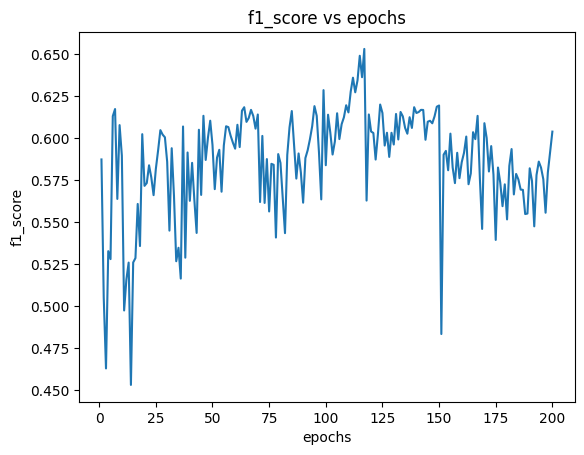

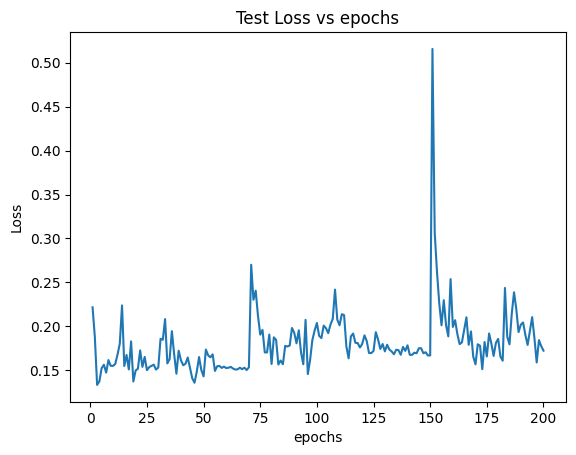

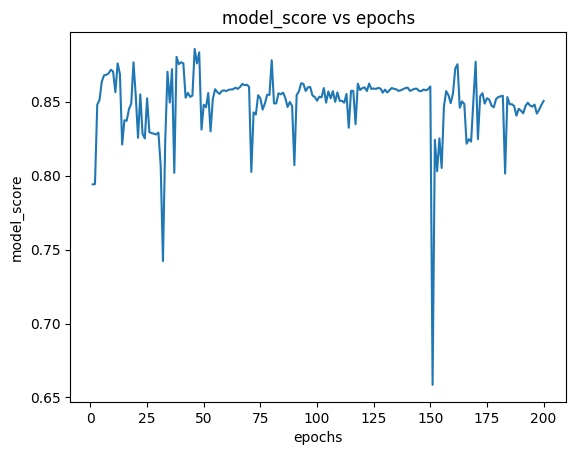

In [8]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

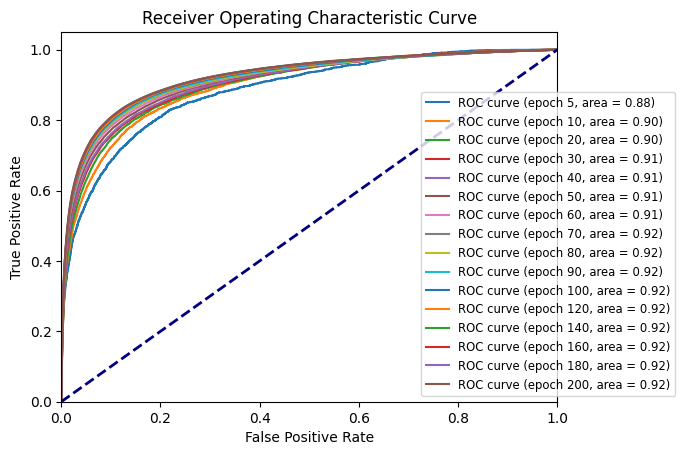

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [10]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 